In [1]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [13, 8]

In [3]:
p_true = [1, 3]
tspan = [0, 20]
def system(t, y, p):
    return [
        p[0]*y[1]*(p[1]-y[0]),
        -p[0]*y[0]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [0.5, 0.5], dense_output=True)

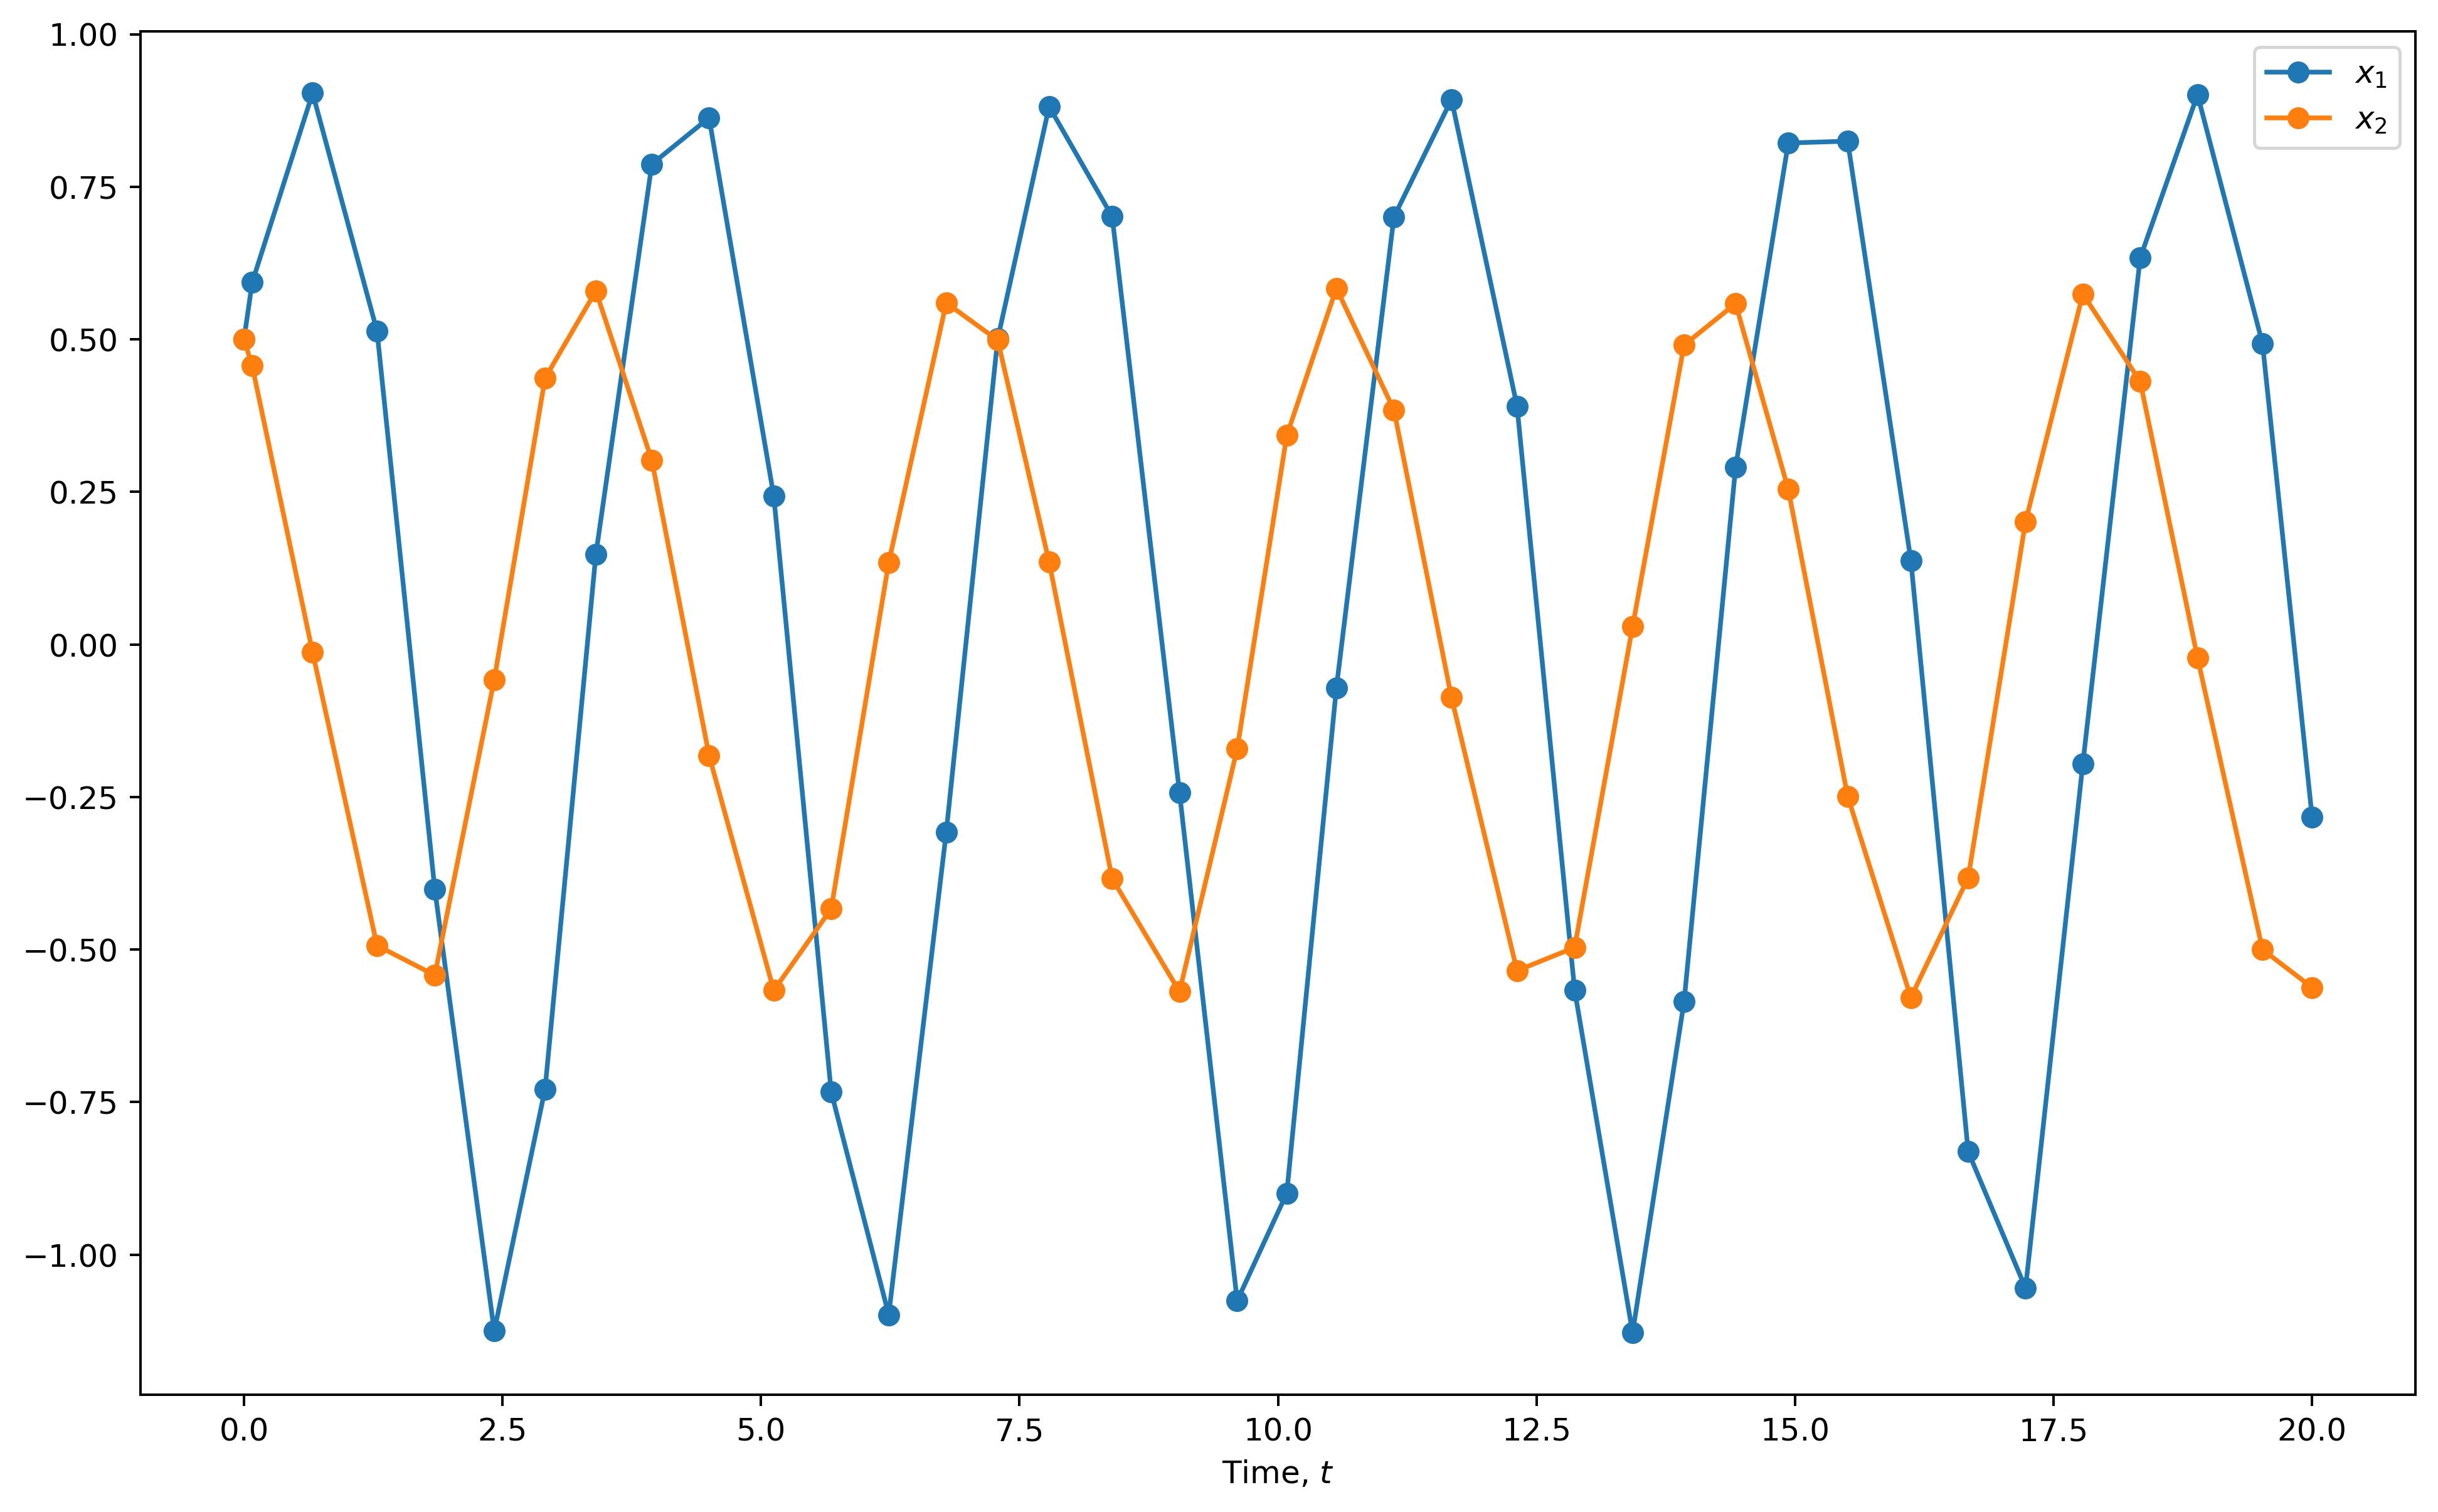

In [4]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.plot(sol.t, sol.y.T, 'o-')
# plt.title("Synthetic Data (True Trajectories)")
ax.set_xlabel("Time, $t$")
ax.legend(["$x_1$", "$x_2$"])
# plt.savefig("out/synth_traj.png", dpi=360, transparent=True)

In [5]:
neat_ts = np.linspace(*tspan, 15)
raw_data = sol.sol(neat_ts)[0]
data = raw_data + np.random.randn(15)*0.175
data.shape

(15,)

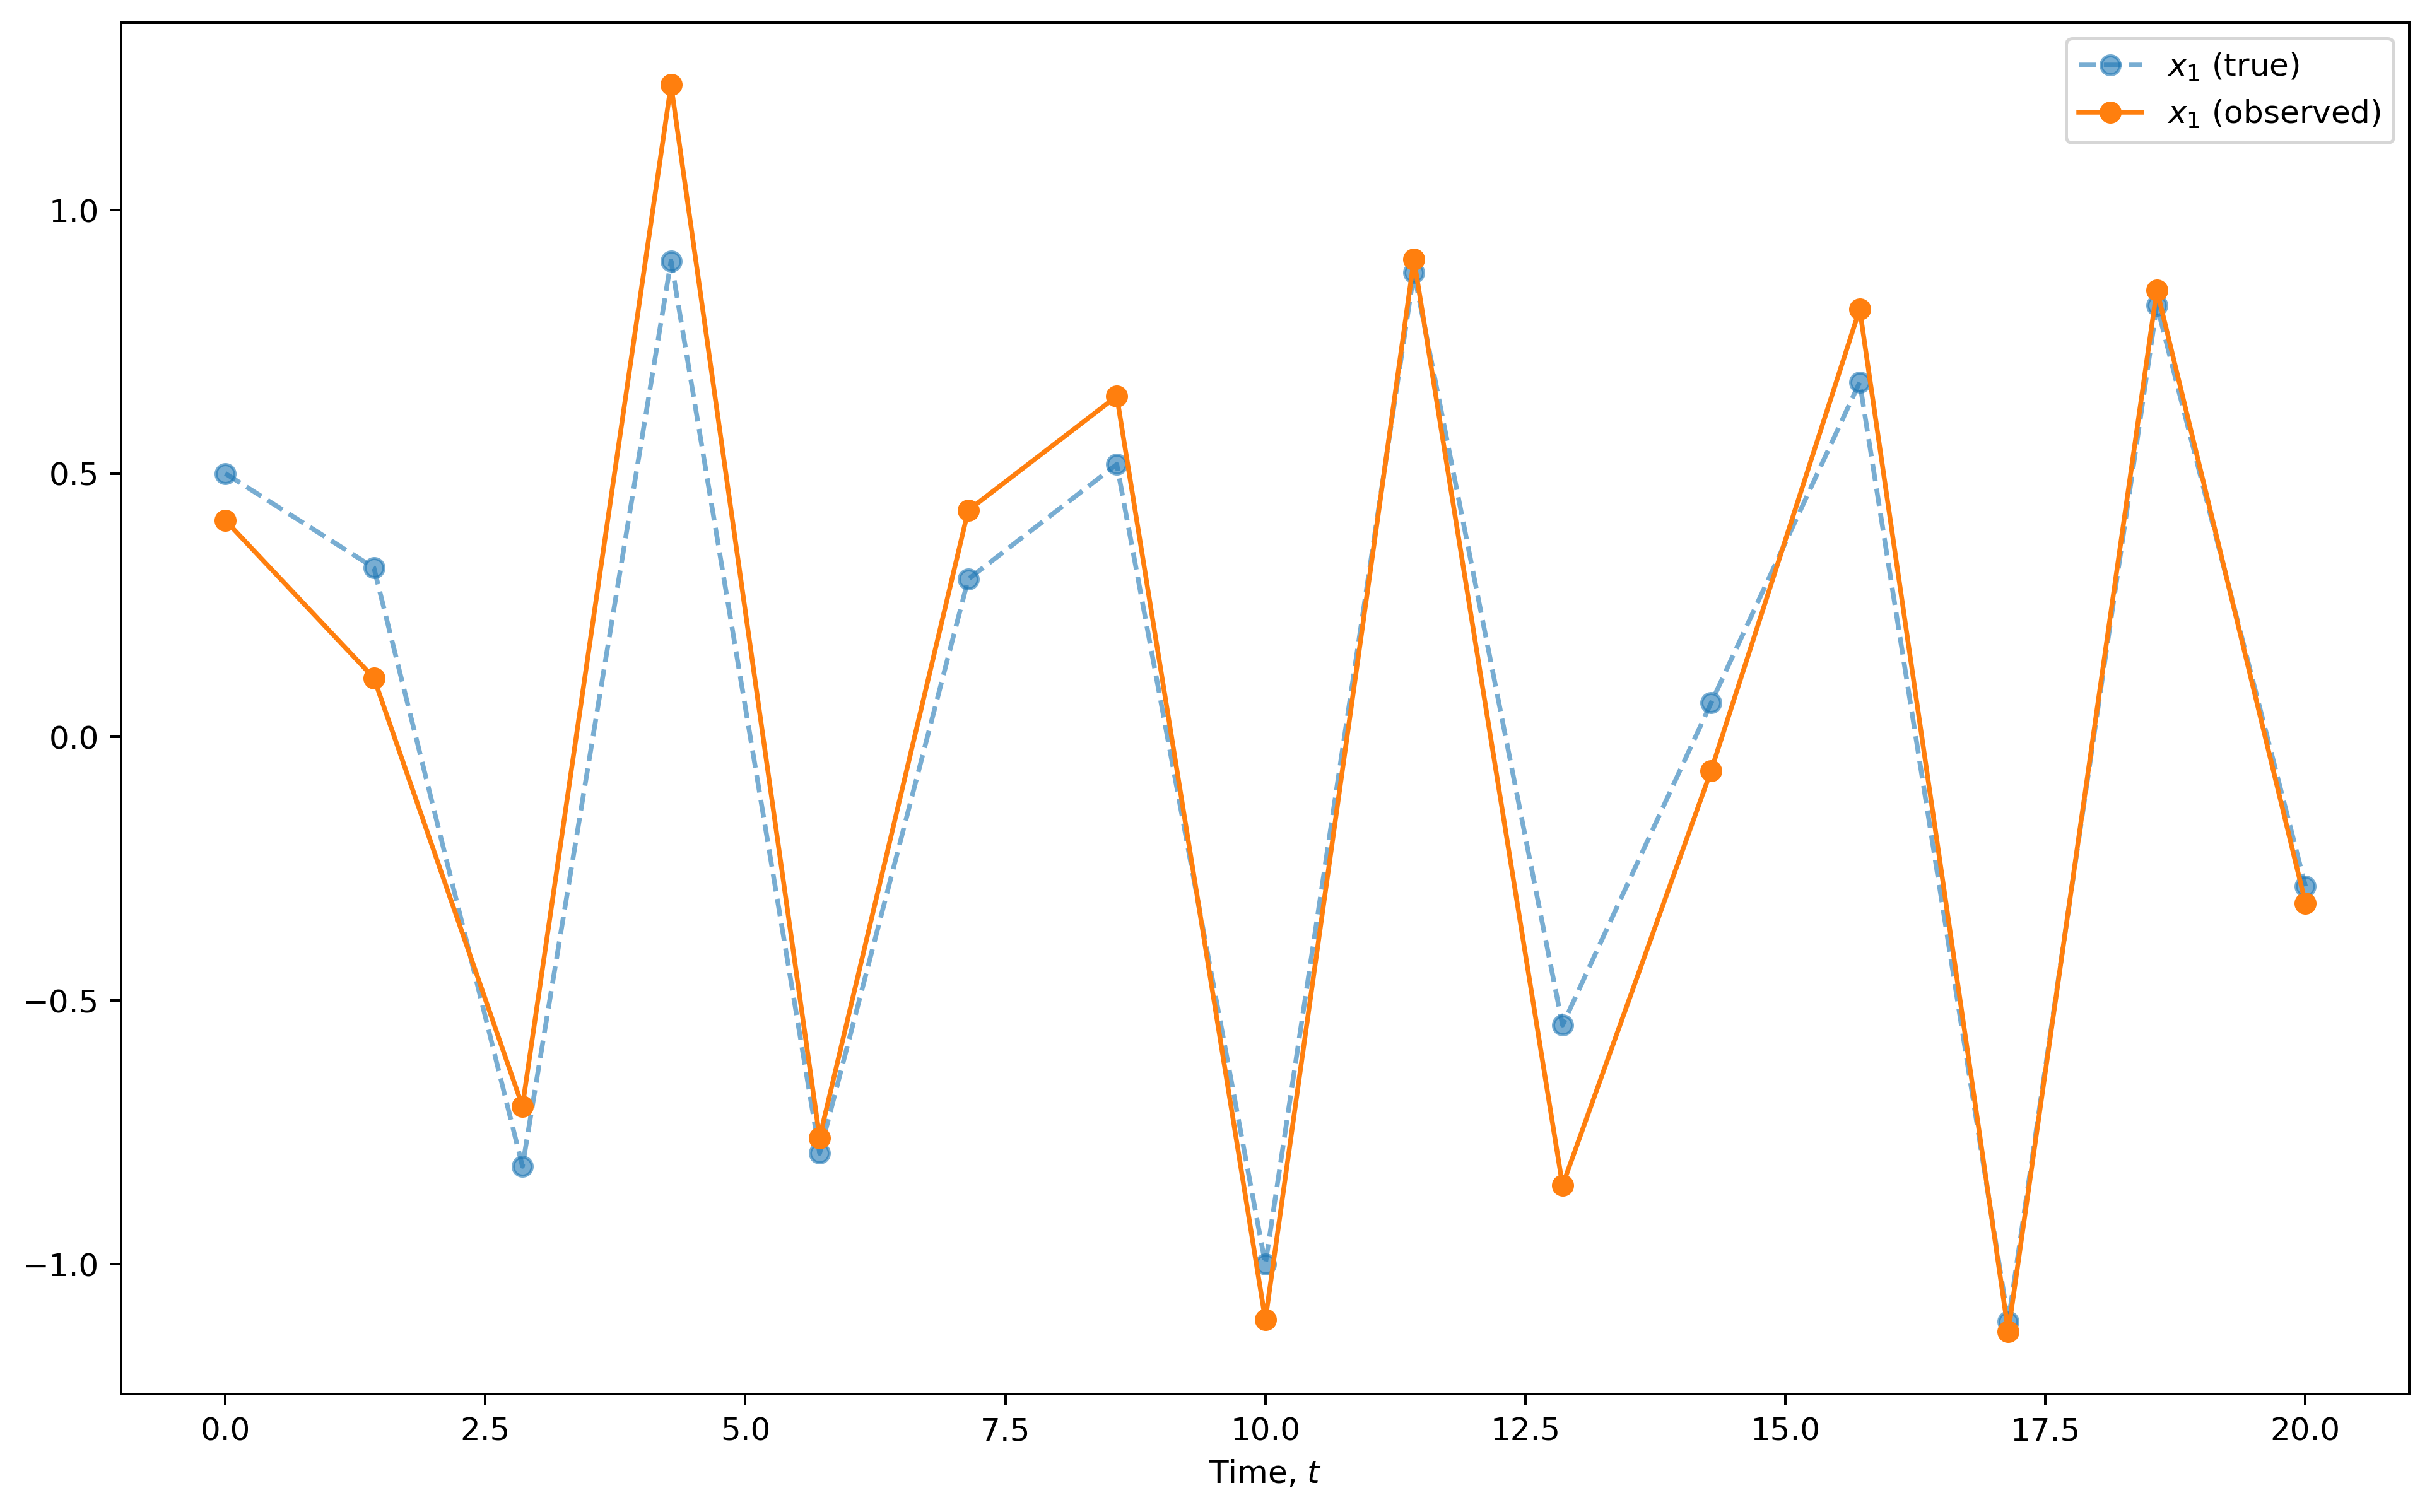

In [6]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.plot(neat_ts, raw_data.T, 'o--', alpha=0.6, label="$x_1$ (true)")
ax.plot(neat_ts, data.T, 'o-', label="$x_1$ (observed)")
ax.set_xlabel('Time, $t$')
ax.legend()

In [7]:
data_pd = np.array([[i] for i in list(data.flatten())])
# data_pd = np.array([list(i) for i in data.T])
config = {
    "grid_size": 100,
    "basis_number": 50,
    "model_form": {
        "state": 2,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": data_pd, "t": neat_ts},
    "observation_vector": [0],
    "weightings":[
        [1]*2,
        [1]*len(neat_ts)
    ],
    "regularisation_value": [0, 0],
}

In [8]:
model = modeller.Model(config)
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha])
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup)

/home/dwu402/.virtualenvs/scider/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


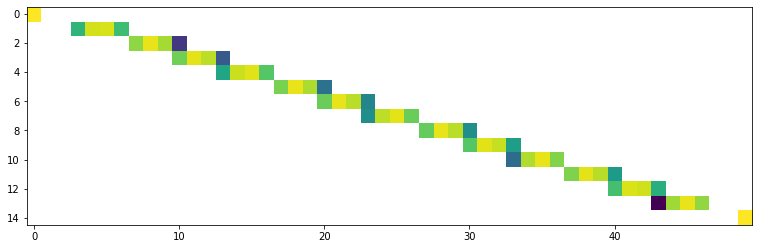

In [9]:
plt.imshow(np.log10(objective.collocation_matrices[0]))

In [10]:
p0 = [0.5, 1]
c0 = np.ones(config['basis_number']*2)
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*2) + [0]*len(config['regularisation_value'])

In [11]:
prange = np.logspace(-6, 6, num=200)
solutions = []
xguess = x0
for p in prange:
    solutions.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-5], lbx=lbx))
#     solutions.append(solver(x0=xguess, p=[p, 0], lbx=lbx))
    xguess = np.array(solutions[-1]['x']).flatten()
#     xguess += np.random.randn()*np.mean(xguess)/40


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

   3  2.3829641e-06 0.00e+00 2.27e-10  -8.6 3.56e-02    -  1.00e+00 1.00e+00f  1
   4  2.3706701e-06 0.00e+00 1.05e-09  -9.0 6.88e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   2.3706701281616546e-06    2.3706701281616546e-06
Dual infeasibility......:   1.0514913099091143e-09    1.0514913099091143e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.7942913510890503e-09    4.7942913510890503e-09
Overall NLP error.......:   4.7942913510890503e-09    4.7942913510890503e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.4650356155548719e-09    5.4650356155548719e-09
Overall NLP error.......:   5.4650356155548719e-09    5.4650356155548719e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 4
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.033

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 268.00us ( 53.60us) 269.07us ( 53.81us)         5
    nlp_grad  | 122.00us (122.00us) 121.52us (121.52us)         1
  nlp_g

   3  1.2541793e-05 0.00e+00 7.72e-09  -8.6 1.25e-01    -  1.00e+00 1.00e+00f  1
   4  1.2526390e-05 0.00e+00 2.54e-09  -9.0 9.28e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   1.2526389853039311e-05    1.2526389853039311e-05
Dual infeasibility......:   2.5416959521817405e-09    2.5416959521817405e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.8707819113383732e-09    5.8707819113383732e-09
Overall NLP error.......:   5.8707819113383732e-09    5.8707819113383732e-09


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   5  2.5081821e-05 0.00e+00 1.67e-07  -8.6 1.51e-02  -5.0 1.00e+00 1.00e+00f  1
   6  2.5075442e-05 0.00e+00 3.13e-08  -8.6 8.45e-03  -5.4 1.00e+00 1.00e+00f  1
   7  2.5072367e-05 0.00e+00 1.13e-08  -8.6 9.12e-03  -5.9 1.00e+00 1.00e+00f  1
   8  2.5070145e-05 0.00e+00 3.91e-09  -9.0 9.52e-03  -6.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.5070144940983873e-05    2.5070144940983873e-05
Dual infeasibility......:   3.9112723346786218e-09    3.9112723346786218e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1625806338388983e-09    1.1625806338388983e-09
Overall NLP error.......:   3.9112723346786218e-09    3.9112723346786218e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 0
Number of inequal

   1  3.7845590e-01 0.00e+00 6.86e+00  -1.0 1.27e+03    -  9.68e-01 1.00e+00f  1
   2  1.1527079e-03 0.00e+00 7.81e-01  -1.0 4.00e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.5005190e-02 0.00e+00 1.37e-02  -1.7 1.76e-02  -0.5 1.00e+00 1.00e+00f  1
   4  3.8480824e-03 0.00e+00 3.67e-03  -3.8 1.21e-02  -1.0 1.00e+00 1.00e+00f  1
   5  1.0424527e-03 0.00e+00 7.67e-04  -3.8 1.36e-02  -1.4 1.00e+00 1.00e+00f  1
   6  3.4824860e-04 0.00e+00 2.12e-03  -3.8 1.26e-02  -1.9 1.00e+00 1.00e+00f  1
   7  1.8150832e-04 0.00e+00 2.83e-03  -3.8 3.50e-02  -2.4 1.00e+00 1.00e+00f  1
   8  1.4951444e-04 0.00e+00 1.65e-03  -3.8 7.93e-02  -2.9 1.00e+00 1.00e+00f  1
   9  1.4966538e-04 0.00e+00 3.09e-04  -3.8 1.34e-01  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.1683211e-05 0.00e+00 5.13e-03  -5.7 5.89e-02  -3.8 1.00e+00 1.00e+00f  1
  11  6.9278671e-05 0.00e+00 8.02e-03  -5.7 2.02e-01  -4.3 1.00e+00 1.00e+00f  1
  12  5.4319844e-05 0.00e+00

  22  5.1826981e-05 0.00e+00 9.77e-05  -5.7 1.06e-01  -9.3 1.00e+00 1.00e+00f  1
  23  5.1924446e-05 0.00e+00 1.60e-05  -5.7 5.17e-02  -9.8 1.00e+00 1.00e+00f  1
  24  5.0717267e-05 0.00e+00 2.14e-03  -8.6 1.01e-01 -10.3 1.00e+00 1.00e+00f  1
  25  5.0316737e-05 0.00e+00 4.95e-04  -8.6 6.76e-02 -10.7 1.00e+00 1.00e+00f  1
  26  5.0221967e-05 0.00e+00 4.46e-05  -8.6 3.27e-02 -11.2 1.00e+00 1.00e+00f  1
  27  5.0199429e-05 0.00e+00 1.99e-06  -8.6 1.49e-02 -11.7 1.00e+00 1.00e+00f  1
  28  5.0193850e-05 0.00e+00 2.16e-07  -8.6 1.70e-02 -12.2 1.00e+00 1.00e+00f  1
  29  5.0192713e-05 0.00e+00 2.84e-08  -8.6 5.10e-02 -12.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.0192620e-05 0.00e+00 9.53e-10  -8.6 1.53e-01 -13.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   5.0192619667890740e-05    5.0192619667890740e-05
Dual infeas

  13  2.5584355e-04 0.00e+00 4.66e-01  -3.8 6.05e+05    -  1.56e-02 1.56e-02f  7
  14  2.2476219e-04 0.00e+00 1.62e+00  -3.8 7.16e+00  -5.9 1.00e+00 1.20e-01f  2
  15  2.3727943e-04 0.00e+00 5.89e-01  -3.8 3.77e+04    -  3.92e-01 2.50e-01f  3
  16  2.1511963e-04 0.00e+00 4.27e-03  -3.8 5.56e-02  -3.7 1.00e+00 1.00e+00f  1
  17  2.0670912e-04 0.00e+00 2.54e-03  -3.8 1.06e-01  -4.2 1.00e+00 1.00e+00f  1
  18  1.8984149e-04 0.00e+00 1.24e-03  -3.8 2.28e-01  -4.6 1.00e+00 1.00e+00f  1
  19  1.0658903e-04 0.00e+00 3.10e-02  -5.7 3.86e-01  -5.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.7387756e-05 0.00e+00 4.35e-02  -5.7 3.27e-01  -5.6 1.00e+00 1.00e+00f  1
  21  6.9914859e-05 0.00e+00 1.01e-02  -5.7 1.32e-01  -6.1 1.00e+00 1.00e+00f  1
  22  6.8201356e-05 0.00e+00 2.61e-03  -5.7 8.82e-02  -6.5 1.00e+00 1.00e+00f  1
  23  6.7994479e-05 0.00e+00 3.50e-05  -5.7 8.37e-03  -7.0 1.00e+00 1.00e+00f  1
  24  6.7991963e-05 0.00e+00

   3  1.1844620e-02 0.00e+00 1.13e-01  -1.7 3.55e-01  -3.0 1.00e+00 1.00e+00f  1
   4  3.4062093e-03 0.00e+00 2.31e-01  -2.5 9.79e-02  -3.4 1.00e+00 1.00e+00f  1
   5  1.7327522e-03 0.00e+00 2.39e-01  -2.5 2.98e-01  -3.9 1.00e+00 1.00e+00f  1
   6  1.7371081e-03 0.00e+00 4.68e-03  -2.5 4.59e-01  -4.4 1.00e+00 1.00e+00f  1
   7  6.4797836e-04 0.00e+00 2.83e-02  -3.8 4.09e-01  -4.9 1.00e+00 1.00e+00f  1
   8  3.0180965e-04 0.00e+00 8.16e-02  -3.8 6.19e-01  -5.3 1.00e+00 1.00e+00f  1
   9  1.7088066e-04 0.00e+00 1.28e-01  -3.8 4.93e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8436908e-04 0.00e+00 9.14e-03  -3.8 1.40e-01  -6.3 1.00e+00 1.00e+00f  1
  11  1.8316947e-04 0.00e+00 3.39e-05  -3.8 7.94e-03  -6.8 1.00e+00 1.00e+00f  1
  12  1.1910958e-04 0.00e+00 4.64e-02  -5.7 2.66e-01  -7.2 1.00e+00 1.00e+00f  1
  13  9.7938470e-05 0.00e+00 7.68e-02  -5.7 3.60e-01  -7.7 1.00e+00 1.00e+00f  1
  14  9.0784294e-05 0.00e+00

   4  1.8975448e-03 0.00e+00 9.98e-02  -2.5 2.08e-01  -3.4 1.00e+00 1.00e+00f  1
   5  1.6235366e-03 0.00e+00 1.31e-02  -2.5 3.86e-01  -3.9 1.00e+00 1.00e+00f  1
   6  5.5334080e-04 0.00e+00 7.88e-02  -3.8 1.50e-01  -4.4 1.00e+00 1.00e+00f  1
   7  2.8385429e-04 0.00e+00 6.96e-02  -3.8 2.84e-01  -4.9 1.00e+00 1.00e+00f  1
   8  2.1330132e-04 0.00e+00 5.54e-02  -3.8 3.08e-01  -5.3 1.00e+00 1.00e+00f  1
   9  2.1016592e-04 0.00e+00 1.81e-03  -3.8 1.22e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1023703e-04 0.00e+00 9.35e-05  -3.8 1.71e-02  -6.3 1.00e+00 1.00e+00f  1
  11  1.4784377e-04 0.00e+00 7.21e-02  -5.7 1.99e-01  -6.8 1.00e+00 1.00e+00f  1
  12  1.2630130e-04 0.00e+00 8.18e-02  -5.7 3.20e-01  -7.2 1.00e+00 1.00e+00f  1
  13  1.1907909e-04 0.00e+00 1.30e-02  -5.7 9.38e-02  -7.7 1.00e+00 1.00e+00f  1
  14  1.1735818e-04 0.00e+00 3.84e-03  -5.7 1.02e-01  -8.2 1.00e+00 1.00e+00f  1
  15  1.1719632e-04 0.00e+00

   5  2.1572517e-02 0.00e+00 2.30e-01  -1.7 7.74e-02  -1.2 1.00e+00 1.00e+00f  1
   6  1.2370418e-02 0.00e+00 5.04e-01  -1.7 1.37e-01  -1.7 1.00e+00 1.00e+00f  1
   7  1.0485443e-02 0.00e+00 5.82e-02  -1.7 3.66e-01  -2.2 1.00e+00 1.00e+00f  1
   8  4.1117235e-03 0.00e+00 1.38e-01  -2.5 5.63e-02  -2.6 1.00e+00 1.00e+00f  1
   9  2.6410882e-03 0.00e+00 3.26e-01  -2.5 1.64e-01  -3.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2527343e-03 0.00e+00 1.70e-02  -2.5 2.02e-01  -3.6 1.00e+00 1.00e+00f  1
  11  1.0709353e-03 0.00e+00 1.63e-01  -3.8 3.70e-01  -4.1 1.00e+00 1.00e+00f  1
  12  5.2729709e-04 0.00e+00 2.30e-01  -3.8 6.55e-01  -4.5 1.00e+00 1.00e+00f  1
  13  2.7982366e-04 0.00e+00 2.76e-02  -3.8 6.54e-01  -5.0 1.00e+00 1.00e+00f  1
  14  2.4826218e-04 0.00e+00 5.60e-03  -3.8 3.52e-01  -5.5 1.00e+00 1.00e+00f  1
  15  2.4630478e-04 0.00e+00 9.09e-04  -3.8 7.59e-02  -6.0 1.00e+00 1.00e+00f  1
  16  1.8511430e-04 0.00e+00

   1  3.2557392e-02 0.00e+00 7.97e-01  -1.0 1.17e-01  -2.0 1.00e+00 1.00e+00f  1
   2  1.6291839e-02 0.00e+00 1.36e+00  -1.7 3.45e-01  -2.5 1.00e+00 1.00e+00f  1
   3  1.0392962e-02 0.00e+00 6.72e-02  -1.7 3.86e-01  -3.0 1.00e+00 1.00e+00f  1
   4  3.3419878e-03 0.00e+00 2.59e-01  -2.5 9.53e-02  -3.4 1.00e+00 1.00e+00f  1
   5  1.8199603e-03 0.00e+00 4.46e-01  -2.5 2.48e-01  -3.9 1.00e+00 1.00e+00f  1
   6  1.9500522e-03 0.00e+00 2.61e-02  -2.5 3.39e-01  -4.4 1.00e+00 1.00e+00f  1
   7  6.8619517e-04 0.00e+00 2.22e-01  -3.8 5.75e-01  -4.9 1.00e+00 1.00e+00f  1
   8  3.8272749e-04 0.00e+00 2.35e-01  -3.8 4.94e-01  -5.3 1.00e+00 1.00e+00f  1
   9  2.5294619e-04 0.00e+00 4.28e-01  -3.8 3.16e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0102669e-04 0.00e+00 4.49e-02  -3.8 7.39e-02  -6.3 1.00e+00 1.00e+00f  1
  11  2.9336993e-04 0.00e+00 3.24e-03  -3.8 1.24e-01  -6.8 1.00e+00 1.00e+00f  1
  12  2.9473405e-04 0.00e+00

  22  2.6550693e-04 0.00e+00 7.20e-08  -8.6 1.50e-03 -10.0 1.00e+00 1.00e+00f  1
  23  2.6550685e-04 0.00e+00 4.49e-10  -8.6 3.56e-04 -10.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   2.6550684726065773e-04    2.6550684726065773e-04
Dual infeasibility......:   4.4891961285473125e-10    4.4891961285473125e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5066387807517491e-09    2.5066387807517491e-09
Overall NLP error.......:   2.5066387807517491e-09    2.5066387807517491e-09


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Numbe

   4  2.0391397e-03 0.00e+00 7.61e-02  -2.5 1.29e-01  -1.4 1.00e+00 1.00e+00f  1
   5  1.8075018e-03 0.00e+00 1.84e-02  -2.5 1.50e-01  -1.9 1.00e+00 1.00e+00f  1
   6  7.8308328e-04 0.00e+00 4.66e-02  -3.8 1.21e-02  -2.4 1.00e+00 1.00e+00f  1
   7  5.3304187e-04 0.00e+00 1.15e-01  -3.8 6.92e-02  -2.9 1.00e+00 1.00e+00f  1
   8  4.8827790e-04 0.00e+00 5.15e-02  -3.8 9.89e-02  -3.3 1.00e+00 1.00e+00f  1
   9  4.8852067e-04 0.00e+00 9.24e-03  -3.8 1.19e-01  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.9286331e-04 0.00e+00 1.54e-03  -3.8 8.23e-02  -4.3 1.00e+00 1.00e+00f  1
  11  4.9480390e-04 0.00e+00 8.69e-05  -3.8 2.67e-02  -4.8 1.00e+00 1.00e+00f  1
  12  4.3604534e-04 0.00e+00 1.97e-01  -5.7 2.23e-01  -5.2 1.00e+00 1.00e+00f  1
  13  4.1391074e-04 0.00e+00 1.28e-01  -5.7 2.42e-01  -5.7 1.00e+00 1.00e+00f  1
  14  4.0658990e-04 0.00e+00 3.86e-02  -5.7 1.43e-01  -6.2 1.00e+00 1.00e+00f  1
  15  4.0461435e-04 0.00e+00

   8  6.6594723e-04 0.00e+00 1.64e-01  -3.8 7.04e-02  -3.3 1.00e+00 1.00e+00f  1
   9  6.2538452e-04 0.00e+00 3.27e-02  -3.8 5.09e-02  -3.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2254497e-04 0.00e+00 4.09e-03  -3.8 4.12e-02  -4.3 1.00e+00 1.00e+00f  1
  11  6.2332805e-04 0.00e+00 2.57e-05  -3.8 1.15e-02  -4.8 1.00e+00 1.00e+00f  1
  12  5.6475411e-04 0.00e+00 2.31e-01  -5.7 2.25e-01  -5.2 1.00e+00 1.00e+00f  1
  13  5.4266249e-04 0.00e+00 1.44e-01  -5.7 2.35e-01  -5.7 1.00e+00 1.00e+00f  1
  14  5.3535651e-04 0.00e+00 4.51e-02  -5.7 1.44e-01  -6.2 1.00e+00 1.00e+00f  1
  15  5.3337195e-04 0.00e+00 8.22e-03  -5.7 8.27e-02  -6.7 1.00e+00 1.00e+00f  1
  16  5.3313003e-04 0.00e+00 1.51e-04  -5.7 1.20e-02  -7.2 1.00e+00 1.00e+00f  1
  17  5.3312787e-04 0.00e+00 1.32e-08  -5.7 3.65e-04  -7.6 1.00e+00 1.00e+00f  1
  18  5.3189387e-04 0.00e+00 6.16e-03  -8.6 8.95e-02  -8.1 1.00e+00 1.00e+00f  1
  19  5.3148170e-04 0.00e+00

   3  3.4848059e-02 0.00e+00 1.37e+01  -1.0 3.11e-01  -1.0 1.00e+00 1.00e+00f  1
   4  5.3895474e-02 0.00e+00 2.64e+00  -1.0 2.11e-01  -1.4 1.00e+00 1.00e+00f  1
   5  4.3669346e-02 0.00e+00 3.93e+00  -1.0 3.65e-01  -1.9 1.00e+00 1.00e+00f  1
   6  5.1650259e-02 0.00e+00 3.29e-01  -1.0 4.37e-01  -2.4 1.00e+00 1.00e+00f  1
   7  2.1647838e-02 0.00e+00 1.23e+01  -1.7 5.52e-01  -2.9 1.00e+00 1.00e+00f  1
   8  9.9767072e-03 0.00e+00 4.05e+00  -1.7 7.79e-01  -2.4 7.99e-01 3.70e-01f  2
   9  1.1236246e-02 0.00e+00 8.06e-02  -1.7 2.66e-02  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6398628e-03 0.00e+00 3.34e-02  -2.5 2.26e-02  -2.5 1.00e+00 1.00e+00f  1
  11  3.1233956e-03 0.00e+00 3.99e-01  -2.5 9.05e-02  -3.0 1.00e+00 1.00e+00f  1
  12  2.6544554e-03 0.00e+00 1.24e-01  -2.5 1.43e-01  -3.4 1.00e+00 1.00e+00f  1
  13  2.5052190e-03 0.00e+00 3.95e-03  -2.5 1.83e-01  -3.9 1.00e+00 1.00e+00f  1
  14  9.6017691e-04 0.00e+00

  16  1.2362885e-03 0.00e+00 2.82e+00  -3.8 3.95e-01  -7.2 9.66e-01 1.00e+00f  1
  17  1.0656244e-03 0.00e+00 2.69e+00  -3.8 1.51e+00  -4.0 8.32e-01 5.00e-01f  2
  18  1.0384779e-03 0.00e+00 2.47e+00  -3.8 1.98e+01  -3.6 4.72e-02 8.02e-03f  3
  19  1.0142152e-03 0.00e+00 7.22e-03  -3.8 1.13e-02  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0193060e-03 0.00e+00 1.88e-02  -3.8 6.14e-02  -3.6 1.00e+00 1.00e+00f  1
  21  1.0166872e-03 0.00e+00 3.59e-03  -3.8 5.63e-02  -4.1 1.00e+00 1.00e+00f  1
  22  1.0163025e-03 0.00e+00 4.82e-04  -3.8 1.74e-02  -4.6 1.00e+00 1.00e+00f  1
  23  9.5848640e-04 0.00e+00 3.10e-01  -5.7 2.25e-01  -5.1 1.00e+00 1.00e+00f  1
  24  9.3657990e-04 0.00e+00 1.86e-01  -5.7 2.26e-01  -5.6 1.00e+00 1.00e+00f  1
  25  9.2934646e-04 0.00e+00 6.07e-02  -5.7 1.46e-01  -6.0 1.00e+00 1.00e+00f  1
  26  9.2735468e-04 0.00e+00 1.11e-02  -5.7 8.13e-02  -6.5 1.00e+00 1.00e+00f  1
  27  9.2710417e-04 0.00e+00

  16  1.3325820e-03 0.00e+00 1.44e-01  -3.8 1.30e-01  -4.7 1.00e+00 1.00e+00f  1
  17  1.3066359e-03 0.00e+00 1.37e+00  -3.8 1.28e-01  -5.2 1.00e+00 1.00e+00f  1
  18  1.3110080e-03 0.00e+00 1.77e-02  -3.8 4.30e-02  -5.6 1.00e+00 1.00e+00f  1
  19  1.3110614e-03 0.00e+00 6.68e-05  -3.8 1.87e-03  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2535201e-03 0.00e+00 4.71e+00  -5.7 2.31e-01  -6.6 1.00e+00 1.00e+00f  1
  21  1.2319579e-03 0.00e+00 2.63e+00  -5.7 2.13e-01  -7.1 1.00e+00 1.00e+00f  1
  22  1.2248750e-03 0.00e+00 9.05e-01  -5.7 1.48e-01  -7.5 1.00e+00 1.00e+00f  1
  23  1.2229099e-03 0.00e+00 1.62e-01  -5.7 7.90e-02  -8.0 1.00e+00 1.00e+00f  1
  24  1.2226571e-03 0.00e+00 3.54e-03  -5.7 1.31e-02  -8.5 1.00e+00 1.00e+00f  1
  25  1.2226547e-03 0.00e+00 3.47e-07  -5.7 6.15e-04  -9.0 1.00e+00 1.00e+00f  1
  26  1.2214331e-03 0.00e+00 1.27e-01  -8.6 8.89e-02  -9.5 1.00e+00 1.00e+00f  1
  27  1.2210060e-03 0.00e+00

  17  3.2073711e-03 0.00e+00 4.97e-02  -2.5 1.85e-02  -5.6 1.00e+00 1.00e+00f  1
  18  3.2057173e-03 0.00e+00 4.64e-02  -2.5 4.95e-02  -6.1 1.00e+00 1.00e+00f  1
  19  3.2081505e-03 0.00e+00 4.45e-05  -2.5 1.66e-02  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.1441514e-03 0.00e+00 4.04e+00  -3.8 1.92e-01  -7.1 1.00e+00 1.00e+00f  1
  21  1.7609760e-03 0.00e+00 8.07e+00  -3.8 1.01e+00  -3.9 9.88e-01 1.00e+00f  1
  22  1.6808463e-03 0.00e+00 2.72e+00  -3.8 6.52e-01  -4.4 7.37e-01 2.89e-01f  2
  23  1.7232053e-03 0.00e+00 3.41e-01  -3.8 4.67e-01  -4.0 1.00e+00 1.00e+00f  1
  24  1.7188710e-03 0.00e+00 2.85e-01  -3.8 1.85e-01  -4.5 1.00e+00 1.00e+00f  1
  25  1.7146973e-03 0.00e+00 5.13e-02  -3.8 1.01e-01  -4.9 1.00e+00 1.00e+00f  1
  26  1.7157154e-03 0.00e+00 4.76e-04  -3.8 3.94e-03  -5.4 1.00e+00 1.00e+00f  1
  27  1.6495203e-03 0.00e+00 1.29e+00  -5.7 2.42e-01  -5.9 1.00e+00 1.00e+00f  1
  28  1.6228974e-03 0.00e+00

   8  1.8809676e-02 0.00e+00 8.47e+00  -1.7 5.07e-02  -1.3 1.00e+00 1.00e+00f  1
   9  1.1181214e-02 0.00e+00 1.78e+01  -1.7 2.63e-01  -1.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2360963e-02 0.00e+00 5.68e-01  -1.7 2.08e-01  -2.3 1.00e+00 1.00e+00f  1
  11  1.2071389e-02 0.00e+00 3.06e+00  -1.7 2.61e-01  -2.8 1.00e+00 1.00e+00f  1
  12  1.2884449e-02 0.00e+00 2.27e-01  -1.7 2.67e-01  -3.2 1.00e+00 1.00e+00f  1
  13  1.2329348e-02 0.00e+00 4.03e+01  -1.7 7.01e-01  -3.7 1.00e+00 5.00e-01f  2
  14  1.2878602e-02 0.00e+00 1.00e+02  -1.7 6.42e+01  -4.2 1.32e-02 2.39e-03f  4
  15  1.4135001e-02 0.00e+00 9.17e+00  -1.7 1.81e-01  -2.0 1.00e+00 2.50e-01f  3
  16  1.4054390e-02 0.00e+00 2.42e-01  -1.7 7.24e-02  -2.4 1.00e+00 1.00e+00f  1
  17  1.4234051e-02 0.00e+00 1.40e-01  -1.7 7.19e-02  -2.9 1.00e+00 1.00e+00f  1
  18  5.5033184e-03 0.00e+00 1.76e+01  -2.5 3.69e-01  -3.4 1.00e+00 1.00e+00f  1
  19  4.4599395e-03 0.00e+00

  36  2.4396736e-03 0.00e+00 1.42e-02  -8.6 6.42e-02  -8.4 1.00e+00 1.00e+00f  1
  37  2.4393361e-03 0.00e+00 1.73e-03  -8.6 3.46e-02  -8.9 1.00e+00 1.00e+00f  1
  38  2.4392594e-03 0.00e+00 1.15e-04  -8.6 1.69e-02  -9.3 1.00e+00 1.00e+00f  1
  39  2.4392423e-03 0.00e+00 3.12e-07  -8.6 8.20e-03  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.4392382e-03 0.00e+00 1.12e-06  -8.6 3.54e-03 -10.3 1.00e+00 1.00e+00f  1
  41  2.4392375e-03 0.00e+00 3.16e-07  -8.6 8.40e-04 -10.8 1.00e+00 1.00e+00f  1
  42  2.4392375e-03 0.00e+00 8.48e-10  -8.6 6.39e-04 -11.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   2.4392374830923009e-03    2.4392374830923009e-03
Dual infeasibility......:   8.4844386030735741e-10    8.4844386030735741e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  64  2.8008010e-03 0.00e+00 5.61e-05  -9.0 1.48e+02    -  7.28e-01 2.50e-01f  3
  65  2.8008007e-03 0.00e+00 5.02e-06  -9.0 2.09e+00    -  1.00e+00 1.00e+00f  1
  66  2.8008009e-03 0.00e+00 3.11e-05  -9.0 4.57e+01 -14.1 1.00e+00 5.00e-01f  2
  67  2.8008007e-03 0.00e+00 4.39e-06  -9.0 1.92e+00    -  1.00e+00 1.00e+00f  1
  68  2.8008008e-03 0.00e+00 1.39e-05  -9.0 1.78e+02 -14.5 1.91e-01 6.25e-02f  5
  69  2.8008007e-03 0.00e+00 6.56e-06  -9.0 3.15e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.8008008e-03 0.00e+00 8.98e-06  -9.0 1.13e+01    -  1.00e+00 5.00e-01f  2
  71  2.8008007e-03 0.00e+00 4.16e-06  -9.0 2.11e+00    -  1.00e+00 1.00e+00f  1
  72  2.8008007e-03 0.00e+00 5.36e-06  -9.0 6.38e+00    -  1.00e+00 5.00e-01f  2
  73  2.8008007e-03 0.00e+00 3.14e-06  -9.0 1.62e+00    -  1.00e+00 1.00e+00f  1
  74  2.8008009e-03 0.00e+00 5.46e-06  -9.0 2.91e+00    -  1.00e+00 1.00e+00f  1
  75  2.8008006e-03 0.00e+00

   4  2.5275922e-04 0.00e+00 9.77e-07  -5.7 1.04e-01    -  1.00e+00 1.00e+00f  1
   5  2.5275838e-04 0.00e+00 2.13e-09  -8.6 2.86e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.5275837504817086e-04    2.5275837504817086e-04
Dual infeasibility......:   2.1266421430092591e-09    2.1266421430092591e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3580864952535624e-09    3.3580864952535624e-09
Overall NLP error.......:   3.3580864952535624e-09    3.3580864952535624e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   4  3.1913274e-04 0.00e+00 4.76e-07  -5.7 4.28e-02    -  1.00e+00 1.00e+00f  1
   5  3.1913216e-04 0.00e+00 8.59e-09  -8.6 1.56e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   3.1913216436797829e-04    3.1913216436797829e-04
Dual infeasibility......:   8.5894824595710396e-09    8.5894824595710396e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.9092494710527844e-09    3.9092494710527844e-09
Overall NLP error.......:   8.5894824595710396e-09    8.5894824595710396e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   3  4.1153283e-04 0.00e+00 4.68e-05  -5.7 2.61e-01    -  1.00e+00 1.00e+00f  1
   4  4.1141463e-04 0.00e+00 7.25e-07  -5.7 1.04e-02    -  1.00e+00 1.00e+00f  1
   5  4.1141425e-04 0.00e+00 1.03e-08  -8.6 1.41e-03    -  1.00e+00 1.00e+00f  1
   6  4.1141425e-04 0.00e+00 1.62e-14  -9.0 1.75e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   4.1141424819366649e-04    4.1141424819366649e-04
Dual infeasibility......:   1.6155154397397787e-14    1.6155154397397787e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909234682492061e-10    9.0909234682492061e-10
Overall NLP error.......:   9.0909234682492061e-10    9.0909234682492061e-10


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequal

   3  5.4116254e-04 0.00e+00 1.62e-05  -5.7 2.60e-01    -  9.97e-01 1.00e+00f  1
   4  5.4101349e-04 0.00e+00 1.19e-06  -8.6 1.15e-02    -  1.00e+00 1.00e+00f  1
   5  5.4101348e-04 0.00e+00 1.13e-11  -8.6 5.98e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   5.4101348092035705e-04    5.4101348092035705e-04
Dual infeasibility......:   1.1300014544616721e-11    1.1300014544616721e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059772413289423e-09    2.5059772413289423e-09
Overall NLP error.......:   2.5059772413289423e-09    2.5059772413289423e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   4  7.2410267e-04 0.00e+00 3.98e-06  -5.7 2.13e-02    -  1.00e+00 1.00e+00f  1
   5  7.2410054e-04 0.00e+00 1.29e-07  -8.6 3.25e-03    -  1.00e+00 1.00e+00f  1
   6  7.2410054e-04 0.00e+00 5.40e-13  -8.6 5.95e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   7.2410054484691941e-04    7.2410054484691941e-04
Dual infeasibility......:   5.4003753097614766e-13    5.4003753097614766e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059107964591040e-09    2.5059107964591040e-09
Overall NLP error.......:   2.5059107964591040e-09    2.5059107964591040e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   3  9.8383772e-04 0.00e+00 3.16e-04  -3.8 1.77e-01    -  1.00e+00 1.00e+00f  1
   4  9.8344311e-04 0.00e+00 3.94e-06  -5.7 1.75e-02    -  1.00e+00 1.00e+00f  1
   5  9.8344223e-04 0.00e+00 7.24e-08  -8.6 2.07e-03    -  1.00e+00 1.00e+00f  1
   6  9.8344223e-04 0.00e+00 5.38e-13  -8.6 6.34e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   9.8344223368392047e-04    9.8344223368392047e-04
Dual infeasibility......:   5.3825799553973372e-13    5.3825799553973372e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059052529329709e-09    2.5059052529329709e-09
Overall NLP error.......:   2.5059052529329709e-09    2.5059052529329709e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequal

   1  2.4909063e-03 0.00e+00 7.30e-03  -1.0 1.43e-01    -  9.94e-01 1.00e+00f  1
   2  1.3949588e-03 0.00e+00 3.16e-03  -2.5 2.20e-01    -  1.00e+00 1.00e+00f  1
   3  1.3508261e-03 0.00e+00 6.12e-05  -3.8 8.84e-02    -  1.00e+00 1.00e+00f  1
   4  1.3504697e-03 0.00e+00 2.88e-05  -5.7 3.45e-02    -  1.00e+00 1.00e+00f  1
   5  1.3504686e-03 0.00e+00 6.53e-09  -5.7 7.70e-04    -  1.00e+00 1.00e+00f  1
   6  1.3504685e-03 0.00e+00 1.21e-08  -8.6 7.03e-04    -  1.00e+00 1.00e+00f  1
   7  1.3504685e-03 0.00e+00 1.72e-14  -9.0 5.20e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.3504685436986422e-03    1.3504685436986422e-03
Dual infeasibility......:   1.7217730007731335e-14    1.7217730007731335e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909122276091089e-10    9.0909122276091089e-10
Overall NLP error.......

   2  1.7639319e-03 0.00e+00 4.25e-03  -2.5 1.87e-01    -  1.00e+00 1.00e+00f  1
   3  1.7213120e-03 0.00e+00 1.84e-05  -3.8 8.43e-02    -  1.00e+00 1.00e+00f  1
   4  1.7211311e-03 0.00e+00 1.78e-05  -5.7 2.34e-02    -  1.00e+00 1.00e+00f  1
   5  1.7211308e-03 0.00e+00 1.07e-08  -8.6 5.17e-04    -  1.00e+00 1.00e+00f  1
   6  1.7211308e-03 0.00e+00 4.29e-13  -9.0 3.53e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.7211308223451325e-03    1.7211308223451325e-03
Dual infeasibility......:   4.2929102691382358e-13    4.2929102691382358e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909287717879042e-10    9.0909287717879042e-10
Overall NLP error.......:   9.0909287717879042e-10    9.0909287717879042e-10


Number of objective function evaluations             = 7
Number of objective gradient evaluations          

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3883418e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.9829899e-03 0.00e+00 7.00e-03  -1.0 7.73e-02    -  9.96e-01 1.00e+00f  1
   2  2.4189987e-03 0.00e+00 5.43e-03  -2.5 1.34e-01    -  1.00e+00 1.00e+00f  1
   3  2.3834284e-03 0.00e+00 5.67e-05  -3.8 6.36e-02    -  1.00e+00 1.00e+00f  1
   4  2.3833714e-03 0.00e+00 5.99e-06  -5.7 1.11e-02    -  1.00e+00 1.00e+00f  1
   5  2.3833713e-03 0.00e+00 2.58e-08  -8.6 7.24e-04    -  1.00e+00 1.00e+00f  1
   6  2.3833713e-03 0.00e+00 6.93e-14  -8.6 9.03e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   2.3833713284001092e-03    2.3833713284001092e-03
Dual infeasibility......:   6.9280885080028179e-14    6.9280885080028179e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   4  3.0373946e-03 0.00e+00 5.38e-06  -5.7 9.14e-03    -  1.00e+00 1.00e+00f  1
   5  3.0373945e-03 0.00e+00 3.28e-08  -8.6 7.12e-04    -  1.00e+00 1.00e+00f  1
   6  3.0373945e-03 0.00e+00 5.38e-14  -8.6 6.24e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   3.0373945403511147e-03    3.0373945403511147e-03
Dual infeasibility......:   5.3847588817113104e-14    5.3847588817113104e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036091998098e-09    2.5059036091998098e-09
Overall NLP error.......:   2.5059036091998098e-09    2.5059036091998098e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   1  5.7191070e-03 0.00e+00 6.77e-03  -1.0 6.54e-02    -  9.97e-01 1.00e+00f  1
   2  4.1798410e-03 0.00e+00 6.48e-03  -2.5 5.64e-02    -  1.00e+00 1.00e+00f  1
   3  4.1636316e-03 0.00e+00 5.72e-05  -3.8 2.57e-02    -  1.00e+00 1.00e+00f  1
   4  4.1635487e-03 0.00e+00 3.29e-05  -5.7 1.88e-02    -  1.00e+00 1.00e+00f  1
   5  4.1635485e-03 0.00e+00 3.65e-09  -5.7 1.71e-04    -  1.00e+00 1.00e+00f  1
   6  4.1635485e-03 0.00e+00 2.23e-08  -8.6 4.89e-04    -  1.00e+00 1.00e+00f  1
   7  4.1635485e-03 0.00e+00 2.62e-14  -9.0 4.05e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.1635484810266001e-03    4.1635484810266001e-03
Dual infeasibility......:   2.6181664544636535e-14    2.6181664544636535e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909105871675726e-10    9.0909105871675726e-10
Overall NLP error.......

   3  5.2196125e-03 0.00e+00 1.88e-05  -3.8 1.53e-02    -  1.00e+00 1.00e+00f  1
   4  5.2193987e-03 0.00e+00 1.36e-04  -5.7 3.27e-02    -  1.00e+00 1.00e+00f  1
   5  5.2193972e-03 0.00e+00 4.44e-09  -5.7 1.09e-04    -  1.00e+00 1.00e+00f  1
   6  5.2193971e-03 0.00e+00 2.70e-08  -8.6 4.60e-04    -  1.00e+00 1.00e+00f  1
   7  5.2193971e-03 0.00e+00 2.49e-14  -8.6 1.30e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2193971408413991e-03    5.2193971408413991e-03
Dual infeasibility......:   2.4938263281311569e-14    2.4938263281311569e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598265170e-09    2.5059035598265170e-09
Overall NLP error.......:   2.5059035598265170e-09    2.5059035598265170e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations          

   6  6.4562574e-03 0.00e+00 4.00e-08  -8.6 4.74e-04    -  1.00e+00 1.00e+00f  1
   7  6.4562574e-03 0.00e+00 2.49e-14  -8.6 9.34e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   6.4562573769184183e-03    6.4562573769184183e-03
Dual infeasibility......:   2.4925475924966638e-14    2.4925475924966638e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598441959e-09    2.5059035598441959e-09
Overall NLP error.......:   2.5059035598441959e-09    2.5059035598441959e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.3676194e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  9.1620481e-03 0.00e+00 5.16e-03  -1.0 5.45e-02    -  9.98e-01 1.00e+00f  1
   2  8.3499649e-03 0.00e+00 1.38e-02  -2.5 1.68e-01    -  1.00e+00 1.00e+00f  1
   3  8.3409717e-03 0.00e+00 1.40e-03  -3.8 7.22e-02    -  1.00e+00 1.00e+00f  1
   4  8.3393121e-03 0.00e+00 2.14e-03  -5.7 8.69e-02    -  1.00e+00 1.00e+00f  1
   5  8.3391619e-03 0.00e+00 1.95e-05  -5.7 7.67e-03    -  1.00e+00 1.00e+00f  1
   6  8.3391612e-03 0.00e+00 6.40e-07  -5.7 1.48e-03    -  1.00e+00 1.00e+00f  1
   7  8.3391612e-03 0.00e+00 5.04e-08  -8.6 4.19e-04    -  1.00e+00 1.00e+00f  1
   8  8.3391612e-03 0.00e+00 2.49e-14  -8.6 1.56e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   8.3391611976846945e-03    8.3391611976846945e-03
Dual infeasi

   2  1.0892031e-02 0.00e+00 2.97e-02  -2.5 2.11e-01    -  1.00e+00 1.00e+00f  1
   3  1.0896438e-02 0.00e+00 6.82e-03  -2.5 1.17e-01    -  1.00e+00 1.00e+00f  1
   4  1.0882208e-02 0.00e+00 2.51e-02  -3.8 2.24e-01    -  1.00e+00 1.00e+00f  1
   5  1.0871515e-02 0.00e+00 9.67e-04  -3.8 3.92e-02    -  1.00e+00 1.00e+00f  1
   6  1.0869591e-02 0.00e+00 5.82e-03  -5.7 1.04e-01    -  1.00e+00 1.00e+00f  1
   7  1.0869099e-02 0.00e+00 1.13e-05  -5.7 3.88e-03    -  1.00e+00 1.00e+00f  1
   8  1.0869098e-02 0.00e+00 3.14e-06  -8.6 2.38e-03    -  1.00e+00 1.00e+00f  1
   9  1.0869098e-02 0.00e+00 8.72e-13  -8.6 1.02e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.0869097656937183e-02    1.0869097656937183e-02
Dual infeasibility......:   8.7195731605602312e-13    8.7195731605602312e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   0  1.2388112e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2707917e-02 0.00e+00 4.18e-03  -1.0 5.05e-02    -  9.98e-01 1.00e+00f  1
   2  1.2384440e-02 0.00e+00 4.81e-02  -2.5 2.27e-01    -  1.00e+00 1.00e+00f  1
   3  1.2375288e-02 0.00e+00 3.36e-03  -2.5 6.98e-02    -  1.00e+00 1.00e+00f  1
   4  1.2361408e-02 0.00e+00 1.28e-02  -3.8 2.62e-01    -  1.00e+00 5.00e-01f  2
   5  1.2352894e-02 0.00e+00 8.28e-03  -3.8 1.01e-01    -  1.00e+00 1.00e+00f  1
   6  1.2349915e-02 0.00e+00 3.10e-03  -3.8 6.08e-02    -  1.00e+00 1.00e+00f  1
   7  1.2349203e-02 0.00e+00 7.24e-04  -3.8 2.92e-02    -  1.00e+00 1.00e+00f  1
   8  1.2348924e-02 0.00e+00 9.94e-04  -5.7 3.45e-02    -  1.00e+00 1.00e+00f  1
   9  1.2348914e-02 0.00e+00 2.46e-06  -5.7 1.62e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2348914e-02 0.00e+00 2.03e-07  -8.6 4.92e-04    -  1.00e+00 1.00e+00f  1
  11  1.2348914e-02 0.00e+00

   3  1.4191771e-02 0.00e+00 1.30e-03  -2.5 3.66e-02    -  1.00e+00 1.00e+00f  1
   4  1.4178582e-02 0.00e+00 2.59e-02  -3.8 2.84e-01    -  1.00e+00 5.00e-01f  2
   5  1.4170229e-02 0.00e+00 5.46e-03  -3.8 6.10e-02    -  1.00e+00 1.00e+00f  1
   6  1.4166983e-02 0.00e+00 9.42e-03  -3.8 8.08e-02    -  1.00e+00 1.00e+00f  1
   7  1.4166141e-02 0.00e+00 4.39e-04  -3.8 1.68e-02    -  1.00e+00 1.00e+00f  1
   8  1.4165816e-02 0.00e+00 2.02e-03  -5.7 3.71e-02    -  1.00e+00 1.00e+00f  1
   9  1.4165793e-02 0.00e+00 1.24e-06  -5.7 8.16e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4165793e-02 0.00e+00 3.11e-07  -8.6 4.58e-04    -  1.00e+00 1.00e+00f  1
  11  1.4165793e-02 0.00e+00 2.41e-14  -8.6 1.22e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.4165793023508087e-02    1.4165793023508087e-02
Dual infeas

   9  1.5788649e-02 0.00e+00 3.98e-07  -5.7 3.26e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5788649e-02 0.00e+00 3.70e-07  -8.6 3.77e-04    -  1.00e+00 1.00e+00f  1
  11  1.5788649e-02 0.00e+00 2.91e-14  -8.6 9.67e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.5788649112206159e-02    1.5788649112206159e-02
Dual infeasibility......:   2.9119497469019071e-14    2.9119497469019071e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597298101e-09    2.5059035597298101e-09
Overall NLP error.......:   2.5059035597298101e-09    2.5059035597298101e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of ineq

   2  1.7760117e-02 0.00e+00 1.95e-01  -2.5 1.93e-01    -  1.00e+00 1.00e+00f  1
   3  1.7705534e-02 0.00e+00 1.01e-03  -2.5 1.90e-02    -  1.00e+00 1.00e+00f  1
   4  1.7698174e-02 0.00e+00 4.89e-02  -3.8 2.06e-01    -  1.00e+00 5.00e-01f  2
   5  1.7692065e-02 0.00e+00 5.21e-03  -3.8 3.20e-02    -  1.00e+00 1.00e+00f  1
   6  1.7689967e-02 0.00e+00 2.20e-02  -3.8 6.63e-02    -  1.00e+00 1.00e+00f  1
   7  1.7689053e-02 0.00e+00 3.19e-04  -3.8 7.57e-03    -  1.00e+00 1.00e+00f  1
   8  1.7688805e-02 0.00e+00 4.51e-03  -5.7 2.98e-02    -  1.00e+00 1.00e+00f  1
   9  1.7688773e-02 0.00e+00 5.64e-07  -5.7 2.80e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7688773e-02 0.00e+00 5.84e-07  -8.6 3.38e-04    -  1.00e+00 1.00e+00f  1
  11  1.7688773e-02 0.00e+00 2.40e-14  -8.6 7.66e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   5  1.9348038e-02 0.00e+00 8.03e-03  -3.8 3.11e-02    -  1.00e+00 1.00e+00f  1
   6  1.9346628e-02 0.00e+00 1.56e-02  -3.8 4.31e-02    -  1.00e+00 1.00e+00f  1
   7  1.9346246e-02 0.00e+00 6.62e-04  -3.8 8.69e-03    -  1.00e+00 1.00e+00f  1
   8  1.9346057e-02 0.00e+00 5.00e-03  -5.7 2.43e-02    -  1.00e+00 1.00e+00f  1
   9  1.9346035e-02 0.00e+00 2.61e-06  -5.7 5.10e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9346035e-02 0.00e+00 1.07e-06  -8.6 3.54e-04    -  1.00e+00 1.00e+00f  1
  11  1.9346035e-02 0.00e+00 4.52e-14  -8.6 1.92e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.9346034866573113e-02    1.9346034866573113e-02
Dual infeasibility......:   4.5205325631493927e-14    4.5205325631493927e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1451222e-02 0.00e+00 1.32e-06  -8.6 3.10e-04    -  1.00e+00 1.00e+00f  1
  11  2.1451222e-02 0.00e+00 1.28e-13  -8.6 4.47e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.1451222418483178e-02    2.1451222418483178e-02
Dual infeasibility......:   1.2831375968828954e-13    1.2831375968828954e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035603490247e-09    2.5059035603490247e-09
Overall NLP error.......:   2.5059035603490247e-09    2.5059035603490247e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian

   5  2.3582285e-02 0.00e+00 1.22e-03  -3.8 7.74e-03    -  1.00e+00 1.00e+00f  1
   6  2.3582046e-02 0.00e+00 1.46e-02  -5.7 2.76e-02    -  1.00e+00 1.00e+00f  1
   7  2.3581979e-02 0.00e+00 8.82e-06  -5.7 6.22e-04    -  1.00e+00 1.00e+00f  1
   8  2.3581979e-02 0.00e+00 4.83e-06  -8.6 4.99e-04    -  1.00e+00 1.00e+00f  1
   9  2.3581979e-02 0.00e+00 2.41e-13  -8.6 8.74e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.3581978848992578e-02    2.3581978848992578e-02
Dual infeasibility......:   2.4058195117522865e-13    2.4058195117522865e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035616129670e-09    2.5059035616129670e-09
Overall NLP error.......:   2.5059035616129670e-09    2.5059035616129670e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations         

  13  2.7652280e-02 0.00e+00 2.39e-03  -3.8 8.90e-03    -  1.00e+00 1.00e+00f  1
  14  2.7652230e-02 0.00e+00 4.62e-04  -3.8 3.92e-03    -  1.00e+00 1.00e+00f  1
  15  2.7652157e-02 0.00e+00 5.76e-03  -5.7 1.39e-02    -  1.00e+00 1.00e+00f  1
  16  2.7652151e-02 0.00e+00 5.62e-07  -5.7 1.25e-04    -  1.00e+00 1.00e+00f  1
  17  2.7652151e-02 0.00e+00 1.09e-06  -8.6 1.91e-04    -  1.00e+00 1.00e+00f  1
  18  2.7652151e-02 0.00e+00 8.94e-14  -8.6 1.99e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   2.7652151206970597e-02    2.7652151206970597e-02
Dual infeasibility......:   8.9418836808745975e-14    8.9418836808745975e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596837431e-09    2.5059035596837431e-09
Overall NLP error.......:   2.5059035596837431e-09    2.5059035596837431e-09


Number of objective funct

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2110922e-02 0.00e+00 2.08e-03  -3.8 7.12e-03    -  1.00e+00 1.00e+00f  1
  11  3.2110918e-02 0.00e+00 4.20e-06  -3.8 3.16e-04    -  1.00e+00 1.00e+00f  1
  12  3.2110856e-02 0.00e+00 6.75e-03  -5.7 1.29e-02    -  1.00e+00 1.00e+00f  1
  13  3.2110851e-02 0.00e+00 1.42e-08  -5.7 1.51e-05    -  1.00e+00 1.00e+00f  1
  14  3.2110851e-02 0.00e+00 1.01e-06  -8.6 1.57e-04    -  1.00e+00 1.00e+00f  1
  15  3.2110851e-02 0.00e+00 1.32e-13  -8.6 2.69e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.2110850861980338e-02    3.2110850861980338e-02
Dual infeasibility......:   1.3166745280181111e-13    1.3166745280181111e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596798773e-09    2.5059035596798773e-09
Overall NLP error......

   8  3.8369875e-02 0.00e+00 1.20e-01  -3.8 4.76e-02    -  1.00e+00 1.00e+00f  1
   9  3.8366805e-02 0.00e+00 5.18e-02  -3.8 3.06e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8365197e-02 0.00e+00 6.66e-02  -3.8 3.47e-02    -  1.00e+00 1.00e+00f  1
  11  3.8364458e-02 0.00e+00 1.23e-02  -3.8 1.48e-02    -  1.00e+00 1.00e+00f  1
  12  3.8364179e-02 0.00e+00 1.28e-02  -3.8 1.51e-02    -  1.00e+00 1.00e+00f  1
  13  3.8364137e-02 0.00e+00 4.39e-04  -3.8 2.79e-03    -  1.00e+00 1.00e+00f  1
  14  3.8364076e-02 0.00e+00 8.80e-03  -5.7 1.26e-02    -  1.00e+00 1.00e+00f  1
  15  3.8364071e-02 0.00e+00 3.84e-07  -5.7 7.43e-05    -  1.00e+00 1.00e+00f  1
  16  3.8364071e-02 0.00e+00 1.46e-06  -8.6 1.62e-04    -  1.00e+00 1.00e+00f  1
  17  3.8364071e-02 0.00e+00 4.24e-13  -8.6 1.71e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objecti

   7  4.3982532e-02 0.00e+00 1.54e-01  -1.7 5.07e-02    -  1.00e+00 1.00e+00f  1
   8  4.3956317e-02 0.00e+00 2.99e-01  -2.5 7.65e-02    -  1.00e+00 1.00e+00f  1
   9  4.3943283e-02 0.00e+00 6.43e-02  -2.5 3.14e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.3930212e-02 0.00e+00 3.59e-01  -2.5 7.48e-02    -  1.00e+00 1.00e+00f  1
  11  4.3921561e-02 0.00e+00 8.35e-03  -2.5 1.10e-02    -  1.00e+00 1.00e+00f  1
  12  4.3912409e-02 0.00e+00 2.62e-01  -3.8 2.54e-01    -  1.00e+00 2.50e-01f  3
  13  4.3903055e-02 0.00e+00 1.07e-01  -3.8 4.09e-02    -  1.00e+00 1.00e+00f  1
  14  4.3898365e-02 0.00e+00 2.71e-01  -3.8 6.39e-02    -  1.00e+00 1.00e+00f  1
  15  4.3892950e-02 0.00e+00 2.77e-02  -3.8 2.01e-02    -  1.00e+00 1.00e+00f  1
  16  4.3891021e-02 0.00e+00 8.23e-02  -3.8 6.39e-02    -  1.00e+00 5.00e-01f  2
  17  4.3889574e-02 0.00e+00 4.37e-02  -3.8 2.54e-02    -  1.00e+00 1.00e+00f  1
  18  4.3888919e-02 0.00e+00

   5  5.0858946e-02 0.00e+00 2.76e-01  -1.7 5.98e-02    -  1.00e+00 1.00e+00f  1
   6  5.0939756e-02 0.00e+00 1.24e+00  -1.7 2.35e-01    -  1.00e+00 5.00e-01f  2
   7  5.0906325e-02 0.00e+00 2.58e-01  -1.7 5.84e-02    -  1.00e+00 1.00e+00f  1
   8  5.0984410e-02 0.00e+00 1.08e+00  -1.7 2.21e-01    -  1.00e+00 5.00e-01f  2
   9  5.0971754e-02 0.00e+00 2.57e-01  -1.7 5.88e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.1039530e-02 0.00e+00 8.49e-01  -1.7 1.95e-01    -  1.00e+00 5.00e-01f  2
  11  5.1051900e-02 0.00e+00 3.00e-01  -1.7 6.41e-02    -  1.00e+00 1.00e+00f  1
  12  5.1100714e-02 0.00e+00 5.57e-01  -1.7 1.48e-01    -  1.00e+00 5.00e-01f  2
  13  5.1147473e-02 0.00e+00 4.79e-01  -1.7 8.14e-02    -  1.00e+00 1.00e+00f  1
  14  5.1203465e-02 0.00e+00 5.09e-01  -1.7 8.42e-02    -  1.00e+00 1.00e+00f  1
  15  5.1249214e-02 0.00e+00 3.61e-01  -1.7 7.15e-02    -  1.00e+00 1.00e+00f  1
  16  5.1317185e-02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.9558063e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.9548530e-02 0.00e+00 5.46e-01  -1.0 5.01e-02    -  9.96e-01 1.00e+00f  1
   2  5.9703788e-02 0.00e+00 2.67e+00  -1.7 1.68e-01    -  1.00e+00 1.00e+00f  1
   3  5.9512157e-02 0.00e+00 1.33e-01  -1.7 3.99e-02    -  1.00e+00 1.00e+00f  1
   4  5.9504251e-02 0.00e+00 1.02e-01  -2.5 2.54e-02    -  1.00e+00 1.00e+00f  1
   5  5.9507273e-02 0.00e+00 7.14e-02  -2.5 2.71e-02    -  1.00e+00 1.00e+00f  1
   6  5.9510012e-02 0.00e+00 4.21e-02  -2.5 2.07e-02    -  1.00e+00 1.00e+00f  1
   7  5.9511976e-02 0.00e+00 1.75e-02  -2.5 1.34e-02    -  1.00e+00 1.00e+00f  1
   8  5.9507182e-02 0.00e+00 1.56e-01  -3.8 1.56e-01    -  1.00e+00 2.50e-01f  3
   9  5.9502660e-02 0.00e+00 2.21e-01  -3.8 4.82e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.9499368e-02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.0398296e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  7.0369680e-02 0.00e+00 7.59e-01  -1.0 5.01e-02    -  9.96e-01 1.00e+00f  1
   2  7.0407182e-02 0.00e+00 1.99e+00  -1.7 1.35e-01    -  1.00e+00 1.00e+00f  1
   3  7.0329619e-02 0.00e+00 3.44e-01  -1.7 5.43e-02    -  1.00e+00 1.00e+00f  1
   4  7.0407042e-02 0.00e+00 1.82e+00  -1.7 2.32e-01    -  1.00e+00 5.00e-01f  2
   5  7.0348350e-02 0.00e+00 2.83e-01  -1.7 4.94e-02    -  1.00e+00 1.00e+00f  1
   6  7.0453795e-02 0.00e+00 1.95e+00  -1.7 2.47e-01    -  1.00e+00 5.00e-01f  2
   7  7.0389990e-02 0.00e+00 1.89e-01  -1.7 4.16e-02    -  1.00e+00 1.00e+00f  1
   8  7.0367925e-02 0.00e+00 4.41e-01  -2.5 7.11e-02    -  1.00e+00 1.00e+00f  1
   9  7.0357758e-02 0.00e+00 6.97e-02  -2.5 2.41e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.0349586e-02 0.00e+00

  15  8.3714752e-02 0.00e+00 6.65e-03  -3.8 6.69e-03    -  1.00e+00 1.00e+00f  1
  16  8.3714732e-02 0.00e+00 6.30e-04  -3.8 2.06e-03    -  1.00e+00 1.00e+00f  1
  17  8.3714690e-02 0.00e+00 1.73e-02  -5.7 1.09e-02    -  1.00e+00 1.00e+00f  1
  18  8.3714685e-02 0.00e+00 7.33e-07  -5.7 6.46e-05    -  1.00e+00 1.00e+00f  1
  19  8.3714685e-02 0.00e+00 3.24e-06  -8.6 1.49e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  8.3714685e-02 0.00e+00 2.84e-06  -8.6 4.26e-10    -  1.00e+00 1.25e-01f  4
  21  8.3714685e-02 0.00e+00 2.79e-06  -8.6 3.73e-10    -  1.00e+00 1.56e-02f  7
  22  8.3714685e-02 0.00e+00 5.14e-13  -8.6 3.67e-10    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   8.3714685360965407e-02    8.3714685360965407e-02
Dual infeasibility......:   5.1380856821223889e-13    5.1380856821223889e-13
Constraint viol

  18  1.0066221e-01 0.00e+00 4.12e-01  -3.8 5.25e-02    -  1.00e+00 1.00e+00f  1
  19  1.0062830e-01 0.00e+00 1.97e+00  -3.8 2.15e-01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.0055268e-01 0.00e+00 3.30e-01  -3.8 4.53e-02    -  1.00e+00 1.00e+00f  1
  21  1.0053226e-01 0.00e+00 2.07e+00  -3.8 2.22e-01    -  1.00e+00 5.00e-01f  2
  22  1.0045916e-01 0.00e+00 2.18e-01  -3.8 3.64e-02    -  1.00e+00 1.00e+00f  1
  23  1.0042994e-01 0.00e+00 8.36e-01  -3.8 2.61e-01    -  1.00e+00 2.50e-01f  3
  24  1.0039179e-01 0.00e+00 9.48e-01  -3.8 7.70e-02    -  1.00e+00 1.00e+00f  1
  25  1.0035538e-01 0.00e+00 6.18e-01  -3.8 6.16e-02    -  1.00e+00 1.00e+00f  1
  26  1.0032945e-01 0.00e+00 1.13e+00  -3.8 8.32e-02    -  1.00e+00 1.00e+00f  1
  27  1.0029765e-01 0.00e+00 2.91e-01  -3.8 4.16e-02    -  1.00e+00 1.00e+00f  1
  28  1.0028112e-01 0.00e+00 8.24e-01  -3.8 1.28e-01    -  1.00e+00 5.00e-01f  2
  29  1.0025856e-01 0.00e+00

  51  1.0972369e-01 0.00e+00 5.36e-02  -2.5 1.67e-02    -  1.00e+00 1.00e+00f  1
  52  1.0972255e-01 0.00e+00 9.85e-03  -2.5 7.16e-03    -  1.00e+00 1.00e+00f  1
  53  1.0971814e-01 0.00e+00 4.18e-01  -3.8 1.87e-01    -  1.00e+00 2.50e-01f  3
  54  1.0971331e-01 0.00e+00 1.26e-01  -3.8 2.65e-02    -  1.00e+00 1.00e+00f  1
  55  1.0971199e-01 0.00e+00 5.34e-01  -3.8 5.25e-02    -  1.00e+00 1.00e+00f  1
  56  1.0970795e-01 0.00e+00 2.18e-02  -3.8 1.04e-02    -  1.00e+00 1.00e+00f  1
  57  1.0970686e-01 0.00e+00 1.68e-01  -3.8 5.68e-02    -  1.00e+00 5.00e-01f  2
  58  1.0970607e-01 0.00e+00 3.75e-02  -3.8 1.38e-02    -  1.00e+00 1.00e+00f  1
  59  1.0970567e-01 0.00e+00 7.99e-02  -3.8 2.02e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.0970553e-01 0.00e+00 4.48e-03  -3.8 4.75e-03    -  1.00e+00 1.00e+00f  1
  61  1.0970548e-01 0.00e+00 4.25e-03  -3.8 4.64e-03    -  1.00e+00 1.00e+00f  1
  62  1.0970548e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.2086334e-01 0.00e+00 2.34e+00  -2.5 1.15e-01    -  1.00e+00 1.00e+00f  1
  51  1.2077791e-01 0.00e+00 3.43e-01  -2.5 4.29e-02    -  1.00e+00 1.00e+00f  1
  52  1.2075658e-01 0.00e+00 2.82e+00  -2.5 2.43e-01    -  1.00e+00 5.00e-01f  2
  53  1.2065911e-01 0.00e+00 1.79e-01  -2.5 3.03e-02    -  1.00e+00 1.00e+00f  1
  54  1.2061822e-01 0.00e+00 1.49e+00  -2.5 3.45e-01    -  1.00e+00 2.50e-01f  3
  55  1.2056481e-01 0.00e+00 4.73e-01  -2.5 5.04e-02    -  1.00e+00 1.00e+00f  1
  56  1.2052995e-01 0.00e+00 1.10e+00  -2.5 1.36e-01    -  1.00e+00 5.00e-01f  2
  57  1.2048631e-01 0.00e+00 6.38e-01  -2.5 5.79e-02    -  1.00e+00 1.00e+00f  1
  58  1.2045264e-01 0.00e+00 1.49e+00  -2.5 8.85e-02    -  1.00e+00 1.00e+00f  1
  59  1.2041229e-01 0.00e+00 2.43e-01  -2.5 3.51e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2038954e-01 0.00e+00

  41  1.3162127e-01 0.00e+00 9.34e-02  -3.8 1.98e-02    -  1.00e+00 1.00e+00f  1
  42  1.3162043e-01 0.00e+00 4.14e-01  -3.8 4.19e-02    -  1.00e+00 1.00e+00f  1
  43  1.3161842e-01 0.00e+00 1.50e-02  -3.8 7.86e-03    -  1.00e+00 1.00e+00f  1
  44  1.3161789e-01 0.00e+00 8.96e-02  -3.8 3.72e-02    -  1.00e+00 5.00e-01f  2
  45  1.3161756e-01 0.00e+00 3.26e-02  -3.8 1.17e-02    -  1.00e+00 1.00e+00f  1
  46  1.3161741e-01 0.00e+00 2.32e-02  -3.8 9.86e-03    -  1.00e+00 1.00e+00f  1
  47  1.3161738e-01 0.00e+00 2.64e-03  -3.8 3.32e-03    -  1.00e+00 1.00e+00f  1
  48  1.3161737e-01 0.00e+00 2.45e-04  -3.8 1.01e-03    -  1.00e+00 1.00e+00f  1
  49  1.3161733e-01 0.00e+00 3.27e-02  -5.7 1.18e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.3161732e-01 0.00e+00 1.48e-07  -5.7 2.03e-05    -  1.00e+00 1.00e+00f  1
  51  1.3161732e-01 0.00e+00 5.80e-06  -8.6 1.57e-04    -  1.00e+00 1.00e+00f  1
  52  1.3161732e-01 0.00e+00

   5  1.5828010e-01 0.00e+00 6.70e+00  -1.0 3.16e-01    -  1.00e+00 5.00e-01f  2
   6  1.5824646e-01 0.00e+00 2.29e+00  -1.0 1.28e-01    -  1.00e+00 1.00e+00f  1
   7  1.5853239e-01 0.00e+00 6.21e+00  -1.0 5.17e-01    -  1.00e+00 2.50e-01f  3
   8  1.5793118e-01 0.00e+00 1.01e+00  -1.0 3.13e-02    -  1.00e+00 1.00e+00f  1
   9  1.5820200e-01 0.00e+00 4.77e+00  -1.0 5.61e-01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5848038e-01 0.00e+00 2.87e+00  -1.0 1.80e-01    -  1.00e+00 1.00e+00f  1
  11  1.5854072e-01 0.00e+00 5.48e+00  -1.0 2.13e-01    -  1.00e+00 5.00e-01f  2
  12  1.5845412e-01 0.00e+00 2.84e+00  -1.0 9.99e-02    -  1.00e+00 1.00e+00f  1
  13  1.5921522e-01 0.00e+00 9.66e+00  -1.0 2.02e-01    -  1.00e+00 1.00e+00f  1
  14  1.5862642e-01 0.00e+00 6.86e-01  -1.0 5.45e-02  -2.0 1.00e+00 1.00e+00f  1
  15  1.5846219e-01 0.00e+00 9.22e-01  -1.7 3.65e-02    -  1.00e+00 1.00e+00f  1
  16  1.5845372e-01 0.00e+00

  21  1.7215300e-01 0.00e+00 1.30e-03  -3.8 2.00e-03    -  1.00e+00 1.00e+00f  1
  22  1.7215297e-01 0.00e+00 6.59e-02  -5.7 1.43e-02    -  1.00e+00 1.00e+00f  1
  23  1.7215293e-01 0.00e+00 7.33e-06  -5.7 1.40e-04    -  1.00e+00 1.00e+00f  1
  24  1.7215293e-01 0.00e+00 3.73e-05  -8.6 3.40e-04    -  1.00e+00 1.00e+00f  1
  25  1.7215293e-01 0.00e+00 1.03e-12  -8.6 2.97e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............:   1.7215293098796491e-01    1.7215293098796491e-01
Dual infeasibility......:   1.0306226358447468e-12    1.0306226358447468e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035599112947e-09    2.5059035599112947e-09
Overall NLP error.......:   2.5059035599112947e-09    2.5059035599112947e-09


Number of objective function evaluations             = 48
Number of objective gradient evaluations        

  73  1.8773890e-01 0.00e+00 8.59e-02  -5.7 1.55e-02    -  1.00e+00 1.00e+00f  1
  74  1.8773885e-01 0.00e+00 6.66e-06  -5.7 1.24e-04    -  1.00e+00 1.00e+00f  1
  75  1.8773885e-01 0.00e+00 6.29e-05  -8.6 4.17e-04    -  1.00e+00 1.00e+00f  1
  76  1.8773885e-01 0.00e+00 1.57e-12  -8.6 3.34e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   1.8773884643721298e-01    1.8773884643721298e-01
Dual infeasibility......:   1.5725365761507267e-12    1.5725365761507267e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035600178654e-09    2.5059035600178654e-09
Overall NLP error.......:   2.5059035600178654e-09    2.5059035600178654e-09


Number of objective function evaluations             = 186
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of ine

  16  2.2189154e-01 0.00e+00 1.04e+00  -3.8 9.27e-02    -  1.00e+00 5.00e-01f  2
  17  2.2187622e-01 0.00e+00 2.67e-01  -3.8 2.49e-02    -  1.00e+00 1.00e+00f  1
  18  2.2186838e-01 0.00e+00 9.52e-01  -3.8 8.77e-02    -  1.00e+00 5.00e-01f  2
  19  2.2185494e-01 0.00e+00 2.65e-01  -3.8 2.47e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.2184763e-01 0.00e+00 8.17e-01  -3.8 7.97e-02    -  1.00e+00 5.00e-01f  2
  21  2.2183619e-01 0.00e+00 2.95e-01  -3.8 2.60e-02    -  1.00e+00 1.00e+00f  1
  22  2.2182949e-01 0.00e+00 6.11e-01  -3.8 6.52e-02    -  1.00e+00 5.00e-01f  2
  23  2.2182009e-01 0.00e+00 4.29e-01  -3.8 3.12e-02    -  1.00e+00 1.00e+00f  1
  24  2.2181280e-01 0.00e+00 7.53e-01  -3.8 4.13e-02    -  1.00e+00 1.00e+00f  1
  25  2.2180383e-01 0.00e+00 2.24e-01  -3.8 2.23e-02    -  1.00e+00 1.00e+00f  1
  26  2.2179876e-01 0.00e+00 6.02e-01  -3.8 6.63e-02    -  1.00e+00 5.00e-01f  2
  27  2.2179143e-01 0.00e+00

  37  2.3986345e-01 0.00e+00 2.45e-01  -3.8 7.32e-02    -  1.00e+00 2.50e-01f  3
  38  2.3986089e-01 0.00e+00 3.10e-01  -3.8 2.30e-02    -  1.00e+00 1.00e+00f  1
  39  2.3985842e-01 0.00e+00 1.62e-01  -3.8 1.66e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3985695e-01 0.00e+00 4.30e-01  -3.8 2.70e-02    -  1.00e+00 1.00e+00f  1
  41  2.3985457e-01 0.00e+00 5.34e-02  -3.8 9.43e-03    -  1.00e+00 1.00e+00f  1
  42  2.3985376e-01 0.00e+00 3.96e-01  -3.8 4.98e-02    -  1.00e+00 5.00e-01f  2
  43  2.3985189e-01 0.00e+00 3.68e-02  -3.8 7.80e-03    -  1.00e+00 1.00e+00f  1
  44  2.3985135e-01 0.00e+00 3.50e-01  -3.8 4.71e-02    -  1.00e+00 5.00e-01f  2
  45  2.3984999e-01 0.00e+00 2.38e-02  -3.8 6.25e-03    -  1.00e+00 1.00e+00f  1
  46  2.3984956e-01 0.00e+00 2.65e-01  -3.8 4.10e-02    -  1.00e+00 5.00e-01f  2
  47  2.3984877e-01 0.00e+00 1.71e-02  -3.8 5.29e-03    -  1.00e+00 1.00e+00f  1
  48  2.3984841e-01 0.00e+00

   1  2.7859367e-01 0.00e+00 8.18e+00  -1.0 4.41e-02    -  9.99e-01 1.00e+00f  1
   2  2.7740483e-01 0.00e+00 1.18e-02  -1.0 6.13e-03   0.0 1.00e+00 1.00e+00f  1
   3  2.7736729e-01 0.00e+00 1.16e+00  -2.5 3.15e-01    -  1.00e+00 1.25e-01f  4
   4  2.7730058e-01 0.00e+00 1.60e-01  -2.5 1.30e-02    -  1.00e+00 1.00e+00f  1
   5  2.7728507e-01 0.00e+00 1.70e+00  -2.5 1.82e-01    -  1.00e+00 2.50e-01f  3
   6  2.7724464e-01 0.00e+00 1.05e-01  -2.5 8.04e-03    -  1.00e+00 1.00e+00f  1
   7  2.7722490e-01 0.00e+00 1.03e+00  -2.5 1.37e-01    -  1.00e+00 2.50e-01f  3
   8  2.7719994e-01 0.00e+00 2.92e-01  -2.5 1.89e-02    -  1.00e+00 1.00e+00f  1
   9  2.7718207e-01 0.00e+00 8.73e-01  -2.5 5.90e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7716056e-01 0.00e+00 3.40e-01  -2.5 2.00e-02    -  1.00e+00 1.00e+00f  1
  11  2.7714548e-01 0.00e+00 6.15e-01  -2.5 4.60e-02    -  1.00e+00 5.00e-01f  2
  12  2.7712637e-01 0.00e+00

  36  2.9568384e-01 0.00e+00 4.35e-01  -3.8 2.03e-02    -  1.00e+00 1.00e+00f  1
  37  2.9567969e-01 0.00e+00 1.26e-01  -3.8 1.09e-02    -  1.00e+00 1.00e+00f  1
  38  2.9567845e-01 0.00e+00 5.25e-01  -3.8 2.23e-02    -  1.00e+00 1.00e+00f  1
  39  2.9567524e-01 0.00e+00 2.17e-02  -3.8 4.47e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.9567441e-01 0.00e+00 1.33e-01  -3.8 2.14e-02    -  1.00e+00 5.00e-01f  2
  41  2.9567387e-01 0.00e+00 4.22e-02  -3.8 6.29e-03    -  1.00e+00 1.00e+00f  1
  42  2.9567364e-01 0.00e+00 4.20e-02  -3.8 6.28e-03    -  1.00e+00 1.00e+00f  1
  43  2.9567358e-01 0.00e+00 4.16e-03  -3.8 1.97e-03    -  1.00e+00 1.00e+00f  1
  44  2.9567356e-01 0.00e+00 8.08e-04  -3.8 8.70e-04    -  1.00e+00 1.00e+00f  1
  45  2.9567353e-01 0.00e+00 1.70e-02  -5.7 4.05e-03    -  1.00e+00 1.00e+00f  1
  46  2.9567353e-01 0.00e+00 6.38e-07  -5.7 2.31e-05    -  1.00e+00 1.00e+00f  1
  47  2.9567353e-01 0.00e+00

   6  3.3413599e-01 0.00e+00 2.43e+00  -1.0 4.56e-02    -  1.00e+00 1.00e+00f  1
   7  3.3466928e-01 0.00e+00 5.79e+00  -1.0 1.23e-01    -  1.00e+00 5.00e-01f  2
   8  3.3424704e-01 0.00e+00 7.00e-02  -1.0 5.77e-03   0.0 1.00e+00 1.00e+00f  1
   9  3.3408414e-01 0.00e+00 1.78e+00  -2.5 3.50e-01    -  9.92e-01 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3380899e-01 0.00e+00 3.14e-01  -2.5 9.99e-02    -  1.00e+00 5.00e-01f  2
  11  3.3372757e-01 0.00e+00 6.05e-02  -2.5 7.22e-03  -0.5 1.00e+00 1.00e+00f  1
  12  3.3367832e-01 0.00e+00 2.88e+00  -2.5 3.89e-01    -  1.00e+00 1.25e-01f  4
  13  3.3360795e-01 0.00e+00 2.30e-01  -2.5 4.42e-02    -  1.00e+00 1.00e+00f  1
  14  3.3352223e-01 0.00e+00 2.75e+00  -2.5 3.83e-02  -1.0 1.00e+00 1.00e+00f  1
  15  3.3351599e-01 0.00e+00 8.45e-01  -2.5 2.42e-02    -  1.00e+00 1.00e+00f  1
  16  3.3345787e-01 0.00e+00 2.02e-02  -2.5 6.91e-03  -0.5 1.00e+00 1.00e+00f  1
  17  3.3340106e-01 0.00e+00

  32  3.5123573e-01 0.00e+00 5.21e-02  -3.8 5.78e-03    -  1.00e+00 1.00e+00f  1
  33  3.5123555e-01 0.00e+00 1.76e-02  -3.8 3.38e-03    -  1.00e+00 1.00e+00f  1
  34  3.5123552e-01 0.00e+00 2.20e-03  -3.8 1.19e-03    -  1.00e+00 1.00e+00f  1
  35  3.5123551e-01 0.00e+00 3.91e-05  -3.8 1.59e-04    -  1.00e+00 1.00e+00f  1
  36  3.5123549e-01 0.00e+00 7.28e-03  -5.7 2.22e-03    -  1.00e+00 1.00e+00f  1
  37  3.5123549e-01 0.00e+00 8.37e-10  -5.7 7.07e-07    -  1.00e+00 1.00e+00f  1
  38  3.5123549e-01 0.00e+00 1.11e-06  -8.6 2.74e-05    -  1.00e+00 1.00e+00f  1
  39  3.5123549e-01 0.00e+00 1.10e-06  -8.6 2.11e-10    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.5123549e-01 0.00e+00 3.58e-12  -8.6 2.09e-10    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   3.5123549071847626e-01    3.5123549071847626e-01
Dual infeas

   8  3.8768460e-01 0.00e+00 8.41e-01  -1.7 2.46e-02    -  1.00e+00 1.00e+00f  1
   9  3.8759673e-01 0.00e+00 6.68e-01  -1.7 2.27e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8751939e-01 0.00e+00 1.04e+00  -1.7 2.30e-02    -  1.00e+00 1.00e+00f  1
  11  3.8746297e-01 0.00e+00 2.29e-01  -1.7 1.30e-02    -  1.00e+00 1.00e+00f  1
  12  3.8740840e-01 0.00e+00 6.85e-01  -1.7 3.39e-02    -  1.00e+00 5.00e-01f  2
  13  3.8737377e-01 0.00e+00 1.62e-01  -1.7 9.05e-03    -  1.00e+00 1.00e+00f  1
  14  3.8731085e-01 0.00e+00 1.89e+00  -2.5 1.32e-01    -  1.00e+00 2.50e-01f  3
  15  3.8722840e-01 0.00e+00 4.78e-01  -2.5 2.64e-02    -  1.00e+00 1.00e+00f  1
  16  3.8717976e-01 0.00e+00 1.97e+00  -2.5 1.08e-01    -  1.00e+00 2.50e-01f  3
  17  3.8710936e-01 0.00e+00 2.53e-01  -2.5 9.75e-03    -  1.00e+00 1.00e+00f  1
  18  3.8707680e-01 0.00e+00 1.75e+00  -2.5 6.13e-02    -  1.00e+00 5.00e-01f  2
  19  3.8702131e-01 0.00e+00

  18  4.2045277e-01 0.00e+00 1.20e-01  -3.8 7.16e-03    -  1.00e+00 1.00e+00f  1
  19  4.2045087e-01 0.00e+00 1.99e-01  -3.8 9.25e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.2044988e-01 0.00e+00 2.61e-02  -3.8 3.33e-03    -  1.00e+00 1.00e+00f  1
  21  4.2044957e-01 0.00e+00 4.18e-02  -3.8 4.24e-03    -  1.00e+00 1.00e+00f  1
  22  4.2044953e-01 0.00e+00 9.41e-04  -3.8 6.32e-04    -  1.00e+00 1.00e+00f  1
  23  4.2044950e-01 0.00e+00 6.83e-03  -5.7 1.75e-03    -  1.00e+00 1.00e+00f  1
  24  4.2044950e-01 0.00e+00 3.19e-07  -5.7 1.11e-05    -  1.00e+00 1.00e+00f  1
  25  4.2044950e-01 0.00e+00 8.81e-07  -8.6 1.99e-05    -  1.00e+00 1.00e+00f  1
  26  4.2044950e-01 0.00e+00 4.40e-07  -8.6 1.65e-11    -  1.00e+00 5.00e-01f  2
  27  4.2044950e-01 0.00e+00 2.20e-07  -8.6 8.27e-12    -  1.00e+00 5.00e-01f  2
  28  4.2044950e-01 0.00e+00 2.64e-12  -8.6 4.13e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

  13  4.5147955e-01 0.00e+00 1.70e-01  -2.5 5.82e-03    -  1.00e+00 1.00e+00f  1
  14  4.5145844e-01 0.00e+00 4.68e-01  -2.5 2.71e-02    -  1.00e+00 5.00e-01f  2
  15  4.5144091e-01 0.00e+00 2.94e-01  -2.5 9.81e-03    -  1.00e+00 1.00e+00f  1
  16  4.5142668e-01 0.00e+00 3.57e-01  -2.5 1.16e-02    -  1.00e+00 1.00e+00f  1
  17  4.5141720e-01 0.00e+00 1.49e-01  -2.5 7.08e-03    -  1.00e+00 1.00e+00f  1
  18  4.5140910e-01 0.00e+00 2.48e-01  -2.5 9.54e-03    -  1.00e+00 1.00e+00f  1
  19  4.5140516e-01 0.00e+00 4.35e-02  -2.5 3.87e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.5140127e-01 0.00e+00 1.00e-01  -2.5 6.00e-03    -  1.00e+00 1.00e+00f  1
  21  4.5140041e-01 0.00e+00 4.07e-03  -2.5 1.19e-03    -  1.00e+00 1.00e+00f  1
  22  4.5139766e-01 0.00e+00 4.49e-01  -3.8 2.60e-02    -  1.00e+00 5.00e-01f  2
  23  4.5139364e-01 0.00e+00 2.53e-02  -3.8 3.31e-03    -  1.00e+00 1.00e+00f  1
  24  4.5139303e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7935511e-01 0.00e+00 2.45e-01  -3.8 7.40e-03    -  1.00e+00 1.00e+00f  1
  11  4.7933035e-01 0.00e+00 1.07e+00  -3.8 3.62e-02    -  1.00e+00 5.00e-01f  2
  12  4.7929002e-01 0.00e+00 2.84e-01  -3.8 8.67e-03    -  1.00e+00 1.00e+00f  1
  13  4.7927112e-01 0.00e+00 6.32e-01  -3.8 2.49e-02    -  1.00e+00 5.00e-01f  2
  14  4.7924781e-01 0.00e+00 3.45e-01  -3.8 9.89e-03    -  1.00e+00 1.00e+00f  1
  15  4.7923413e-01 0.00e+00 6.76e-01  -3.8 1.44e-02    -  1.00e+00 1.00e+00f  1
  16  4.7921729e-01 0.00e+00 1.55e-01  -3.8 6.54e-03    -  1.00e+00 1.00e+00f  1
  17  4.7921030e-01 0.00e+00 2.99e-01  -3.8 1.63e-02    -  1.00e+00 5.00e-01f  2
  18  4.7920329e-01 0.00e+00 2.05e-01  -3.8 7.73e-03    -  1.00e+00 1.00e+00f  1
  19  4.7919888e-01 0.00e+00 1.97e-01  -3.8 7.66e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.7919621e-01 0.00e+00

   5  5.0407808e-01 0.00e+00 1.78e+00  -3.8 1.81e-01    -  9.61e-01 1.25e-01f  4
   6  5.0396781e-01 0.00e+00 9.97e-01  -3.8 3.87e-02    -  1.00e+00 2.50e-01f  3
   7  5.0391843e-01 0.00e+00 1.16e+00  -3.8 3.75e-02    -  1.00e+00 2.50e-01f  3
   8  5.0384036e-01 0.00e+00 3.72e-01  -3.8 1.27e-02    -  1.00e+00 1.00e+00f  1
   9  5.0380592e-01 0.00e+00 8.56e-01  -3.8 1.75e-01    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0375292e-01 0.00e+00 5.26e-01  -3.8 1.31e-02    -  1.00e+00 1.00e+00f  1
  11  5.0372668e-01 0.00e+00 8.84e-01  -3.8 2.44e-02    -  1.00e+00 5.00e-01f  2
  12  5.0371599e-01 0.00e+00 7.52e-01  -3.8 1.46e-02    -  1.00e+00 1.00e+00f  1
  13  5.0366552e-01 0.00e+00 4.12e-02  -3.8 2.87e-03  -0.1 1.00e+00 1.00e+00f  1
  14  5.0364509e-01 0.00e+00 5.69e-01  -3.8 4.64e-02    -  1.00e+00 2.50e-01f  3
  15  5.0362020e-01 0.00e+00 1.13e-01  -3.8 4.61e-03    -  1.00e+00 1.00e+00f  1
  16  5.0360828e-01 0.00e+00

  21  5.2440883e-01 0.00e+00 7.77e-02  -2.5 4.29e-03    -  1.00e+00 1.00e+00f  1
  22  5.2440299e-01 0.00e+00 1.28e-01  -2.5 5.03e-03    -  1.00e+00 1.00e+00f  1
  23  5.2440042e-01 0.00e+00 1.09e-02  -2.5 1.57e-03    -  1.00e+00 1.00e+00f  1
  24  5.2439568e-01 0.00e+00 1.56e-01  -3.8 2.27e-02    -  1.00e+00 2.50e-01f  3
  25  5.2439131e-01 0.00e+00 1.71e-01  -3.8 6.20e-03    -  1.00e+00 1.00e+00f  1
  26  5.2438849e-01 0.00e+00 7.55e-02  -3.8 3.92e-03    -  1.00e+00 1.00e+00f  1
  27  5.2438696e-01 0.00e+00 9.56e-02  -3.8 4.52e-03    -  1.00e+00 1.00e+00f  1
  28  5.2438619e-01 0.00e+00 2.24e-02  -3.8 2.14e-03    -  1.00e+00 1.00e+00f  1
  29  5.2438588e-01 0.00e+00 2.61e-02  -3.8 2.34e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.2438581e-01 0.00e+00 1.71e-03  -3.8 5.92e-04    -  1.00e+00 1.00e+00f  1
  31  5.2438580e-01 0.00e+00 2.72e-04  -3.8 2.38e-04    -  1.00e+00 1.00e+00f  1
  32  5.2438577e-01 0.00e+00

  22  5.4183635e-01 0.00e+00 3.74e-01  -3.8 8.00e-03    -  1.00e+00 1.00e+00f  1
  23  5.4181070e-01 0.00e+00 3.03e-01  -3.8 1.08e-02  -0.6 1.00e+00 5.00e-01f  2
  24  5.4179376e-01 0.00e+00 2.86e-01  -3.8 7.09e-03    -  1.00e+00 1.00e+00f  1
  25  5.4177996e-01 0.00e+00 2.29e-01  -3.8 6.49e-03    -  1.00e+00 1.00e+00f  1
  26  5.4176975e-01 0.00e+00 2.65e-01  -3.8 6.67e-03    -  1.00e+00 1.00e+00f  1
  27  5.4176092e-01 0.00e+00 2.00e-01  -3.8 5.38e-03    -  1.00e+00 1.00e+00f  1
  28  5.4175948e-01 0.00e+00 3.46e-01  -3.8 7.37e-03    -  1.00e+00 1.00e+00f  1
  29  5.4175502e-01 0.00e+00 3.45e-01  -3.8 5.69e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.4175163e-01 0.00e+00 3.33e-01  -3.8 2.00e-01    -  1.00e+00 1.56e-02f  7
  31  5.4174449e-01 0.00e+00 2.40e-02  -3.8 1.23e-03    -  1.00e+00 1.00e+00f  1
  32  5.4174368e-01 0.00e+00 4.24e-02  -3.8 5.20e-03    -  1.00e+00 5.00e-01f  2
  33  5.4174319e-01 0.00e+00

  19  5.5594450e-01 0.00e+00 3.69e-01  -2.5 1.66e-02  -1.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.5592830e-01 0.00e+00 8.99e-02  -2.5 2.70e-03    -  1.00e+00 1.00e+00f  1
  21  5.5591434e-01 0.00e+00 3.71e-01  -2.5 1.50e-02    -  1.00e+00 5.00e-01f  2
  22  5.5590090e-01 0.00e+00 1.27e-01  -2.5 2.64e-03    -  1.00e+00 1.00e+00f  1
  23  5.5589195e-01 0.00e+00 1.23e-01  -2.5 2.68e-02    -  1.00e+00 1.25e-01f  4
  24  5.5588209e-01 0.00e+00 1.21e-01  -2.5 4.31e-03    -  1.00e+00 1.00e+00f  1
  25  5.5587608e-01 0.00e+00 6.97e-02  -2.5 2.68e-03    -  1.00e+00 1.00e+00f  1
  26  5.5586947e-01 0.00e+00 7.97e-02  -2.5 3.52e-03    -  1.00e+00 1.00e+00f  1
  27  5.5586654e-01 0.00e+00 2.40e-02  -2.5 1.53e-03    -  1.00e+00 1.00e+00f  1
  28  5.5586049e-01 0.00e+00 1.63e-01  -3.8 1.87e-02    -  1.00e+00 2.50e-01f  3
  29  5.5585424e-01 0.00e+00 1.34e-01  -3.8 4.56e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

   4  5.6788474e-01 0.00e+00 9.66e-02  -1.0 2.73e-03   0.9 1.00e+00 1.00e+00f  1
   5  5.6776829e-01 0.00e+00 1.76e+00  -2.5 3.82e-02    -  1.00e+00 2.50e-01f  3
   6  5.6760399e-01 0.00e+00 5.43e-02  -2.5 9.50e-04   0.4 1.00e+00 1.00e+00f  1
   7  5.6755217e-01 0.00e+00 6.25e-01  -2.5 3.05e-01    -  1.00e+00 3.12e-02f  6
   8  5.6741318e-01 0.00e+00 8.39e-01  -2.5 1.34e-02    -  1.00e+00 2.50e-01f  3
   9  5.6736080e-01 0.00e+00 9.33e-02  -2.5 2.35e-03  -0.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6732746e-01 0.00e+00 3.09e-01  -2.5 5.24e-02    -  1.00e+00 1.25e-01f  4
  11  5.6729012e-01 0.00e+00 4.26e-01  -2.5 6.97e-03    -  1.00e+00 5.00e-01f  2
  12  5.6727626e-01 0.00e+00 9.14e-01  -2.5 8.56e-03  -0.6 1.00e+00 1.00e+00f  1
  13  5.6722757e-01 0.00e+00 1.46e-01  -2.5 2.53e-03  -0.2 1.00e+00 1.00e+00f  1
  14  5.6720176e-01 0.00e+00 3.77e-01  -2.5 6.83e-03  -0.6 1.00e+00 1.00e+00f  1
  15  5.6718116e-01 0.00e+00

   2  5.7613323e-01 0.00e+00 3.29e-02  -1.0 3.02e-04   2.0 1.00e+00 1.00e+00f  1
   3  5.7604709e-01 0.00e+00 6.58e-01  -2.5 5.49e-02    -  9.98e-01 1.25e-01f  4
   4  5.7603080e-01 0.00e+00 3.39e-03  -2.5 9.71e-05   1.5 1.00e+00 1.00e+00f  1
   5  5.7598600e-01 0.00e+00 1.51e+00  -3.8 1.05e-01    -  1.00e+00 1.25e-01f  4
   6  5.7591012e-01 0.00e+00 7.27e-03  -3.8 2.58e-04   1.0 1.00e+00 1.00e+00f  1
   7  5.7586847e-01 0.00e+00 1.17e+00  -3.8 9.44e-02    -  1.00e+00 1.25e-01f  4
   8  5.7580322e-01 0.00e+00 4.72e-02  -3.8 5.99e-04   0.6 1.00e+00 1.00e+00f  1
   9  5.7577653e-01 0.00e+00 3.93e-01  -3.8 1.30e-01    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7571060e-01 0.00e+00 4.41e-01  -3.8 1.68e-02    -  1.00e+00 2.50e-01f  3
  11  5.7568146e-01 0.00e+00 1.53e-01  -3.8 1.53e-03   0.1 1.00e+00 1.00e+00f  1
  12  5.7566104e-01 0.00e+00 2.00e-01  -3.8 2.65e-03  -0.4 1.00e+00 1.00e+00f  1
  13  5.7564766e-01 0.00e+00

   4  5.8225781e-01 0.00e+00 3.44e-03  -2.5 9.81e-05   1.5 1.00e+00 1.00e+00f  1
   5  5.8222484e-01 0.00e+00 1.43e+00  -3.8 1.11e-01    -  1.00e+00 1.25e-01f  4
   6  5.8217079e-01 0.00e+00 1.21e-02  -3.8 2.58e-04   1.0 1.00e+00 1.00e+00f  1
   7  5.8214234e-01 0.00e+00 1.12e+00  -3.8 1.01e-01    -  1.00e+00 1.25e-01f  4
   8  5.8209189e-01 0.00e+00 6.87e-02  -3.8 5.84e-04   0.6 1.00e+00 1.00e+00f  1
   9  5.8209031e-01 0.00e+00 7.64e-01  -3.8 2.40e-01    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.8202099e-01 0.00e+00 3.50e-01  -3.8 1.33e-03   0.1 1.00e+00 1.00e+00f  1
  11  5.8199331e-01 0.00e+00 2.52e-01  -3.8 1.24e-03  -0.4 1.00e+00 1.00e+00f  1
  12  5.8197786e-01 0.00e+00 1.66e-01  -3.8 1.05e-03  -0.9 1.00e+00 1.00e+00f  1
  13  5.8197245e-01 0.00e+00 6.56e-02  -3.8 2.06e-03  -0.4 1.00e+00 1.00e+00f  1
  14  5.8196850e-01 0.00e+00 2.25e-01  -3.8 2.12e-01    -  1.00e+00 3.12e-02f  6
  15  5.8196764e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  5.8442972e-01 0.00e+00 2.03e-01  -3.8 1.06e-02    -  1.00e+00 5.00e-01f  2
  41  5.8442739e-01 0.00e+00 9.13e-02  -3.8 6.34e-03  -1.2 1.00e+00 5.00e-01f  2
  42  5.8442508e-01 0.00e+00 2.11e-01  -3.8 1.18e-02    -  1.00e+00 5.00e-01f  2
  43  5.8442293e-01 0.00e+00 2.46e-02  -3.8 1.89e-03  -0.8 1.00e+00 1.00e+00f  1
  44  5.8442080e-01 0.00e+00 1.12e-01  -3.8 4.24e-02    -  1.00e+00 1.25e-01f  4
  45  5.8441935e-01 0.00e+00 2.09e-01  -3.8 1.19e-02    -  1.00e+00 5.00e-01f  2
  46  5.8441779e-01 0.00e+00 1.77e-01  -3.8 5.64e-02    -  1.00e+00 6.25e-02f  5
  47  5.8441558e-01 0.00e+00 8.39e-02  -3.8 4.26e-03    -  1.00e+00 1.00e+00f  1
  48  5.8441451e-01 0.00e+00 1.05e-01  -3.8 1.63e-02    -  1.00e+00 2.50e-01f  3
  49  5.8441355e-01 0.00e+00 1.08e-01  -3.8 7.84e-03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  5.8441268e-01 0.00e+00

In [12]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getc = ca.Function('getc', [solver_setup['x']], model.cs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [13]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutions])

In [51]:
print(prange[85], (np.log10(prange[85])+6)*1e-5)

0.13354515629298974 5.125628140703518e-05


Text(0, 0.5, 'Model Error')

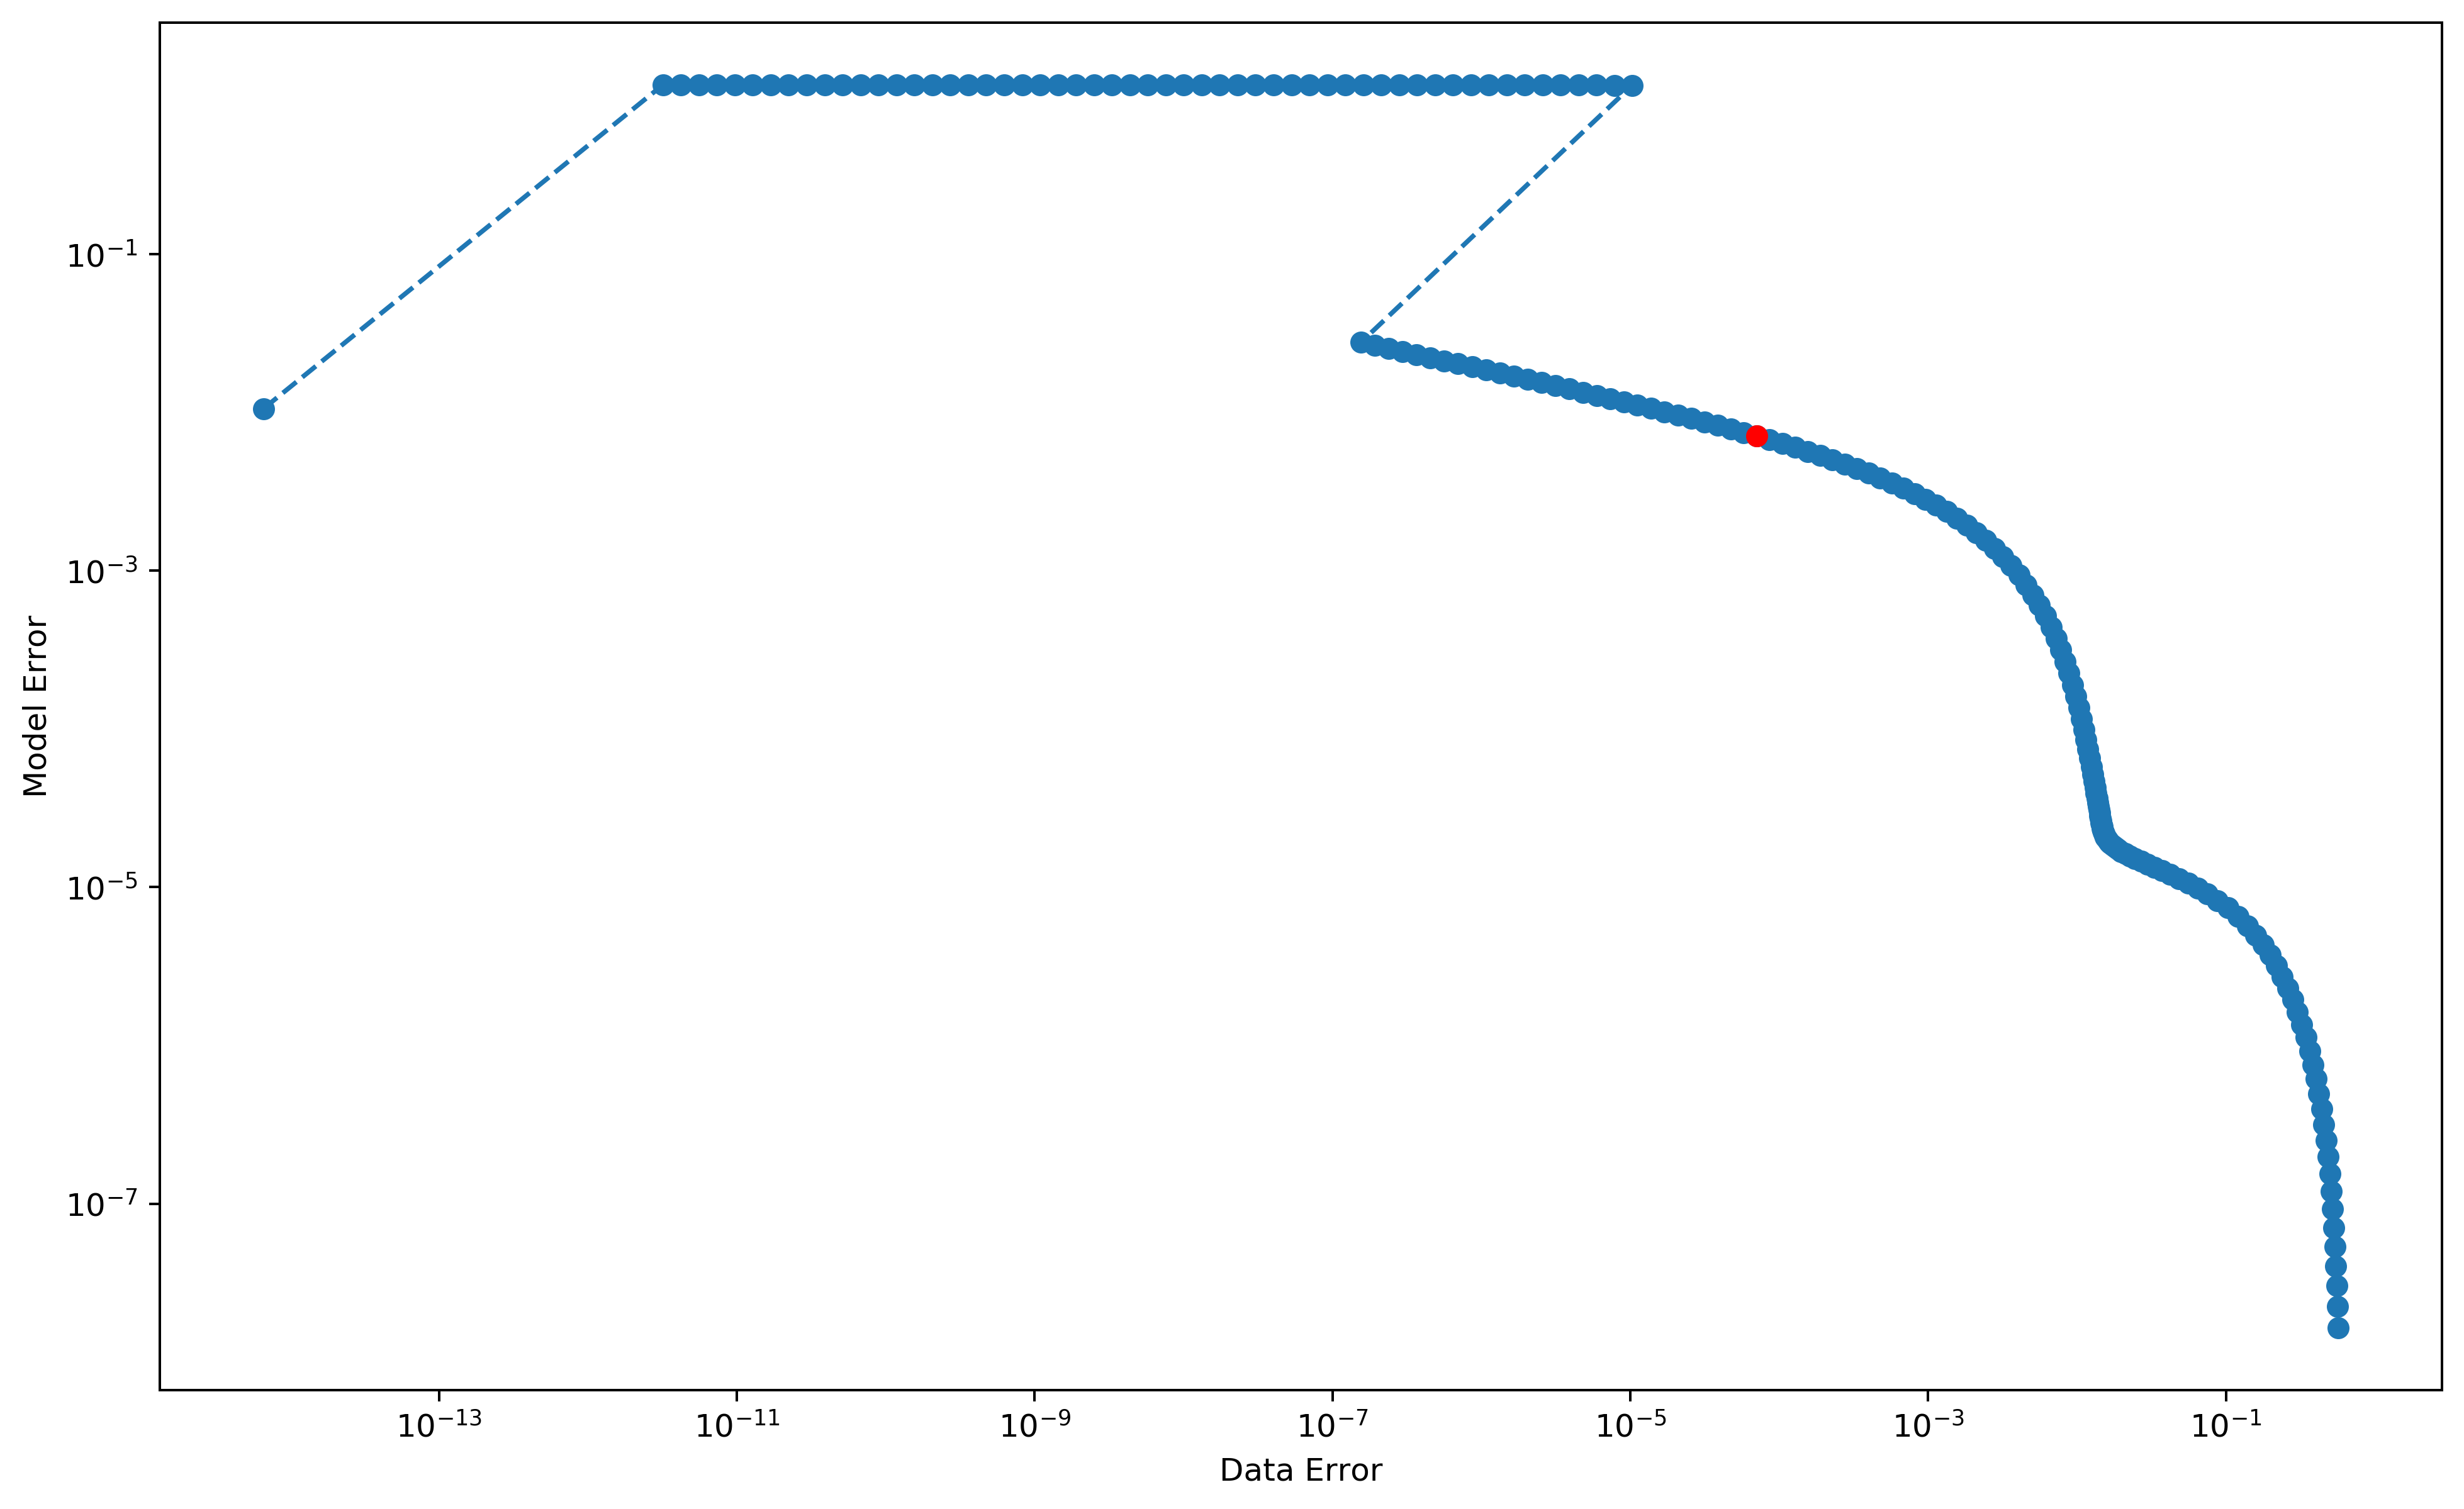

In [41]:
idx = 85
fig, ax=plt.subplots(figsize=[13, 8], dpi=360)
ax.loglog(*fsvals.T, 'o--')
ax.loglog(*fsvals[idx], 'ro')
ax.set_xlabel("Data Error")
ax.set_ylabel("Model Error")

Text(0, 0.5, 'Value of $p_1$')

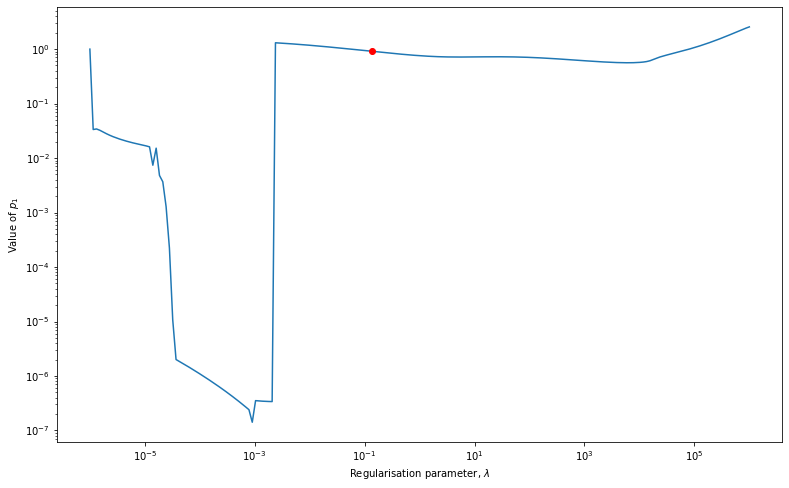

In [40]:
plt.loglog(prange, [s['x'][-2] for s in solutions])
idx= 85
plt.loglog(prange[idx], solutions[idx]['x'][-2], 'ro')
plt.xlabel(r"Regularisation parameter, $\lambda$")
plt.ylabel(r"Value of $p_1$")

Text(0, 0.5, 'Value of $p_2$')

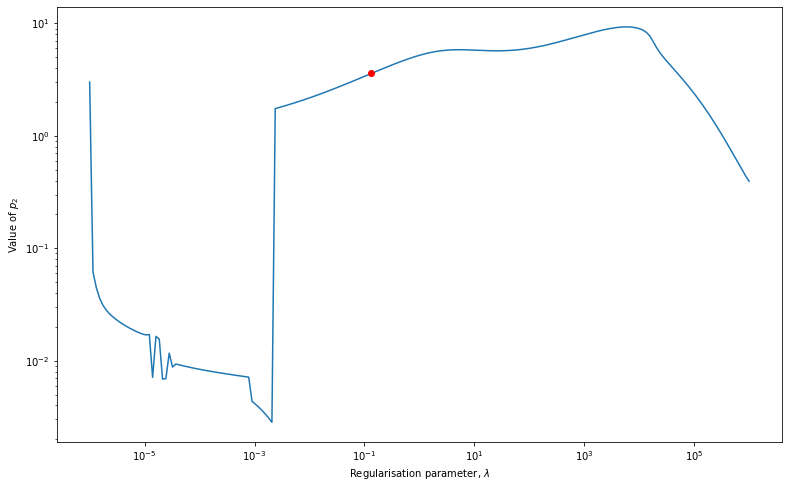

In [39]:
plt.loglog(prange, [s['x'][-1] for s in solutions])
idx= 85
plt.loglog(prange[idx], solutions[idx]['x'][-1], 'ro')
plt.xlabel(r"Regularisation parameter, $\lambda$")
plt.ylabel(r"Value of $p_2$")

errors 7.065e-05 0.00709534
p: (DM(0.909559), DM(3.58981))


Text(0, 0.5, '$x_1$')

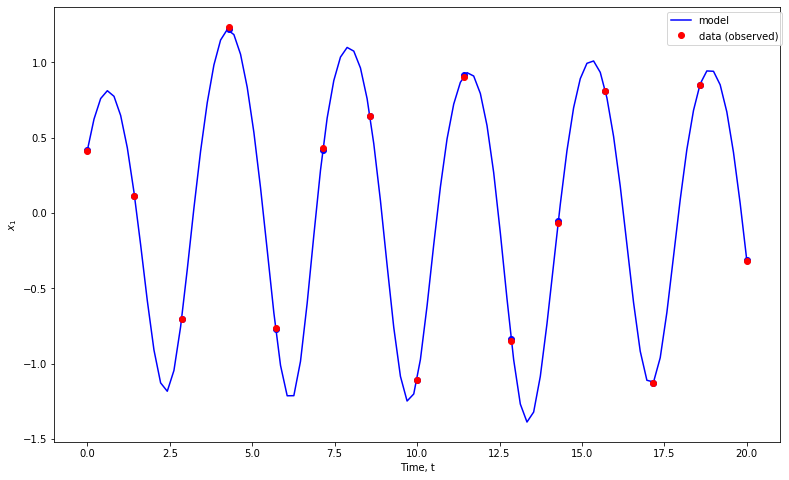

In [38]:
idx = 85
print("errors", f1_ex(solutions[idx]['x']), f2_ex(solutions[idx]['x']))
print("p:", getp(solutions[idx]['x']))
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], 'b-', label='model')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'bo')#, label='model (collocation)')
plt.plot(neat_ts, data.T, 'ro', label='data (observed)')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("Time, t")
plt.ylabel("$x_1$")

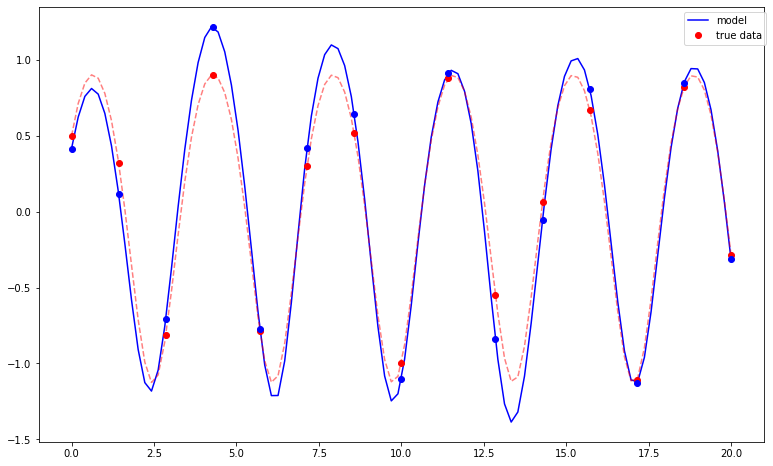

In [37]:
idx = 85
plt.plot(model.observation_times, getx(solutions[idx]['x'])[0], 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[0], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[0].T, 'ro', label='true data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[0]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

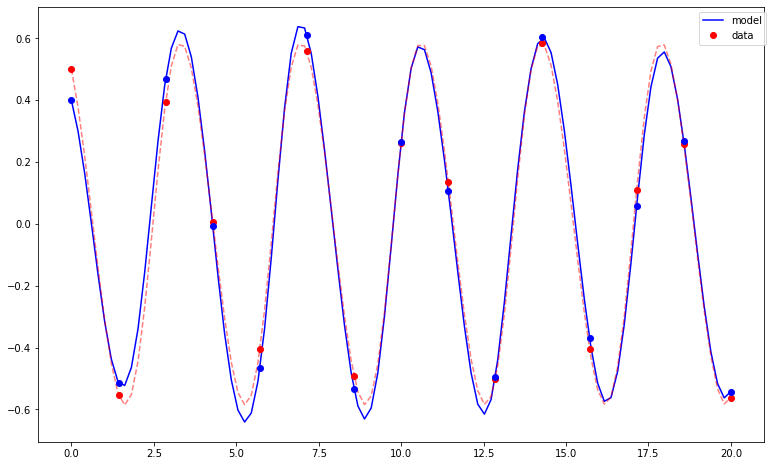

In [36]:
idx = 85
plt.plot(model.observation_times, getx(solutions[idx]['x'])[1], 'b-', label='model')
plt.plot(model.observation_times, sol.sol(model.observation_times)[1], 'r--', alpha=0.5)
plt.plot(neat_ts, sol.sol(neat_ts)[1].T, 'ro', label='data')
plt.plot(neat_ts, (objective.collocation_matrices@np.array(getc(solutions[idx]['x'])[1]).flatten()).T, 'bo')
plt.legend(loc="best", bbox_to_anchor=(1.01, 1))

Text(0, 0.5, '$|| y-c\\Phi ||$')

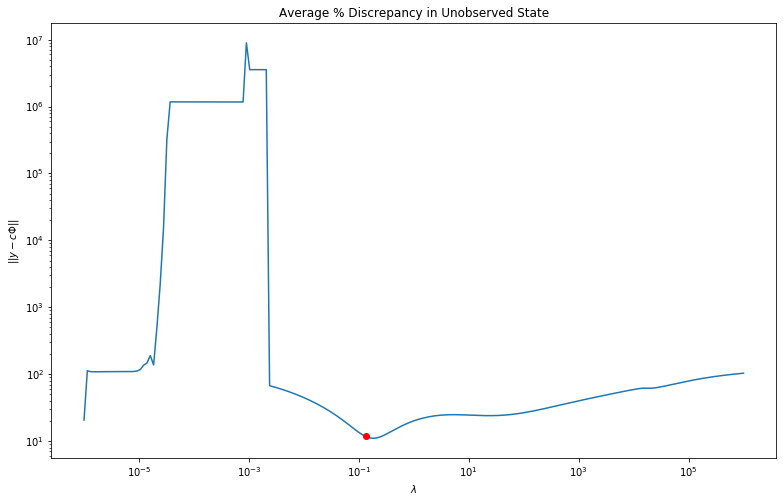

In [35]:
cvfn = lambda idx : np.sqrt(np.sum(((np.array(getx(solutions[idx]['x'])[1]).flatten()) - sol.sol(model.observation_times)[1])**2)/len(model.observation_times))
validation = [100*cvfn(i)/np.mean(np.abs(sol.sol(model.observation_times)[1])) for i in range(200)]
idx = 85
plt.loglog(prange, validation)
plt.loglog(prange[idx], validation[idx], 'ro')
plt.title("Average % Discrepancy in Unobserved State")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|| y-c\Phi ||$")

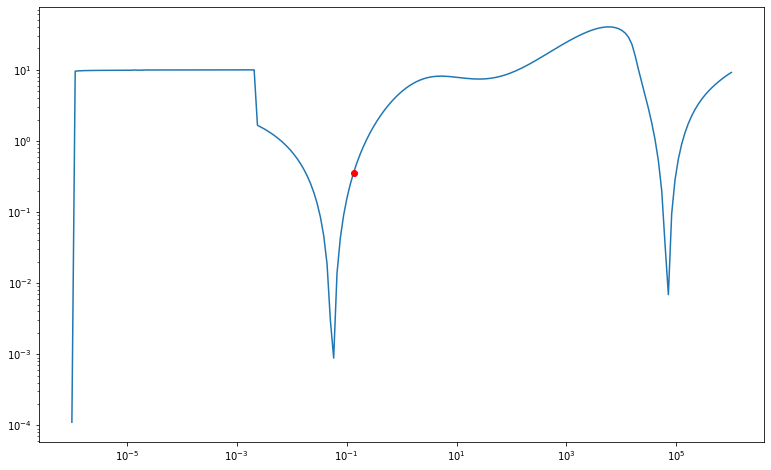

In [42]:
pwrongness = lambda idx: np.sum((np.array(p_true) - np.array(getp(solutions[idx]['x'])))**2)
perr = [pwrongness(i) for i in range(200)]
plt.loglog(prange, perr)
idx = 85
plt.loglog(prange[idx], perr[idx], 'ro')

In [22]:
# backprop

idx0 = 199

prangebp = np.logspace(np.log10(prange[idx0]), -6, num=idx0+1)
solutionsbp = []
xguess = np.array(solutions[idx0]['x']).flatten()
for p in prangebp:
#     solutionsbp.append(solver(x0=xguess, p=[p, p**(2/7)/(10**(26/7))], lbx=lbx))
    solutionsbp.append(solver(x0=xguess, p=[p, (np.log10(p)+6)*1e-5], lbx=lbx))
    xguess = np.array(solutionsbp[-1]['x']).flatten()


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  19  5.8193447e-01 0.00e+00 1.89e-01  -3.8 1.13e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.8193308e-01 0.00e+00 3.27e-01  -3.8 1.03e-02    -  1.00e+00 5.00e-01f  2
  21  5.8193067e-01 0.00e+00 6.95e-03  -3.8 9.94e-04  -0.5 1.00e+00 1.00e+00f  1
  22  5.8192996e-01 0.00e+00 1.89e-01  -3.8 3.14e-02    -  1.00e+00 2.50e-01f  3
  23  5.8192808e-01 0.00e+00 4.48e-02  -3.8 3.18e-03    -  1.00e+00 1.00e+00f  1
  24  5.8192799e-01 0.00e+00 2.00e-01  -3.8 1.23e-02    -  1.00e+00 5.00e-01f  2
  25  5.8192732e-01 0.00e+00 1.20e-01  -3.8 6.57e-03    -  1.00e+00 5.00e-01f  2
  26  5.8192693e-01 0.00e+00 1.31e-01  -3.8 3.44e-03    -  1.00e+00 1.00e+00f  1
  27  5.8192652e-01 0.00e+00 8.32e-03  -3.8 1.02e-03  -1.0 1.00e+00 1.00e+00f  1
  28  5.8192656e-01 0.00e+00 4.25e-02  -3.8 7.29e-03    -  1.00e+00 5.00e-01f  2
  29  5.8192653e-01 0.00e+00 9.21e-03  -3.8 1.51e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  24  5.7555979e-01 0.00e+00 4.90e-02  -3.8 1.79e-03  -0.5 1.00e+00 1.00e+00f  1
  25  5.7555853e-01 0.00e+00 1.12e-01  -3.8 1.95e-02    -  1.00e+00 2.50e-01f  3
  26  5.7555712e-01 0.00e+00 1.54e-01  -3.8 4.23e-03    -  1.00e+00 1.00e+00f  1
  27  5.7555645e-01 0.00e+00 9.92e-02  -3.8 1.00e-02    -  1.00e+00 2.50e-01f  3
  28  5.7555555e-01 0.00e+00 5.46e-02  -3.8 2.89e-03    -  1.00e+00 1.00e+00f  1
  29  5.7555533e-01 0.00e+00 8.24e-02  -3.8 4.36e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.7555496e-01 0.00e+00 1.92e-02  -3.8 1.46e-03    -  1.00e+00 1.00e+00f  1
  31  5.7555507e-01 0.00e+00 4.42e-02  -3.8 3.10e-03    -  1.00e+00 1.00e+00f  1
  32  5.7555501e-01 0.00e+00 1.73e-03  -3.8 4.26e-04    -  1.00e+00 1.00e+00f  1
  33  5.7555504e-01 0.00e+00 1.28e-03  -3.8 5.51e-04    -  1.00e+00 1.00e+00f  1
  34  5.7555500e-01 0.00e+00 3.84e-02  -5.7 2.95e-03    -  1.00e+00 1.00e+00f  1
  35  5.7555494e-01 0.00e+00

   5  5.6728558e-01 0.00e+00 1.36e+00  -3.8 1.08e-01    -  9.52e-01 1.25e-01f  4
   6  5.6721409e-01 0.00e+00 1.93e-03  -3.8 1.06e-04   1.0 1.00e+00 1.00e+00f  1
   7  5.6720023e-01 0.00e+00 1.05e+00  -3.8 9.59e-02    -  1.00e+00 1.25e-01f  4
   8  5.6715028e-01 0.00e+00 4.66e-03  -3.8 2.38e-04   0.6 1.00e+00 1.00e+00f  1
   9  5.6713648e-01 0.00e+00 8.30e-01  -3.8 8.72e-02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6709444e-01 0.00e+00 1.13e-02  -3.8 5.45e-04   0.1 1.00e+00 1.00e+00f  1
  11  5.6707965e-01 0.00e+00 2.34e-01  -3.8 1.01e-01    -  1.00e+00 6.25e-02f  5
  12  5.6705944e-01 0.00e+00 5.62e-01  -3.8 3.13e-03    -  1.00e+00 1.00e+00f  1
  13  5.6703696e-01 0.00e+00 6.79e-02  -3.8 3.24e-03  -0.4 1.00e+00 1.00e+00f  1
  14  5.6702977e-01 0.00e+00 2.34e-01  -3.8 2.13e-02    -  1.00e+00 2.50e-01f  3
  15  5.6702158e-01 0.00e+00 2.48e-01  -3.8 7.10e-03    -  1.00e+00 1.00e+00f  1
  16  5.6701481e-01 0.00e+00

  19  5.5585413e-01 0.00e+00 3.03e-01  -3.8 8.02e-03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.5584814e-01 0.00e+00 1.99e-01  -3.8 6.68e-03    -  1.00e+00 5.00e-01f  2
  21  5.5584440e-01 0.00e+00 7.61e-02  -3.8 2.43e-03    -  1.00e+00 1.00e+00f  1
  22  5.5584327e-01 0.00e+00 1.00e-01  -3.8 6.16e-03    -  1.00e+00 5.00e-01f  2
  23  5.5584214e-01 0.00e+00 3.83e-02  -3.8 2.12e-03    -  1.00e+00 1.00e+00f  1
  24  5.5584186e-01 0.00e+00 7.08e-02  -3.8 2.83e-03    -  1.00e+00 1.00e+00f  1
  25  5.5584161e-01 0.00e+00 7.18e-03  -3.8 9.23e-04    -  1.00e+00 1.00e+00f  1
  26  5.5584165e-01 0.00e+00 1.18e-02  -3.8 1.20e-03    -  1.00e+00 1.00e+00f  1
  27  5.5584166e-01 0.00e+00 1.55e-04  -3.8 1.48e-04    -  1.00e+00 1.00e+00f  1
  28  5.5584161e-01 0.00e+00 1.29e-02  -5.7 1.31e-03    -  1.00e+00 1.00e+00f  1
  29  5.5584160e-01 0.00e+00 2.66e-07  -5.7 5.79e-06    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  11  5.4186370e-01 0.00e+00 4.26e-01  -3.8 6.60e-02    -  1.00e+00 1.25e-01f  4
  12  5.4183546e-01 0.00e+00 2.34e-01  -3.8 3.90e-03    -  1.00e+00 1.00e+00f  1
  13  5.4182186e-01 0.00e+00 2.43e-01  -3.8 4.65e-02    -  1.00e+00 1.25e-01f  4
  14  5.4180567e-01 0.00e+00 3.97e-01  -3.8 7.94e-03    -  1.00e+00 1.00e+00f  1
  15  5.4179007e-01 0.00e+00 2.18e-01  -3.8 6.47e-03    -  1.00e+00 1.00e+00f  1
  16  5.4177750e-01 0.00e+00 3.04e-01  -3.8 1.90e-02    -  1.00e+00 2.50e-01f  3
  17  5.4176594e-01 0.00e+00 1.24e-01  -3.8 4.42e-03    -  1.00e+00 1.00e+00f  1
  18  5.4176240e-01 0.00e+00 4.13e-01  -3.8 8.50e-03    -  1.00e+00 1.00e+00f  1
  19  5.4175186e-01 0.00e+00 3.37e-02  -3.8 2.25e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  5.4174925e-01 0.00e+00 2.12e-01  -3.8 1.17e-02    -  1.00e+00 5.00e-01f  2
  21  5.4174569e-01 0.00e+00 4.00e-02  -3.8 2.61e-03    -  1.00e+00 1.00e+00f  1
  22  5.4174593e-01 0.00e+00

   6  5.2453167e-01 0.00e+00 7.19e-01  -2.5 3.10e-02    -  1.00e+00 2.50e-01f  3
   7  5.2449421e-01 0.00e+00 5.28e-01  -2.5 7.69e-03    -  1.00e+00 1.00e+00f  1
   8  5.2445664e-01 0.00e+00 9.07e-03  -2.5 1.10e-03   0.4 1.00e+00 1.00e+00f  1
   9  5.2444838e-01 0.00e+00 7.40e-01  -3.8 4.81e-02    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.2442039e-01 0.00e+00 5.49e-02  -3.8 1.79e-03    -  1.00e+00 1.00e+00f  1
  11  5.2441183e-01 0.00e+00 2.54e-01  -3.8 2.80e-02    -  1.00e+00 2.50e-01f  3
  12  5.2440253e-01 0.00e+00 2.45e-01  -3.8 7.16e-03    -  1.00e+00 1.00e+00f  1
  13  5.2439581e-01 0.00e+00 1.89e-01  -3.8 6.17e-03    -  1.00e+00 1.00e+00f  1
  14  5.2439121e-01 0.00e+00 1.57e-01  -3.8 5.75e-03    -  1.00e+00 1.00e+00f  1
  15  5.2438847e-01 0.00e+00 1.35e-01  -3.8 5.17e-03    -  1.00e+00 1.00e+00f  1
  16  5.2438665e-01 0.00e+00 6.42e-02  -3.8 3.69e-03    -  1.00e+00 1.00e+00f  1
  17  5.2438606e-01 0.00e+00

   3  5.0394366e-01 0.00e+00 6.95e-01  -2.5 1.15e-01    -  9.54e-01 1.25e-01f  4
   4  5.0384565e-01 0.00e+00 4.29e-01  -2.5 1.65e-02    -  1.00e+00 5.00e-01f  2
   5  5.0382398e-01 0.00e+00 3.35e-03  -2.5 1.01e-04   1.5 1.00e+00 1.00e+00f  1
   6  5.0377981e-01 0.00e+00 7.94e-01  -3.8 1.13e-01    -  9.82e-01 1.25e-01f  4
   7  5.0373871e-01 0.00e+00 5.00e-01  -3.8 1.19e-02    -  1.00e+00 1.00e+00f  1
   8  5.0370615e-01 0.00e+00 2.82e-03  -3.8 2.37e-04   1.0 1.00e+00 1.00e+00f  1
   9  5.0367923e-01 0.00e+00 5.03e-01  -3.8 8.74e-02    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0364896e-01 0.00e+00 4.31e-01  -3.8 9.63e-03    -  1.00e+00 1.00e+00f  1
  11  5.0363494e-01 0.00e+00 7.09e-01  -3.8 1.39e-02    -  1.00e+00 1.00e+00f  1
  12  5.0361257e-01 0.00e+00 4.62e-01  -3.8 9.46e-03    -  1.00e+00 1.00e+00f  1
  13  5.0360950e-01 0.00e+00 7.84e-01  -3.8 9.43e-02    -  1.00e+00 1.25e-01f  4
  14  5.0357679e-01 0.00e+00

   3  4.7971698e-01 0.00e+00 3.15e+00  -2.5 1.33e-01    -  9.57e-01 2.50e-01f  3
   4  4.7967617e-01 0.00e+00 1.03e+00  -2.5 4.42e-02    -  1.00e+00 2.50e-01f  3
   5  4.7948191e-01 0.00e+00 3.92e-03  -2.5 1.14e-04   1.5 1.00e+00 1.00e+00f  1
   6  4.7942930e-01 0.00e+00 6.78e-01  -3.8 1.09e-01    -  9.97e-01 1.25e-01f  4
   7  4.7935781e-01 0.00e+00 5.86e-01  -3.8 9.01e-03    -  1.00e+00 1.00e+00f  1
   8  4.7934080e-01 0.00e+00 1.45e+00  -3.8 1.70e-01    -  1.00e+00 1.25e-01f  4
   9  4.7928041e-01 0.00e+00 1.87e-01  -3.8 1.07e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.7927229e-01 0.00e+00 2.21e-03  -3.8 1.90e-04   1.0 1.00e+00 1.00e+00f  1
  11  4.7926275e-01 0.00e+00 1.04e+00  -3.8 6.74e-02    -  1.00e+00 2.50e-01f  3
  12  4.7923255e-01 0.00e+00 5.33e-02  -3.8 2.46e-03    -  1.00e+00 1.00e+00f  1
  13  4.7922234e-01 0.00e+00 5.95e-01  -3.8 1.11e-01    -  1.00e+00 1.25e-01f  4
  14  4.7920886e-01 0.00e+00

   4  4.5170160e-01 0.00e+00 1.79e+00  -2.5 3.78e-02    -  1.00e+00 2.50e-01f  3
   5  4.5157577e-01 0.00e+00 6.42e-01  -2.5 1.43e-02    -  1.00e+00 1.00e+00f  1
   6  4.5157862e-01 0.00e+00 1.36e+00  -2.5 9.09e-02    -  1.00e+00 2.50e-01f  3
   7  4.5150657e-01 0.00e+00 1.30e+00  -2.5 2.83e-02    -  1.00e+00 5.00e-01f  2
   8  4.5145562e-01 0.00e+00 2.97e-01  -2.5 1.06e-02    -  1.00e+00 1.00e+00f  1
   9  4.5144300e-01 0.00e+00 8.92e-01  -2.5 3.25e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5141921e-01 0.00e+00 3.05e-01  -2.5 1.12e-02    -  1.00e+00 1.00e+00f  1
  11  4.5141106e-01 0.00e+00 5.24e-01  -2.5 2.23e-02    -  1.00e+00 5.00e-01f  2
  12  4.5140115e-01 0.00e+00 3.71e-01  -2.5 1.17e-02    -  1.00e+00 1.00e+00f  1
  13  4.5139708e-01 0.00e+00 4.30e-01  -2.5 1.23e-02    -  1.00e+00 1.00e+00f  1
  14  4.5139321e-01 0.00e+00 1.89e-01  -2.5 8.34e-03    -  1.00e+00 1.00e+00f  1
  15  4.5139543e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.2183225e-01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.2155039e-01 0.00e+00 2.40e+00  -1.0 5.46e-02    -  1.00e+00 5.00e-01f  2
   2  4.2171564e-01 0.00e+00 6.19e+00  -1.0 4.76e-02   0.0 1.00e+00 1.00e+00f  1
   3  4.2204922e-01 0.00e+00 3.49e+00  -1.0 4.48e-02  -0.5 1.00e+00 1.00e+00f  1
   4  4.2064936e-01 0.00e+00 2.72e-02  -1.0 2.95e-03   0.9 1.00e+00 1.00e+00f  1
   5  4.2059185e-01 0.00e+00 1.09e+00  -2.5 8.85e-02    -  9.94e-01 2.50e-01f  3
   6  4.2051711e-01 0.00e+00 2.51e-01  -2.5 7.76e-03    -  1.00e+00 1.00e+00f  1
   7  4.2049876e-01 0.00e+00 6.55e-01  -2.5 6.37e-02    -  1.00e+00 2.50e-01f  3
   8  4.2047805e-01 0.00e+00 7.03e-01  -2.5 2.05e-02    -  1.00e+00 1.00e+00f  1
   9  4.2046472e-01 0.00e+00 5.42e-01  -2.5 1.43e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2045639e-01 0.00e+00

   8  3.8685669e-01 0.00e+00 2.36e-02  -2.5 2.95e-03  -0.5 1.00e+00 1.00e+00f  1
   9  3.8685351e-01 0.00e+00 3.15e-01  -3.8 2.45e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8685104e-01 0.00e+00 5.11e-02  -3.8 4.83e-03    -  1.00e+00 1.00e+00f  1
  11  3.8685056e-01 0.00e+00 1.69e-01  -3.8 9.45e-03    -  1.00e+00 1.00e+00f  1
  12  3.8685020e-01 0.00e+00 5.19e-03  -3.8 1.66e-03    -  1.00e+00 1.00e+00f  1
  13  3.8685021e-01 0.00e+00 7.45e-03  -3.8 1.97e-03    -  1.00e+00 1.00e+00f  1
  14  3.8685021e-01 0.00e+00 1.03e-05  -3.8 7.40e-05    -  1.00e+00 1.00e+00f  1
  15  3.8685019e-01 0.00e+00 5.81e-03  -5.7 1.79e-03    -  1.00e+00 1.00e+00f  1
  16  3.8685019e-01 0.00e+00 6.28e-10  -5.7 4.60e-07    -  1.00e+00 1.00e+00f  1
  17  3.8685019e-01 0.00e+00 8.96e-07  -8.6 2.22e-05    -  1.00e+00 1.00e+00f  1
  18  3.8685019e-01 0.00e+00 1.60e-12  -8.6 9.32e-11    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   3  3.5162247e-01 0.00e+00 4.01e+00  -1.7 1.45e-01    -  1.00e+00 5.00e-01f  2
   4  3.5135973e-01 0.00e+00 1.96e-01  -1.7 2.34e-02    -  1.00e+00 1.00e+00f  1
   5  3.5133672e-01 0.00e+00 7.39e-02  -2.5 6.00e-03  -0.5 1.00e+00 1.00e+00f  1
   6  3.5131836e-01 0.00e+00 1.26e+00  -2.5 1.12e-01    -  1.00e+00 2.50e-01f  3
   7  3.5128497e-01 0.00e+00 3.90e-01  -2.5 1.73e-02    -  1.00e+00 1.00e+00f  1
   8  3.5127352e-01 0.00e+00 8.16e-01  -2.5 3.92e-02    -  1.00e+00 5.00e-01f  2
   9  3.5125699e-01 0.00e+00 4.65e-01  -2.5 1.75e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5125144e-01 0.00e+00 8.52e-01  -2.5 2.34e-02    -  1.00e+00 1.00e+00f  1
  11  3.5124032e-01 0.00e+00 1.85e-01  -2.5 1.10e-02    -  1.00e+00 1.00e+00f  1
  12  3.5123887e-01 0.00e+00 4.27e-01  -2.5 2.93e-02    -  1.00e+00 5.00e-01f  2
  13  3.5123657e-01 0.00e+00 2.72e-01  -2.5 1.33e-02    -  1.00e+00 1.00e+00f  1
  14  3.5123729e-01 0.00e+00

  11  3.1436550e-01 0.00e+00 5.47e-01  -2.5 2.10e-02    -  1.00e+00 1.00e+00f  1
  12  3.1435873e-01 0.00e+00 5.20e-01  -2.5 2.06e-02    -  1.00e+00 1.00e+00f  1
  13  3.1435386e-01 0.00e+00 3.94e-01  -2.5 1.79e-02    -  1.00e+00 1.00e+00f  1
  14  3.1435212e-01 0.00e+00 4.22e-01  -2.5 1.85e-02    -  1.00e+00 1.00e+00f  1
  15  3.1435063e-01 0.00e+00 2.35e-01  -2.5 1.39e-02    -  1.00e+00 1.00e+00f  1
  16  3.1435244e-01 0.00e+00 3.58e-01  -2.5 1.71e-02    -  1.00e+00 1.00e+00f  1
  17  3.1435240e-01 0.00e+00 9.31e-02  -2.5 8.77e-03    -  1.00e+00 1.00e+00f  1
  18  3.1435627e-01 0.00e+00 3.02e-01  -2.5 1.58e-02    -  1.00e+00 1.00e+00f  1
  19  3.1435626e-01 0.00e+00 1.62e-02  -2.5 3.68e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.1435453e-01 0.00e+00 5.02e-01  -3.8 4.15e-02    -  1.00e+00 5.00e-01f  2
  21  3.1435137e-01 0.00e+00 2.69e-02  -3.8 5.22e-03    -  1.00e+00 1.00e+00f  1
  22  3.1435057e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7820688e-01 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.7757758e-01 0.00e+00 2.07e+00  -1.0 5.64e-02    -  9.99e-01 5.00e-01f  2
   2  2.7741390e-01 0.00e+00 8.79e-02  -1.0 1.12e-02   0.0 1.00e+00 1.00e+00f  1
   3  2.7729133e-01 0.00e+00 1.51e+00  -2.5 2.01e-01    -  9.86e-01 2.50e-01f  3
   4  2.7721773e-01 0.00e+00 7.64e-01  -2.5 6.16e-02    -  1.00e+00 1.00e+00f  1
   5  2.7712143e-01 0.00e+00 4.82e-02  -2.5 5.44e-03  -0.5 1.00e+00 1.00e+00f  1
   6  2.7710073e-01 0.00e+00 7.46e-01  -2.5 2.10e-01    -  1.00e+00 1.25e-01f  4
   7  2.7707613e-01 0.00e+00 1.15e+00  -2.5 3.05e-02    -  1.00e+00 1.00e+00f  1
   8  2.7704820e-01 0.00e+00 4.42e-01  -2.5 2.28e-02    -  1.00e+00 1.00e+00f  1
   9  2.7703630e-01 0.00e+00 8.02e-01  -2.5 4.85e-02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7701936e-01 0.00e+00

  33  2.5853502e-01 0.00e+00 1.11e+00  -2.5 8.91e-02    -  1.00e+00 5.00e-01f  2
  34  2.5851600e-01 0.00e+00 9.97e-02  -2.5 1.84e-02    -  1.00e+00 1.00e+00f  1
  35  2.5850452e-01 0.00e+00 8.58e-01  -2.5 1.35e-01    -  1.00e+00 2.50e-01f  3
  36  2.5849174e-01 0.00e+00 1.40e-01  -2.5 1.37e-02    -  1.00e+00 1.00e+00f  1
  37  2.5848199e-01 0.00e+00 1.00e+00  -2.5 7.41e-02    -  1.00e+00 5.00e-01f  2
  38  2.5846856e-01 0.00e+00 8.14e-02  -2.5 1.08e-02    -  1.00e+00 1.00e+00f  1
  39  2.5845882e-01 0.00e+00 5.15e-01  -2.5 1.03e-01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.5844866e-01 0.00e+00 2.42e-01  -2.5 1.87e-02    -  1.00e+00 1.00e+00f  1
  41  2.5843922e-01 0.00e+00 8.83e-01  -2.5 3.56e-02    -  1.00e+00 1.00e+00f  1
  42  2.5842875e-01 0.00e+00 6.15e-02  -2.5 9.26e-03    -  1.00e+00 1.00e+00f  1
  43  2.5842069e-01 0.00e+00 4.19e-01  -2.5 9.23e-02    -  1.00e+00 2.50e-01f  3
  44  2.5841285e-01 0.00e+00

  35  2.3986120e-01 0.00e+00 5.67e-01  -2.5 5.99e-02    -  1.00e+00 5.00e-01f  2
  36  2.3985954e-01 0.00e+00 4.00e-02  -2.5 8.30e-03    -  1.00e+00 1.00e+00f  1
  37  2.3986192e-01 0.00e+00 2.05e-01  -2.5 6.88e-02    -  1.00e+00 2.50e-01f  3
  38  2.3986424e-01 0.00e+00 1.95e-01  -2.5 1.82e-02    -  1.00e+00 1.00e+00f  1
  39  2.3986647e-01 0.00e+00 1.67e-01  -2.5 1.69e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.3986898e-01 0.00e+00 1.71e-01  -2.5 1.71e-02    -  1.00e+00 1.00e+00f  1
  41  2.3987109e-01 0.00e+00 1.23e-01  -2.5 1.45e-02    -  1.00e+00 1.00e+00f  1
  42  2.3987388e-01 0.00e+00 1.64e-01  -2.5 1.68e-02    -  1.00e+00 1.00e+00f  1
  43  2.3987554e-01 0.00e+00 6.94e-02  -2.5 1.10e-02    -  1.00e+00 1.00e+00f  1
  44  2.3987913e-01 0.00e+00 2.07e-01  -2.5 1.89e-02    -  1.00e+00 1.00e+00f  1
  45  2.3987982e-01 0.00e+00 1.87e-02  -2.5 5.73e-03    -  1.00e+00 1.00e+00f  1
  46  2.3987655e-01 0.00e+00

  46  2.2176945e-01 0.00e+00 4.03e-01  -3.8 2.35e-01    -  1.00e+00 1.25e-01f  4
  47  2.2176493e-01 0.00e+00 2.82e-01  -3.8 2.61e-02    -  1.00e+00 1.00e+00f  1
  48  2.2176155e-01 0.00e+00 4.76e-01  -3.8 3.19e-02    -  1.00e+00 1.00e+00f  1
  49  2.2175771e-01 0.00e+00 1.42e-01  -3.8 1.74e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.2175552e-01 0.00e+00 3.40e-01  -3.8 4.80e-02    -  1.00e+00 5.00e-01f  2
  51  2.2175265e-01 0.00e+00 1.93e-01  -3.8 2.02e-02    -  1.00e+00 1.00e+00f  1
  52  2.2175077e-01 0.00e+00 4.45e-01  -3.8 3.07e-02    -  1.00e+00 1.00e+00f  1
  53  2.2174816e-01 0.00e+00 7.22e-02  -3.8 1.23e-02    -  1.00e+00 1.00e+00f  1
  54  2.2174697e-01 0.00e+00 3.72e-01  -3.8 5.32e-02    -  1.00e+00 5.00e-01f  2
  55  2.2174508e-01 0.00e+00 6.27e-02  -3.8 1.14e-02    -  1.00e+00 1.00e+00f  1
  56  2.2174412e-01 0.00e+00 2.78e-01  -3.8 4.55e-02    -  1.00e+00 5.00e-01f  2
  57  2.2174287e-01 0.00e+00

  45  2.0430234e-01 0.00e+00 7.59e-03  -3.8 4.25e-03    -  1.00e+00 1.00e+00f  1
  46  2.0430215e-01 0.00e+00 5.24e-02  -3.8 2.17e-02    -  1.00e+00 5.00e-01f  2
  47  2.0430203e-01 0.00e+00 1.74e-02  -3.8 6.48e-03    -  1.00e+00 1.00e+00f  1
  48  2.0430196e-01 0.00e+00 1.41e-02  -3.8 5.83e-03    -  1.00e+00 1.00e+00f  1
  49  2.0430194e-01 0.00e+00 1.40e-03  -3.8 1.84e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.0430188e-01 0.00e+00 3.31e-02  -5.7 1.78e-02    -  1.00e+00 5.00e-01f  2
  51  2.0430185e-01 0.00e+00 1.13e-02  -5.7 5.26e-03    -  1.00e+00 1.00e+00f  1
  52  2.0430185e-01 0.00e+00 4.55e-03  -5.7 3.31e-03    -  1.00e+00 1.00e+00f  1
  53  2.0430185e-01 0.00e+00 2.81e-04  -5.7 8.22e-04    -  1.00e+00 1.00e+00f  1
  54  2.0430185e-01 0.00e+00 3.44e-06  -5.7 9.09e-05    -  1.00e+00 1.00e+00f  1
  55  2.0430185e-01 0.00e+00 2.00e-05  -8.6 2.20e-04    -  1.00e+00 1.00e+00f  1
  56  2.0430185e-01 0.00e+00

   1  1.7250890e-01 0.00e+00 4.52e+00  -1.0 5.18e-02    -  9.96e-01 1.00e+00f  1
   2  1.7222056e-01 0.00e+00 1.57e-02  -1.0 6.26e-03   0.0 1.00e+00 1.00e+00f  1
   3  1.7219561e-01 0.00e+00 6.41e-01  -2.5 1.93e-01    -  1.00e+00 2.50e-01f  3
   4  1.7215894e-01 0.00e+00 2.98e-01  -2.5 3.04e-02    -  1.00e+00 1.00e+00f  1
   5  1.7215845e-01 0.00e+00 6.38e-01  -2.5 7.75e-02    -  1.00e+00 5.00e-01f  2
   6  1.7215451e-01 0.00e+00 2.84e-01  -2.5 3.00e-02    -  1.00e+00 1.00e+00f  1
   7  1.7216011e-01 0.00e+00 9.36e-01  -2.5 5.35e-02    -  1.00e+00 1.00e+00f  1
   8  1.7215325e-01 0.00e+00 7.53e-02  -2.5 1.54e-02    -  1.00e+00 1.00e+00f  1
   9  1.7215437e-01 0.00e+00 2.86e-01  -2.5 1.06e-01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7215673e-01 0.00e+00 4.46e-01  -2.5 3.72e-02    -  1.00e+00 1.00e+00f  1
  11  1.7215651e-01 0.00e+00 1.45e-01  -2.5 2.13e-02    -  1.00e+00 1.00e+00f  1
  12  1.7216377e-01 0.00e+00

   1  1.3177066e-01 0.00e+00 2.35e+00  -1.0 5.05e-02    -  9.95e-01 1.00e+00f  1
   2  1.3166533e-01 0.00e+00 8.51e-03  -1.0 5.55e-03   0.0 1.00e+00 1.00e+00f  1
   3  1.3163717e-01 0.00e+00 7.01e-01  -2.5 1.15e-01    -  1.00e+00 5.00e-01f  2
   4  1.3161885e-01 0.00e+00 3.20e-02  -2.5 1.05e-02    -  1.00e+00 1.00e+00f  1
   5  1.3162091e-01 0.00e+00 2.27e-01  -2.5 1.18e-01    -  1.00e+00 2.50e-01f  3
   6  1.3162350e-01 0.00e+00 2.48e-01  -2.5 3.31e-02    -  1.00e+00 1.00e+00f  1
   7  1.3162516e-01 0.00e+00 1.20e-01  -2.5 2.26e-02    -  1.00e+00 1.00e+00f  1
   8  1.3162858e-01 0.00e+00 1.96e-01  -2.5 2.89e-02    -  1.00e+00 1.00e+00f  1
   9  1.3162984e-01 0.00e+00 3.93e-02  -2.5 1.30e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.3163301e-01 0.00e+00 1.19e-01  -2.5 2.25e-02    -  1.00e+00 1.00e+00f  1
  11  1.3163356e-01 0.00e+00 5.00e-03  -2.5 4.67e-03    -  1.00e+00 1.00e+00f  1
  12  1.3163012e-01 0.00e+00

   7  1.0970708e-01 0.00e+00 1.29e-01  -3.8 2.57e-02    -  1.00e+00 1.00e+00f  1
   8  1.0970619e-01 0.00e+00 7.48e-02  -3.8 1.95e-02    -  1.00e+00 1.00e+00f  1
   9  1.0970574e-01 0.00e+00 5.36e-02  -3.8 1.65e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0970555e-01 0.00e+00 1.74e-02  -3.8 9.38e-03    -  1.00e+00 1.00e+00f  1
  11  1.0970549e-01 0.00e+00 5.52e-03  -3.8 5.29e-03    -  1.00e+00 1.00e+00f  1
  12  1.0970548e-01 0.00e+00 2.41e-04  -3.8 1.10e-03    -  1.00e+00 1.00e+00f  1
  13  1.0970544e-01 0.00e+00 2.43e-02  -5.7 1.12e-02    -  1.00e+00 1.00e+00f  1
  14  1.0970544e-01 0.00e+00 1.11e-07  -5.7 1.94e-05    -  1.00e+00 1.00e+00f  1
  15  1.0970544e-01 0.00e+00 4.10e-06  -8.6 1.45e-04    -  1.00e+00 1.00e+00f  1
  16  1.0970544e-01 0.00e+00 6.44e-13  -8.6 1.25e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objecti

  28  9.1536411e-02 0.00e+00 1.21e-01  -3.8 2.74e-02    -  1.00e+00 1.00e+00f  1
  29  9.1535007e-02 0.00e+00 1.26e-01  -3.8 2.79e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.1534233e-02 0.00e+00 4.42e-02  -3.8 1.65e-02    -  1.00e+00 1.00e+00f  1
  31  9.1533865e-02 0.00e+00 4.71e-02  -3.8 1.70e-02    -  1.00e+00 1.00e+00f  1
  32  9.1533754e-02 0.00e+00 5.82e-03  -3.8 5.96e-03    -  1.00e+00 1.00e+00f  1
  33  9.1533721e-02 0.00e+00 1.84e-03  -3.8 3.35e-03    -  1.00e+00 1.00e+00f  1
  34  9.1533719e-02 0.00e+00 9.70e-06  -3.8 2.43e-04    -  1.00e+00 1.00e+00f  1
  35  9.1533679e-02 0.00e+00 1.89e-02  -5.7 1.08e-02    -  1.00e+00 1.00e+00f  1
  36  9.1533673e-02 0.00e+00 1.71e-08  -5.7 5.95e-06    -  1.00e+00 1.00e+00f  1
  37  9.1533673e-02 0.00e+00 2.87e-06  -8.6 1.34e-04    -  1.00e+00 1.00e+00f  1
  38  9.1533673e-02 0.00e+00 3.01e-12  -8.6 1.23e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3

  16  7.6700887e-02 0.00e+00 1.39e-01  -2.5 3.28e-02    -  1.00e+00 1.00e+00f  1
  17  7.6692079e-02 0.00e+00 2.29e-01  -2.5 4.21e-02    -  1.00e+00 1.00e+00f  1
  18  7.6687340e-02 0.00e+00 4.70e-02  -2.5 1.90e-02    -  1.00e+00 1.00e+00f  1
  19  7.6681317e-02 0.00e+00 1.63e-01  -2.5 3.54e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.6679697e-02 0.00e+00 6.21e-03  -2.5 6.82e-03    -  1.00e+00 1.00e+00f  1
  21  7.6674290e-02 0.00e+00 3.19e-01  -3.8 1.99e-01    -  1.00e+00 2.50e-01f  3
  22  7.6668925e-02 0.00e+00 1.29e-01  -3.8 3.21e-02    -  1.00e+00 1.00e+00f  1
  23  7.6666179e-02 0.00e+00 3.15e-01  -3.8 4.88e-02    -  1.00e+00 1.00e+00f  1
  24  7.6663314e-02 0.00e+00 3.33e-02  -3.8 1.57e-02    -  1.00e+00 1.00e+00f  1
  25  7.6662895e-02 0.00e+00 2.78e-01  -3.8 4.57e-02    -  1.00e+00 1.00e+00f  1
  26  7.6661334e-02 0.00e+00 2.41e-03  -3.8 4.12e-03    -  1.00e+00 1.00e+00f  1
  27  7.6661134e-02 0.00e+00

  15  6.4661449e-02 0.00e+00 1.25e-01  -2.5 3.43e-02    -  1.00e+00 1.00e+00f  1
  16  6.4649464e-02 0.00e+00 3.69e-01  -2.5 5.91e-02    -  1.00e+00 1.00e+00f  1
  17  6.4642600e-02 0.00e+00 2.92e-02  -2.5 1.64e-02    -  1.00e+00 1.00e+00f  1
  18  6.4636599e-02 0.00e+00 1.11e-01  -2.5 6.03e-02    -  1.00e+00 5.00e-01f  2
  19  6.4632365e-02 0.00e+00 4.78e-02  -2.5 2.11e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.4628929e-02 0.00e+00 4.12e-02  -2.5 1.96e-02    -  1.00e+00 1.00e+00f  1
  21  6.4627539e-02 0.00e+00 7.31e-03  -2.5 8.21e-03    -  1.00e+00 1.00e+00f  1
  22  6.4622109e-02 0.00e+00 2.36e-01  -3.8 1.87e-01    -  1.00e+00 2.50e-01f  3
  23  6.4617014e-02 0.00e+00 1.47e-01  -3.8 3.76e-02    -  1.00e+00 1.00e+00f  1
  24  6.4613841e-02 0.00e+00 1.72e-01  -3.8 3.96e-02    -  1.00e+00 1.00e+00f  1
  25  6.4611772e-02 0.00e+00 6.10e-02  -3.8 2.35e-02    -  1.00e+00 1.00e+00f  1
  26  6.4610710e-02 0.00e+00

   8  5.0821174e-02 0.00e+00 8.48e-02  -3.8 6.19e-02    -  1.00e+00 5.00e-01f  2
   9  5.0820295e-02 0.00e+00 2.73e-02  -3.8 1.81e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0819928e-02 0.00e+00 2.34e-02  -3.8 1.68e-02    -  1.00e+00 1.00e+00f  1
  11  5.0819842e-02 0.00e+00 2.25e-03  -3.8 5.19e-03    -  1.00e+00 1.00e+00f  1
  12  5.0819824e-02 0.00e+00 2.81e-04  -3.8 1.84e-03    -  1.00e+00 1.00e+00f  1
  13  5.0819776e-02 0.00e+00 1.04e-02  -5.7 1.12e-02    -  1.00e+00 1.00e+00f  1
  14  5.0819772e-02 0.00e+00 1.20e-07  -5.7 3.23e-05    -  1.00e+00 1.00e+00f  1
  15  5.0819772e-02 0.00e+00 1.72e-06  -8.6 1.45e-04    -  1.00e+00 1.00e+00f  1
  16  5.0819772e-02 0.00e+00 1.38e-12  -8.6 1.66e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   5.0819772056137601e-02    5.0819772056137601e-02
Dual infeas

  13  4.0969419e-02 0.00e+00 1.35e-08  -5.7 9.24e-06    -  1.00e+00 1.00e+00f  1
  14  4.0969419e-02 0.00e+00 1.29e-06  -8.6 1.45e-04    -  1.00e+00 1.00e+00f  1
  15  4.0969419e-02 0.00e+00 9.69e-07  -8.6 2.04e-09    -  1.00e+00 2.50e-01f  3
  16  4.0969419e-02 0.00e+00 9.67e-07  -8.6 1.53e-09    -  1.00e+00 1.95e-03f 10
  17  4.0969419e-02 0.00e+00 8.46e-07  -8.6 1.53e-09    -  1.00e+00 1.25e-01f  4
  18  4.0969419e-02 0.00e+00 2.71e-13  -8.6 1.34e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   4.0969418629313810e-02    4.0969418629313810e-02
Dual infeasibility......:   2.7136815165762393e-13    2.7136815165762393e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800618e-09    2.5059035596800618e-09
Overall NLP error.......:   2.5059035596800618e-09    2.5059035596800618e-09


Number of objective funct

   1  3.2167052e-02 0.00e+00 4.34e-02  -1.0 4.81e-02    -  9.97e-01 1.00e+00f  1
   2  3.2132395e-02 0.00e+00 7.76e-02  -2.5 4.29e-02    -  1.00e+00 1.00e+00f  1
   3  3.2132729e-02 0.00e+00 1.75e-03  -2.5 6.65e-03    -  1.00e+00 1.00e+00f  1
   4  3.2125365e-02 0.00e+00 1.19e-01  -3.8 2.22e-01    -  1.00e+00 2.50e-01f  3
   5  3.2118856e-02 0.00e+00 8.97e-02  -3.8 4.80e-02    -  1.00e+00 1.00e+00f  1
   6  3.2114832e-02 0.00e+00 7.04e-02  -3.8 4.17e-02    -  1.00e+00 1.00e+00f  1
   7  3.2112549e-02 0.00e+00 4.15e-02  -3.8 3.19e-02    -  1.00e+00 1.00e+00f  1
   8  3.2111450e-02 0.00e+00 2.71e-02  -3.8 2.57e-02    -  1.00e+00 1.00e+00f  1
   9  3.2111046e-02 0.00e+00 8.82e-03  -3.8 1.46e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2110934e-02 0.00e+00 2.20e-03  -3.8 7.31e-03    -  1.00e+00 1.00e+00f  1
  11  3.2110918e-02 0.00e+00 7.58e-05  -3.8 1.35e-03    -  1.00e+00 1.00e+00f  1
  12  3.2110856e-02 0.00e+00

   9  2.7652292e-02 0.00e+00 1.51e-03  -3.8 7.05e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.7652229e-02 0.00e+00 7.06e-04  -3.8 4.85e-03    -  1.00e+00 1.00e+00f  1
  11  2.7652157e-02 0.00e+00 5.64e-03  -5.7 1.38e-02    -  1.00e+00 1.00e+00f  1
  12  2.7652151e-02 0.00e+00 1.37e-06  -5.7 2.01e-04    -  1.00e+00 1.00e+00f  1
  13  2.7652151e-02 0.00e+00 1.22e-06  -8.6 2.02e-04    -  1.00e+00 1.00e+00f  1
  14  2.7652151e-02 0.00e+00 1.84e-13  -8.6 1.55e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   2.7652151206970680e-02    2.7652151206970680e-02
Dual infeasibility......:   1.8386471679449786e-13    1.8386471679449786e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596921411e-09    2.5059035596921411e-09
Overall NLP error......

   5  2.3587981e-02 0.00e+00 1.04e-02  -3.8 2.33e-02    -  1.00e+00 1.00e+00f  1
   6  2.3585118e-02 0.00e+00 4.02e-02  -3.8 8.61e-02    -  1.00e+00 5.00e-01f  2
   7  2.3583170e-02 0.00e+00 1.76e-02  -3.8 3.03e-02    -  1.00e+00 1.00e+00f  1
   8  2.3582346e-02 0.00e+00 1.19e-02  -3.8 2.48e-02    -  1.00e+00 1.00e+00f  1
   9  2.3582121e-02 0.00e+00 1.98e-03  -3.8 1.01e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3582072e-02 0.00e+00 2.58e-04  -3.8 3.64e-03    -  1.00e+00 1.00e+00f  1
  11  2.3581986e-02 0.00e+00 4.62e-03  -5.7 1.55e-02    -  1.00e+00 1.00e+00f  1
  12  2.3581979e-02 0.00e+00 1.89e-07  -5.7 8.48e-05    -  1.00e+00 1.00e+00f  1
  13  2.3581979e-02 0.00e+00 8.06e-07  -8.6 2.04e-04    -  1.00e+00 1.00e+00f  1
  14  2.3581979e-02 0.00e+00 3.48e-14  -8.6 4.38e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objecti

   4  2.0875591e-02 0.00e+00 1.06e-01  -3.8 1.92e-01    -  1.00e+00 5.00e-01f  2
   5  2.0866886e-02 0.00e+00 7.81e-03  -3.8 2.53e-02    -  1.00e+00 1.00e+00f  1
   6  2.0864301e-02 0.00e+00 2.41e-02  -3.8 8.23e-02    -  1.00e+00 5.00e-01f  2
   7  2.0862592e-02 0.00e+00 1.32e-02  -3.8 3.30e-02    -  1.00e+00 1.00e+00f  1
   8  2.0861968e-02 0.00e+00 5.05e-03  -3.8 2.03e-02    -  1.00e+00 1.00e+00f  1
   9  2.0861810e-02 0.00e+00 9.41e-04  -3.8 8.76e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.0861690e-02 0.00e+00 4.07e-03  -5.7 1.83e-02    -  1.00e+00 1.00e+00f  1
  11  2.0861680e-02 0.00e+00 3.98e-06  -5.7 5.44e-04    -  1.00e+00 1.00e+00f  1
  12  2.0861680e-02 0.00e+00 1.12e-06  -8.6 3.03e-04    -  1.00e+00 1.00e+00f  1
  13  2.0861680e-02 0.00e+00 2.57e-14  -8.6 3.16e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objecti

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8500193e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

   4  1.7702401e-02 0.00e+00 6.48e-02  -3.8 2.36e-01    -  1.00e+00 5.00e-01f  2
   5  1.7693318e-02 0.00e+00 4.55e-03  -3.8 2.96e-02    -  1.00e+00 1.00e+00f  1
   6  1.7691175e-02 0.00e+00 3.51e-02  -3.8 8.41e-02    -  1.00e+00 1.00e+00f  1
   7  1.7689104e-02 0.00e+00 2.13e-04  -3.8 5.96e-03    -  1.00e+00 1.00e+00f  1
   8  1.7688819e-02 0.00e+00 5.40e-03  -5.7 3.26e-02    -  1.00e+00 1.00e+00f  1
   9  1.7688773e-02 0.00e+00 1.24e-07  -5.7 1.31e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7688773e-02 0.00e+00 4.98e-07  -8.6 3.12e-04    -  1.00e+00 1.00e+00f  1
  11  1.7688773e-02 0.00e+00 4.36e-14  -8.6 1.21e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.7688772575413375e-02    1.7688772575413375e-02
Dual infeasibility......:   4.3585986827791276e-14    4.3585986827791276e-14
Constraint viol

   2  1.5875627e-02 0.00e+00 1.50e-01  -2.5 2.37e-01    -  1.00e+00 1.00e+00f  1
   3  1.5812375e-02 0.00e+00 4.78e-04  -2.5 2.18e-02    -  1.00e+00 1.00e+00f  1
   4  1.5801950e-02 0.00e+00 4.23e-02  -3.8 2.72e-01    -  1.00e+00 5.00e-01f  2
   5  1.5793093e-02 0.00e+00 4.20e-03  -3.8 4.00e-02    -  1.00e+00 1.00e+00f  1
   6  1.5790246e-02 0.00e+00 1.85e-02  -3.8 8.56e-02    -  1.00e+00 1.00e+00f  1
   7  1.5788980e-02 0.00e+00 2.36e-04  -3.8 8.99e-03    -  1.00e+00 1.00e+00f  1
   8  1.5788680e-02 0.00e+00 3.11e-03  -5.7 3.48e-02    -  1.00e+00 1.00e+00f  1
   9  1.5788649e-02 0.00e+00 2.72e-07  -5.7 2.66e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5788649e-02 0.00e+00 3.44e-07  -8.6 3.64e-04    -  1.00e+00 1.00e+00f  1
  11  1.5788649e-02 0.00e+00 3.09e-14  -8.6 1.09e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   9  1.4165793e-02 0.00e+00 7.56e-07  -5.7 6.29e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4165793e-02 0.00e+00 2.65e-07  -8.6 4.23e-04    -  1.00e+00 1.00e+00f  1
  11  1.4165793e-02 0.00e+00 2.42e-14  -8.6 1.55e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   1.4165793023508098e-02    1.4165793023508098e-02
Dual infeasibility......:   2.4186081153749458e-14    2.4186081153749458e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598265306e-09    2.5059035598265306e-09
Overall NLP error.......:   2.5059035598265306e-09    2.5059035598265306e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of ineq

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2857237e-02 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3141623e-02 0.00e+00 3.72e-03  -1.0 5.03e-02    -  9.99e-01 1.00e+00f  1
   2  1.2872863e-02 0.00e+00 6.83e-02  -2.5 2.55e-01    -  1.00e+00 1.00e+00f  1
   3  1.2846410e-02 0.00e+00 1.88e-03  -2.5 5.21e-02    -  1.00e+00 1.00e+00f  1
   4  1.2833107e-02 0.00e+00 1.50e-02  -3.8 2.70e-01    -  1.00e+00 5.00e-01f  2
   5  1.2825591e-02 0.00e+00 6.56e-03  -3.8 8.35e-02    -  1.00e+00 1.00e+00f  1
   6  1.2822918e-02 0.00e+00 3.87e-03  -3.8 6.36e-02    -  1.00e+00 1.00e+00f  1
   7  1.2822345e-02 0.00e+00 5.00e-04  -3.8 2.25e-02    -  1.00e+00 1.00e+00f  1
   8  1.2822076e-02 0.00e+00 1.13e-03  -5.7 3.42e-02    -  1.00e+00 1.00e+00f  1
   9  1.2822065e-02 0.00e+00 1.24e-06  -5.7 1.04e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2822065e-02 0.00e+00

   3  1.0367847e-02 0.00e+00 3.59e-03  -3.8 8.80e-02    -  1.00e+00 1.00e+00f  1
   4  1.0363485e-02 0.00e+00 5.30e-03  -3.8 1.06e-01    -  1.00e+00 1.00e+00f  1
   5  1.0362681e-02 0.00e+00 1.83e-04  -3.8 1.87e-02    -  1.00e+00 1.00e+00f  1
   6  1.0362369e-02 0.00e+00 7.45e-04  -5.7 3.95e-02    -  1.00e+00 1.00e+00f  1
   7  1.0362359e-02 0.00e+00 1.20e-07  -5.7 4.19e-04    -  1.00e+00 1.00e+00f  1
   8  1.0362359e-02 0.00e+00 8.69e-08  -8.6 4.24e-04    -  1.00e+00 1.00e+00f  1
   9  1.0362359e-02 0.00e+00 2.48e-14  -8.6 7.02e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.0362359428123592e-02    1.0362359428123592e-02
Dual infeasibility......:   2.4763774245867903e-14    2.4763774245867903e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597752053e-09    2.5059035597752053e-09
Overall NLP error.......

   4  7.8491979e-03 0.00e+00 4.35e-04  -3.8 4.07e-02    -  1.00e+00 1.00e+00f  1
   5  7.8487976e-03 0.00e+00 4.91e-04  -5.7 4.41e-02    -  1.00e+00 1.00e+00f  1
   6  7.8487888e-03 0.00e+00 6.67e-07  -5.7 1.47e-03    -  1.00e+00 1.00e+00f  1
   7  7.8487887e-03 0.00e+00 6.12e-08  -8.6 4.91e-04    -  1.00e+00 1.00e+00f  1
   8  7.8487887e-03 0.00e+00 2.57e-14  -8.6 1.29e-08    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   7.8487887202406334e-03    7.8487887202406334e-03
Dual infeasibility......:   2.5698824471218240e-14    2.5698824471218240e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035600446789e-09    2.5059035600446789e-09
Overall NLP error.......:   2.5059035600446789e-09    2.5059035600446789e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations          

   3  6.4573735e-03 0.00e+00 1.73e-03  -3.8 1.07e-01    -  1.00e+00 1.00e+00f  1
   4  6.4565804e-03 0.00e+00 1.77e-04  -3.8 3.09e-02    -  1.00e+00 1.00e+00f  1
   5  6.4562618e-03 0.00e+00 2.83e-04  -5.7 4.00e-02    -  1.00e+00 1.00e+00f  1
   6  6.4562574e-03 0.00e+00 7.97e-08  -5.7 5.71e-04    -  1.00e+00 1.00e+00f  1
   7  6.4562574e-03 0.00e+00 3.73e-08  -8.6 4.57e-04    -  1.00e+00 1.00e+00f  1
   8  6.4562574e-03 0.00e+00 2.53e-14  -8.6 8.26e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   6.4562573769184192e-03    6.4562573769184192e-03
Dual infeasibility......:   2.5335765044098127e-14    2.5335765044098127e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598305905e-09    2.5059035598305905e-09
Overall NLP error.......:   2.5059035598305905e-09    2.5059035598305905e-09


Number of objective functi

   6  5.2193971e-03 0.00e+00 6.91e-08  -8.6 7.32e-04    -  1.00e+00 1.00e+00f  1
   7  5.2193971e-03 0.00e+00 2.96e-14  -8.6 1.56e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.2193971408414034e-03    5.2193971408414034e-03
Dual infeasibility......:   2.9619489654803210e-14    2.9619489654803210e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035676026678e-09    2.5059035676026678e-09
Overall NLP error.......:   2.5059035676026678e-09    2.5059035676026678e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   6  4.1635485e-03 0.00e+00 3.41e-08  -8.6 6.03e-04    -  1.00e+00 1.00e+00f  1
   7  4.1635485e-03 0.00e+00 2.50e-14  -8.6 9.07e-09    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   4.1635484810266781e-03    4.1635484810266781e-03
Dual infeasibility......:   2.5000104310067851e-14    2.5000104310067851e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035602631832e-09    2.5059035602631832e-09
Overall NLP error.......:   2.5059035602631832e-09    2.5059035602631832e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   1  4.7310591e-03 0.00e+00 7.60e-03  -1.0 7.15e-02    -  9.96e-01 1.00e+00f  1
   2  3.0699186e-03 0.00e+00 6.36e-03  -2.5 9.46e-02    -  1.00e+00 1.00e+00f  1
   3  3.0384471e-03 0.00e+00 1.76e-04  -3.8 6.51e-02    -  1.00e+00 1.00e+00f  1
   4  3.0374225e-03 0.00e+00 3.21e-04  -5.7 7.19e-02    -  1.00e+00 1.00e+00f  1
   5  3.0373946e-03 0.00e+00 6.73e-08  -5.7 9.03e-04    -  1.00e+00 1.00e+00f  1
   6  3.0373945e-03 0.00e+00 2.29e-08  -8.6 6.03e-04    -  1.00e+00 1.00e+00f  1
   7  3.0373945e-03 0.00e+00 2.27e-14  -9.0 4.25e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.0373945403510206e-03    3.0373945403510206e-03
Dual infeasibility......:   2.2703447078538902e-14    2.2703447078538902e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909108934702984e-10    9.0909108934702984e-10
Overall NLP error.......

   6  2.3833713e-03 0.00e+00 2.10e-08  -8.6 6.67e-04    -  1.00e+00 1.00e+00f  1
   7  2.3833713e-03 0.00e+00 2.03e-14  -9.0 4.41e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.3833713284000030e-03    2.3833713284000030e-03
Dual infeasibility......:   2.0253041938755954e-14    2.0253041938755954e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909111807170803e-10    9.0909111807170803e-10
Overall NLP error.......:   9.0909111807170803e-10    9.0909111807170803e-10


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7244997e-03 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.1096480e-03 0.00e+00 7.62e-03  -1.0 1.01e-01    -  9.95e-01 1.00e+00f  1
   2  1.7717750e-03 0.00e+00 4.40e-03  -2.5 1.82e-01    -  1.00e+00 1.00e+00f  1
   3  1.7226808e-03 0.00e+00 1.80e-04  -3.8 9.97e-02    -  1.00e+00 1.00e+00f  1
   4  1.7211776e-03 0.00e+00 2.28e-04  -5.7 8.43e-02    -  1.00e+00 1.00e+00f  1
   5  1.7211310e-03 0.00e+00 1.61e-07  -5.7 1.89e-03    -  1.00e+00 1.00e+00f  1
   6  1.7211308e-03 0.00e+00 2.13e-08  -8.6 8.10e-04    -  1.00e+00 1.00e+00f  1
   7  1.7211308e-03 0.00e+00 1.79e-14  -9.0 4.59e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.7211308223451344e-03    1.7211308223451344e-03
Dual infeasibility......:   1.7916626874926491e-14    1.7916626874926491e-14
Constraint viola

   5  1.3504687e-03 0.00e+00 2.84e-07  -5.7 2.87e-03    -  1.00e+00 1.00e+00f  1
   6  1.3504685e-03 0.00e+00 2.13e-08  -8.6 9.30e-04    -  1.00e+00 1.00e+00f  1
   7  1.3504685e-03 0.00e+00 1.68e-14  -9.0 4.88e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.3504685436986430e-03    1.3504685436986430e-03
Dual infeasibility......:   1.6836711030572891e-14    1.6836711030572891e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909122271881618e-10    9.0909122271881618e-10
Overall NLP error.......:   9.0909122271881618e-10    9.0909122271881618e-10


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   6  1.0636570e-03 0.00e+00 1.95e-08  -8.6 1.02e-03    -  1.00e+00 1.00e+00f  1
   7  1.0636570e-03 0.00e+00 1.79e-14  -9.0 5.98e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.0636570263792687e-03    1.0636570263792687e-03
Dual infeasibility......:   1.7856723552840869e-14    1.7856723552840869e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909134737921443e-10    9.0909134737921443e-10
Overall NLP error.......:   9.0909134737921443e-10    9.0909134737921443e-10


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   4  8.4250978e-04 0.00e+00 3.93e-05  -5.7 5.34e-02    -  1.00e+00 1.00e+00f  1
   5  8.4250234e-04 0.00e+00 6.09e-08  -5.7 1.82e-03    -  1.00e+00 1.00e+00f  1
   6  8.4250217e-04 0.00e+00 1.15e-08  -8.6 9.10e-04    -  1.00e+00 1.00e+00f  1
   7  8.4250217e-04 0.00e+00 1.43e-14  -9.0 5.34e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   8.4250216777559048e-04    8.4250216777559048e-04
Dual infeasibility......:   1.4273825596677814e-14    1.4273825596677814e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909133036007890e-10    9.0909133036007890e-10
Overall NLP error.......:   9.0909133036007890e-10    9.0909133036007890e-10


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequal

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.2551150e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0756660e-03 0.00e+00 8.51e-03  -1.0 2.42e-01    -  9.92e-01 1.00e+00f  1
   2  6.5082825e-04 0.00e+00 1.28e-03  -3.8 3.61e-01    -  1.00e+00 1.00e+00f  1
   3  6.2479251e-04 0.00e+00 4.48e-05  -5.7 1.88e-01    -  9.94e-01 1.00e+00f  1
   4  6.2462698e-04 0.00e+00 2.67e-06  -5.7 1.72e-02    -  1.00e+00 1.00e+00f  1
   5  6.2462670e-04 0.00e+00 1.18e-08  -8.6 1.06e-03    -  1.00e+00 1.00e+00f  1
   6  6.2462670e-04 0.00e+00 1.24e-13  -9.0 3.25e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   6.2462669976230060e-04    6.2462669976230060e-04
Dual infeasibility......:   1.2425673457998847e-13    1.2425673457998847e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   3  4.7075729e-04 0.00e+00 1.27e-05  -5.7 2.01e-01    -  9.96e-01 1.00e+00f  1
   4  4.7066994e-04 0.00e+00 4.92e-07  -5.7 1.37e-02    -  1.00e+00 1.00e+00f  1
   5  4.7066972e-04 0.00e+00 6.68e-09  -8.6 1.02e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   4.7066972410726249e-04    4.7066972410726249e-04
Dual infeasibility......:   6.6808562616585219e-09    6.6808562616585219e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.3812005467317826e-09    3.3812005467317826e-09
Overall NLP error.......:   6.6808562616585219e-09    6.6808562616585219e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3975557e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  4.9951114e-04 0.00e+00 9.26e-03  -1.0 3.36e-01    -  9.91e-01 1.00e+00f  1
   2  3.5542089e-04 0.00e+00 1.64e-04  -3.8 2.94e-01    -  1.00e+00 1.00e+00f  1
   3  3.3946494e-04 0.00e+00 1.28e-05  -5.7 1.52e-01    -  1.00e+00 1.00e+00f  1
   4  3.3939503e-04 0.00e+00 3.17e-07  -5.7 2.15e-02    -  1.00e+00 1.00e+00f  1
 

   1  3.6636682e-04 0.00e+00 9.49e-03  -1.0 3.65e-01    -  9.91e-01 1.00e+00f  1
   2  2.8645490e-04 0.00e+00 3.31e-05  -3.8 2.18e-01    -  1.00e+00 1.00e+00f  1
   3  2.6769005e-04 0.00e+00 3.06e-05  -5.7 1.64e-01    -  1.00e+00 1.00e+00f  1
   4  2.6741030e-04 0.00e+00 1.46e-06  -5.7 7.52e-02    -  1.00e+00 1.00e+00f  1
   5  2.6740990e-04 0.00e+00 8.03e-11  -8.6 1.25e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.6740989580918153e-04    2.6740989580918153e-04
Dual infeasibility......:   8.0323327071070636e-11    8.0323327071070636e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6491699326052320e-09    2.6491699326052320e-09
Overall NLP error.......:   2.6491699326052320e-09    2.6491699326052320e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0440222e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6805789e-04 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.0118137e-04 0.00e+00 9.79e-03  -1.0 3.83e-01    -  9.90e-01 1.00e+00f  1
   2  1.8737660e-04 0.00e+00 8.00e-06  -3.8 2.19e-01    -  1.00e+00 1.00e+00f  1
   3  1.6941084e-04 0.00e+00 6.64e-05  -5.7 4.76e-01    -  1.00e+00 1.00e+00f  1
   4  1.6795183e-04 0.00e+00 3.23e-06  -5.7 2.09e-01    -  1.00e+00 1.00e+00f  1
   5  1.6794478e-04 0.00e+00 1.46e-08  -8.6 1.16e-02    -  1.00e+00 1.00e+00f  1
   6  1.6794478e-04 0.00e+00 1.94e-12  -9.0 1.14e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.6794478416174466e-04    1.6794478416174466e-04
Dual infeasibility......:   1.9443557015262508e-12    1.9443557015262508e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   3  1.4126284e-04 0.00e+00 5.06e-05  -5.7 5.56e-01    -  1.00e+00 1.00e+00f  1
   4  1.3990473e-04 0.00e+00 2.69e-06  -5.7 2.58e-01    -  1.00e+00 1.00e+00f  1
   5  1.3989755e-04 0.00e+00 7.13e-09  -8.6 1.68e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.3989755461412282e-04    1.3989755461412282e-04
Dual infeasibility......:   7.1253859027755234e-09    7.1253859027755234e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.9970428304090825e-09    1.9970428304090825e-09
Overall NLP error.......:   7.1253859027755234e-09    7.1253859027755234e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   1  1.2412585e-04 0.00e+00 9.91e-03  -1.0 3.47e-01    -  9.90e-01 1.00e+00f  1
   2  1.2336962e-04 0.00e+00 2.19e-06  -3.8 4.11e-01    -  1.00e+00 1.00e+00f  1
   3  1.1307484e-04 0.00e+00 2.49e-05  -5.7 5.70e-01    -  1.00e+00 1.00e+00f  1
   4  1.1235305e-04 0.00e+00 7.22e-07  -5.7 3.50e-01    -  1.00e+00 1.00e+00f  1
   5  1.1234814e-04 0.00e+00 1.64e-09  -8.6 1.18e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.1234813722416583e-04    1.1234813722416583e-04
Dual infeasibility......:   1.6418631833437110e-09    1.6418631833437110e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.4099615922472275e-09    6.4099615922472275e-09
Overall NLP error.......:   6.4099615922472275e-09    6.4099615922472275e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations          

   4  9.4088172e-05 0.00e+00 1.42e-06  -8.6 6.30e-01    -  1.00e+00 1.00e+00f  1
   5  9.4071383e-05 0.00e+00 8.19e-09  -8.6 1.86e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   9.4071383328191063e-05    9.4071383328191063e-05
Dual infeasibility......:   8.1919789880870984e-09    8.1919789880870984e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5024729242526262e-09    2.5024729242526262e-09
Overall NLP error.......:   8.1919789880870984e-09    8.1919789880870984e-09


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number o

   5  7.7645176e-05 0.00e+00 8.42e-08  -8.6 3.01e-01    -  1.00e+00 1.00e+00f  1
   6  7.7638797e-05 0.00e+00 1.91e-08  -8.6 9.99e-02    -  1.00e+00 1.00e+00f  1
   7  7.7638745e-05 0.00e+00 1.54e-10  -9.0 9.51e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   7.7638744513620735e-05    7.7638744513620735e-05
Dual infeasibility......:   1.5364843734244308e-10    1.5364843734244308e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0910701056485527e-10    9.0910701056485527e-10
Overall NLP error.......:   9.0910701056485527e-10    9.0910701056485527e-10


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

   3  6.2184619e-05 0.00e+00 3.26e-06  -5.7 8.74e-01    -  1.00e+00 1.00e+00f  1
   4  6.1747516e-05 0.00e+00 1.39e-06  -8.6 3.88e-01    -  1.00e+00 1.00e+00f  1
   5  6.1721469e-05 0.00e+00 3.89e-08  -8.6 6.32e-02    -  1.00e+00 1.00e+00f  1
   6  6.1721419e-05 0.00e+00 8.13e-11  -8.6 3.88e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   6.1721419377888916e-05    6.1721419377888916e-05
Dual infeasibility......:   8.1279398677906233e-11    8.1279398677906233e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065077524312501e-09    2.5065077524312501e-09
Overall NLP error.......:   2.5065077524312501e-09    2.5065077524312501e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequal

   9  4.5459231e-05 0.00e+00 6.49e-07  -8.6 2.15e-01  -5.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.4266277e-05 0.00e+00 9.16e-07  -8.6 7.86e-01    -  1.00e+00 2.50e-01f  1
  11  4.3703571e-05 0.00e+00 6.69e-07  -8.6 2.65e-01    -  1.00e+00 1.00e+00f  1
  12  4.3691414e-05 0.00e+00 3.61e-09  -8.6 1.49e-01    -  1.00e+00 1.00e+00f  1
  13  4.3685922e-05 0.00e+00 6.61e-09  -9.0 3.44e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   4.3685921972121979e-05    4.3685921972121979e-05
Dual infeasibility......:   6.6136504402104175e-09    6.6136504402104175e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.0529639903639829e-09    4.0529639903639829e-09
Overall NLP error.......:   6.6136504402104175e-09    6.6136504402104175e-09


Number of objective funct

   3  2.5135329e-05 0.00e+00 2.85e-06  -8.6 2.85e-02  -4.0 1.00e+00 1.00e+00f  1
   4  2.5095544e-05 0.00e+00 4.49e-07  -8.6 1.34e-02  -4.5 1.00e+00 1.00e+00f  1
   5  2.5081466e-05 0.00e+00 1.60e-07  -8.6 1.44e-02  -5.0 1.00e+00 1.00e+00f  1
   6  2.5074553e-05 0.00e+00 3.24e-08  -8.6 8.76e-03  -5.4 1.00e+00 1.00e+00f  1
   7  2.5071526e-05 0.00e+00 1.13e-08  -8.6 9.19e-03  -5.9 1.00e+00 1.00e+00f  1
   8  2.5069634e-05 0.00e+00 3.73e-09  -9.0 9.07e-03  -6.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.5069633753801422e-05    2.5069633753801422e-05
Dual infeasibility......:   3.7265202458238208e-09    3.7265202458238208e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.1628720425063934e-09    1.1628720425063934e-09
Overall NLP error.......:   3.7265202458238208e-09    3.7265202458238208e-09


Number of objective functi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8476848e-04 0.00e+00 7.55e-04  -3.8 5.16e-01  -4.9 1.00e+00 1.00e+00f  1
  11  8.2616969e-05 0.00e+00 2.94e-02  -5.7 1.00e+00  -5.4 1.00e+00 1.00e+00f  1
  12  3.1404855e-05 0.00e+00 1.44e-02  -5.7 1.30e+00  -5.9 1.00e+00 1.00e+00f  1
  13  1.8378628e-05 0.00e+00 3.95e-03  -5.7 8.79e-01  -6.3 1.00e+00 1.00e+00f  1
  14  1.6292294e-05 0.00e+00 5.54e-04  -5.7 2.71e-01  -6.8 1.00e+00 1.00e+00f  1
  15  1.6094589e-05 0.00e+00 1.07e-05  -5.7 2.87e-02  -7.3 1.00e+00 1.00e+00f  1
  16  1.4898952e-05 0.00e+00 3.65e-04  -8.6 1.11e-01  -7.8 1.00e+00 1.00e+00f  1
  17  1.4507067e-05 0.00e+00 9.46e-05  -8.6 7.55e-02  -8.3 1.00e+00 1.00e+00f  1
  18  1.4414988e-05 0.00e+00 9.25e-06  -8.6 3.66e-02  -8.7 1.00e+00 1.00e+00f  1
  19  1.4393820e-05 0.00e+00 5.29e-07  -8.6 1.67e-02  -9.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4388824e-05 0.00e+00

  15  2.2484995e-03 0.00e+00 4.98e-02  -2.5 2.02e+00  -4.8 1.00e+00 1.00e+00f  1
  16  1.2761985e-03 0.00e+00 4.86e-01  -2.5 6.23e+00  -5.3 1.00e+00 1.00e+00f  1
  17  1.1203518e-03 0.00e+00 9.18e-01  -2.5 1.27e+01  -5.7 7.80e-01 5.00e-01f  2
  18  1.4776258e-03 0.00e+00 7.91e-01  -2.5 1.05e+01  -5.3 1.00e+00 2.11e-01f  3
  19  1.6089035e-03 0.00e+00 3.78e-02  -2.5 5.44e-01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.5706353e-03 0.00e+00 1.09e-02  -2.5 3.82e-01  -6.3 1.00e+00 1.00e+00f  1
  21  5.9108887e-04 0.00e+00 1.49e-01  -3.8 1.27e+00  -6.7 1.00e+00 1.00e+00f  1
  22  2.3322845e-04 0.00e+00 5.73e-02  -3.8 1.01e+00  -7.2 1.00e+00 1.00e+00f  1
  23  1.3345370e-04 0.00e+00 1.85e-02  -3.8 7.56e-01  -7.7 1.00e+00 1.00e+00f  1
  24  1.1561630e-04 0.00e+00 1.12e-03  -3.8 1.78e-01  -8.2 1.00e+00 1.00e+00f  1
  25  4.4428736e-05 0.00e+00 1.13e-02  -5.7 8.91e-01  -8.7 1.00e+00 1.00e+00f  1
  26  2.0021555e-05 0.00e+00

   3  8.2977125e-06 0.00e+00 1.12e-06  -8.6 1.11e-02  -4.0 1.00e+00 1.00e+00f  1
   4  8.2732942e-06 0.00e+00 4.94e-07  -8.6 1.48e-02  -4.5 1.00e+00 1.00e+00f  1
   5  8.2628787e-06 0.00e+00 1.50e-07  -8.6 1.35e-02  -5.0 1.00e+00 1.00e+00f  1
   6  8.2601454e-06 0.00e+00 1.95e-08  -8.6 5.28e-03  -5.4 1.00e+00 1.00e+00f  1
   7  8.2575274e-06 0.00e+00 1.03e-08  -9.0 8.38e-03  -5.9 1.00e+00 1.00e+00f  1
   8  8.2563551e-06 0.00e+00 3.73e-09  -9.0 9.07e-03  -6.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   8.2563550576425230e-06    8.2563550576425230e-06
Dual infeasibility......:   3.7326569800704291e-09    3.7326569800704291e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1857624863392817e-10    9.1857624863392817e-10
Overall NLP error.......:   3.7326569800704291e-09    3.7326569800704291e-09


Number of objective functi

  11  2.5977312e-04 0.00e+00 1.85e-01  -3.8 2.95e+00  -4.5 9.70e-01 1.00e+00f  1
  12  1.7462469e-04 0.00e+00 1.18e-01  -3.8 5.81e+00  -5.0 3.09e-01 1.08e-01f  2
  13  1.8096373e-04 0.00e+00 1.24e-02  -3.8 6.73e-01  -4.5 1.00e+00 1.00e+00f  1
  14  1.6210301e-04 0.00e+00 1.26e-03  -3.8 3.94e-01  -5.0 1.00e+00 1.00e+00f  1
  15  8.1429261e-05 0.00e+00 2.10e-02  -5.7 8.68e-01  -5.5 1.00e+00 1.00e+00f  1
  16  3.1950954e-05 0.00e+00 1.35e-02  -5.7 1.59e+00  -6.0 1.00e+00 1.00e+00f  1
  17  1.0854636e-05 0.00e+00 4.73e-03  -5.7 1.86e+00  -6.4 1.00e+00 1.00e+00f  1
  18  6.7443017e-06 0.00e+00 9.95e-04  -5.7 1.04e+00  -6.9 1.00e+00 1.00e+00f  1
  19  6.3900097e-06 0.00e+00 4.52e-05  -5.7 2.61e-01  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  6.3867048e-06 0.00e+00 1.59e-07  -5.7 2.32e-02  -7.9 1.00e+00 1.00e+00f  1
  21  5.2580637e-06 0.00e+00 3.11e-04  -8.6 1.32e-01  -8.4 1.00e+00 1.00e+00f  1
  22  4.8648836e-06 0.00e+00

  15  6.0099788e-06 0.00e+00 1.11e-04  -5.7 3.11e-01  -7.1 1.00e+00 1.00e+00f  1
  16  5.2758291e-06 0.00e+00 7.82e-05  -5.7 1.84e-01  -7.5 1.00e+00 1.00e+00f  1
  17  5.2145063e-06 0.00e+00 9.35e-07  -5.7 2.70e-02  -8.0 1.00e+00 1.00e+00f  1
  18  4.1096959e-06 0.00e+00 2.83e-04  -8.6 1.40e-01  -8.5 1.00e+00 1.00e+00f  1
  19  3.7188734e-06 0.00e+00 1.31e-04  -8.6 1.11e-01  -9.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.6187499e-06 0.00e+00 1.75e-05  -8.6 5.75e-02  -9.5 1.00e+00 1.00e+00f  1
  21  3.5969868e-06 0.00e+00 1.28e-06  -8.6 2.55e-02  -9.9 1.00e+00 1.00e+00f  1
  22  3.5919757e-06 0.00e+00 4.74e-08  -8.6 1.03e-02 -10.4 1.00e+00 1.00e+00f  1
  23  3.5909924e-06 0.00e+00 9.84e-10  -8.6 2.80e-03 -10.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   3.5909923939892259e-06    3.5909923939892259e-06
Dual infeas

  22  3.2378409e-06 0.00e+00 2.26e-02  -8.6 1.71e-01 -10.8 1.00e+00 1.00e+00f  1
  23  2.8558621e-06 0.00e+00 1.37e-02  -8.6 1.30e-01 -11.3 1.00e+00 1.00e+00f  1
  24  2.7498637e-06 0.00e+00 2.24e-03  -8.6 7.13e-02 -11.8 1.00e+00 1.00e+00f  1
  25  2.7271855e-06 0.00e+00 1.79e-04  -8.6 3.16e-02 -12.3 1.00e+00 1.00e+00f  1
  26  2.7220946e-06 0.00e+00 8.31e-06  -8.6 1.24e-02 -12.7 1.00e+00 1.00e+00f  1
  27  2.7210975e-06 0.00e+00 8.53e-08  -8.6 5.45e-03 -13.2 1.00e+00 1.00e+00f  1
  28  2.7210183e-06 0.00e+00 3.45e-10  -8.6 1.64e-02 -13.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   2.7210183424899723e-06    2.7210183424899723e-06
Dual infeasibility......:   3.4460038988992636e-10    3.4460038988992636e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065694744496840e-09    2.5065694744496840e-09
Overall NLP error......

   2  2.0456543e-01 0.00e+00 1.06e+02  -1.0 1.34e-01  -0.5 1.00e+00 5.00e-01f  2
   3  1.5764779e-01 0.00e+00 3.06e+01  -1.0 4.79e-01  -1.0 1.00e+00 1.00e+00f  1
   4  4.9930476e-02 0.00e+00 8.71e+00  -1.0 1.14e-01  -1.4 1.00e+00 1.00e+00f  1
   5  4.4519885e-02 0.00e+00 4.66e+00  -1.0 4.76e-01  -1.9 1.00e+00 1.00e+00f  1
   6  5.0683902e-02 0.00e+00 9.35e-02  -1.0 4.85e-01  -2.4 1.00e+00 1.00e+00f  1
   7  8.9546160e-03 0.00e+00 2.02e+01  -2.5 1.44e-01  -2.9 9.22e-01 1.00e+00f  1
   8  5.2444423e-03 0.00e+00 2.07e+01  -2.5 7.32e+00  -2.4 2.13e-01 9.89e-02f  2
   9  1.6747981e-03 0.00e+00 6.60e+00  -2.5 1.19e-01  -1.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2896781e-03 0.00e+00 1.06e-01  -2.5 4.34e-02  -1.6 1.00e+00 1.00e+00f  1
  11  1.4237379e-03 0.00e+00 6.72e-02  -2.5 7.25e-02  -2.1 1.00e+00 1.00e+00f  1
  12  1.4000666e-03 0.00e+00 4.89e-02  -2.5 1.14e-01  -2.5 1.00e+00 1.00e+00f  1
  13  1.4003902e-03 0.00e+00

   8  9.7205278e-03 0.00e+00 2.12e+01  -1.7 8.77e-01  -2.4 9.83e-01 4.42e-01f  2
   9  9.5001078e-03 0.00e+00 1.74e-01  -1.7 1.17e-01  -2.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2189578e-03 0.00e+00 5.46e-01  -2.5 2.18e-02  -2.5 1.00e+00 1.00e+00f  1
  11  2.2148633e-03 0.00e+00 1.13e+01  -2.5 8.56e-01  -3.0 1.00e+00 5.00e-01f  2
  12  8.9679792e-04 0.00e+00 3.09e+00  -2.5 1.60e+00  -2.5 5.47e-01 1.72e-01f  2
  13  1.6074792e-03 0.00e+00 1.47e-01  -2.5 2.33e-02  -2.1 1.00e+00 1.00e+00f  1
  14  1.4243239e-03 0.00e+00 1.23e-03  -2.5 2.08e-02  -2.6 1.00e+00 1.00e+00f  1
  15  3.9797202e-04 0.00e+00 6.88e-03  -3.8 3.68e-03  -3.1 1.00e+00 1.00e+00f  1
  16  1.4702757e-04 0.00e+00 8.71e-02  -3.8 1.79e-02  -3.5 1.00e+00 1.00e+00f  1
  17  8.7574216e-05 0.00e+00 1.37e-02  -3.8 2.68e-02  -4.0 1.00e+00 1.00e+00f  1
  18  8.0290242e-05 0.00e+00 9.11e-03  -3.8 7.96e-02  -4.5 1.00e+00 1.00e+00f  1
  19  8.0590346e-05 0.00e+00

  16  1.2897322e-03 0.00e+00 1.27e-01  -2.5 1.13e+00  -5.4 1.00e+00 1.00e+00f  1
  17  1.3236953e-03 0.00e+00 3.59e-01  -2.5 1.38e+00  -5.8 1.00e+00 1.00e+00f  1
  18  1.3716001e-03 0.00e+00 3.19e-01  -2.5 1.43e+00  -6.3 1.00e+00 1.00e+00f  1
  19  1.3954376e-03 0.00e+00 3.52e-01  -2.5 1.26e+00  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.4455773e-03 0.00e+00 9.46e-02  -2.5 7.36e-01  -7.3 1.00e+00 1.00e+00f  1
  21  1.4618398e-03 0.00e+00 1.88e-02  -2.5 2.66e-01  -7.7 1.00e+00 1.00e+00f  1
  22  5.1222318e-04 0.00e+00 3.39e+00  -3.8 1.95e+00  -8.2 1.00e+00 1.00e+00f  1
  23  9.4596783e-05 0.00e+00 2.57e+00  -3.8 5.26e-01  -5.1 1.00e+00 1.00e+00f  1
  24  9.9300507e-05 0.00e+00 1.53e-01  -3.8 5.36e-01  -5.6 1.00e+00 1.00e+00f  1
  25  1.0309783e-04 0.00e+00 5.87e-02  -3.8 9.09e-01  -6.0 1.00e+00 1.00e+00f  1
  26  8.9153157e-05 0.00e+00 9.34e-02  -3.8 1.07e+00  -6.5 1.00e+00 1.00e+00f  1
  27  8.6944489e-05 0.00e+00

 121  9.0595201e-07 0.00e+00 3.52e-03  -5.7 1.61e-01  -4.3 1.00e+00 1.00e+00f  1
 122  7.1703214e-07 0.00e+00 2.57e-03  -5.7 2.31e+00  -4.8 2.51e-01 1.25e-01f  4
 123  1.0726673e-06 0.00e+00 1.06e-02  -5.7 7.74e+03    -  1.00e+00 1.25e-01f  4
 124  1.2566883e-06 0.00e+00 1.14e-02  -5.7 2.64e-01  -5.3 1.00e+00 1.00e+00f  1
 125  1.0705768e-06 0.00e+00 4.52e-04  -5.7 3.51e-02  -5.7 1.00e+00 1.00e+00f  1
 126  9.5161475e-07 0.00e+00 3.95e-05  -5.7 9.95e-02  -6.2 1.00e+00 1.00e+00f  1
 127  1.1108649e-06 0.00e+00 1.20e-02  -5.7 1.05e+04    -  2.82e-01 6.25e-02f  5
 128  1.1372572e-06 0.00e+00 3.46e-03  -5.7 2.23e-01  -6.7 1.00e+00 1.00e+00f  1
 129  1.0713180e-06 0.00e+00 6.37e-04  -5.7 5.78e-01  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0678845e-06 0.00e+00 4.74e-03  -5.7 1.75e+04    -  1.00e+00 1.00e+00f  1
 131  1.0324627e-06 0.00e+00 4.36e-05  -5.7 9.55e-02  -7.6 1.00e+00 1.00e+00f  1
 132  1.0165112e-06 0.00e+00

In [23]:
fsvalsbp = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in solutionsbp[:-1]])


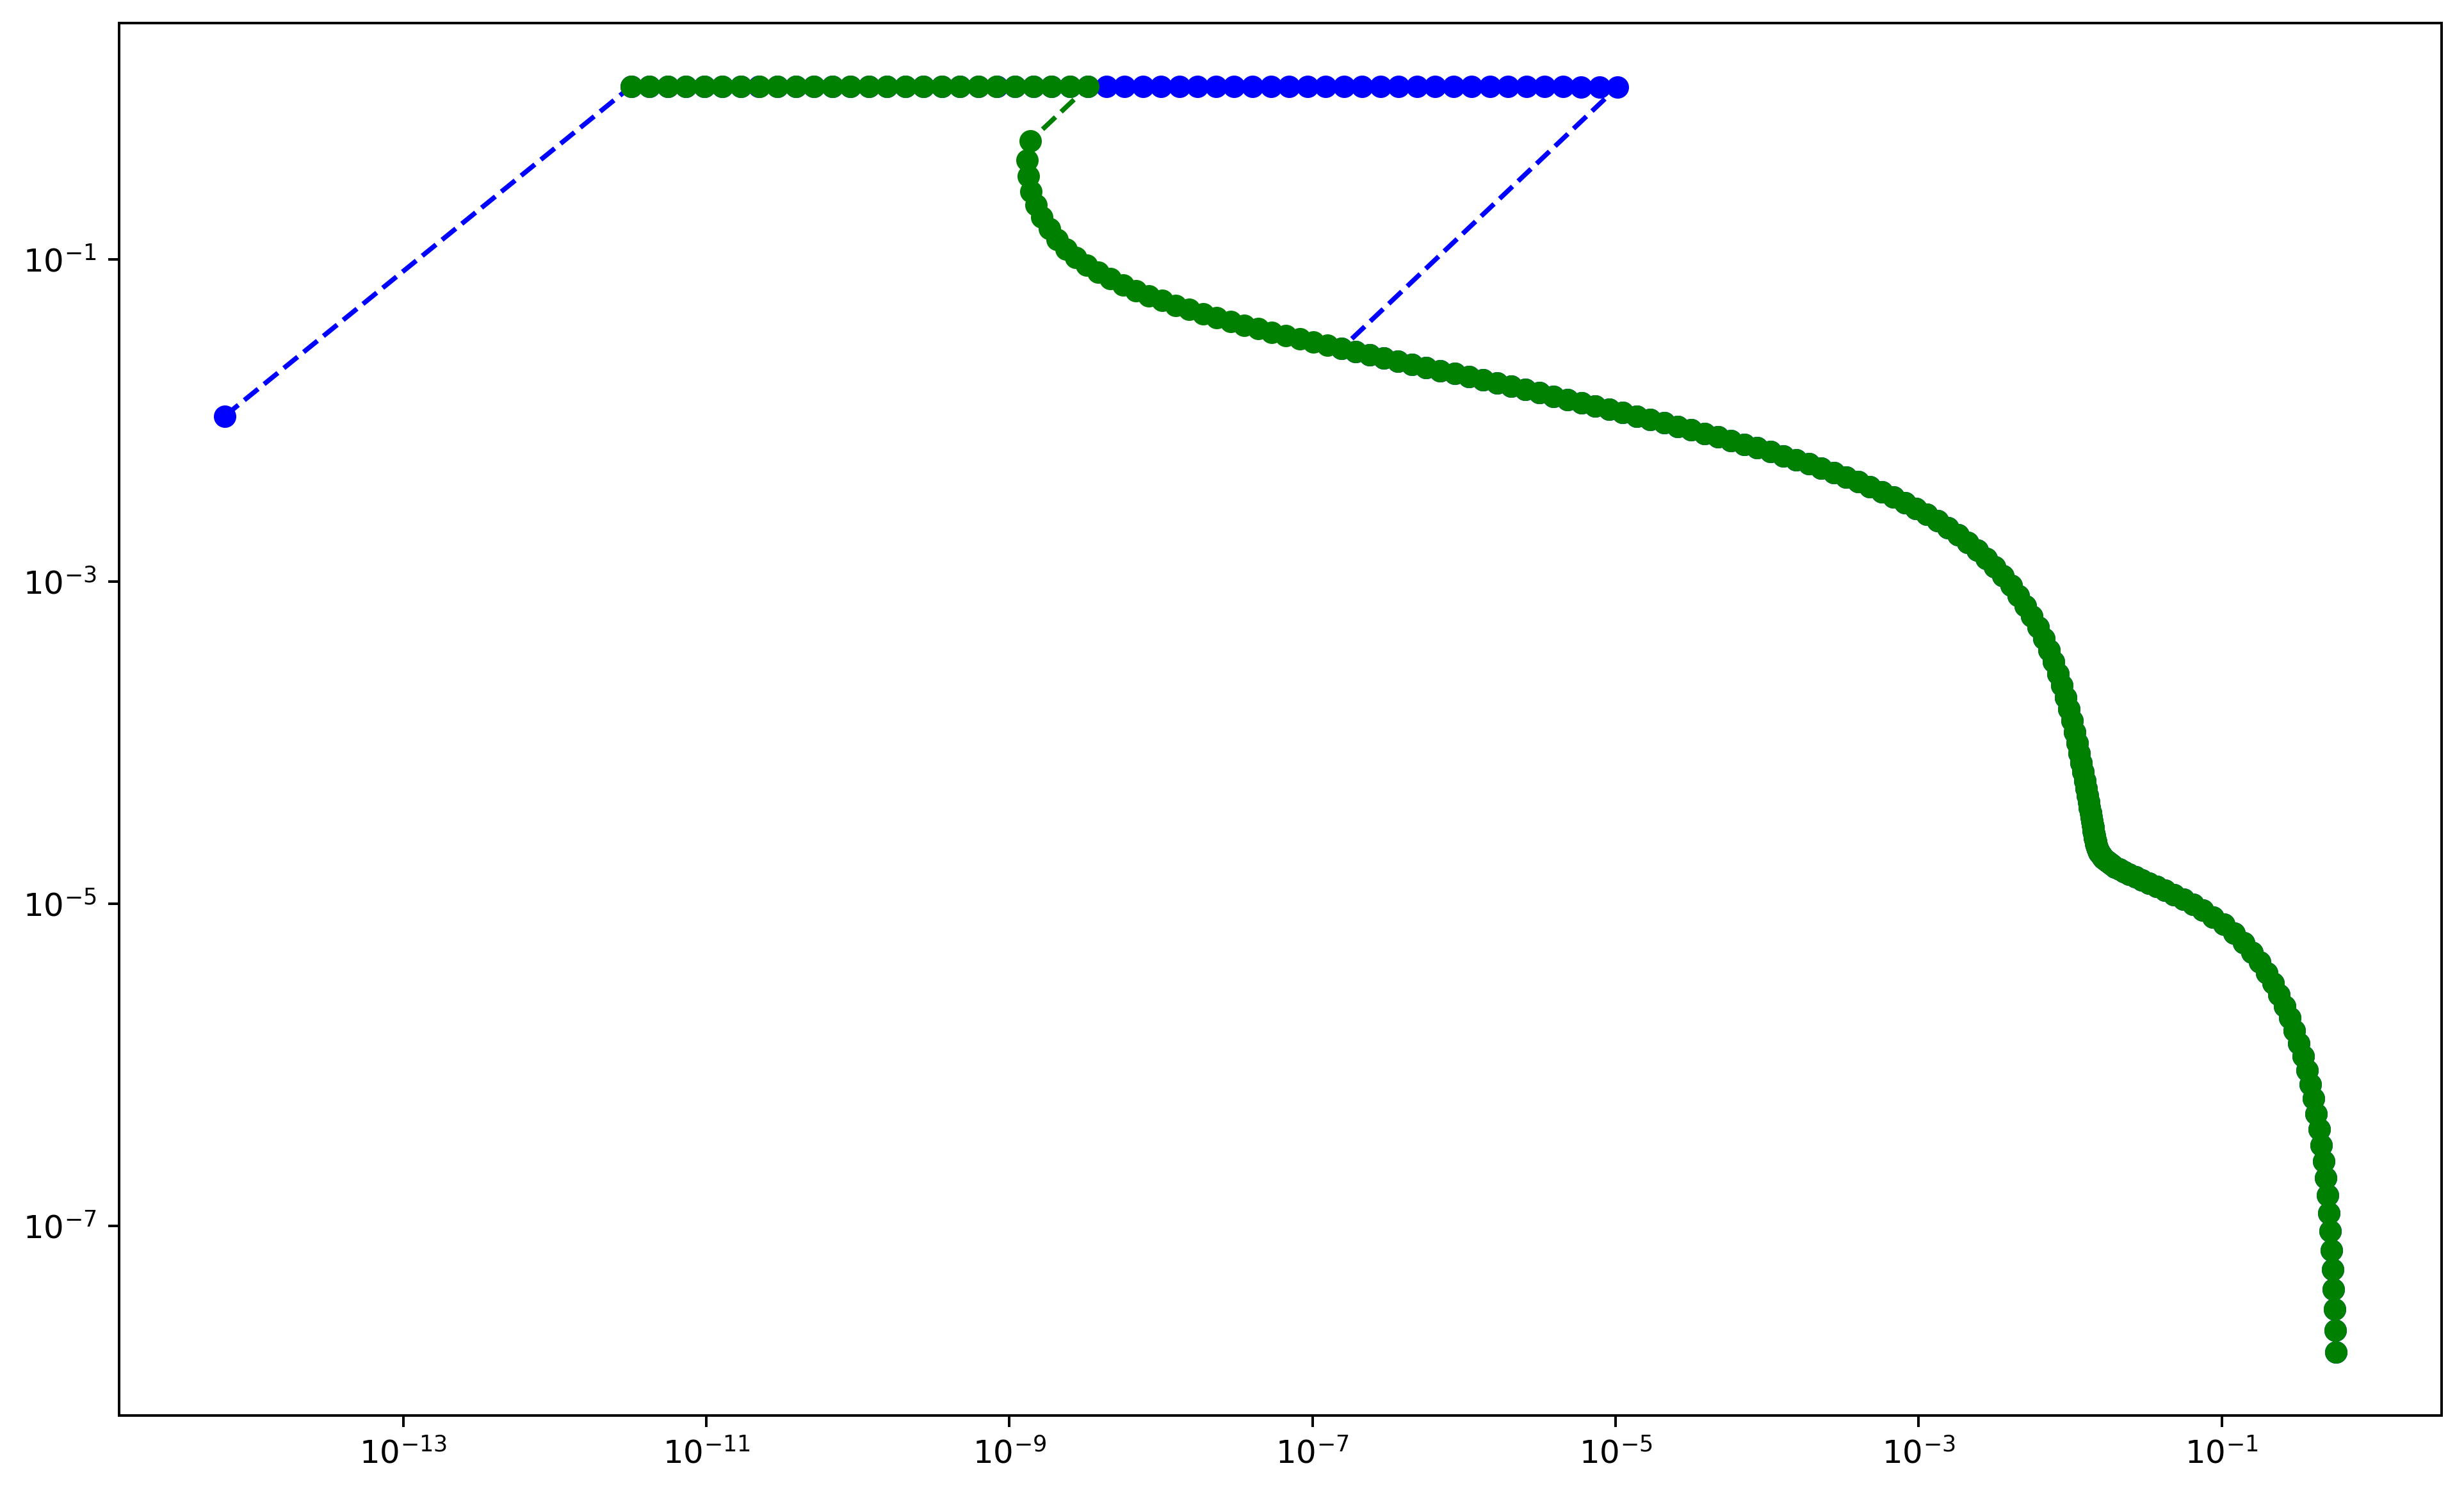

In [24]:
fig, ax = plt.subplots(figsize=[13, 8], dpi=360)
ax.loglog(*fsvals.T, 'bo--')
ax.loglog(*fsvalsbp.T, 'go--')

Text(0, 0.5, '$|| y-c\\Phi ||$')

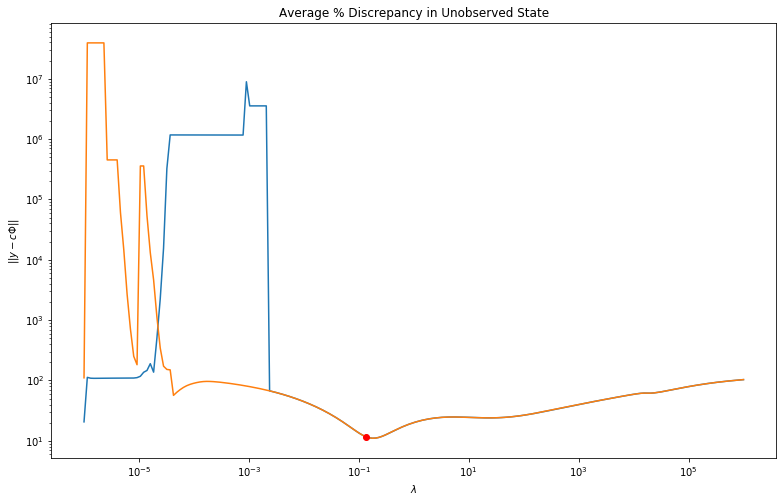

In [43]:
cvfnbp = lambda idx : np.sqrt(np.sum(((np.array(getx(solutionsbp[idx]['x'])[1]).flatten()) - sol.sol(model.observation_times)[1])**2)/len(model.observation_times))
validationbp = [100*cvfnbp(i)/np.mean(np.abs(sol.sol(model.observation_times)[1])) for i in range(200)]
idx = 85
plt.loglog(prange, validation)
plt.loglog(prangebp, validationbp)
plt.loglog(prange[idx], validation[idx], 'ro')
plt.title("Average % Discrepancy in Unobserved State")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|| y-c\Phi ||$")

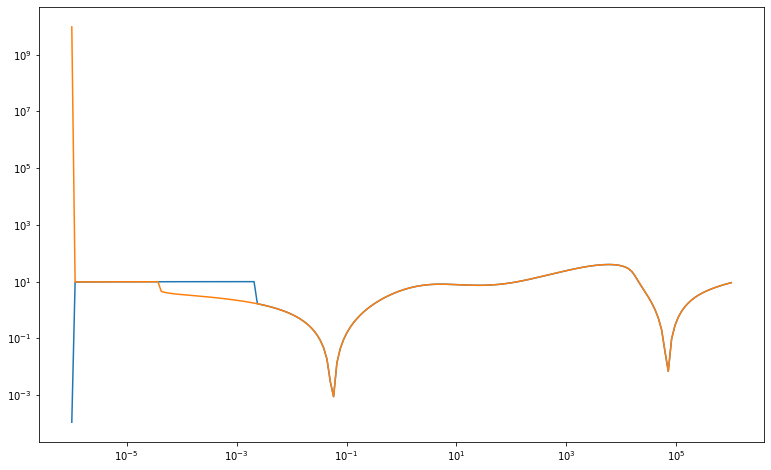

In [44]:
pwrongnessbp = lambda idx: np.sum((np.array(p_true) - np.array(getp(solutionsbp[idx]['x'])))**2)
perrbp = [pwrongnessbp(i) for i in range(200)]
plt.loglog(prange, perr)
plt.loglog(prangebp, perrbp)


In [28]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.ps),
}

profiler = ca.nlpsol('solver', 'ipopt', profiler_setup)

In [45]:
idx = 85
rho = prange[idx]
pref = getp(solutions[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*2 + 1) + [0]

pvals = np.linspace(-3, 3, 100)
profile = []
profile_r = []
for pval in pvals:
    lbg = np.array([pval, -np.inf])
    ubg = np.array([pval, np.inf])
    profile.append(profiler(x0=solutions[idx]['x'], p=[rho, 0], lbg=lbg, ubg=ubg, lbx=lbx))
    profile_r.append(profiler(x0=solutions[idx]['x'], p=[rho, (np.log10(rho)+6)*1e-5], lbg=lbg, ubg=ubg, lbx=lbx))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   2  8.7614881e+01 0.00e+00 1.35e+01  -1.0 1.35e-01   2.0 1.00e+00 1.00e+00f  1
   3  7.3071500e+01 0.00e+00 1.19e+01  -1.0 3.53e-01   1.5 1.00e+00 1.00e+00f  1
   4  4.8560408e+01 0.00e+00 9.00e+00  -1.0 7.65e-01   1.0 1.00e+00 1.00e+00f  1
   5  2.4034145e+01 0.00e+00 5.40e+00  -1.0 1.25e+00   0.6 1.00e+00 1.00e+00f  1
   6  1.0547789e+01 0.00e+00 3.66e+00  -1.0 1.40e+00   0.1 1.00e+00 1.00e+00f  1
   7  5.4333379e+00 0.00e+00 9.92e-01  -1.0 1.02e+00  -0.4 1.00e+00 1.00e+00f  1
   8  2.3061974e+00 0.00e+00 5.18e-01  -1.7 1.56e+00  -0.9 1.00e+00 1.00e+00f  1
   9  7.5036368e-01 0.00e+00 3.08e-01  -1.7 2.38e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.0556352e-01 0.00e+00 5.05e-02  -1.7 1.02e+00  -1.8 1.00e+00 1.00e+00f  1
  11  1.4237945e-01 0.00e+00 7.03e-02  -2.5 2.36e+00  -2.3 1.94e-01 5.00e-01f  2
  12  9.8721548e-02 0.00e+00 1.58e-01  -2.5 2.91e+00  -2.8 1.00e+00 5.00e-01f  2
  13  5.5330967e-02 0.00e+00

   5  2.3541805e+01 0.00e+00 5.24e+00  -1.0 1.22e+00   0.6 1.00e+00 1.00e+00f  1
   6  1.0275965e+01 0.00e+00 3.60e+00  -1.0 1.41e+00   0.1 1.00e+00 1.00e+00f  1
   7  5.2668311e+00 0.00e+00 1.03e+00  -1.0 1.00e+00  -0.4 1.00e+00 1.00e+00f  1
   8  2.3207241e+00 0.00e+00 5.09e-01  -1.0 1.39e+00  -0.9 1.00e+00 1.00e+00f  1
   9  7.5574765e-01 0.00e+00 2.88e-01  -1.7 2.28e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6755648e-01 0.00e+00 3.12e-02  -1.7 1.17e+00  -1.8 1.00e+00 1.00e+00f  1
  11  1.8516556e-01 0.00e+00 1.22e-02  -2.5 3.27e-01  -1.4 1.00e+00 1.00e+00f  1
  12  9.3546765e-02 0.00e+00 6.74e-02  -3.8 1.91e+00  -1.9 3.36e-01 5.00e-01f  2
  13  4.5906715e-02 0.00e+00 5.92e-02  -3.8 1.22e+00  -2.3 1.00e+00 1.00e+00f  1
  14  3.6014976e-02 0.00e+00 8.35e-03  -3.8 5.43e-01  -2.8 1.00e+00 1.00e+00f  1
  15  3.4800518e-02 0.00e+00 7.68e-04  -3.8 1.58e-01  -2.4 1.00e+00 1.00e+00f  1
  16  3.2766540e-02 0.00e+00

  19  2.8853862e-02 0.00e+00 1.86e-02  -5.7 8.55e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.5699803e-02 0.00e+00 2.52e-03  -5.7 2.91e-01    -  1.00e+00 1.00e+00f  1
  21  2.5449139e-02 0.00e+00 3.38e-04  -5.7 2.93e-01    -  1.00e+00 1.00e+00f  1
  22  2.5446832e-02 0.00e+00 1.67e-06  -5.7 1.31e-02    -  1.00e+00 1.00e+00f  1
  23  2.5446832e-02 0.00e+00 8.88e-10  -8.6 3.23e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   2.5446831823450828e-02    2.5446831823450828e-02
Dual infeasibility......:   8.8838477091228440e-10    8.8838477091228440e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5124299501845140e-09    2.5124299501845140e-09
Overall NLP error.......:   2.5124299501845140e-09    2.5124299501845140e-09


Number of objective funct

   1  7.6056152e+01 0.00e+00 4.55e+01  -1.0 4.77e+00    -  8.09e-01 1.00e+00h  1
   2  7.1849496e+01 0.00e+00 1.11e+01  -1.0 1.11e-01   2.0 1.00e+00 1.00e+00f  1
   3  6.1585134e+01 0.00e+00 9.92e+00  -1.0 2.95e-01   1.5 1.00e+00 1.00e+00f  1
   4  4.3009792e+01 0.00e+00 7.74e+00  -1.0 6.66e-01   1.0 1.00e+00 1.00e+00f  1
   5  2.2512048e+01 0.00e+00 4.90e+00  -1.0 1.14e+00   0.6 1.00e+00 1.00e+00f  1
   6  9.8019238e+00 0.00e+00 3.44e+00  -1.0 1.42e+00   0.1 1.00e+00 1.00e+00f  1
   7  4.9434365e+00 0.00e+00 1.13e+00  -1.0 9.57e-01  -0.4 1.00e+00 1.00e+00f  1
   8  2.2299469e+00 0.00e+00 4.63e-01  -1.0 1.34e+00  -0.9 1.00e+00 1.00e+00f  1
   9  7.4895097e-01 0.00e+00 2.76e-01  -1.7 2.05e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5372309e-01 0.00e+00 3.65e-02  -1.7 1.17e+00  -1.8 9.88e-01 1.00e+00f  1
  11  1.7290049e-01 0.00e+00 1.24e-02  -2.5 3.07e-01  -1.4 1.00e+00 1.00e+00f  1
  12  8.9590583e-02 0.00e+00

   3  5.8019010e+01 0.00e+00 9.32e+00  -1.0 2.77e-01   1.5 1.00e+00 1.00e+00f  1
   4  4.1179253e+01 0.00e+00 7.34e+00  -1.0 6.33e-01   1.0 1.00e+00 1.00e+00f  1
   5  2.1977691e+01 0.00e+00 4.72e+00  -1.0 1.11e+00   0.6 1.00e+00 1.00e+00f  1
   6  9.5966614e+00 0.00e+00 3.34e+00  -1.0 1.41e+00   0.1 1.00e+00 1.00e+00f  1
   7  4.7862518e+00 0.00e+00 1.19e+00  -1.0 9.34e-01  -0.4 1.00e+00 1.00e+00f  1
   8  2.1822760e+00 0.00e+00 4.42e-01  -1.0 1.32e+00  -0.9 1.00e+00 1.00e+00f  1
   9  7.4344486e-01 0.00e+00 2.69e-01  -1.7 1.96e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4819754e-01 0.00e+00 3.87e-02  -1.7 1.16e+00  -1.8 9.75e-01 1.00e+00f  1
  11  1.6824988e-01 0.00e+00 1.24e-02  -2.5 3.07e-01  -1.4 1.00e+00 1.00e+00f  1
  12  8.9224596e-02 0.00e+00 8.16e-02  -3.8 2.10e+00  -1.9 3.29e-01 5.00e-01f  2
  13  5.3232718e-02 0.00e+00 1.25e-02  -3.8 2.87e-01  -1.4 1.00e+00 1.00e+00f  1
  14  3.9811616e-02 0.00e+00

   9  7.3693211e-01 0.00e+00 2.63e-01  -1.7 1.87e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4338628e-01 0.00e+00 4.06e-02  -1.7 1.15e+00  -1.8 9.63e-01 1.00e+00f  1
  11  1.6425487e-01 0.00e+00 1.24e-02  -2.5 3.07e-01  -1.4 1.00e+00 1.00e+00f  1
  12  8.9026814e-02 0.00e+00 8.64e-02  -3.8 2.17e+00  -1.9 3.23e-01 5.00e-01f  2
  13  5.1258827e-02 0.00e+00 1.28e-02  -3.8 2.86e-01  -1.4 1.00e+00 1.00e+00f  1
  14  3.8111687e-02 0.00e+00 3.43e-03  -3.8 2.88e-01  -1.9 1.00e+00 1.00e+00f  1
  15  3.0050664e-02 0.00e+00 1.77e-03  -3.8 3.71e-01  -2.4 1.00e+00 1.00e+00f  1
  16  2.5075821e-02 0.00e+00 5.21e-03  -3.8 1.40e+00  -2.9 1.00e+00 5.00e-01f  2
  17  2.1336883e-02 0.00e+00 3.62e-03  -3.8 7.64e-01  -3.4 1.00e+00 1.00e+00f  1
  18  2.0631094e-02 0.00e+00 2.61e-04  -3.8 2.81e-01    -  1.00e+00 1.00e+00f  1
  19  2.0620326e-02 0.00e+00 2.64e-05  -5.7 5.90e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  17  1.9346752e-02 0.00e+00 2.51e-03  -3.8 3.75e-01  -3.4 1.00e+00 1.00e+00f  1
  18  1.9010237e-02 0.00e+00 3.87e-04  -3.8 2.88e-01    -  1.00e+00 1.00e+00f  1
  19  1.9005050e-02 0.00e+00 2.74e-06  -5.7 2.09e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.9005049e-02 0.00e+00 3.61e-09  -8.6 8.17e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:   1.9005048923733007e-02    1.9005048923733007e-02
Dual infeasibility......:   3.6105098121311241e-09    3.6105098121311241e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5251299481541460e-09    2.5251299481541460e-09
Overall NLP error.......:   3.6105098121311241e-09    3.6105098121311241e-09


Number of objective function evaluations             = 26
Number of objective gradient evaluations        

   5  1.9684583e+01 0.00e+00 3.98e+00  -1.0 9.54e-01   0.6 1.00e+00 1.00e+00f  1
   6  8.9205314e+00 0.00e+00 2.88e+00  -1.0 1.34e+00   0.1 1.00e+00 1.00e+00f  1
   7  4.1987912e+00 0.00e+00 1.42e+00  -1.0 1.07e+00  -0.4 1.00e+00 1.00e+00f  1
   8  1.9832253e+00 0.00e+00 3.76e-01  -1.0 1.24e+00  -0.9 1.00e+00 1.00e+00f  1
   9  7.1218880e-01 0.00e+00 2.43e-01  -1.7 1.67e+00  -1.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3020268e-01 0.00e+00 4.46e-02  -1.7 1.12e+00  -1.8 9.26e-01 1.00e+00f  1
  11  1.5328165e-01 0.00e+00 1.23e-02  -2.5 3.03e-01  -1.4 1.00e+00 1.00e+00f  1
  12  8.5117562e-02 0.00e+00 8.91e-02  -3.8 2.30e+00  -1.9 3.10e-01 5.00e-01f  2
  13  4.5478350e-02 0.00e+00 1.26e-02  -3.8 2.68e-01  -1.4 1.00e+00 1.00e+00f  1
  14  3.3073713e-02 0.00e+00 3.19e-03  -3.8 2.53e-01  -1.9 1.00e+00 1.00e+00f  1
  15  2.4613505e-02 0.00e+00 2.14e-03  -3.8 3.94e-01  -2.4 1.00e+00 1.00e+00f  1
  16  1.8590474e-02 0.00e+00

  11  3.9135917e-02 0.00e+00 9.66e-03  -3.8 1.01e+00  -2.5 1.00e+00 1.00e+00f  1
  12  3.5104809e-02 0.00e+00 1.28e-03  -3.8 1.44e-01  -2.1 1.00e+00 1.00e+00f  1
  13  3.3117957e-02 0.00e+00 1.34e-03  -5.7 2.03e-01  -2.5 1.00e+00 1.00e+00f  1
  14  3.0801834e-02 0.00e+00 1.33e-02  -5.7 6.45e-01  -3.0 1.00e+00 1.00e+00f  1
  15  2.9567643e-02 0.00e+00 9.74e-03  -5.7 2.06e+00  -3.5 1.00e+00 5.00e-01f  2
  16  2.7776058e-02 0.00e+00 1.96e-03  -5.7 5.40e-01    -  1.00e+00 1.00e+00f  1
  17  2.7700735e-02 0.00e+00 1.79e-04  -5.7 1.55e-01    -  1.00e+00 1.00e+00f  1
  18  2.7699960e-02 0.00e+00 2.63e-06  -5.7 1.78e-02    -  1.00e+00 1.00e+00f  1
  19  2.7699960e-02 0.00e+00 1.30e-09  -8.6 4.60e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   2.7699960056505990e-02    2.7699960056505990e-02
Dual infeasibility......:   1.3001277128455932e-09    1.3001277128455932e-09
Constraint viol

   5  8.9447049e-01 0.00e+00 2.78e-01  -1.7 1.23e+00  -1.4 1.00e+00 1.00e+00f  1
   6  3.1288871e-01 0.00e+00 4.40e-02  -1.7 1.58e+00  -1.9 1.00e+00 1.00e+00f  1
   7  2.1534150e-01 0.00e+00 1.40e-01  -2.5 2.19e+00  -2.4 3.18e-01 1.00e+00f  1
   8  9.8709310e-02 0.00e+00 3.87e-02  -2.5 3.81e-01  -1.1 1.00e+00 1.00e+00f  1
   9  4.6874544e-02 0.00e+00 9.58e-03  -2.5 3.95e-01  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1268740e-02 0.00e+00 3.22e-03  -3.8 3.74e-01  -2.0 8.96e-01 1.00e+00f  1
  11  2.4397224e-02 0.00e+00 3.00e-03  -3.8 4.96e-01  -2.5 1.00e+00 1.00e+00f  1
  12  2.1416367e-02 0.00e+00 1.14e-02  -3.8 1.34e+00  -3.0 1.00e+00 1.00e+00f  1
  13  1.4895644e-02 0.00e+00 8.23e-03  -3.8 1.38e+00    -  1.00e+00 5.00e-01f  2
  14  1.3353754e-02 0.00e+00 1.63e-03  -3.8 3.83e-01    -  1.00e+00 1.00e+00f  1
  15  1.3328148e-02 0.00e+00 7.95e-05  -3.8 1.10e-01    -  1.00e+00 1.00e+00f  1
  16  1.3328015e-02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4250438e-02 0.00e+00 2.74e-03  -3.8 2.55e-01  -2.0 9.81e-01 1.00e+00f  1
  11  1.6882302e-02 0.00e+00 2.58e-03  -3.8 4.14e-01  -2.5 1.00e+00 1.00e+00f  1
  12  1.5109277e-02 0.00e+00 2.42e-02  -3.8 2.21e+00    -  1.00e+00 5.00e-01f  2
  13  1.0759806e-02 0.00e+00 5.01e-03  -3.8 3.69e-01    -  1.00e+00 1.00e+00f  1
  14  1.0619235e-02 0.00e+00 1.58e-04  -3.8 1.53e-01    -  1.00e+00 1.00e+00f  1
  15  1.0618567e-02 0.00e+00 3.26e-07  -5.7 7.22e-03    -  1.00e+00 1.00e+00f  1
  16  1.0618567e-02 0.00e+00 1.50e-10  -8.6 1.52e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   1.0618566841410597e-02    1.0618566841410597e-02
Dual infeasibility......:   1.4983646701854925e-10    1.4983646701854925e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  13  9.9699258e-03 0.00e+00 6.59e-07  -5.7 5.48e-03    -  1.00e+00 1.00e+00f  1
  14  9.9699258e-03 0.00e+00 7.14e-12  -8.6 2.03e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   9.9699257962402848e-03    9.9699257962402848e-03
Dual infeasibility......:   7.1428379704030487e-12    7.1428379704030487e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5138961306355275e-09    2.5138961306355275e-09
Overall NLP error.......:   2.5138961306355275e-09    2.5138961306355275e-09


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
N

                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7211308e-03 2.94e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.9959104e+01 0.00e+00 2.22e+01  -1.0 3.82e+00    -  8.39e-01 1.00e+00h  1
   2  1.1389690e+01 0.00e+00 6.38e+00  -1.0 1.94e+00   0.0 1.00e+00 1.00e+00f  1
   3  4.8461702e+00 0.00e+00 3.76e+00  -1.0 4.61e+00  -0.5 1.00e+00 5.15e-01f  1
   4  2.4686308e+00 0.00e+00 6.93e-01  -1.0 1.84e+00  -1.0 1.00e+00 1.00e+00f  1
 

   4  2.1639697e+00 0.00e+00 5.30e-01  -1.0 1.55e+00  -1.0 1.00e+00 1.00e+00f  1
   5  7.2082780e-01 0.00e+00 2.72e-01  -1.0 1.36e+00  -1.4 1.00e+00 1.00e+00f  1
   6  4.6812670e-01 0.00e+00 6.13e-02  -1.7 3.74e-01  -1.0 1.00e+00 1.00e+00f  1
   7  2.6038260e-01 0.00e+00 2.03e-02  -2.5 5.45e-01  -1.5 1.00e+00 1.00e+00f  1
   8  1.4615501e-01 0.00e+00 3.52e-02  -3.8 2.64e+01  -2.0 2.02e-02 3.12e-02f  6
   9  9.6405317e-02 0.00e+00 7.97e-02  -3.8 1.06e+01  -2.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1993918e-02 0.00e+00 2.13e-02  -3.8 2.64e-01  -1.1 1.00e+00 1.00e+00f  1
  11  2.4639495e-02 0.00e+00 4.83e-03  -3.8 1.79e-01  -1.6 1.00e+00 1.00e+00f  1
  12  8.7583262e-03 0.00e+00 9.50e-03  -3.8 1.11e+00    -  1.00e+00 1.00e+00f  1
  13  6.3112144e-03 0.00e+00 1.41e-03  -3.8 3.78e-01    -  1.00e+00 1.00e+00f  1
  14  6.2865107e-03 0.00e+00 2.15e-05  -5.7 6.91e-02    -  1.00e+00 1.00e+00f  1
  15  6.2864985e-03 0.00e+00

   5  6.0808126e-01 0.00e+00 2.11e-01  -1.0 1.52e+00  -1.4 1.00e+00 1.00e+00f  1
   6  3.9681334e-01 0.00e+00 5.05e-02  -1.7 3.08e-01  -1.0 1.00e+00 1.00e+00f  1
   7  1.8659252e-01 0.00e+00 1.64e-02  -2.5 5.90e-01  -1.5 8.99e-01 1.00e+00f  1
   8  1.4027970e-01 0.00e+00 1.60e-02  -3.8 1.87e-01  -1.1 1.00e+00 1.00e+00f  1
   9  4.6953129e-02 0.00e+00 2.40e-02  -3.8 6.22e-01  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1895306e-02 0.00e+00 5.54e-03  -3.8 3.28e-01  -2.0 1.00e+00 1.00e+00f  1
  11  1.3207697e-02 0.00e+00 5.05e-03  -3.8 5.00e-01  -2.5 1.00e+00 1.00e+00f  1
  12  8.4812984e-03 0.00e+00 2.15e-02  -3.8 1.60e+00    -  1.00e+00 5.00e-01f  2
  13  6.1969956e-03 0.00e+00 5.77e-03  -3.8 4.08e-01    -  1.00e+00 1.00e+00f  1
  14  6.0638002e-03 0.00e+00 2.10e-04  -3.8 4.73e-02    -  1.00e+00 1.00e+00f  1
  15  6.0632657e-03 0.00e+00 1.11e-06  -5.7 9.21e-03    -  1.00e+00 1.00e+00f  1
  16  6.0632657e-03 0.00e+00

   9  2.4929119e-02 0.00e+00 2.55e-02  -3.8 3.90e-01  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8175691e-02 0.00e+00 2.18e-03  -3.8 1.50e-01  -2.0 1.00e+00 1.00e+00f  1
  11  1.2228831e-02 0.00e+00 5.51e-03  -3.8 4.19e-01  -2.5 1.00e+00 1.00e+00f  1
  12  1.0861646e-02 0.00e+00 4.73e-02  -3.8 2.38e+00    -  1.00e+00 5.00e-01f  2
  13  6.1122359e-03 0.00e+00 1.80e-02  -3.8 4.82e-01    -  1.00e+00 1.00e+00f  1
  14  4.6129986e-03 0.00e+00 2.23e-03  -3.8 4.61e-01    -  1.00e+00 1.00e+00f  1
  15  4.5222391e-03 0.00e+00 1.19e-04  -3.8 9.32e-02    -  1.00e+00 1.00e+00f  1
  16  4.5219971e-03 0.00e+00 3.64e-07  -5.7 7.46e-03    -  1.00e+00 1.00e+00f  1
  17  4.5219971e-03 0.00e+00 1.35e-11  -8.6 1.80e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   4.5219970745248635e-03    4.5219970745248635e-03
Dual infeas

  11  1.4262700e-02 0.00e+00 2.87e-03  -5.7 3.76e-01  -2.5 8.74e-01 1.00e+00f  1
  12  9.2095128e-03 0.00e+00 3.85e-02  -5.7 7.91e-01  -3.0 1.00e+00 1.00e+00f  1
  13  6.7052883e-03 0.00e+00 2.37e-02  -5.7 7.26e-01    -  1.00e+00 1.00e+00f  1
  14  4.6907683e-03 0.00e+00 3.09e-03  -5.7 1.83e-01    -  1.00e+00 1.00e+00f  1
  15  4.5546926e-03 0.00e+00 5.56e-04  -5.7 1.09e-01    -  1.00e+00 1.00e+00f  1
  16  4.5534703e-03 0.00e+00 3.05e-06  -5.7 7.14e-03    -  1.00e+00 1.00e+00f  1
  17  4.5534702e-03 0.00e+00 2.96e-10  -8.6 1.07e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   4.5534702287652207e-03    4.5534702287652207e-03
Dual infeasibility......:   2.9633431472553262e-10    2.9633431472553262e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4817542555702344e-09    2.4817542555702344e-09
Overall NLP error......

  14  3.4483652e-03 0.00e+00 2.23e-03  -3.8 2.54e-01    -  1.00e+00 1.00e+00f  1
  15  3.2264748e-03 0.00e+00 8.70e-04  -3.8 1.48e-01    -  1.00e+00 1.00e+00f  1
  16  3.2241925e-03 0.00e+00 2.02e-06  -5.7 9.55e-03    -  1.00e+00 1.00e+00f  1
  17  3.2241923e-03 0.00e+00 3.51e-10  -8.6 1.35e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............:   3.2241923015543139e-03    3.2241923015543139e-03
Dual infeasibility......:   3.5144619853211267e-10    3.5144619853211267e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4850662956352215e-09    2.4850662956352215e-09
Overall NLP error.......:   2.4850662956352215e-09    2.4850662956352215e-09


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 20
Number of ine

  13  3.5646172e-03 0.00e+00 8.39e-04  -3.8 2.56e-01    -  1.00e+00 1.00e+00f  1
  14  3.5603584e-03 0.00e+00 1.28e-06  -5.7 9.75e-03    -  1.00e+00 1.00e+00f  1
  15  3.5603581e-03 0.00e+00 9.71e-10  -8.6 3.06e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   3.5603580915307023e-03    3.5603580915307023e-03
Dual infeasibility......:   9.7138884002506698e-10    9.7138884002506698e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5119903232607401e-09    2.5119903232607401e-09
Overall NLP error.......:   2.5119903232607401e-09    2.5119903232607401e-09


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 23
Number of inequality constraint evaluations          = 23
Number of equality constraint Jacobi

   4  6.8416313e-01 0.00e+00 1.71e-01  -1.0 1.56e+00  -1.0 1.00e+00 1.00e+00f  1
   5  2.1307409e-01 0.00e+00 1.73e-01  -2.5 3.26e+01  -1.4 9.15e-02 6.25e-02f  5
   6  7.0472854e-02 0.00e+00 8.92e-02  -2.5 8.52e-01  -1.9 1.00e+00 1.00e+00f  1
   7  3.2439206e-02 0.00e+00 1.03e-02  -2.5 1.26e+00  -2.4 1.00e+00 1.00e+00f  1
   8  1.2371367e-02 0.00e+00 3.05e-02  -3.8 1.31e+00  -2.9 1.00e+00 1.00e+00f  1
   9  8.3944935e-03 0.00e+00 5.84e-03  -3.8 2.58e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6678213e-03 0.00e+00 4.33e-02  -3.8 1.24e+00    -  1.00e+00 1.00e+00f  1
  11  3.8369594e-03 0.00e+00 1.41e-02  -3.8 5.56e-01    -  1.00e+00 1.00e+00f  1
  12  3.1949270e-03 0.00e+00 2.26e-03  -3.8 2.66e-01    -  1.00e+00 1.00e+00f  1
  13  3.1719298e-03 0.00e+00 1.20e-04  -3.8 4.20e-02    -  1.00e+00 1.00e+00f  1
  14  3.1718796e-03 0.00e+00 2.05e-07  -5.7 2.77e-03    -  1.00e+00 1.00e+00f  1
  15  3.1718796e-03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.8825327e-02 0.00e+00 3.20e-03  -3.8 3.67e-01  -2.0 1.00e+00 1.00e+00f  1
  11  1.3490782e-02 0.00e+00 2.12e-03  -3.8 5.43e-01  -2.5 1.00e+00 1.00e+00f  1
  12  1.1668397e-02 0.00e+00 4.07e-03  -3.8 2.38e+00  -3.0 1.00e+00 2.50e-01f  3
  13  8.4066235e-03 0.00e+00 1.45e-02  -3.8 4.16e+00    -  1.00e+00 2.50e-01f  3
  14  2.4234530e-03 0.00e+00 1.67e-02  -3.8 9.19e-01    -  1.00e+00 1.00e+00f  1
  15  1.8248270e-03 0.00e+00 2.80e-03  -3.8 3.45e-01    -  1.00e+00 1.00e+00f  1
  16  1.8073624e-03 0.00e+00 8.73e-05  -3.8 5.60e-02    -  1.00e+00 1.00e+00f  1
  17  1.8073306e-03 0.00e+00 5.31e-08  -5.7 2.25e-03    -  1.00e+00 1.00e+00f  1
  18  1.8073306e-03 0.00e+00 7.45e-11  -8.6 4.97e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:   1.8073305777025004e-03    1.8073305777025004e-03
Dual infeas

   3  2.4907897e+00 0.00e+00 1.06e+00  -1.7 8.59e-01  -0.5 1.00e+00 1.00e+00f  1
   4  9.6436453e-01 0.00e+00 5.86e-01  -1.7 8.85e-01  -1.0 1.00e+00 1.00e+00f  1
   5  6.6538696e-01 0.00e+00 8.13e-02  -1.7 2.64e-01  -0.5 1.00e+00 1.00e+00f  1
   6  3.1764150e-01 0.00e+00 7.76e-02  -2.5 4.76e-01  -1.0 1.00e+00 1.00e+00f  1
   7  8.5345005e-02 0.00e+00 4.24e-01  -2.5 1.78e+00  -1.5 1.00e+00 1.00e+00f  1
   8  3.4185312e-02 0.00e+00 2.58e-02  -2.5 1.55e-01  -1.1 1.00e+00 1.00e+00f  1
   9  2.2801968e-02 0.00e+00 5.28e-03  -3.8 1.19e-01  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6868941e-02 0.00e+00 2.72e-03  -3.8 3.05e-01  -2.0 1.00e+00 1.00e+00f  1
  11  1.2856070e-02 0.00e+00 2.06e-03  -3.8 4.46e-01  -2.5 1.00e+00 1.00e+00f  1
  12  1.0484645e-02 0.00e+00 1.17e-02  -3.8 1.20e+00  -3.0 1.00e+00 5.00e-01f  2
  13  7.1489047e-03 0.00e+00 3.42e-02  -3.8 1.60e+00  -3.4 1.00e+00 5.00e-01f  2
  14  2.7720138e-03 0.00e+00

   2  4.2447323e+00 0.00e+00 5.82e-01  -1.0 5.30e-01   0.0 1.00e+00 1.00e+00f  1
   3  2.2537357e+00 0.00e+00 8.34e-01  -1.7 7.53e-01  -0.5 1.00e+00 1.00e+00f  1
   4  9.1206986e-01 0.00e+00 5.66e-01  -1.7 8.14e-01  -1.0 1.00e+00 1.00e+00f  1
   5  6.4205749e-01 0.00e+00 7.70e-02  -1.7 2.52e-01  -0.5 1.00e+00 1.00e+00f  1
   6  3.1822029e-01 0.00e+00 7.85e-02  -2.5 4.52e-01  -1.0 1.00e+00 1.00e+00f  1
   7  5.0050374e-02 0.00e+00 3.11e-01  -2.5 1.61e+00  -1.5 1.00e+00 1.00e+00f  1
   8  1.4150877e-02 0.00e+00 1.35e-02  -2.5 2.38e-01  -2.0 1.00e+00 1.00e+00f  1
   9  9.8126581e-03 0.00e+00 1.27e-03  -3.8 3.44e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.4326033e-03 0.00e+00 2.11e-02  -5.7 8.05e-01  -2.9 1.00e+00 1.00e+00f  1
  11  3.6198644e-03 0.00e+00 3.27e-02  -5.7 1.03e+00    -  1.00e+00 1.00e+00f  1
  12  1.5396367e-03 0.00e+00 1.10e-03  -5.7 2.29e-01    -  1.00e+00 1.00e+00f  1
  13  1.5221876e-03 0.00e+00

   8  1.3222038e-02 0.00e+00 6.45e-03  -2.5 2.32e-01  -2.0 1.00e+00 1.00e+00f  1
   9  8.8546510e-03 0.00e+00 1.17e-03  -3.8 2.83e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.0208001e-03 0.00e+00 2.35e-02  -5.7 7.26e-01  -2.9 1.00e+00 1.00e+00f  1
  11  2.0282084e-03 0.00e+00 9.43e-03  -5.7 6.92e-01    -  1.00e+00 1.00e+00f  1
  12  1.8068170e-03 0.00e+00 2.58e-04  -5.7 9.77e-02    -  1.00e+00 1.00e+00f  1
  13  1.8064550e-03 0.00e+00 1.04e-06  -5.7 1.14e-02    -  1.00e+00 1.00e+00f  1
  14  1.8064550e-03 0.00e+00 9.60e-11  -8.6 4.20e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.8064550103640102e-03    1.8064550103640102e-03
Dual infeasibility......:   9.5973270346563777e-11    9.5973270346563777e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  15  5.9166310e-03 0.00e+00 2.67e-04  -5.7 1.03e-01  -2.6 1.00e+00 1.00e+00f  1
  16  4.4020299e-03 0.00e+00 1.11e-02  -5.7 7.52e-01  -3.1 1.00e+00 1.00e+00f  1
  17  2.9179155e-03 0.00e+00 2.34e-02  -5.7 6.22e+00    -  1.00e+00 9.80e-02f  4
  18  1.0682503e-03 0.00e+00 4.41e-03  -5.7 3.86e-01    -  1.00e+00 1.00e+00f  1
  19  9.3180676e-04 0.00e+00 1.27e-03  -5.7 1.58e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.2978203e-04 0.00e+00 7.95e-07  -5.7 1.31e-02    -  1.00e+00 1.00e+00f  1
  21  9.2978189e-04 0.00e+00 1.27e-09  -8.6 1.58e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   9.2978188732769512e-04    9.2978188732769512e-04
Dual infeasibility......:   1.2667718345647783e-09    1.2667718345647783e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity....

  13  1.8254062e-03 0.00e+00 1.15e-06  -5.7 7.21e-03    -  1.00e+00 1.00e+00f  1
  14  1.8254062e-03 0.00e+00 1.04e-10  -8.6 6.90e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.8254062347001668e-03    1.8254062347001668e-03
Dual infeasibility......:   1.0399575731817601e-10    1.0399575731817601e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5388138542706808e-09    2.5388138542706808e-09
Overall NLP error.......:   2.5388138542706808e-09    2.5388138542706808e-09


Number of objective function evaluations             = 17
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 17
Number of inequality constraint evaluations          = 17
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 15
N

   5  8.2313106e-02 0.00e+00 1.74e-01  -1.7 1.71e+00  -1.4 1.00e+00 1.00e+00f  1
   6  1.4781595e-02 0.00e+00 7.60e-02  -2.5 6.26e-01  -1.9 1.00e+00 1.00e+00f  1
   7  6.8848863e-03 0.00e+00 4.97e-03  -2.5 1.43e+00    -  1.00e+00 5.00e-01f  2
   8  2.7238761e-03 0.00e+00 9.55e-03  -3.8 9.10e-01    -  8.76e-01 1.00e+00f  1
   9  2.4232977e-03 0.00e+00 1.92e-03  -3.8 2.96e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4171970e-03 0.00e+00 1.78e-06  -3.8 3.07e-02    -  1.00e+00 1.00e+00f  1
  11  2.4170375e-03 0.00e+00 2.01e-06  -5.7 1.15e-02    -  1.00e+00 1.00e+00f  1
  12  2.4170375e-03 0.00e+00 1.67e-10  -8.6 1.06e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   2.4170374991895594e-03    2.4170374991895594e-03
Dual infeasibility......:   1.6740805963699756e-10    1.6740805963699756e-10
Constraint viol

   2  1.9013579e+00 0.00e+00 1.72e-01  -1.0 1.69e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.3401384e+00 0.00e+00 1.73e-01  -2.5 3.62e-01  -0.5 1.00e+00 1.00e+00f  1
   4  7.0578105e-01 0.00e+00 3.21e-01  -2.5 5.58e-01  -1.0 1.00e+00 1.00e+00f  1
   5  2.0455655e-01 0.00e+00 1.81e-01  -2.5 8.91e-01  -1.4 1.00e+00 1.00e+00f  1
   6  1.1855295e-01 0.00e+00 1.06e+00  -2.5 3.15e+00  -1.9 1.00e+00 1.00e+00f  1
   7  1.8248951e-02 0.00e+00 1.39e-01  -2.5 2.90e-01  -1.5 1.00e+00 1.00e+00f  1
   8  9.2423176e-03 0.00e+00 1.02e-02  -2.5 1.44e-01  -2.0 1.00e+00 1.00e+00f  1
   9  4.6563488e-03 0.00e+00 2.60e-02  -3.8 7.01e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0335632e-03 0.00e+00 4.90e-03  -3.8 7.56e-01    -  1.00e+00 1.00e+00f  1
  11  4.0062491e-03 0.00e+00 1.87e-04  -3.8 1.79e-01    -  1.00e+00 1.00e+00f  1
  12  4.0062168e-03 0.00e+00 2.05e-07  -5.7 2.91e-03    -  1.00e+00 1.00e+00f  1
  13  4.0062168e-03 0.00e+00

   9  1.0438254e-03 0.00e+00 4.58e-02  -2.5 2.61e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9912170e-04 0.00e+00 7.41e-03  -2.5 6.67e-01    -  1.00e+00 1.00e+00f  1
  11  2.5129890e-04 0.00e+00 1.29e-03  -3.8 2.71e-01    -  1.00e+00 1.00e+00f  1
  12  2.4988873e-04 0.00e+00 4.38e-05  -5.7 6.50e-02    -  1.00e+00 1.00e+00f  1
  13  2.4988555e-04 0.00e+00 1.92e-07  -5.7 5.64e-03    -  1.00e+00 1.00e+00f  1
  14  2.4988550e-04 0.00e+00 3.41e-09  -8.6 8.54e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   2.4988549817382992e-04    2.4988549817382992e-04
Dual infeasibility......:   3.4108911903685951e-09    3.4108911903685951e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6157680695666895e-09    2.6157680695666895e-09
Overall NLP error......

   4  5.7338628e-01 0.00e+00 1.41e-01  -2.5 4.83e-01  -1.0 1.00e+00 1.00e+00f  1
   5  2.5979907e-01 0.00e+00 1.84e-01  -2.5 7.20e-01  -1.4 1.00e+00 1.00e+00f  1
   6  8.8349597e-02 0.00e+00 7.74e-02  -2.5 9.99e-01  -1.9 1.00e+00 1.00e+00f  1
   7  4.4097482e-02 0.00e+00 1.36e-01  -2.5 2.11e+00  -2.4 1.00e+00 1.00e+00f  1
   8  1.8016953e-02 0.00e+00 2.79e-02  -2.5 4.93e+00    -  1.00e+00 1.00e+00f  1
   9  1.3581303e-02 0.00e+00 1.09e-01  -3.8 5.60e+00    -  7.09e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2373155e-03 0.00e+00 6.57e-02  -3.8 7.58e-01  -2.9 1.00e+00 1.00e+00f  1
  11  8.2027282e-04 0.00e+00 3.96e-02  -3.8 3.82e+00    -  1.00e+00 1.00e+00f  1
  12  2.7719815e-04 0.00e+00 4.44e-03  -3.8 2.15e+00    -  1.00e+00 1.00e+00f  1
  13  1.6170206e-04 0.00e+00 1.07e-02  -3.8 2.12e+00    -  1.00e+00 1.00e+00f  1
  14  1.4019496e-04 0.00e+00 7.38e-04  -3.8 6.92e-01    -  1.00e+00 1.00e+00f  1
  15  1.3982104e-04 0.00e+00

   3  4.1503229e-02 0.00e+00 1.90e-01  -1.7 4.63e+00    -  7.02e-01 1.00e+00f  1
   4  1.9899782e-02 0.00e+00 5.64e-02  -2.5 1.24e+01    -  1.00e+00 5.00e-01f  2
   5  1.4641529e-02 0.00e+00 2.97e-02  -2.5 9.99e+00    -  1.00e+00 1.00e+00f  1
   6  4.8979376e-03 0.00e+00 8.33e-02  -2.5 1.89e-01  -2.5 1.00e+00 1.00e+00f  1
   7  2.8621982e-03 0.00e+00 1.50e-01  -2.5 9.67e+00    -  1.00e+00 1.00e+00f  1
   8  9.3062852e-04 0.00e+00 3.21e-02  -2.5 7.17e+00    -  1.00e+00 1.00e+00f  1
   9  4.1674376e-04 0.00e+00 5.13e-02  -2.5 3.09e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8187388e-04 0.00e+00 7.60e-03  -2.5 9.63e+00    -  1.00e+00 1.00e+00f  1
  11  1.2875431e-04 0.00e+00 3.07e-03  -3.8 6.74e-02  -3.0 1.00e+00 1.00e+00f  1
  12  6.4834762e-05 0.00e+00 6.93e-03  -3.8 1.62e+00    -  1.00e+00 1.00e+00f  1
  13  6.0319982e-05 0.00e+00 1.17e-03  -3.8 1.56e+00    -  1.00e+00 1.00e+00f  1
  14  5.9447981e-05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 1.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.0132382e-01 1.11e-16 9.96e-01  -1.0 1.29e+00    -  9.33e-01 1.00e+00h  1
   2  3.4581765e-01 9.71e-17 1.21e+00  -1.7 9.10e+01    -  4.16e-02 1.25e-01f  4
   3  1.3778604e-01 0.00e+00 1.03e+00  -1.7 9.74e-01  -2.0 1.00e+00 1.00e+00f  1
   4  8.0666782e-02 0.00e+00 4.84e-01  -1.7 1.13e+00  -2.5 1.00e+00 1.00e+00f  1
   5  5.1615236e-02 0.00e+00 7.14e-01  -1.7 4.47e+01    -  3.70e-01 2.50e-01f  3
   6  5.2103033e-02 0.00e+00 1.49e-01  -1.7 2.73e+01    -  1.00e+00 1.00e+00f  1
   7  1.4275771e-02 0.00e+00 7.54e-01  -2.5 8.07e-01  -3.0 1.00e+00 1.00e+00f  1
   8  8.2967342e-03 0.00e+00 3.76e-01  -2.5 2.32e+01    -  1.00e+00 1.00e+00f  1
   9  4.1374628e-03 0.00e+00 7.39e-02  -2.5 2.05e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.6787747e-03 0.00e+00

   7  1.1977842e-01 0.00e+00 1.03e-02  -3.8 3.26e+00  -3.9 1.00e+00 1.00e+00f  1
   8  1.0820708e-01 0.00e+00 2.86e-02  -3.8 1.52e+01  -4.4 8.95e-01 1.00e+00f  1
   9  8.8179174e-02 0.00e+00 1.03e+00  -3.8 8.85e+02  -4.9 1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.3949598e-02 0.00e+00 1.62e+00  -3.8 9.47e+02    -  5.62e-02 3.12e-02f  6
  11  3.1602076e-02 0.00e+00 1.42e+00  -3.8 6.18e+01    -  1.00e+00 1.00e+00f  1
  12  1.4413806e-02 0.00e+00 2.94e-01  -3.8 9.48e+01    -  9.33e-01 5.00e-01f  2
  13  9.2840814e-03 0.00e+00 1.07e+00  -3.8 6.84e+01    -  1.00e+00 1.00e+00f  1
  14  5.7307156e-03 0.00e+00 4.26e-01  -3.8 7.15e+01    -  1.00e+00 1.00e+00f  1
  15  4.3846203e-03 0.00e+00 1.45e-01  -3.8 4.80e+00  -5.3 1.00e+00 1.00e+00f  1
  16  3.7969256e-03 0.00e+00 1.02e+00  -3.8 1.12e+02    -  1.00e+00 1.00e+00f  1
  17  1.8494087e-03 0.00e+00 1.82e-01  -3.8 6.00e+01    -  1.00e+00 1.00e+00f  1
  18  1.5949836e-03 0.00e+00

   7  1.1739347e-01 0.00e+00 6.44e-02  -3.8 1.24e+00  -3.4 1.00e+00 1.00e+00f  1
   8  1.1445336e-01 0.00e+00 4.78e-03  -3.8 3.59e+00  -3.9 1.00e+00 1.00e+00f  1
   9  9.8347022e-02 0.00e+00 5.23e-02  -3.8 1.62e+01  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.9184319e-02 0.00e+00 2.54e+00  -3.8 4.50e+01  -4.9 1.00e+00 1.00e+00f  1
  11  5.1053126e-02 0.00e+00 1.22e+00  -3.8 1.24e+02    -  5.66e-01 5.00e-01f  2
  12  1.5863542e-02 0.00e+00 2.12e+00  -3.8 8.83e+01  -5.3 1.00e+00 5.00e-01f  2
  13  1.0018475e-02 0.00e+00 9.61e-01  -3.8 6.95e+01    -  1.00e+00 1.00e+00f  1
  14  5.9035494e-03 0.00e+00 2.92e-01  -3.8 7.37e+01    -  1.00e+00 1.00e+00f  1
  15  3.7140225e-03 0.00e+00 1.95e-01  -3.8 4.54e+02    -  7.12e-01 1.25e-01f  4
  16  2.4800322e-03 0.00e+00 4.39e-01  -3.8 7.93e+01    -  1.00e+00 1.00e+00f  1
  17  2.1251193e-03 0.00e+00 1.03e-02  -3.8 1.04e+02    -  1.00e+00 1.00e+00f  1
  18  1.3382977e-03 0.00e+00

  12  1.2383926e-01 0.00e+00 1.18e-05  -5.7 5.00e-02    -  1.00e+00 1.00e+00f  1
  13  1.2383925e-01 0.00e+00 1.43e-06  -8.6 1.77e-02    -  1.00e+00 1.00e+00f  1
  14  1.2383925e-01 0.00e+00 1.10e-11  -8.6 1.37e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.2383924775998387e-01    1.2383924775998387e-01
Dual infeasibility......:   1.1006718106387758e-11    1.1006718106387758e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5077646693016813e-09    2.5077646693016813e-09
Overall NLP error.......:   2.5077646693016813e-09    2.5077646693016813e-09


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobi

  15  5.6076568e-05 0.00e+00 1.42e-02  -3.8 6.39e+00    -  1.00e+00 1.00e+00f  1
  16  3.8776014e-05 0.00e+00 1.10e-02  -3.8 6.93e+00    -  1.00e+00 1.00e+00f  1
  17  3.2668868e-05 0.00e+00 4.45e-03  -3.8 3.92e+00    -  1.00e+00 1.00e+00f  1
  18  3.4115701e-05 0.00e+00 3.01e-03  -3.8 3.96e+00    -  1.00e+00 1.00e+00f  1
  19  3.4643577e-05 0.00e+00 3.70e-04  -3.8 1.18e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.2427045e-05 0.00e+00 6.08e-03  -5.7 5.95e+00    -  1.00e+00 1.00e+00f  1
  21  3.1454831e-05 0.00e+00 5.27e-06  -5.7 2.55e-01    -  1.00e+00 1.00e+00f  1
  22  3.1454276e-05 0.00e+00 6.20e-07  -8.6 4.35e-02    -  1.00e+00 1.00e+00f  1
  23  3.1454276e-05 0.00e+00 5.91e-12  -8.6 1.59e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   3.1454275922010555e-05    3.1454275922010555e-05
Dual infeas

   7  1.6623183e-03 0.00e+00 3.28e-02  -3.8 7.83e+00    -  1.00e+00 5.00e-01f  2
   8  5.9308194e-04 0.00e+00 2.39e-02  -3.8 5.08e+00  -5.0 1.00e+00 5.00e-01f  2
   9  2.3552299e-04 0.00e+00 2.21e-02  -3.8 3.34e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.6449037e-04 0.00e+00 1.88e-03  -3.8 3.51e+00    -  1.00e+00 1.00e+00f  1
  11  1.5531453e-04 0.00e+00 9.29e-03  -3.8 2.47e+00    -  1.00e+00 1.00e+00f  1
  12  1.0705188e-04 0.00e+00 8.43e-04  -3.8 2.70e-01    -  1.00e+00 1.00e+00f  1
  13  9.7593110e-05 0.00e+00 4.61e-03  -5.7 2.06e+00    -  1.00e+00 1.00e+00f  1
  14  9.5736398e-05 0.00e+00 2.25e-05  -5.7 1.96e-01    -  1.00e+00 1.00e+00f  1
  15  9.5731311e-05 0.00e+00 2.18e-06  -5.7 3.81e-02    -  1.00e+00 1.00e+00f  1
  16  9.5731169e-05 0.00e+00 4.14e-08  -8.6 6.25e-03    -  1.00e+00 1.00e+00f  1
  17  9.5731169e-05 0.00e+00 2.51e-14  -8.6 1.24e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

  12  1.9128353e-04 0.00e+00 6.72e-07  -5.7 1.28e-02    -  1.00e+00 1.00e+00f  1
  13  1.9128347e-04 0.00e+00 5.57e-09  -8.6 1.34e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:   1.9128347372676592e-04    1.9128347372676592e-04
Dual infeasibility......:   5.5736039268053025e-09    5.5736039268053025e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6359073065792492e-09    2.6359073065792492e-09
Overall NLP error.......:   5.5736039268053025e-09    5.5736039268053025e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 14
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 14
N

   6  7.7392805e-03 0.00e+00 6.91e-04  -3.8 2.87e-01    -  1.00e+00 1.00e+00f  1
   7  7.7390365e-03 0.00e+00 2.10e-06  -5.7 7.98e-03    -  1.00e+00 1.00e+00f  1
   8  7.7390365e-03 0.00e+00 7.25e-11  -8.6 1.39e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   7.7390365207647450e-03    7.7390365207647450e-03
Dual infeasibility......:   7.2507479187411406e-11    7.2507479187411406e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5282528755335670e-09    2.5282528755335670e-09
Overall NLP error.......:   2.5282528755335670e-09    2.5282528755335670e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

   5  4.5993246e-04 0.00e+00 6.64e-03  -3.8 7.71e-01    -  1.00e+00 1.00e+00f  1
   6  3.9116899e-04 0.00e+00 1.38e-03  -3.8 3.37e-01    -  1.00e+00 1.00e+00f  1
   7  3.8919691e-04 0.00e+00 5.05e-05  -5.7 5.69e-02    -  1.00e+00 1.00e+00f  1
   8  3.8919317e-04 0.00e+00 1.42e-07  -5.7 3.21e-03    -  1.00e+00 1.00e+00f  1
   9  3.8919314e-04 0.00e+00 1.07e-09  -8.6 3.44e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.8919313514386672e-04    3.8919313514386672e-04
Dual infeasibility......:   1.0688906188112413e-09    1.0688906188112413e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5766262492301791e-09    2.5766262492301791e-09
Overall NLP error.......:   2.5766262492301791e-09    2.5766262492301791e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations         

   6  3.0352158e-03 0.00e+00 1.29e-05  -5.7 2.20e-02    -  1.00e+00 1.00e+00f  1
   7  3.0352156e-03 0.00e+00 4.01e-09  -8.6 3.96e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.0352155838367844e-03    3.0352155838367844e-03
Dual infeasibility......:   4.0097999746968593e-09    4.0097999746968593e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4265923467783879e-09    2.4265923467783879e-09
Overall NLP error.......:   4.0097999746968593e-09    4.0097999746968593e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 8
Number o

   2  2.9511045e-03 0.00e+00 8.43e-03  -2.5 6.78e-01    -  9.02e-01 1.00e+00f  1
   3  2.1030882e-03 0.00e+00 4.38e-03  -3.8 4.68e-01    -  1.00e+00 1.00e+00f  1
   4  2.0389299e-03 0.00e+00 6.47e-04  -3.8 1.54e-01    -  1.00e+00 1.00e+00f  1
   5  2.0383535e-03 0.00e+00 6.66e-06  -5.7 1.21e-02    -  1.00e+00 1.00e+00f  1
   6  2.0383534e-03 0.00e+00 8.10e-10  -8.6 1.24e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   2.0383534152634700e-03    2.0383534152634700e-03
Dual infeasibility......:   8.0989916335927337e-10    8.0989916335927337e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4692568140053498e-09    2.4692568140053498e-09
Overall NLP error.......:   2.4692568140053498e-09    2.4692568140053498e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations          

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 2.98e-02 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3963486e-03 0.00e+00 7.90e-03  -1.0 9.18e-02    -  9.92e-01 1.00e+00h  1
   2  1.1615258e-03 0.00e+00 6.39e-04  -2.5 1.45e-01    -  1.00e+00 1.00e+00f  1
   3  1.0946924e-03 0.00e+00 5.59e-04  -3.8 1.23e-01    -  1.00e+00 1.00e+00f  1
   4  1.0944704e-03 0.00e+00 2.00e-07  -5.7 3.16e-03    -  1.00e+00 1.00e+00f  1
   5  1.0944704e-03 0.00e+00 6.73e-11  -8.6 4.62e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.0944704014647639e-03    1.0944704014647639e-03
Dual infeasibility......:   6.7287115983194479e-11    6.7287115983194479e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5302145230497487e-09    2.5302145230497487e-09
Overall NLP error.......

   4  1.5232095e-03 0.00e+00 9.42e-04  -3.8 1.30e-01    -  1.00e+00 1.00e+00f  1
   5  1.5221687e-03 0.00e+00 3.49e-06  -5.7 7.02e-03    -  1.00e+00 1.00e+00f  1
   6  1.5221687e-03 0.00e+00 4.95e-10  -8.6 9.88e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.5221686619028881e-03    1.5221686619028881e-03
Dual infeasibility......:   4.9524513396487224e-10    4.9524513396487224e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.4780531456122534e-09    2.4780531456122534e-09
Overall NLP error.......:   2.4780531456122534e-09    2.4780531456122534e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 2.72e-01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8013280e-02 0.00e+00 2.64e-02  -1.0 3.77e-01    -  1.00e+00 1.00e+00h  1
   2  1.0802941e-02 0.00e+00 4.37e-03  -2.5 4.37e-01  -2.0 1.00e+00 1.00e+00f  1
   3  3.7863887e-03 0.00e+00 2.61e-02  -3.8 8.47e-01  -2.5 1.00e+00 1.00e+00f  1
   4  2.1890430e-03 0.00e+00 2.09e-03  -3.8 3.68e-01    -  1.00e+00 1.00e+00f  1
   5  2.1376491e-03 0.00e+00 2.16e-04  -3.8 6.21e-02    -  1.00e+00 1.00e+00f  1
   6  2.1374767e-03 0.00e+00 6.64e-07  -5.7 5.25e-03    -  1.00e+00 1.00e+00f  1
   7  2.1374767e-03 0.00e+00 6.85e-11  -8.6 2.69e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.1374766729807208e-03    2.1374766729807208e-03
Dual infeasibility......:   6.8476837915276700e-11    6.8476837915276700e-11
Constraint viola

   5  2.8311749e-03 0.00e+00 5.15e-04  -3.8 9.81e-02    -  1.00e+00 1.00e+00f  1
   6  2.8305915e-03 0.00e+00 1.24e-06  -5.7 6.93e-03    -  1.00e+00 1.00e+00f  1
   7  2.8305915e-03 0.00e+00 3.21e-11  -8.6 3.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.8305914873996024e-03    2.8305914873996024e-03
Dual infeasibility......:   3.2128797886055160e-11    3.2128797886055160e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5010847070996226e-09    2.5010847070996226e-09
Overall NLP error.......:   2.5010847070996226e-09    2.5010847070996226e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian ev

   5  8.5065158e-03 0.00e+00 2.28e-02  -3.8 1.18e+00    -  1.00e+00 5.00e-01f  2
   6  4.2616810e-03 0.00e+00 4.86e-03  -3.8 1.10e+00    -  1.00e+00 1.00e+00f  1
   7  3.6795770e-03 0.00e+00 5.36e-04  -3.8 4.17e-01    -  1.00e+00 1.00e+00f  1
   8  3.6503107e-03 0.00e+00 5.05e-05  -5.7 1.49e-01    -  1.00e+00 1.00e+00f  1
   9  3.6501027e-03 0.00e+00 3.57e-07  -5.7 1.03e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6501027e-03 0.00e+00 5.75e-11  -8.6 1.10e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.6501026849947568e-03    3.6501026849947568e-03
Dual infeasibility......:   5.7461329097674430e-11    5.7461329097674430e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5202494262631549e-09    2.5202494262631549e-09
Overall NLP error......

   2  3.0658337e-02 0.00e+00 7.02e-03  -2.5 7.02e-01  -2.0 1.00e+00 1.00e+00f  1
   3  2.8682900e-02 0.00e+00 9.18e-02  -3.8 1.57e+00  -2.5 1.00e+00 1.00e+00f  1
   4  1.4014059e-02 0.00e+00 4.51e-02  -3.8 5.44e+00    -  5.95e-01 2.50e-01f  3
   5  5.0427701e-03 0.00e+00 4.32e-03  -3.8 5.50e-01    -  1.00e+00 1.00e+00f  1
   6  4.6306776e-03 0.00e+00 4.92e-04  -3.8 5.23e-01    -  1.00e+00 1.00e+00f  1
   7  4.6181319e-03 0.00e+00 2.23e-05  -5.7 3.64e-02    -  1.00e+00 1.00e+00f  1
   8  4.6181060e-03 0.00e+00 7.90e-08  -5.7 6.01e-03    -  1.00e+00 1.00e+00f  1
   9  4.6181060e-03 0.00e+00 2.82e-11  -8.6 1.85e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   4.6181060190142714e-03    4.6181060190142714e-03
Dual infeasibility......:   2.8154957112139518e-11    2.8154957112139518e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

   1  1.1612813e-01 0.00e+00 8.49e-02  -1.0 9.32e-01    -  1.00e+00 1.00e+00h  1
   2  4.9249726e-02 0.00e+00 8.47e-03  -2.5 8.47e-01  -2.0 1.00e+00 1.00e+00f  1
   3  2.6377020e-02 0.00e+00 3.87e-02  -3.8 1.80e+00  -2.5 1.00e+00 5.00e-01f  2
   4  1.6721994e-02 0.00e+00 3.28e-02  -3.8 2.02e+00    -  1.00e+00 5.00e-01f  2
   5  8.2692541e-03 0.00e+00 8.68e-03  -3.8 5.72e-01    -  1.00e+00 1.00e+00f  1
   6  7.4474717e-03 0.00e+00 3.59e-04  -3.8 1.99e-01    -  1.00e+00 1.00e+00f  1
   7  7.4378085e-03 0.00e+00 1.90e-05  -5.7 3.35e-02    -  1.00e+00 1.00e+00f  1
   8  7.4378020e-03 0.00e+00 7.89e-09  -5.7 7.05e-04    -  1.00e+00 1.00e+00f  1
   9  7.4378020e-03 0.00e+00 2.86e-11  -8.6 1.66e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   7.4378019869594802e-03    7.4378019869594802e-03
Dual infeasibility......:   2.8617957520288983e-11    2.8617957520288983e-11
Constraint viola


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.011
Total CPU secs in NLP function evaluations           =      0.072

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 598.00us ( 49.83us) 601.08us ( 50.09us)        12
       nlp_g  |  50.00us (  4.17us)  43.09us (  3.59us)        12
    nlp_grad  | 115.00us (115.00us) 114.95us (114.95us)         1
  nlp_grad_f  |   1.30ms (117.91us)   1.30ms (118.09us)        11
  nlp_hess_l  |  69.87ms (  7.76ms)  70.91ms (  7.88ms)         9
   nlp_jac_g  |  40.00us (  3.64us)

   4  2.5981879e-02 0.00e+00 1.50e-02  -2.5 1.21e+00    -  1.00e+00 1.00e+00f  1
   5  2.5842181e-02 0.00e+00 3.28e-02  -3.8 1.70e+01    -  1.00e+00 4.03e-02f  4
   6  2.5047302e-02 0.00e+00 1.83e-02  -3.8 2.21e+00    -  1.00e+00 1.00e+00f  1
   7  1.3707131e-02 0.00e+00 1.93e-03  -3.8 5.79e-01    -  1.00e+00 1.00e+00f  1
   8  1.3210413e-02 0.00e+00 3.35e-03  -3.8 5.80e-01    -  1.00e+00 1.00e+00f  1
   9  1.2956361e-02 0.00e+00 1.03e-04  -3.8 1.58e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2945497e-02 0.00e+00 8.73e-05  -5.7 1.06e-01    -  1.00e+00 1.00e+00f  1
  11  1.2945143e-02 0.00e+00 7.89e-07  -5.7 9.33e-03    -  1.00e+00 1.00e+00f  1
  12  1.2945143e-02 0.00e+00 1.29e-09  -8.6 3.89e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   1.2945142736403428e-02    1.2945142736403428e-02
Dual infeas

   7  5.1350015e-02 0.00e+00 1.08e-01  -3.8 9.90e+00    -  1.00e+00 1.25e-01f  4
   8  2.5349486e-02 0.00e+00 8.04e-02  -3.8 8.01e-01    -  1.00e+00 1.00e+00f  1
   9  1.6802852e-02 0.00e+00 1.91e-02  -3.8 2.95e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.5311798e-02 0.00e+00 1.15e-02  -3.8 1.02e+00    -  1.00e+00 5.00e-01f  2
  11  1.4706803e-02 0.00e+00 1.11e-03  -3.8 2.83e-01    -  1.00e+00 1.00e+00f  1
  12  1.4685211e-02 0.00e+00 1.49e-04  -5.7 8.58e-02    -  1.00e+00 1.00e+00f  1
  13  1.4684857e-02 0.00e+00 4.09e-06  -5.7 1.63e-02    -  1.00e+00 1.00e+00f  1
  14  1.4684857e-02 0.00e+00 1.99e-09  -8.6 3.44e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.4684857092200845e-02    1.4684857092200845e-02
Dual infeasibility......:   1.9873904983261474e-09    1.9873904983261474e-09
Constraint viol

  13  1.7547912e-02 0.00e+00 1.62e-04  -5.7 1.75e-01    -  1.00e+00 1.00e+00f  1
  14  1.7547132e-02 0.00e+00 1.13e-06  -5.7 1.11e-02    -  1.00e+00 1.00e+00f  1
  15  1.7547132e-02 0.00e+00 1.89e-10  -8.6 1.25e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   1.7547132016736761e-02    1.7547132016736761e-02
Dual infeasibility......:   1.8941702847603652e-10    1.8941702847603652e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5259545829627679e-09    2.5259545829627679e-09
Overall NLP error.......:   2.5259545829627679e-09    2.5259545829627679e-09


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 20
Number of equality constraint Jacobi

   4  2.3948132e-01 0.00e+00 3.09e-02  -2.5 2.31e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.4734159e-01 0.00e+00 2.56e-02  -2.5 6.91e-01  -1.4 1.00e+00 1.00e+00f  1
   6  9.1246955e-02 0.00e+00 1.89e-01  -3.8 1.56e+00  -1.9 1.00e+00 1.00e+00f  1
   7  5.4251512e-02 0.00e+00 1.52e-01  -3.8 5.64e-01  -2.4 7.40e-01 1.00e+00f  1
   8  3.1721430e-02 0.00e+00 1.42e-02  -3.8 3.17e-01  -2.0 1.00e+00 1.00e+00f  1
   9  2.7062021e-02 0.00e+00 1.62e-03  -3.8 3.06e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3354780e-02 0.00e+00 7.72e-03  -3.8 6.93e-01  -2.9 1.00e+00 1.00e+00f  1
  11  2.1424428e-02 0.00e+00 1.26e-03  -3.8 4.62e-01    -  1.00e+00 1.00e+00f  1
  12  2.1192662e-02 0.00e+00 9.72e-03  -5.7 7.93e-01    -  1.00e+00 1.00e+00f  1
  13  2.0786049e-02 0.00e+00 3.62e-04  -5.7 1.14e-01    -  1.00e+00 1.00e+00f  1
  14  2.0779482e-02 0.00e+00 3.22e-05  -5.7 6.34e-02    -  1.00e+00 1.00e+00f  1
  15  2.0779473e-02 0.00e+00

   7  5.2063418e-02 0.00e+00 1.38e-01  -3.8 5.33e-01  -2.4 7.62e-01 1.00e+00f  1
   8  3.3024778e-02 0.00e+00 1.16e-02  -3.8 2.72e-01  -2.0 1.00e+00 1.00e+00f  1
   9  2.9194906e-02 0.00e+00 1.05e-03  -3.8 2.81e-01  -2.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5681241e-02 0.00e+00 7.04e-03  -5.7 7.01e-01  -2.9 1.00e+00 1.00e+00f  1
  11  2.3609393e-02 0.00e+00 2.09e-03  -5.7 5.37e-01    -  1.00e+00 1.00e+00f  1
  12  2.2939866e-02 0.00e+00 5.05e-03  -5.7 6.74e-01    -  1.00e+00 1.00e+00f  1
  13  2.2735669e-02 0.00e+00 5.61e-04  -5.7 1.41e-01    -  1.00e+00 1.00e+00f  1
  14  2.2734136e-02 0.00e+00 1.72e-05  -5.7 2.65e-02    -  1.00e+00 1.00e+00f  1
  15  2.2734134e-02 0.00e+00 2.94e-08  -8.6 1.15e-03    -  1.00e+00 1.00e+00f  1
  16  2.2734134e-02 0.00e+00 1.20e-13  -8.6 2.09e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objecti

   9  3.4761274e-02 0.00e+00 1.57e-02  -3.8 5.92e+00    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.1748499e-02 0.00e+00 1.45e-02  -3.8 9.89e-01    -  1.00e+00 1.00e+00f  1
  11  3.1440278e-02 0.00e+00 4.54e-02  -3.8 2.51e+00    -  1.00e+00 5.00e-01f  2
  12  2.6557178e-02 0.00e+00 2.36e-03  -3.8 2.85e-01    -  1.00e+00 1.00e+00f  1
  13  2.5942010e-02 0.00e+00 1.71e-03  -3.8 3.54e-01    -  1.00e+00 1.00e+00f  1
  14  2.5906950e-02 0.00e+00 1.85e-04  -3.8 7.57e-02    -  1.00e+00 1.00e+00f  1
  15  2.5906463e-02 0.00e+00 3.22e-06  -5.7 1.25e-02    -  1.00e+00 1.00e+00f  1
  16  2.5906463e-02 0.00e+00 8.74e-10  -8.6 2.01e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   2.5906462889912066e-02    2.5906462889912066e-02
Dual infeasibility......:   8.7406431003206374e-10    8.7406431003206374e-10
Constraint viol

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9184011e-02 0.00e+00 2.68e-03  -3.8 4.77e-01    -  1.00e+00 1.00e+00f  1
  11  2.8612465e-02 0.00e+00 1.18e-02  -3.8 1.54e+00    -  1.00e+00 5.00e-01f  2
  12  2.8028743e-02 0.00e+00 1.56e-03  -3.8 2.04e-01    -  1.00e+00 1.00e+00f  1
  13  2.8022474e-02 0.00e+00 9.11e-06  -3.8 1.18e-02    -  1.00e+00 1.00e+00f  1
  14  2.8022398e-02 0.00e+00 3.02e-07  -5.7 2.91e-03    -  1.00e+00 1.00e+00f  1
  15  2.8022398e-02 0.00e+00 2.67e-11  -8.6 2.83e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:   2.8022397874268599e-02    2.8022397874268599e-02
Dual infeasibility......:   2.6665402081093833e-11    2.6665402081093833e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5268410004126459e-09    2.5268410004126459e-09
Overall NLP error......

   3  5.6768618e-01 0.00e+00 7.79e-02  -2.5 2.06e-01  -0.5 1.00e+00 1.00e+00f  1
   4  3.8538198e-01 0.00e+00 4.86e-02  -2.5 3.29e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.9715034e-01 0.00e+00 3.55e-02  -2.5 9.58e-01  -1.4 1.00e+00 1.00e+00f  1
   6  8.2120092e-02 0.00e+00 9.33e-02  -2.5 9.25e-01  -1.9 1.00e+00 1.00e+00f  1
   7  4.3016190e-02 0.00e+00 2.32e-02  -2.5 4.46e-01  -2.4 1.00e+00 1.00e+00f  1
   8  3.7559694e-02 0.00e+00 3.41e-02  -3.8 5.22e-01  -2.9 1.00e+00 1.00e+00f  1
   9  3.4684991e-02 0.00e+00 4.72e-03  -3.8 8.36e-01  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.3176341e-02 0.00e+00 2.17e-03  -3.8 5.22e-01    -  1.00e+00 1.00e+00f  1
  11  3.2431734e-02 0.00e+00 5.45e-03  -3.8 1.13e+00    -  1.00e+00 5.00e-01f  2
  12  3.1783849e-02 0.00e+00 9.72e-04  -3.8 4.82e-01    -  1.00e+00 1.00e+00f  1
  13  3.1767166e-02 0.00e+00 1.75e-05  -5.7 5.17e-02    -  1.00e+00 1.00e+00f  1
  14  3.1767158e-02 0.00e+00

   6  8.4881618e-02 0.00e+00 6.45e-02  -2.5 7.39e-01  -1.9 1.00e+00 1.00e+00f  1
   7  4.6058300e-02 0.00e+00 1.15e-02  -2.5 4.50e-01  -2.4 1.00e+00 1.00e+00f  1
   8  4.0116490e-02 0.00e+00 1.52e-02  -3.8 4.00e-01  -2.9 1.00e+00 1.00e+00f  1
   9  3.9260800e-02 0.00e+00 6.86e-03  -3.8 9.17e-01  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8184533e-02 0.00e+00 5.10e-03  -3.8 1.50e+00  -3.8 1.00e+00 5.00e-01f  2
  11  3.6820866e-02 0.00e+00 1.66e-03  -3.8 5.12e-01    -  1.00e+00 1.00e+00f  1
  12  3.6262407e-02 0.00e+00 1.19e-02  -3.8 1.58e+00    -  1.00e+00 5.00e-01f  2
  13  3.5325781e-02 0.00e+00 3.21e-03  -3.8 3.18e-01    -  1.00e+00 1.00e+00f  1
  14  3.5300757e-02 0.00e+00 2.03e-04  -3.8 6.60e-02    -  1.00e+00 1.00e+00f  1
  15  3.5300348e-02 0.00e+00 3.52e-06  -5.7 1.18e-02    -  1.00e+00 1.00e+00f  1
  16  3.5300348e-02 0.00e+00 7.99e-10  -8.6 1.79e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

   8  7.0676110e-02 0.00e+00 1.93e-02  -2.5 8.46e+00    -  1.00e+00 1.25e-01f  4
   9  4.7755162e-02 0.00e+00 2.25e-02  -3.8 1.16e+00    -  9.71e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6252837e-02 0.00e+00 2.97e-03  -3.8 2.45e-01  -2.4 1.00e+00 1.00e+00f  1
  11  3.0154004e-02 0.00e+00 5.08e-03  -3.8 1.01e+00  -2.9 1.00e+00 1.00e+00f  1
  12  2.5571773e-02 0.00e+00 1.01e-02  -3.8 1.67e+00    -  1.00e+00 5.00e-01f  2
  13  2.2354709e-02 0.00e+00 1.21e-03  -3.8 3.65e-01    -  1.00e+00 1.00e+00f  1
  14  2.2310486e-02 0.00e+00 6.67e-05  -5.7 6.87e-02    -  1.00e+00 1.00e+00f  1
  15  2.2310427e-02 0.00e+00 6.78e-08  -5.7 1.93e-03    -  1.00e+00 1.00e+00f  1
  16  2.2310427e-02 0.00e+00 4.79e-12  -8.6 7.43e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:   2.2310427294207066e-02    2.2310427294207066e-02
Dual infeas

  12  4.3827471e-02 0.00e+00 5.60e-05  -5.7 6.75e-02  -3.4 1.00e+00 1.00e+00f  1
  13  4.3822506e-02 0.00e+00 3.34e-05  -5.7 3.11e-02  -3.0 1.00e+00 1.00e+00f  1
  14  4.3580477e-02 0.00e+00 1.85e-03  -5.7 4.06e-01  -3.4 1.00e+00 1.00e+00f  1
  15  4.1788182e-02 0.00e+00 4.38e-03  -5.7 5.26e-01  -3.0 1.00e+00 1.00e+00f  1
  16  3.9179430e-02 0.00e+00 5.56e-03  -5.7 3.88e+00    -  1.00e+00 2.50e-01f  3
  17  3.4791609e-02 0.00e+00 1.07e-02  -5.7 1.94e+01  -3.5 1.00e+00 6.25e-02f  5
  18  2.8635636e-02 0.00e+00 1.07e-02  -5.7 1.98e+00    -  1.00e+00 5.00e-01f  2
  19  2.5499271e-02 0.00e+00 1.05e-03  -5.7 3.64e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.5446917e-02 0.00e+00 5.84e-05  -5.7 6.42e-02    -  1.00e+00 1.00e+00f  1
  21  2.5446832e-02 0.00e+00 2.27e-07  -5.7 4.30e-03    -  1.00e+00 1.00e+00f  1
  22  2.5446832e-02 0.00e+00 1.03e-11  -8.6 2.91e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 2

  14  4.3226338e-02 0.00e+00 3.05e-03  -5.7 4.48e-01  -2.9 1.00e+00 1.00e+00f  1
  15  3.9960498e-02 0.00e+00 3.98e-03  -5.7 1.51e+00  -3.4 1.00e+00 5.00e-01f  2
  16  3.4812224e-02 0.00e+00 6.41e-03  -5.7 1.95e+00  -3.0 1.00e+00 5.00e-01f  2
  17  3.3146404e-02 0.00e+00 2.23e-02  -5.7 5.24e+00    -  1.00e+00 2.50e-01f  3
  18  2.7520728e-02 0.00e+00 2.71e-03  -5.7 4.73e-01    -  1.00e+00 1.00e+00f  1
  19  2.7337911e-02 0.00e+00 1.01e-04  -5.7 1.04e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.7337779e-02 0.00e+00 6.19e-08  -5.7 2.29e-03    -  1.00e+00 1.00e+00f  1
  21  2.7337779e-02 0.00e+00 3.70e-12  -8.6 1.02e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:   2.7337779235686664e-02    2.7337779235686664e-02
Dual infeasibility......:   3.7003678271029184e-12    3.7003678271029184e-12
Constraint viol

  19  4.1477610e-02 0.00e+00 7.24e-03  -8.6 2.30e+00  -3.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.7434348e-02 0.00e+00 1.25e-02  -8.6 1.15e+01    -  1.00e+00 1.25e-01f  4
  21  3.6188498e-02 0.00e+00 2.44e-02  -8.6 1.70e+00    -  1.00e+00 1.00e+00f  1
  22  2.9844276e-02 0.00e+00 4.29e-03  -8.6 3.28e-01    -  1.00e+00 1.00e+00f  1
  23  2.9312715e-02 0.00e+00 6.05e-04  -8.6 3.90e-01    -  1.00e+00 1.00e+00f  1
  24  2.9295535e-02 0.00e+00 3.37e-05  -8.6 5.79e-02    -  1.00e+00 1.00e+00f  1
  25  2.9295453e-02 0.00e+00 2.23e-07  -8.6 5.28e-03    -  1.00e+00 1.00e+00f  1
  26  2.9295453e-02 0.00e+00 7.28e-12  -8.6 2.84e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   2.9295452508451444e-02    2.9295452508451444e-02
Dual infeasibility......:   7.2786334251451201e-12    7.2786334251451201e-12
Constraint viol

  16  4.5729507e-02 0.00e+00 1.56e-02  -5.7 6.90e-01  -2.9 1.00e+00 1.00e+00f  1
  17  4.1325546e-02 0.00e+00 1.75e-03  -5.7 4.26e-01  -2.5 1.00e+00 1.00e+00f  1
  18  4.0292312e-02 0.00e+00 1.68e-02  -5.7 3.79e+00  -3.0 1.00e+00 5.00e-01f  2
  19  3.8085006e-02 0.00e+00 1.47e-02  -5.7 8.51e+00    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.1434844e-02 0.00e+00 2.24e-03  -5.7 3.72e-01    -  1.00e+00 1.00e+00f  1
  21  3.1317844e-02 0.00e+00 1.17e-04  -5.7 1.12e-01    -  1.00e+00 1.00e+00f  1
  22  3.1317570e-02 0.00e+00 2.75e-07  -5.7 5.18e-03    -  1.00e+00 1.00e+00f  1
  23  3.1317570e-02 0.00e+00 1.52e-11  -8.6 3.87e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:   3.1317569541306114e-02    3.1317569541306114e-02
Dual infeasibility......:   1.5249205977813096e-11    1.5249205977813096e-11
Constraint viol

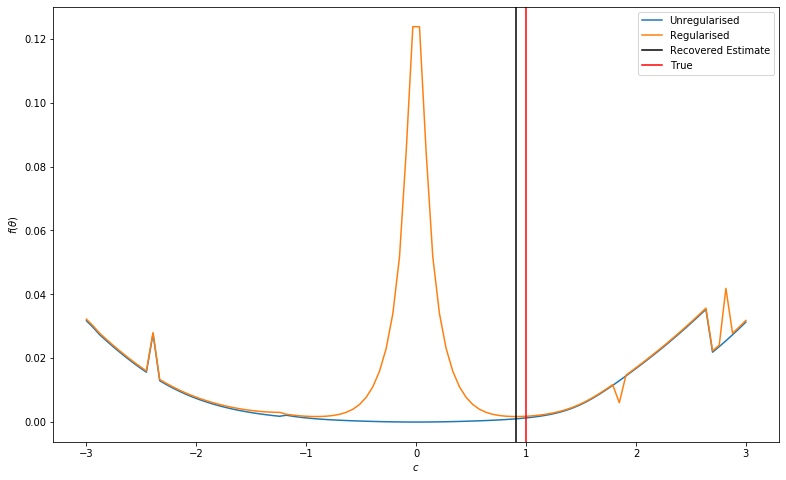

In [53]:
fs = [float(pf['f']) for pf in profile]
fs_r = [float(pf['f']) for pf in profile_r]

plt.plot(pvals.flatten(), fs, label="Unregularised")
plt.plot(pvals.flatten(), fs_r, label="Regularised")
plt.axvline(float(pref[0]), color='k', label="Recovered Estimate")
plt.axvline(float(p_true[0]), color='r', label="True")
plt.xlabel("$c$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('linear')

In [47]:
profile_other = []
profile_rother = []
pvals_other = np.linspace(-5, 15, 100)

for pval in pvals_other:
    lbg = np.array([-np.inf, pval])
    ubg = np.array([np.inf, pval])
    profile_other.append(profiler(x0=solutions[idx]['x'], p=[rho, 0], lbg=lbg, ubg=ubg))
    profile_rother.append(profiler(x0=solutions[idx]['x'], p=[rho, (np.log10(rho)+6)*1e-5], lbg=lbg, ubg=ubg))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   1  1.5576672e+01 0.00e+00 1.35e+01  -1.0 8.39e+00    -  1.00e+00 1.00e+00h  1
   2  1.4573967e+01 0.00e+00 6.51e+00  -1.0 6.50e-02   2.0 1.00e+00 1.00e+00f  1
   3  1.2115692e+01 0.00e+00 5.85e+00  -1.0 1.75e-01   1.5 1.00e+00 1.00e+00f  1
   4  7.6402310e+00 0.00e+00 4.52e+00  -1.0 3.98e-01   1.0 1.00e+00 1.00e+00f  1
   5  2.8476465e+00 0.00e+00 2.56e+00  -1.0 6.73e-01   0.6 1.00e+00 1.00e+00f  1
   6  7.3760863e-01 0.00e+00 8.11e-01  -1.0 6.57e-01   0.1 1.00e+00 1.00e+00f  1
   7  5.3715601e-01 0.00e+00 1.32e-01  -1.7 2.05e-01  -0.4 1.00e+00 1.00e+00f  1
   8  1.1877699e-01 0.00e+00 4.95e-02  -2.5 1.77e+00    -  1.00e+00 1.00e+00f  1
   9  1.0535598e-01 0.00e+00 2.03e-02  -2.5 1.48e-01  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.3780272e-02 0.00e+00 1.57e-02  -3.8 8.68e-01    -  1.00e+00 2.50e-01f  3
  11  9.0445656e-02 0.00e+00 3.83e-04  -3.8 2.25e-01    -  1.00e+00 1.00e+00f  1
  12  9.0444574e-02 0.00e+00

   2  9.6806441e-01 0.00e+00 2.90e+00  -1.0 4.06e+00   0.0 1.00e+00 5.00e-01f  2
   3  1.2140517e-01 0.00e+00 5.67e-02  -1.0 2.26e+00    -  1.00e+00 1.00e+00f  1
   4  1.1764996e-01 0.00e+00 2.26e-02  -2.5 6.79e-02  -0.5 1.00e+00 1.00e+00f  1
   5  1.1073537e-01 0.00e+00 1.52e-02  -3.8 1.37e-01  -1.0 1.00e+00 1.00e+00f  1
   6  9.7932465e-02 0.00e+00 9.41e-03  -3.8 2.54e-01  -1.4 1.00e+00 1.00e+00f  1
   7  9.6183335e-02 0.00e+00 1.14e-02  -3.8 1.91e-01    -  1.00e+00 1.00e+00f  1
   8  9.5039054e-02 0.00e+00 1.32e-03  -3.8 6.06e-02    -  1.00e+00 1.00e+00f  1
   9  9.5010242e-02 0.00e+00 4.87e-05  -5.7 1.32e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  9.5010211e-02 0.00e+00 4.02e-08  -5.7 4.40e-04    -  1.00e+00 1.00e+00f  1
  11  9.5010211e-02 0.00e+00 8.17e-14  -8.6 5.63e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objecti

   3  1.1866468e+00 0.00e+00 1.74e+00  -1.0 8.18e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.3213328e-01 0.00e+00 3.51e-02  -1.0 3.10e+00    -  1.00e+00 1.00e+00f  1
   5  1.2931535e-01 0.00e+00 4.64e-03  -2.5 4.17e-02  -1.0 1.00e+00 1.00e+00f  1
   6  1.2661164e-01 0.00e+00 3.12e-03  -3.8 8.42e-02  -1.4 1.00e+00 1.00e+00f  1
   7  1.2503332e-01 0.00e+00 1.27e-03  -3.8 1.03e-01  -1.9 1.00e+00 1.00e+00f  1
   8  1.2466056e-01 0.00e+00 2.42e-04  -5.7 5.86e-02  -2.4 1.00e+00 1.00e+00f  1
   9  1.2408453e-01 0.00e+00 7.47e-03  -5.7 1.86e-01  -2.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1213259e-01 0.00e+00 4.93e-02  -5.7 6.01e-01  -2.4 1.00e+00 1.00e+00f  1
  11  1.0304313e-01 0.00e+00 2.77e-02  -5.7 2.23e+00    -  1.00e+00 1.25e-01f  4
  12  9.8861044e-02 0.00e+00 2.82e-03  -5.7 1.68e-01    -  1.00e+00 1.00e+00f  1
  13  9.8356128e-02 0.00e+00 1.45e-03  -5.7 4.38e-02    -  1.00e+00 1.00e+00f  1
  14  9.8346032e-02 0.00e+00

   5  1.1482468e-01 0.00e+00 1.25e-02  -2.5 1.12e-01  -1.0 1.00e+00 1.00e+00f  1
   6  1.0568142e-01 0.00e+00 7.50e-03  -3.8 2.02e-01  -1.4 1.00e+00 1.00e+00f  1
   7  1.0347626e-01 0.00e+00 5.09e-03  -3.8 1.47e-01    -  1.00e+00 1.00e+00f  1
   8  1.0325783e-01 0.00e+00 3.89e-04  -3.8 3.79e-02    -  1.00e+00 1.00e+00f  1
   9  1.0325623e-01 0.00e+00 3.04e-06  -5.7 3.93e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0325623e-01 0.00e+00 2.52e-10  -8.6 3.63e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0325623295934486e-01    1.0325623295934486e-01
Dual infeasibility......:   2.5159480054881556e-10    2.5159480054881556e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error......

Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 12
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.086

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 594.00us ( 49.50us) 560.06us ( 46.67us)        12
       nlp_g  |  43.00us (  3.58us)  43.08us (  3.59us)        12
    nlp_grad  | 110.00us (110.00us) 110.19us (110.19us)         1
  nlp_grad_f  |   1.52ms (116.92us)   1.49ms (114.62us)        13
  nlp_hess_l  |  83.28ms (  7.57ms)  83.29ms (  7.57ms)        11
   nlp_jac_g  |  59.00us (  4.54us)  56.33us (  4.33us)        13
       total  |  98.99ms ( 98.99ms)  98.20ms ( 98.20ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other l

   1  5.5253057e+00 0.00e+00 4.82e+00  -1.0 6.77e+00    -  1.00e+00 1.00e+00h  1
   2  1.5262602e+00 0.00e+00 1.16e+00  -1.0 1.16e+00   0.0 1.00e+00 1.00e+00f  1
   3  5.7122040e-01 0.00e+00 3.55e-01  -1.0 7.64e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.2129392e-01 0.00e+00 2.67e-02  -1.7 1.79e+00    -  1.00e+00 1.00e+00f  1
   5  1.1883574e-01 0.00e+00 9.38e-03  -3.8 8.45e-02  -1.0 1.00e+00 1.00e+00f  1
   6  1.1471863e-01 0.00e+00 5.64e-03  -3.8 1.52e-01  -1.4 1.00e+00 1.00e+00f  1
   7  1.1194972e-01 0.00e+00 1.45e-02  -3.8 1.11e+00    -  1.00e+00 2.50e-01f  3
   8  1.1061945e-01 0.00e+00 2.42e-03  -3.8 7.60e-02    -  1.00e+00 1.00e+00f  1
   9  1.1058075e-01 0.00e+00 2.44e-05  -3.8 2.15e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.1058068e-01 0.00e+00 2.16e-07  -5.7 8.68e-04    -  1.00e+00 1.00e+00f  1
  11  1.1058068e-01 0.00e+00 1.84e-13  -8.6 1.97e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 1

  11  1.2377175e-01 0.00e+00 2.52e-04  -5.7 9.76e-02  -3.8 1.00e+00 1.00e+00f  1
  12  1.2376046e-01 0.00e+00 1.24e-04  -5.7 3.48e-02  -3.4 1.00e+00 1.00e+00f  1
  13  1.2343877e-01 0.00e+00 8.49e-03  -5.7 2.95e-01  -3.9 1.00e+00 1.00e+00f  1
  14  1.2018118e-01 0.00e+00 5.98e-03  -5.7 3.50e-01  -2.5 1.00e+00 1.00e+00f  1
  15  1.1655672e-01 0.00e+00 1.76e-03  -5.7 1.88e-01  -2.1 1.00e+00 1.00e+00f  1
  16  1.1602787e-01 0.00e+00 1.59e-03  -5.7 1.54e-01    -  1.00e+00 1.00e+00f  1
  17  1.1596152e-01 0.00e+00 1.36e-04  -5.7 2.93e-02    -  1.00e+00 1.00e+00f  1
  18  1.1596115e-01 0.00e+00 7.46e-07  -5.7 2.22e-03    -  1.00e+00 1.00e+00f  1
  19  1.1596115e-01 0.00e+00 3.71e-11  -8.6 1.43e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:   1.1596115489576210e-01    1.1596115489576210e-01
Dual infeasibility......:   3.7079270209794402e-11    3.7079270209794402e-11
Constraint viol

  22  1.1891418e-01 0.00e+00 3.63e-03  -8.6 4.62e+00  -2.3 1.00e+00 6.25e-02f  5
  23  1.1849237e-01 0.00e+00 1.65e-03  -8.6 8.80e-02    -  1.00e+00 1.00e+00f  1
  24  1.1846568e-01 0.00e+00 4.55e-05  -8.6 1.90e-02    -  1.00e+00 1.00e+00f  1
  25  1.1846561e-01 0.00e+00 2.18e-07  -8.6 9.15e-04    -  1.00e+00 1.00e+00f  1
  26  1.1846561e-01 0.00e+00 1.32e-12  -8.6 2.81e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   1.1846561215064841e-01    1.1846561215064841e-01
Dual infeasibility......:   1.3152395839099995e-12    1.3152395839099995e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.3152395839099995e-12    1.3152395839099995e-12


Number of objective function evaluations             = 55
Number of objective gradient evaluations        

Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   8.7915785762504584e-14    8.7915785762504584e-14


Number of objective function evaluations             = 18
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 18
Number of inequality constraint evaluations          = 18
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPOPT (w/o function evaluations)   =      0.015
Total CPU secs in NLP function evaluations           =      0.092

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 769.00us ( 42.72us) 774.16us ( 43.01us)        18
       nlp_g  |  56.00us (  3.11us)  53.40us (  2.97us)        18
    nlp_grad  | 111.00us (111.00us) 110.93us (110.93us)         1
  nlp_grad_

   1  1.8254330e+00 4.44e-16 1.41e+00  -1.0 5.36e+00    -  1.00e+00 1.00e+00h  1
   2  1.1596406e+00 0.00e+00 4.99e-01  -1.0 4.67e-01   0.0 1.00e+00 1.00e+00f  1
   3  6.2896396e-01 0.00e+00 2.51e-01  -1.7 6.51e-01  -0.5 1.00e+00 1.00e+00f  1
   4  4.0476166e-01 0.00e+00 9.68e-02  -1.7 4.67e-01  -1.0 1.00e+00 1.00e+00f  1
   5  2.5395066e-01 0.00e+00 4.39e-02  -2.5 5.46e-01  -1.4 1.00e+00 1.00e+00f  1
   6  1.2402509e-01 0.00e+00 3.89e-03  -2.5 9.33e-01    -  1.00e+00 1.00e+00f  1
   7  1.2384578e-01 0.00e+00 9.99e-04  -3.8 1.27e-01    -  1.00e+00 1.00e+00f  1
   8  1.2382620e-01 0.00e+00 3.83e-05  -5.7 7.90e-02    -  1.00e+00 1.00e+00f  1
   9  1.2382616e-01 0.00e+00 4.00e-07  -5.7 3.63e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2382616e-01 0.00e+00 6.87e-10  -8.6 1.44e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

  31  1.2384370e-01 0.00e+00 7.31e-04  -8.6 9.65e-01    -  1.00e+00 5.00e-01f  2
  32  1.2384369e-01 0.00e+00 2.86e-05  -8.6 1.68e-01    -  1.00e+00 1.00e+00f  1
  33  1.2384368e-01 0.00e+00 3.00e-04  -8.6 1.31e+00    -  1.00e+00 2.50e-01f  3
  34  1.2384368e-01 0.00e+00 2.32e-04  -8.6 3.29e-01    -  1.00e+00 1.00e+00f  1
  35  1.2384367e-01 0.00e+00 3.56e-04  -8.6 4.05e-01    -  1.00e+00 1.00e+00f  1
  36  1.2384366e-01 0.00e+00 1.53e-04  -8.6 2.91e-01    -  1.00e+00 1.00e+00f  1
  37  1.2384366e-01 0.00e+00 6.80e-04  -8.6 5.70e-01    -  1.00e+00 1.00e+00f  1
  38  1.2384366e-01 0.00e+00 2.88e-05  -8.6 1.79e-01    -  1.00e+00 1.00e+00f  1
  39  1.2384365e-01 0.00e+00 3.21e-04  -8.6 1.58e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.2384365e-01 0.00e+00 1.62e-04  -8.6 3.23e-01    -  1.00e+00 1.00e+00f  1
  41  1.2384365e-01 0.00e+00 5.47e-04  -8.6 5.65e-01    -  1.00e+00 1.00e+00f  1
  42  1.2384365e-01 0.00e+00

 136  1.2384362e-01 0.00e+00 1.52e-04  -8.6 2.94e+00    -  1.00e+00 2.50e-01f  3
 137  1.2384362e-01 0.00e+00 1.18e-04  -8.6 7.22e-01    -  1.00e+00 1.00e+00f  1
 138  1.2384362e-01 0.00e+00 1.91e-04  -8.6 9.20e-01    -  1.00e+00 1.00e+00f  1
 139  1.2384362e-01 0.00e+00 7.23e-05  -8.6 5.79e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.2384362e-01 0.00e+00 1.54e-04  -8.6 1.46e+00    -  1.00e+00 5.00e-01f  2
 141  1.2384362e-01 0.00e+00 1.09e-04  -8.6 7.11e-01    -  1.00e+00 1.00e+00f  1
 142  1.2384362e-01 0.00e+00 2.13e-04  -8.6 9.91e-01    -  1.00e+00 1.00e+00f  1
 143  1.2384362e-01 0.00e+00 5.57e-05  -8.6 5.23e-01    -  1.00e+00 1.00e+00f  1
 144  1.2384362e-01 0.00e+00 2.13e-04  -8.6 1.86e+00    -  1.00e+00 5.00e-01f  2
 145  1.2384362e-01 0.00e+00 5.47e-05  -8.6 5.24e-01    -  1.00e+00 1.00e+00f  1
 146  1.2384362e-01 0.00e+00 2.15e-04  -8.6 1.89e+00    -  1.00e+00 5.00e-01f  2
 147  1.2384362e-01 0.00e+00

 241  1.2384362e-01 0.00e+00 1.06e-04  -8.6 3.78e+00    -  1.00e+00 2.50e-01f  3
 242  1.2384362e-01 0.00e+00 1.02e-04  -8.6 1.04e+00    -  1.00e+00 1.00e+00f  1
 243  1.2384362e-01 0.00e+00 1.09e-04  -8.6 1.08e+00    -  1.00e+00 1.00e+00f  1
 244  1.2384362e-01 0.00e+00 9.58e-05  -8.6 1.02e+00    -  1.00e+00 1.00e+00f  1
 245  1.2384362e-01 0.00e+00 1.23e-04  -8.6 1.15e+00    -  1.00e+00 1.00e+00f  1
 246  1.2384362e-01 0.00e+00 7.46e-05  -8.6 9.07e-01    -  1.00e+00 1.00e+00f  1
 247  1.2384362e-01 0.00e+00 1.98e-04  -8.6 1.47e+00    -  1.00e+00 1.00e+00f  1
 248  1.2384362e-01 0.00e+00 2.81e-05  -8.6 5.70e-01    -  1.00e+00 1.00e+00f  1
 249  1.2384362e-01 0.00e+00 9.99e-05  -8.6 3.73e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.2384362e-01 0.00e+00 1.09e-04  -8.6 1.11e+00    -  1.00e+00 1.00e+00f  1
 251  1.2384362e-01 0.00e+00 9.08e-05  -8.6 1.01e+00    -  1.00e+00 1.00e+00f  1
 252  1.2384362e-01 0.00e+00

 341  1.2384362e-01 0.00e+00 8.67e-05  -8.6 2.08e+00    -  1.00e+00 5.00e-01f  2
 342  1.2384362e-01 0.00e+00 9.06e-05  -8.6 1.28e+00    -  1.00e+00 1.00e+00f  1
 343  1.2384362e-01 0.00e+00 8.25e-05  -8.6 1.23e+00    -  1.00e+00 1.00e+00f  1
 344  1.2384362e-01 0.00e+00 9.89e-05  -8.6 1.35e+00    -  1.00e+00 1.00e+00f  1
 345  1.2384362e-01 0.00e+00 6.87e-05  -8.6 1.13e+00    -  1.00e+00 1.00e+00f  1
 346  1.2384362e-01 0.00e+00 1.41e-04  -8.6 1.61e+00    -  1.00e+00 1.00e+00f  1
 347  1.2384362e-01 0.00e+00 3.35e-05  -8.6 7.97e-01    -  1.00e+00 1.00e+00f  1
 348  1.2384362e-01 0.00e+00 1.58e-04  -8.6 3.24e+00    -  1.00e+00 5.00e-01f  2
 349  1.2384362e-01 0.00e+00 2.63e-05  -8.6 7.11e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.2384362e-01 0.00e+00 7.56e-05  -8.6 4.09e+00    -  1.00e+00 2.50e-01f  3
 351  1.2384362e-01 0.00e+00 1.14e-04  -8.6 1.47e+00    -  1.00e+00 1.00e+00f  1
 352  1.2384362e-01 0.00e+00

 447  1.2384362e-01 0.00e+00 1.39e-05  -8.6 6.29e-01    -  1.00e+00 1.00e+00f  1
 448  1.2384362e-01 0.00e+00 1.43e-04  -8.6 7.59e+00    -  1.00e+00 2.50e-01f  3
 449  1.2384362e-01 0.00e+00 2.21e-05  -8.6 7.89e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  1.2384362e-01 0.00e+00 7.05e-05  -8.6 4.87e+00    -  1.00e+00 2.50e-01f  3
 451  1.2384362e-01 0.00e+00 9.00e-05  -8.6 1.58e+00    -  1.00e+00 1.00e+00f  1
 452  1.2384362e-01 0.00e+00 5.51e-05  -8.6 1.24e+00    -  1.00e+00 1.00e+00f  1
 453  1.2384362e-01 0.00e+00 1.45e-04  -8.6 2.01e+00    -  1.00e+00 1.00e+00f  1
 454  1.2384362e-01 0.00e+00 2.09e-05  -8.6 7.75e-01    -  1.00e+00 1.00e+00f  1
 455  1.2384362e-01 0.00e+00 7.52e-05  -8.6 5.15e+00    -  1.00e+00 2.50e-01f  3
 456  1.2384362e-01 0.00e+00 7.80e-05  -8.6 1.48e+00    -  1.00e+00 1.00e+00f  1
 457  1.2384362e-01 0.00e+00 7.21e-05  -8.6 1.43e+00    -  1.00e+00 1.00e+00f  1
 458  1.2384362e-01 0.00e+00

 549  1.2384362e-01 0.00e+00 8.05e-05  -8.6 3.04e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  1.2384362e-01 0.00e+00 5.16e-05  -8.6 1.39e+00    -  1.00e+00 1.00e+00f  1
 551  1.2384362e-01 0.00e+00 1.23e-04  -8.6 2.14e+00    -  1.00e+00 1.00e+00f  1
 552  1.2384362e-01 0.00e+00 2.18e-05  -8.6 9.12e-01    -  1.00e+00 1.00e+00f  1
 553  1.2384362e-01 0.00e+00 5.86e-05  -8.6 5.04e+00    -  1.00e+00 2.50e-01f  3
 554  1.2384362e-01 0.00e+00 9.62e-05  -8.6 1.91e+00    -  1.00e+00 1.00e+00f  1
 555  1.2384362e-01 0.00e+00 3.55e-05  -8.6 1.16e+00    -  1.00e+00 1.00e+00f  1
 556  1.2384362e-01 0.00e+00 8.16e-05  -8.6 3.11e+00    -  1.00e+00 5.00e-01f  2
 557  1.2384362e-01 0.00e+00 4.94e-05  -8.6 1.37e+00    -  1.00e+00 1.00e+00f  1
 558  1.2384362e-01 0.00e+00 1.33e-04  -8.6 2.25e+00    -  1.00e+00 1.00e+00f  1
 559  1.2384362e-01 0.00e+00 1.85e-05  -8.6 8.50e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 652  1.2384362e-01 0.00e+00 3.52e-05  -8.6 1.31e+00    -  1.00e+00 1.00e+00f  1
 653  1.2384362e-01 0.00e+00 6.81e-05  -8.6 3.13e+00    -  1.00e+00 5.00e-01f  2
 654  1.2384362e-01 0.00e+00 5.52e-05  -8.6 1.64e+00    -  1.00e+00 1.00e+00f  1
 655  1.2384362e-01 0.00e+00 8.29e-05  -8.6 2.01e+00    -  1.00e+00 1.00e+00f  1
 656  1.2384362e-01 0.00e+00 3.73e-05  -8.6 1.35e+00    -  1.00e+00 1.00e+00f  1
 657  1.2384362e-01 0.00e+00 6.35e-05  -8.6 2.96e+00    -  1.00e+00 5.00e-01f  2
 658  1.2384362e-01 0.00e+00 6.34e-05  -8.6 1.76e+00    -  1.00e+00 1.00e+00f  1
 659  1.2384362e-01 0.00e+00 6.23e-05  -8.6 1.75e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660  1.2384362e-01 0.00e+00 6.51e-05  -8.6 1.79e+00    -  1.00e+00 1.00e+00f  1
 661  1.2384362e-01 0.00e+00 5.83e-05  -8.6 1.70e+00    -  1.00e+00 1.00e+00f  1
 662  1.2384362e-01 0.00e+00 7.43e-05  -8.6 1.92e+00    -  1.00e+00 1.00e+00f  1
 663  1.2384362e-01 0.00e+00

 756  1.2384362e-01 0.00e+00 7.40e-05  -8.6 7.85e+00    -  1.00e+00 2.50e-01f  3
 757  1.2384362e-01 0.00e+00 3.75e-05  -8.6 1.51e+00    -  1.00e+00 1.00e+00f  1
 758  1.2384362e-01 0.00e+00 1.38e-04  -8.6 2.89e+00    -  1.00e+00 1.00e+00f  1
 759  1.2384362e-01 0.00e+00 1.06e-05  -8.6 8.14e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760  1.2384362e-01 0.00e+00 1.06e-04  -8.6 9.78e+00    -  1.00e+00 2.50e-01f  3
 761  1.2384362e-01 0.00e+00 1.80e-05  -8.6 1.06e+00    -  1.00e+00 1.00e+00f  1
 762  1.2384362e-01 0.00e+00 5.33e-05  -8.6 6.24e+00    -  1.00e+00 2.50e-01f  3
 763  1.2384362e-01 0.00e+00 6.98e-05  -8.6 2.07e+00    -  1.00e+00 1.00e+00f  1
 764  1.2384362e-01 0.00e+00 4.15e-05  -8.6 1.60e+00    -  1.00e+00 1.00e+00f  1
 765  1.2384362e-01 0.00e+00 1.19e-04  -8.6 2.71e+00    -  1.00e+00 1.00e+00f  1
 766  1.2384362e-01 0.00e+00 1.40e-05  -8.6 9.39e-01    -  1.00e+00 1.00e+00f  1
 767  1.2384362e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  1.2384362e-01 0.00e+00 1.67e-05  -8.6 1.12e+00    -  1.00e+00 1.00e+00f  1
 861  1.2384362e-01 0.00e+00 4.98e-05  -8.6 6.63e+00    -  1.00e+00 2.50e-01f  3
 862  1.2384362e-01 0.00e+00 6.74e-05  -8.6 2.23e+00    -  1.00e+00 1.00e+00f  1
 863  1.2384362e-01 0.00e+00 3.57e-05  -8.6 1.63e+00    -  1.00e+00 1.00e+00f  1
 864  1.2384362e-01 0.00e+00 1.26e-04  -8.6 3.05e+00    -  1.00e+00 1.00e+00f  1
 865  1.2384362e-01 0.00e+00 1.02e-05  -8.6 8.81e-01    -  1.00e+00 1.00e+00f  1
 866  1.2384362e-01 0.00e+00 9.03e-05  -8.6 9.91e+00    -  1.00e+00 2.50e-01f  3
 867  1.2384362e-01 0.00e+00 1.98e-05  -8.6 1.22e+00    -  1.00e+00 1.00e+00f  1
 868  1.2384362e-01 0.00e+00 1.09e-04  -8.6 5.43e+00    -  1.00e+00 5.00e-01f  2
 869  1.2384362e-01 0.00e+00 1.37e-05  -8.6 1.02e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870  1.2384362e-01 0.00e+00

 961  1.2384362e-01 0.00e+00 1.28e-04  -8.6 6.47e+00    -  1.00e+00 5.00e-01f  2
 962  1.2384362e-01 0.00e+00 8.50e-06  -8.6 8.71e-01    -  1.00e+00 1.00e+00f  1
 963  1.2384362e-01 0.00e+00 6.37e-05  -8.6 8.96e+00    -  1.00e+00 2.50e-01f  3
 964  1.2384362e-01 0.00e+00 3.48e-05  -8.6 1.75e+00    -  1.00e+00 1.00e+00f  1
 965  1.2384362e-01 0.00e+00 1.26e-04  -8.6 3.33e+00    -  1.00e+00 1.00e+00f  1
 966  1.2384362e-01 0.00e+00 8.78e-06  -8.6 8.87e-01    -  1.00e+00 1.00e+00f  1
 967  1.2384362e-01 0.00e+00 4.96e-05  -8.6 1.54e+01    -  1.00e+00 1.25e-01f  4
 968  1.2384362e-01 0.00e+00 5.76e-05  -8.6 2.26e+00    -  1.00e+00 1.00e+00f  1
 969  1.2384362e-01 0.00e+00 3.69e-05  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970  1.2384362e-01 0.00e+00 9.72e-05  -8.6 2.93e+00    -  1.00e+00 1.00e+00f  1
 971  1.2384362e-01 0.00e+00 1.45e-05  -8.6 1.14e+00    -  1.00e+00 1.00e+00f  1
 972  1.2384362e-01 0.00e+00

1066  1.2384362e-01 0.00e+00 1.85e-05  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
1067  1.2384362e-01 0.00e+00 6.79e-05  -8.6 4.90e+00    -  1.00e+00 5.00e-01f  2
1068  1.2384362e-01 0.00e+00 2.43e-05  -8.6 1.58e+00    -  1.00e+00 1.00e+00f  1
1069  1.2384362e-01 0.00e+00 7.35e-05  -8.6 5.01e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070  1.2384362e-01 0.00e+00 1.91e-05  -8.6 1.40e+00    -  1.00e+00 1.00e+00f  1
1071  1.2384362e-01 0.00e+00 6.21e-05  -8.6 4.64e+00    -  1.00e+00 5.00e-01f  2
1072  1.2384362e-01 0.00e+00 3.36e-05  -8.6 1.86e+00    -  1.00e+00 1.00e+00f  1
1073  1.2384362e-01 0.00e+00 1.01e-04  -8.6 3.23e+00    -  1.00e+00 1.00e+00f  1
1074  1.2384362e-01 0.00e+00 1.24e-05  -8.6 1.14e+00    -  1.00e+00 1.00e+00f  1
1075  1.2384362e-01 0.00e+00 4.33e-05  -8.6 7.49e+00    -  1.00e+00 2.50e-01f  3
1076  1.2384362e-01 0.00e+00 7.28e-05  -8.6 2.75e+00    -  1.00e+00 1.00e+00f  1
1077  1.2384362e-01 0.00e+00

  56  1.2396927e-01 0.00e+00 4.18e-05  -5.7 2.41e-01    -  1.00e+00 1.00e+00f  1
  57  1.2396927e-01 0.00e+00 2.24e-04  -5.7 1.77e+00    -  1.00e+00 2.50e-01f  3
  58  1.2396927e-01 0.00e+00 1.98e-04  -5.7 4.70e-01    -  1.00e+00 1.00e+00f  1
  59  1.2396927e-01 0.00e+00 2.44e-04  -5.7 5.24e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2396927e-01 0.00e+00 1.60e-04  -5.7 4.38e-01    -  1.00e+00 1.00e+00f  1
  61  1.2396927e-01 0.00e+00 3.48e-04  -5.7 6.37e-01    -  1.00e+00 1.00e+00f  1
  62  1.2396927e-01 0.00e+00 7.37e-05  -5.7 3.21e-01    -  1.00e+00 1.00e+00f  1
  63  1.2396927e-01 0.00e+00 3.50e-04  -5.7 1.23e+00    -  1.00e+00 5.00e-01f  2
  64  1.2396927e-01 0.00e+00 6.94e-05  -5.7 3.20e-01    -  1.00e+00 1.00e+00f  1
  65  1.2396927e-01 0.00e+00 3.70e-04  -5.7 1.30e+00    -  1.00e+00 5.00e-01f  2
  66  1.2396927e-01 0.00e+00 5.90e-05  -5.7 3.06e-01    -  1.00e+00 1.00e+00f  1
  67  1.2396927e-01 0.00e+00

 157  1.2396927e-01 0.00e+00 2.20e-05  -5.7 3.69e-01    -  1.00e+00 1.00e+00f  1
 158  1.2396927e-01 0.00e+00 2.31e-04  -5.7 4.32e+00    -  1.00e+00 2.50e-01f  3
 159  1.2396927e-01 0.00e+00 4.05e-05  -5.7 4.90e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.2396927e-01 0.00e+00 3.13e-04  -5.7 2.54e+00    -  1.00e+00 5.00e-01f  2
 161  1.2396927e-01 0.00e+00 2.13e-05  -5.7 3.69e-01    -  1.00e+00 1.00e+00f  1
 162  1.2396927e-01 0.00e+00 2.38e-04  -5.7 4.48e+00    -  1.00e+00 2.50e-01f  3
 163  1.2396927e-01 0.00e+00 3.69e-05  -5.7 4.78e-01    -  1.00e+00 1.00e+00f  1
 164  1.2396927e-01 0.00e+00 1.11e-04  -5.7 2.78e+00    -  1.00e+00 2.50e-01f  3
 165  1.2396927e-01 0.00e+00 1.67e-04  -5.7 9.92e-01    -  1.00e+00 1.00e+00f  1
 166  1.2396927e-01 0.00e+00 7.37e-05  -5.7 6.71e-01    -  1.00e+00 1.00e+00f  1
 167  1.2396927e-01 0.00e+00 1.27e-04  -5.7 1.47e+00    -  1.00e+00 5.00e-01f  2
 168  1.2396927e-01 0.00e+00

 263  1.2396927e-01 0.00e+00 1.03e-04  -8.6 1.12e+00    -  1.00e+00 1.00e+00f  1
 264  1.2396927e-01 0.00e+00 9.57e-05  -8.6 1.09e+00    -  1.00e+00 1.00e+00f  1
 265  1.2396927e-01 0.00e+00 1.10e-04  -8.6 1.17e+00    -  1.00e+00 1.00e+00f  1
 266  1.2396927e-01 0.00e+00 8.29e-05  -8.6 1.02e+00    -  1.00e+00 1.00e+00f  1
 267  1.2396927e-01 0.00e+00 1.44e-04  -8.6 1.34e+00    -  1.00e+00 1.00e+00f  1
 268  1.2396927e-01 0.00e+00 4.77e-05  -8.6 7.83e-01    -  1.00e+00 1.00e+00f  1
 269  1.2396927e-01 0.00e+00 1.28e-04  -8.6 2.29e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.2396927e-01 0.00e+00 5.96e-05  -8.6 8.77e-01    -  1.00e+00 1.00e+00f  1
 271  1.2396927e-01 0.00e+00 9.70e-05  -8.6 1.85e+00    -  1.00e+00 5.00e-01f  2
 272  1.2396927e-01 0.00e+00 1.03e-04  -8.6 1.15e+00    -  1.00e+00 1.00e+00f  1
 273  1.2396927e-01 0.00e+00 9.08e-05  -8.6 1.09e+00    -  1.00e+00 1.00e+00f  1
 274  1.2396927e-01 0.00e+00

 369  1.2396926e-01 0.00e+00 1.51e-04  -8.6 6.73e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.2396926e-01 0.00e+00 2.68e-05  -8.6 7.52e-01    -  1.00e+00 1.00e+00f  1
 371  1.2396926e-01 0.00e+00 7.03e-05  -8.6 4.07e+00    -  1.00e+00 2.50e-01f  3
 372  1.2396926e-01 0.00e+00 1.22e-04  -8.6 1.59e+00    -  1.00e+00 1.00e+00f  1
 373  1.2396926e-01 0.00e+00 4.06e-05  -8.6 9.26e-01    -  1.00e+00 1.00e+00f  1
 374  1.2396926e-01 0.00e+00 1.09e-04  -8.6 2.73e+00    -  1.00e+00 5.00e-01f  2
 375  1.2396926e-01 0.00e+00 5.01e-05  -8.6 1.03e+00    -  1.00e+00 1.00e+00f  1
 376  1.2396926e-01 0.00e+00 8.35e-05  -8.6 2.22e+00    -  1.00e+00 5.00e-01f  2
 377  1.2396926e-01 0.00e+00 8.52e-05  -8.6 1.34e+00    -  1.00e+00 1.00e+00f  1
 378  1.2396926e-01 0.00e+00 8.16e-05  -8.6 1.32e+00    -  1.00e+00 1.00e+00f  1
 379  1.2396926e-01 0.00e+00 8.84e-05  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 472  1.2396926e-01 0.00e+00 1.05e-04  -8.6 1.77e+00    -  1.00e+00 1.00e+00f  1
 473  1.2396926e-01 0.00e+00 3.85e-05  -8.6 1.08e+00    -  1.00e+00 1.00e+00f  1
 474  1.2396926e-01 0.00e+00 8.89e-05  -8.6 2.89e+00    -  1.00e+00 5.00e-01f  2
 475  1.2396926e-01 0.00e+00 5.33e-05  -8.6 1.27e+00    -  1.00e+00 1.00e+00f  1
 476  1.2396926e-01 0.00e+00 1.47e-04  -8.6 2.10e+00    -  1.00e+00 1.00e+00f  1
 477  1.2396926e-01 0.00e+00 1.94e-05  -8.6 7.76e-01    -  1.00e+00 1.00e+00f  1
 478  1.2396926e-01 0.00e+00 8.00e-05  -8.6 5.63e+00    -  1.00e+00 2.50e-01f  3
 479  1.2396926e-01 0.00e+00 6.48e-05  -8.6 1.41e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.2396926e-01 0.00e+00 9.82e-05  -8.6 1.73e+00    -  1.00e+00 1.00e+00f  1
 481  1.2396926e-01 0.00e+00 4.28e-05  -8.6 1.15e+00    -  1.00e+00 1.00e+00f  1
 482  1.2396926e-01 0.00e+00 7.67e-05  -8.6 2.61e+00    -  1.00e+00 5.00e-01f  2
 483  1.2396926e-01 0.00e+00

 577  1.2396926e-01 0.00e+00 8.73e-05  -8.6 3.38e+00    -  1.00e+00 5.00e-01f  2
 578  1.2396926e-01 0.00e+00 4.09e-05  -8.6 1.29e+00    -  1.00e+00 1.00e+00f  1
 579  1.2396926e-01 0.00e+00 1.71e-04  -8.6 2.72e+00    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580  1.2396926e-01 0.00e+00 1.06e-05  -8.6 6.69e-01    -  1.00e+00 1.00e+00f  1
 581  1.2396926e-01 0.00e+00 1.62e-04  -8.6 1.00e+01    -  1.00e+00 2.50e-01f  3
 582  1.2396926e-01 0.00e+00 1.17e-05  -8.6 7.03e-01    -  1.00e+00 1.00e+00f  1
 583  1.2396926e-01 0.00e+00 1.36e-04  -8.6 9.15e+00    -  1.00e+00 2.50e-01f  3
 584  1.2396926e-01 0.00e+00 1.65e-05  -8.6 8.34e-01    -  1.00e+00 1.00e+00f  1
 585  1.2396926e-01 0.00e+00 7.69e-05  -8.6 6.53e+00    -  1.00e+00 2.50e-01f  3
 586  1.2396926e-01 0.00e+00 5.14e-05  -8.6 1.46e+00    -  1.00e+00 1.00e+00f  1
 587  1.2396926e-01 0.00e+00 1.14e-04  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
 588  1.2396926e-01 0.00e+00

 682  1.2396926e-01 0.00e+00 4.18e-05  -8.6 1.48e+00    -  1.00e+00 1.00e+00f  1
 683  1.2396926e-01 0.00e+00 1.37e-04  -8.6 2.67e+00    -  1.00e+00 1.00e+00f  1
 684  1.2396926e-01 0.00e+00 1.30e-05  -8.6 8.34e-01    -  1.00e+00 1.00e+00f  1
 685  1.2396926e-01 0.00e+00 9.35e-05  -8.6 8.38e+00    -  1.00e+00 2.50e-01f  3
 686  1.2396926e-01 0.00e+00 2.78e-05  -8.6 1.22e+00    -  1.00e+00 1.00e+00f  1
 687  1.2396926e-01 0.00e+00 9.30e-05  -8.6 4.08e+00    -  1.00e+00 5.00e-01f  2
 688  1.2396926e-01 0.00e+00 2.76e-05  -8.6 1.21e+00    -  1.00e+00 1.00e+00f  1
 689  1.2396926e-01 0.00e+00 9.08e-05  -8.6 4.04e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.2396926e-01 0.00e+00 2.90e-05  -8.6 1.25e+00    -  1.00e+00 1.00e+00f  1
 691  1.2396926e-01 0.00e+00 8.23e-05  -8.6 3.80e+00    -  1.00e+00 5.00e-01f  2
 692  1.2396926e-01 0.00e+00 3.53e-05  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
 693  1.2396926e-01 0.00e+00

 791  1.2396926e-01 0.00e+00 5.33e-05  -8.6 1.87e+00    -  1.00e+00 1.00e+00f  1
 792  1.2396926e-01 0.00e+00 6.79e-05  -8.6 2.11e+00    -  1.00e+00 1.00e+00f  1
 793  1.2396926e-01 0.00e+00 4.08e-05  -8.6 1.64e+00    -  1.00e+00 1.00e+00f  1
 794  1.2396926e-01 0.00e+00 1.12e-04  -8.6 2.71e+00    -  1.00e+00 1.00e+00f  1
 795  1.2396926e-01 0.00e+00 1.52e-05  -8.6 1.01e+00    -  1.00e+00 1.00e+00f  1
 796  1.2396926e-01 0.00e+00 6.31e-05  -8.6 7.38e+00    -  1.00e+00 2.50e-01f  3
 797  1.2396926e-01 0.00e+00 4.69e-05  -8.6 1.76e+00    -  1.00e+00 1.00e+00f  1
 798  1.2396926e-01 0.00e+00 8.54e-05  -8.6 2.38e+00    -  1.00e+00 1.00e+00f  1
 799  1.2396926e-01 0.00e+00 2.58e-05  -8.6 1.31e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  1.2396926e-01 0.00e+00 8.12e-05  -8.6 4.26e+00    -  1.00e+00 5.00e-01f  2
 801  1.2396926e-01 0.00e+00 2.86e-05  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
 802  1.2396926e-01 0.00e+00

 889  1.2396926e-01 0.00e+00 6.05e-05  -8.6 2.17e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.2396926e-01 0.00e+00 4.49e-05  -8.6 1.88e+00    -  1.00e+00 1.00e+00f  1
 891  1.2396926e-01 0.00e+00 8.23e-05  -8.6 2.54e+00    -  1.00e+00 1.00e+00f  1
 892  1.2396926e-01 0.00e+00 2.41e-05  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
 893  1.2396926e-01 0.00e+00 7.19e-05  -8.6 4.33e+00    -  1.00e+00 5.00e-01f  2
 894  1.2396926e-01 0.00e+00 3.04e-05  -8.6 1.55e+00    -  1.00e+00 1.00e+00f  1
 895  1.2396926e-01 0.00e+00 5.48e-05  -8.6 3.53e+00    -  1.00e+00 5.00e-01f  2
 896  1.2396926e-01 0.00e+00 5.14e-05  -8.6 2.02e+00    -  1.00e+00 1.00e+00f  1
 897  1.2396926e-01 0.00e+00 5.58e-05  -8.6 2.10e+00    -  1.00e+00 1.00e+00f  1
 898  1.2396926e-01 0.00e+00 5.22e-05  -8.6 2.03e+00    -  1.00e+00 1.00e+00f  1
 899  1.2396926e-01 0.00e+00 5.85e-05  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 987  1.2396926e-01 0.00e+00 4.95e-05  -8.6 2.13e+00    -  1.00e+00 1.00e+00f  1
 988  1.2396926e-01 0.00e+00 5.08e-05  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
 989  1.2396926e-01 0.00e+00 5.09e-05  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.2396926e-01 0.00e+00 5.38e-05  -8.6 2.22e+00    -  1.00e+00 1.00e+00f  1
 991  1.2396926e-01 0.00e+00 5.18e-05  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
 992  1.2396926e-01 0.00e+00 5.61e-05  -8.6 2.27e+00    -  1.00e+00 1.00e+00f  1
 993  1.2396926e-01 0.00e+00 3.98e-05  -8.6 1.92e+00    -  1.00e+00 1.00e+00f  1
 994  1.2396926e-01 0.00e+00 8.51e-05  -8.6 2.80e+00    -  1.00e+00 1.00e+00f  1
 995  1.2396926e-01 0.00e+00 1.79e-05  -8.6 1.29e+00    -  1.00e+00 1.00e+00f  1
 996  1.2396926e-01 0.00e+00 7.31e-05  -8.6 4.87e+00    -  1.00e+00 5.00e-01f  2
 997  1.2396926e-01 0.00e+00 2.52e-05  -8.6 1.53e+00    -  1.00e+00 1.00e+00f  1
 998  1.2396926e-01 0.00e+00

1093  1.2396926e-01 0.00e+00 3.70e-05  -8.6 1.99e+00    -  1.00e+00 1.00e+00f  1
1094  1.2396926e-01 0.00e+00 8.04e-05  -8.6 2.93e+00    -  1.00e+00 1.00e+00f  1
1095  1.2396926e-01 0.00e+00 1.81e-05  -8.6 1.40e+00    -  1.00e+00 1.00e+00f  1
1096  1.2396926e-01 0.00e+00 9.19e-05  -8.6 5.95e+00    -  1.00e+00 5.00e-01f  2
1097  1.2396926e-01 0.00e+00 1.33e-05  -8.6 1.20e+00    -  1.00e+00 1.00e+00f  1
1098  1.2396926e-01 0.00e+00 4.51e-05  -8.6 7.76e+00    -  1.00e+00 2.50e-01f  3
1099  1.2396926e-01 0.00e+00 4.50e-05  -8.6 2.20e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  1.2396926e-01 0.00e+00 4.07e-05  -8.6 2.09e+00    -  1.00e+00 1.00e+00f  1
1101  1.2396926e-01 0.00e+00 7.00e-05  -8.6 2.75e+00    -  1.00e+00 1.00e+00f  1
1102  1.2396926e-01 0.00e+00 2.17e-05  -8.6 1.53e+00    -  1.00e+00 1.00e+00f  1
1103  1.2396926e-01 0.00e+00 8.58e-05  -8.6 5.69e+00    -  1.00e+00 5.00e-01f  2
1104  1.2396926e-01 0.00e+00

   0  1.0181988e-03 4.95e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2678188e+00 4.44e-16 9.28e-01  -1.0 4.95e+00    -  1.00e+00 1.00e+00h  1
   2  9.3927006e-01 0.00e+00 3.38e-01  -1.7 3.23e-01   0.0 1.00e+00 1.00e+00f  1
   3  6.0516218e-01 0.00e+00 1.97e-01  -1.7 5.05e-01  -0.5 1.00e+00 1.00e+00f  1
   4  4.0256130e-01 0.00e+00 8.96e-02  -2.5 4.60e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.5144394e-01 0.00e+00 5.85e-02  -2.5 1.96e+00    -  1.00e+00 1.00e+00f  1
   6  1.3411997e-01 0.00e+00 1.20e-02  -2.5 2.89e-01  -1.4 1.00e+00 1.00e+00f  1
   7  1.2705764e-01 0.00e+00 3.58e-03  -3.8 1.77e-01  -1.9 1.00e+00 1.00e+00f  1
   8  1.2404873e-01 0.00e+00 1.09e-03  -3.8 3.51e-01    -  1.00e+00 1.00e+00f  1
   9  1.2387283e-01 0.00e+00 2.17e-03  -5.7 3.32e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2385849e-01 0.00e+00 1.99e-03  -5.7 2.86e-01    -  1.00e+00 1.00e+00f  1
  11  1.2385418e-01 0.00e+00

  98  1.2384594e-01 0.00e+00 8.75e-05  -8.6 6.82e-01    -  1.00e+00 1.00e+00f  1
  99  1.2384594e-01 0.00e+00 4.58e-04  -8.6 2.83e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2384594e-01 0.00e+00 6.93e-05  -8.6 6.25e-01    -  1.00e+00 1.00e+00f  1
 101  1.2384594e-01 0.00e+00 2.02e-04  -8.6 3.47e+00    -  1.00e+00 2.50e-01f  3
 102  1.2384594e-01 0.00e+00 3.48e-04  -8.6 1.34e+00    -  1.00e+00 1.00e+00f  1
 103  1.2384594e-01 0.00e+00 1.17e-04  -8.6 8.06e-01    -  1.00e+00 1.00e+00f  1
 104  1.2384594e-01 0.00e+00 2.91e-04  -8.6 2.21e+00    -  1.00e+00 5.00e-01f  2
 105  1.2384594e-01 0.00e+00 1.63e-04  -8.6 9.54e-01    -  1.00e+00 1.00e+00f  1
 106  1.2384594e-01 0.00e+00 4.95e-04  -8.6 1.64e+00    -  1.00e+00 1.00e+00f  1
 107  1.2384594e-01 0.00e+00 5.31e-05  -8.6 5.84e-01    -  1.00e+00 1.00e+00f  1
 108  1.2384594e-01 0.00e+00 2.57e-04  -8.6 4.40e+00    -  1.00e+00 2.50e-01f  3
 109  1.2384594e-01 0.00e+00

 202  1.2384594e-01 0.00e+00 1.87e-04  -8.6 1.70e+00    -  1.00e+00 1.00e+00f  1
 203  1.2384594e-01 0.00e+00 1.43e-04  -8.6 1.50e+00    -  1.00e+00 1.00e+00f  1
 204  1.2384594e-01 0.00e+00 2.40e-04  -8.6 1.94e+00    -  1.00e+00 1.00e+00f  1
 205  1.2384594e-01 0.00e+00 8.57e-05  -8.6 1.18e+00    -  1.00e+00 1.00e+00f  1
 206  1.2384594e-01 0.00e+00 2.03e-04  -8.6 3.18e+00    -  1.00e+00 5.00e-01f  2
 207  1.2384594e-01 0.00e+00 1.19e-04  -8.6 1.39e+00    -  1.00e+00 1.00e+00f  1
 208  1.2384594e-01 0.00e+00 3.39e-04  -8.6 2.33e+00    -  1.00e+00 1.00e+00f  1
 209  1.2384594e-01 0.00e+00 4.14e-05  -8.6 8.48e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2384594e-01 0.00e+00 1.83e-04  -8.6 6.28e+00    -  1.00e+00 2.50e-01f  3
 211  1.2384594e-01 0.00e+00 1.42e-04  -8.6 1.54e+00    -  1.00e+00 1.00e+00f  1
 212  1.2384594e-01 0.00e+00 2.32e-04  -8.6 1.97e+00    -  1.00e+00 1.00e+00f  1
 213  1.2384594e-01 0.00e+00

 296  1.2384594e-01 0.00e+00 1.56e-04  -8.6 2.09e+00    -  1.00e+00 1.00e+00f  1
 297  1.2384594e-01 0.00e+00 1.16e-04  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 298  1.2384594e-01 0.00e+00 2.09e-04  -8.6 2.43e+00    -  1.00e+00 1.00e+00f  1
 299  1.2384594e-01 0.00e+00 6.40e-05  -8.6 1.36e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2384594e-01 0.00e+00 1.96e-04  -8.6 4.31e+00    -  1.00e+00 5.00e-01f  2
 301  1.2384594e-01 0.00e+00 7.20e-05  -8.6 1.45e+00    -  1.00e+00 1.00e+00f  1
 302  1.2384594e-01 0.00e+00 1.65e-04  -8.6 3.84e+00    -  1.00e+00 5.00e-01f  2
 303  1.2384594e-01 0.00e+00 1.01e-04  -8.6 1.72e+00    -  1.00e+00 1.00e+00f  1
 304  1.2384594e-01 0.00e+00 2.66e-04  -8.6 2.78e+00    -  1.00e+00 1.00e+00f  1
 305  1.2384594e-01 0.00e+00 3.82e-05  -8.6 1.08e+00    -  1.00e+00 1.00e+00f  1
 306  1.2384594e-01 0.00e+00 1.36e-04  -8.6 7.08e+00    -  1.00e+00 2.50e-01f  3
 307  1.2384594e-01 0.00e+00

 395  1.2384594e-01 0.00e+00 1.47e-04  -8.6 2.54e+00    -  1.00e+00 1.00e+00f  1
 396  1.2384594e-01 0.00e+00 8.38e-05  -8.6 1.92e+00    -  1.00e+00 1.00e+00f  1
 397  1.2384594e-01 0.00e+00 2.56e-04  -8.6 3.35e+00    -  1.00e+00 1.00e+00f  1
 398  1.2384594e-01 0.00e+00 2.74e-05  -8.6 1.12e+00    -  1.00e+00 1.00e+00f  1
 399  1.2384594e-01 0.00e+00 1.58e-04  -8.6 9.85e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.2384594e-01 0.00e+00 7.20e-05  -8.6 1.80e+00    -  1.00e+00 1.00e+00f  1
 401  1.2384594e-01 0.00e+00 1.21e-04  -8.6 3.89e+00    -  1.00e+00 5.00e-01f  2
 402  1.2384594e-01 0.00e+00 1.21e-04  -8.6 2.34e+00    -  1.00e+00 1.00e+00f  1
 403  1.2384594e-01 0.00e+00 1.20e-04  -8.6 2.33e+00    -  1.00e+00 1.00e+00f  1
 404  1.2384594e-01 0.00e+00 1.22e-04  -8.6 2.35e+00    -  1.00e+00 1.00e+00f  1
 405  1.2384594e-01 0.00e+00 1.19e-04  -8.6 2.32e+00    -  1.00e+00 1.00e+00f  1
 406  1.2384594e-01 0.00e+00

 506  1.2384594e-01 0.00e+00 2.28e-05  -8.6 1.22e+00    -  1.00e+00 1.00e+00f  1
 507  1.2384594e-01 0.00e+00 1.54e-04  -8.6 1.18e+01    -  1.00e+00 2.50e-01f  3
 508  1.2384594e-01 0.00e+00 5.22e-05  -8.6 1.84e+00    -  1.00e+00 1.00e+00f  1
 509  1.2384594e-01 0.00e+00 1.40e-04  -8.6 5.42e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.2384594e-01 0.00e+00 6.31e-05  -8.6 2.03e+00    -  1.00e+00 1.00e+00f  1
 511  1.2384594e-01 0.00e+00 1.08e-04  -8.6 4.46e+00    -  1.00e+00 5.00e-01f  2
 512  1.2384594e-01 0.00e+00 1.05e-04  -8.6 2.61e+00    -  1.00e+00 1.00e+00f  1
 513  1.2384594e-01 0.00e+00 1.12e-04  -8.6 2.71e+00    -  1.00e+00 1.00e+00f  1
 514  1.2384594e-01 0.00e+00 9.68e-05  -8.6 2.52e+00    -  1.00e+00 1.00e+00f  1
 515  1.2384594e-01 0.00e+00 1.31e-04  -8.6 2.93e+00    -  1.00e+00 1.00e+00f  1
 516  1.2384594e-01 0.00e+00 7.04e-05  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
 517  1.2384594e-01 0.00e+00

 609  1.2384594e-01 0.00e+00 1.68e-04  -8.6 7.10e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  1.2384594e-01 0.00e+00 3.25e-05  -8.6 1.67e+00    -  1.00e+00 1.00e+00f  1
 611  1.2384594e-01 0.00e+00 2.17e-04  -8.6 8.25e+00    -  1.00e+00 5.00e-01f  2
 612  1.2384594e-01 0.00e+00 1.98e-05  -8.6 1.32e+00    -  1.00e+00 1.00e+00f  1
 613  1.2384594e-01 0.00e+00 1.47e-04  -8.6 1.34e+01    -  1.00e+00 2.50e-01f  3
 614  1.2384594e-01 0.00e+00 4.35e-05  -8.6 1.94e+00    -  1.00e+00 1.00e+00f  1
 615  1.2384594e-01 0.00e+00 1.39e-04  -8.6 6.34e+00    -  1.00e+00 5.00e-01f  2
 616  1.2384594e-01 0.00e+00 4.75e-05  -8.6 2.03e+00    -  1.00e+00 1.00e+00f  1
 617  1.2384594e-01 0.00e+00 1.33e-04  -8.6 6.13e+00    -  1.00e+00 5.00e-01f  2
 618  1.2384594e-01 0.00e+00 5.09e-05  -8.6 2.11e+00    -  1.00e+00 1.00e+00f  1
 619  1.2384594e-01 0.00e+00 1.16e-04  -8.6 5.60e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 712  1.2384594e-01 0.00e+00 4.61e-05  -8.6 2.23e+00    -  1.00e+00 1.00e+00f  1
 713  1.2384594e-01 0.00e+00 1.00e-04  -8.6 5.75e+00    -  1.00e+00 5.00e-01f  2
 714  1.2384594e-01 0.00e+00 7.27e-05  -8.6 2.80e+00    -  1.00e+00 1.00e+00f  1
 715  1.2384594e-01 0.00e+00 1.35e-04  -8.6 3.81e+00    -  1.00e+00 1.00e+00f  1
 716  1.2384594e-01 0.00e+00 4.16e-05  -8.6 2.13e+00    -  1.00e+00 1.00e+00f  1
 717  1.2384594e-01 0.00e+00 1.32e-04  -8.6 6.94e+00    -  1.00e+00 5.00e-01f  2
 718  1.2384594e-01 0.00e+00 4.32e-05  -8.6 2.17e+00    -  1.00e+00 1.00e+00f  1
 719  1.2384594e-01 0.00e+00 1.18e-04  -8.6 6.46e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.2384594e-01 0.00e+00 5.23e-05  -8.6 2.39e+00    -  1.00e+00 1.00e+00f  1
 721  1.2384594e-01 0.00e+00 2.37e-04  -8.6 5.10e+00    -  1.00e+00 1.00e+00F  1
 722  1.2384594e-01 0.00e+00 1.29e-05  -8.6 1.21e+00    -  1.00e+00 1.00e+00f  1
 723  1.2384594e-01 0.00e+00

 818  1.2384594e-01 0.00e+00 3.29e-05  -8.6 2.10e+00    -  1.00e+00 1.00e+00f  1
 819  1.2384594e-01 0.00e+00 1.35e-04  -8.6 7.91e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.2384594e-01 0.00e+00 3.13e-05  -8.6 2.05e+00    -  1.00e+00 1.00e+00f  1
 821  1.2384594e-01 0.00e+00 1.48e-04  -8.6 8.38e+00    -  1.00e+00 5.00e-01f  2
 822  1.2384594e-01 0.00e+00 2.66e-05  -8.6 1.89e+00    -  1.00e+00 1.00e+00f  1
 823  1.2384594e-01 0.00e+00 1.51e-04  -8.6 8.56e+00    -  1.00e+00 5.00e-01f  2
 824  1.2384594e-01 0.00e+00 2.74e-05  -8.6 1.93e+00    -  1.00e+00 1.00e+00f  1
 825  1.2384594e-01 0.00e+00 1.95e-04  -8.6 9.86e+00    -  1.00e+00 5.00e-01f  2
 826  1.2384594e-01 0.00e+00 1.54e-05  -8.6 1.45e+00    -  1.00e+00 1.00e+00f  1
 827  1.2384594e-01 0.00e+00 1.34e-04  -8.6 1.62e+01    -  1.00e+00 2.50e-01f  3
 828  1.2384594e-01 0.00e+00 3.55e-05  -8.6 2.20e+00    -  1.00e+00 1.00e+00f  1
 829  1.2384594e-01 0.00e+00

   8  1.2414301e-01 0.00e+00 1.09e-03  -3.8 3.50e-01    -  1.00e+00 1.00e+00f  1
   9  1.2396792e-01 0.00e+00 2.13e-03  -5.7 3.31e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2395363e-01 0.00e+00 1.92e-03  -5.7 2.83e-01    -  1.00e+00 1.00e+00f  1
  11  1.2394959e-01 0.00e+00 1.69e-05  -5.7 4.12e-03  -2.4 1.00e+00 1.00e+00f  1
  12  1.2394770e-01 0.00e+00 1.87e-03  -8.6 3.44e-01    -  1.00e+00 1.00e+00f  1
  13  1.2394450e-01 0.00e+00 4.00e-04  -8.6 2.13e-01    -  1.00e+00 1.00e+00f  1
  14  1.2394359e-01 0.00e+00 9.36e-04  -8.6 1.34e+00    -  1.00e+00 2.50e-01f  3
  15  1.2394287e-01 0.00e+00 1.33e-04  -8.6 2.47e-01    -  1.00e+00 1.00e+00f  1
  16  1.2394281e-01 0.00e+00 1.97e-03  -8.6 5.22e-01    -  1.00e+00 1.00e+00f  1
  17  1.2394212e-01 0.00e+00 1.50e-04  -8.6 2.12e-01    -  1.00e+00 1.00e+00f  1
  18  1.2394197e-01 0.00e+00 8.84e-04  -8.6 1.72e+00    -  1.00e+00 2.50e-01f  3
  19  1.2394180e-01 0.00e+00

 101  1.2394126e-01 0.00e+00 3.00e-04  -8.6 2.20e+00    -  1.00e+00 5.00e-01f  2
 102  1.2394126e-01 0.00e+00 1.62e-04  -8.6 9.30e-01    -  1.00e+00 1.00e+00f  1
 103  1.2394126e-01 0.00e+00 5.25e-04  -8.6 1.65e+00    -  1.00e+00 1.00e+00f  1
 104  1.2394125e-01 0.00e+00 4.94e-05  -8.6 5.55e-01    -  1.00e+00 1.00e+00f  1
 105  1.2394125e-01 0.00e+00 2.91e-04  -8.6 4.64e+00    -  1.00e+00 2.50e-01f  3
 106  1.2394125e-01 0.00e+00 1.62e-04  -8.6 9.59e-01    -  1.00e+00 1.00e+00f  1
 107  1.2394125e-01 0.00e+00 4.96e-04  -8.6 1.65e+00    -  1.00e+00 1.00e+00f  1
 108  1.2394125e-01 0.00e+00 5.27e-05  -8.6 5.85e-01    -  1.00e+00 1.00e+00f  1
 109  1.2394125e-01 0.00e+00 2.59e-04  -8.6 4.46e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2394125e-01 0.00e+00 1.92e-04  -8.6 1.07e+00    -  1.00e+00 1.00e+00f  1
 111  1.2394125e-01 0.00e+00 3.40e-04  -8.6 1.42e+00    -  1.00e+00 1.00e+00f  1
 112  1.2394125e-01 0.00e+00

 206  1.2394125e-01 0.00e+00 4.25e-04  -8.6 1.01e+01    -  1.00e+00 2.50e-01f  3
 207  1.2394125e-01 0.00e+00 2.67e-05  -8.6 6.86e-01    -  1.00e+00 1.00e+00f  1
 208  1.2394125e-01 0.00e+00 3.60e-04  -8.6 9.29e+00    -  1.00e+00 2.50e-01f  3
 209  1.2394125e-01 0.00e+00 3.70e-05  -8.6 8.02e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  1.2394125e-01 0.00e+00 2.16e-04  -8.6 6.98e+00    -  1.00e+00 2.50e-01f  3
 211  1.2394125e-01 0.00e+00 1.03e-04  -8.6 1.31e+00    -  1.00e+00 1.00e+00f  1
 212  1.2394125e-01 0.00e+00 4.42e-04  -8.6 2.69e+00    -  1.00e+00 1.00e+00f  1
 213  1.2394125e-01 0.00e+00 2.34e-05  -8.6 6.61e-01    -  1.00e+00 1.00e+00f  1
 214  1.2394125e-01 0.00e+00 1.23e-04  -8.6 1.05e+01    -  1.00e+00 1.25e-01f  4
 215  1.2394125e-01 0.00e+00 3.05e-04  -8.6 2.27e+00    -  1.00e+00 1.00e+00f  1
 216  1.2394125e-01 0.00e+00 4.95e-05  -8.6 9.41e-01    -  1.00e+00 1.00e+00f  1
 217  1.2394125e-01 0.00e+00

 306  1.2394125e-01 0.00e+00 4.51e-05  -8.6 1.17e+00    -  1.00e+00 1.00e+00f  1
 307  1.2394125e-01 0.00e+00 3.36e-04  -8.6 6.06e+00    -  1.00e+00 5.00e-01f  2
 308  1.2394125e-01 0.00e+00 2.36e-05  -8.6 8.62e-01    -  1.00e+00 1.00e+00f  1
 309  1.2394125e-01 0.00e+00 2.80e-04  -8.6 1.11e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310  1.2394125e-01 0.00e+00 3.39e-05  -8.6 1.03e+00    -  1.00e+00 1.00e+00f  1
 311  1.2394125e-01 0.00e+00 1.57e-04  -8.6 7.93e+00    -  1.00e+00 2.50e-01f  3
 312  1.2394125e-01 0.00e+00 1.08e-04  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 313  1.2394125e-01 0.00e+00 2.26e-04  -8.6 2.62e+00    -  1.00e+00 1.00e+00f  1
 314  1.2394125e-01 0.00e+00 5.13e-05  -8.6 1.27e+00    -  1.00e+00 1.00e+00f  1
 315  1.2394125e-01 0.00e+00 2.62e-04  -8.6 5.37e+00    -  1.00e+00 5.00e-01f  2
 316  1.2394125e-01 0.00e+00 3.76e-05  -8.6 1.10e+00    -  1.00e+00 1.00e+00f  1
 317  1.2394125e-01 0.00e+00

 404  1.2394125e-01 0.00e+00 1.31e-04  -8.6 8.78e+00    -  1.00e+00 2.50e-01f  3
 405  1.2394125e-01 0.00e+00 1.04e-04  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
 406  1.2394125e-01 0.00e+00 1.63e-04  -8.6 2.72e+00    -  1.00e+00 1.00e+00f  1
 407  1.2394125e-01 0.00e+00 6.65e-05  -8.6 1.75e+00    -  1.00e+00 1.00e+00f  1
 408  1.2394125e-01 0.00e+00 1.31e-04  -8.6 4.22e+00    -  1.00e+00 5.00e-01f  2
 409  1.2394125e-01 0.00e+00 1.03e-04  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.2394125e-01 0.00e+00 1.65e-04  -8.6 2.75e+00    -  1.00e+00 1.00e+00f  1
 411  1.2394125e-01 0.00e+00 6.42e-05  -8.6 1.73e+00    -  1.00e+00 1.00e+00f  1
 412  1.2394125e-01 0.00e+00 1.34e-04  -8.6 4.35e+00    -  1.00e+00 5.00e-01f  2
 413  1.2394125e-01 0.00e+00 9.57e-05  -8.6 2.12e+00    -  1.00e+00 1.00e+00f  1
 414  1.2394125e-01 0.00e+00 1.88e-04  -8.6 2.96e+00    -  1.00e+00 1.00e+00f  1
 415  1.2394125e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 510  1.2394125e-01 0.00e+00 3.07e-05  -8.6 1.42e+00    -  1.00e+00 1.00e+00f  1
 511  1.2394125e-01 0.00e+00 9.90e-05  -8.6 8.86e+00    -  1.00e+00 2.50e-01f  3
 512  1.2394125e-01 0.00e+00 1.27e-04  -8.6 2.87e+00    -  1.00e+00 1.00e+00f  1
 513  1.2394125e-01 0.00e+00 7.75e-05  -8.6 2.25e+00    -  1.00e+00 1.00e+00f  1
 514  1.2394125e-01 0.00e+00 2.04e-04  -8.6 3.65e+00    -  1.00e+00 1.00e+00f  1
 515  1.2394125e-01 0.00e+00 2.95e-05  -8.6 1.41e+00    -  1.00e+00 1.00e+00f  1
 516  1.2394125e-01 0.00e+00 1.09e-04  -8.6 9.53e+00    -  1.00e+00 2.50e-01f  3
 517  1.2394125e-01 0.00e+00 1.02e-04  -8.6 2.60e+00    -  1.00e+00 1.00e+00f  1
 518  1.2394125e-01 0.00e+00 1.15e-04  -8.6 2.76e+00    -  1.00e+00 1.00e+00f  1
 519  1.2394125e-01 0.00e+00 9.15e-05  -8.6 2.47e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.2394125e-01 0.00e+00

 612  1.2394125e-01 0.00e+00 4.09e-05  -8.6 1.88e+00    -  1.00e+00 1.00e+00f  1
 613  1.2394125e-01 0.00e+00 1.57e-04  -8.6 6.83e+00    -  1.00e+00 5.00e-01f  2
 614  1.2394125e-01 0.00e+00 3.76e-05  -8.6 1.80e+00    -  1.00e+00 1.00e+00f  1
 615  1.2394125e-01 0.00e+00 1.82e-04  -8.6 7.47e+00    -  1.00e+00 5.00e-01f  2
 616  1.2394125e-01 0.00e+00 2.82e-05  -8.6 1.57e+00    -  1.00e+00 1.00e+00f  1
 617  1.2394125e-01 0.00e+00 9.18e-05  -8.6 9.86e+00    -  1.00e+00 2.50e-01f  3
 618  1.2394125e-01 0.00e+00 1.08e-04  -8.6 3.06e+00    -  1.00e+00 1.00e+00f  1
 619  1.2394125e-01 0.00e+00 7.71e-05  -8.6 2.59e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  1.2394125e-01 0.00e+00 1.51e-04  -8.6 3.62e+00    -  1.00e+00 1.00e+00f  1
 621  1.2394125e-01 0.00e+00 4.05e-05  -8.6 1.89e+00    -  1.00e+00 1.00e+00f  1
 622  1.2394125e-01 0.00e+00 1.48e-04  -8.6 6.66e+00    -  1.00e+00 5.00e-01f  2
 623  1.2394125e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  1.2394125e-01 0.00e+00 9.04e-05  -8.6 1.11e+01    -  1.00e+00 2.50e-01f  3
 711  1.2394125e-01 0.00e+00 8.85e-05  -8.6 3.08e+00    -  1.00e+00 1.00e+00f  1
 712  1.2394125e-01 0.00e+00 9.88e-05  -8.6 3.26e+00    -  1.00e+00 1.00e+00f  1
 713  1.2394125e-01 0.00e+00 7.75e-05  -8.6 2.89e+00    -  1.00e+00 1.00e+00f  1
 714  1.2394125e-01 0.00e+00 1.14e-04  -8.6 3.50e+00    -  1.00e+00 1.00e+00f  1
 715  1.2394125e-01 0.00e+00 6.10e-05  -8.6 2.57e+00    -  1.00e+00 1.00e+00f  1
 716  1.2394125e-01 0.00e+00 1.85e-04  -8.6 4.47e+00    -  1.00e+00 1.00e+00f  1
 717  1.2394125e-01 0.00e+00 2.05e-05  -8.6 1.51e+00    -  1.00e+00 1.00e+00f  1
 718  1.2394125e-01 0.00e+00 1.07e-04  -8.6 1.26e+01    -  1.00e+00 2.50e-01f  3
 719  1.2394125e-01 0.00e+00 6.05e-05  -8.6 2.57e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720  1.2394125e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  1.2394125e-01 0.00e+00 6.44e-05  -8.6 2.93e+00    -  1.00e+00 1.00e+00f  1
 821  1.2394125e-01 0.00e+00 1.31e-04  -8.6 4.17e+00    -  1.00e+00 1.00e+00f  1
 822  1.2394125e-01 0.00e+00 3.16e-05  -8.6 2.06e+00    -  1.00e+00 1.00e+00f  1
 823  1.2394125e-01 0.00e+00 1.28e-04  -8.6 7.75e+00    -  1.00e+00 5.00e-01f  2
 824  1.2394125e-01 0.00e+00 3.36e-05  -8.6 2.13e+00    -  1.00e+00 1.00e+00f  1
 825  1.2394125e-01 0.00e+00 9.95e-05  -8.6 6.65e+00    -  1.00e+00 5.00e-01f  2
 826  1.2394125e-01 0.00e+00 5.53e-05  -8.6 2.73e+00    -  1.00e+00 1.00e+00f  1
 827  1.2394125e-01 0.00e+00 2.01e-04  -8.6 5.19e+00    -  1.00e+00 1.00e+00f  1
 828  1.2394125e-01 0.00e+00 1.48e-05  -8.6 1.43e+00    -  1.00e+00 1.00e+00f  1
 829  1.2394125e-01 0.00e+00 6.74e-05  -8.6 1.10e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  1.2394125e-01 0.00e+00

  15  1.2385200e-01 0.00e+00 9.73e-04  -5.7 4.31e-01    -  1.00e+00 1.00e+00f  1
  16  1.2385124e-01 0.00e+00 2.16e-04  -5.7 3.39e-01    -  1.00e+00 1.00e+00f  1
  17  1.2385100e-01 0.00e+00 1.79e-03  -5.7 6.25e-01    -  1.00e+00 1.00e+00f  1
  18  1.2385045e-01 0.00e+00 8.06e-05  -5.7 2.94e-01    -  1.00e+00 1.00e+00f  1
  19  1.2385042e-01 0.00e+00 1.99e-03  -5.7 1.47e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2385008e-01 0.00e+00 8.28e-05  -5.7 2.92e-01    -  1.00e+00 1.00e+00f  1
  21  1.2384999e-01 0.00e+00 6.70e-04  -5.7 2.09e+00    -  1.00e+00 2.50e-01f  3
  22  1.2384990e-01 0.00e+00 4.49e-04  -5.7 5.09e-01    -  1.00e+00 1.00e+00f  1
  23  1.2384984e-01 0.00e+00 8.41e-04  -5.7 6.68e-01    -  1.00e+00 1.00e+00f  1
  24  1.2384978e-01 0.00e+00 2.56e-04  -5.7 4.62e-01    -  1.00e+00 1.00e+00f  1
  25  1.2384977e-01 0.00e+00 1.73e-03  -5.7 9.90e-01    -  1.00e+00 1.00e+00f  1
  26  1.2384970e-01 0.00e+00

 110  1.2384952e-01 0.00e+00 2.81e-04  -8.6 1.61e+00    -  1.00e+00 1.00e+00f  1
 111  1.2384952e-01 0.00e+00 2.47e-04  -8.6 1.52e+00    -  1.00e+00 1.00e+00f  1
 112  1.2384952e-01 0.00e+00 3.12e-04  -8.6 1.72e+00    -  1.00e+00 1.00e+00f  1
 113  1.2384952e-01 0.00e+00 1.95e-04  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
 114  1.2384952e-01 0.00e+00 4.82e-04  -8.6 2.15e+00    -  1.00e+00 1.00e+00f  1
 115  1.2384952e-01 0.00e+00 7.86e-05  -8.6 9.21e-01    -  1.00e+00 1.00e+00f  1
 116  1.2384952e-01 0.00e+00 6.55e-04  -8.6 4.89e+00    -  1.00e+00 5.00e-01f  2
 117  1.2384952e-01 0.00e+00 3.98e-05  -8.6 6.96e-01    -  1.00e+00 1.00e+00f  1
 118  1.2384952e-01 0.00e+00 4.91e-04  -8.6 8.60e+00    -  1.00e+00 2.50e-01f  3
 119  1.2384952e-01 0.00e+00 7.18e-05  -8.6 9.07e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2384952e-01 0.00e+00 2.25e-04  -8.6 5.33e+00    -  1.00e+00 2.50e-01f  3
 121  1.2384952e-01 0.00e+00

 215  1.2384952e-01 0.00e+00 4.77e-05  -8.6 1.16e+00    -  1.00e+00 1.00e+00f  1
 216  1.2384952e-01 0.00e+00 2.06e-04  -8.6 8.49e+00    -  1.00e+00 2.50e-01f  3
 217  1.2384952e-01 0.00e+00 1.66e-04  -8.6 2.12e+00    -  1.00e+00 1.00e+00f  1
 218  1.2384952e-01 0.00e+00 2.54e-04  -8.6 2.62e+00    -  1.00e+00 1.00e+00f  1
 219  1.2384952e-01 0.00e+00 1.08e-04  -8.6 1.73e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.2384952e-01 0.00e+00 1.97e-04  -8.6 3.96e+00    -  1.00e+00 5.00e-01f  2
 221  1.2384952e-01 0.00e+00 1.76e-04  -8.6 2.21e+00    -  1.00e+00 1.00e+00f  1
 222  1.2384952e-01 0.00e+00 2.19e-04  -8.6 2.47e+00    -  1.00e+00 1.00e+00f  1
 223  1.2384952e-01 0.00e+00 1.41e-04  -8.6 2.00e+00    -  1.00e+00 1.00e+00f  1
 224  1.2384952e-01 0.00e+00 3.35e-04  -8.6 3.07e+00    -  1.00e+00 1.00e+00f  1
 225  1.2384952e-01 0.00e+00 5.90e-05  -8.6 1.33e+00    -  1.00e+00 1.00e+00f  1
 226  1.2384952e-01 0.00e+00

 319  1.2384952e-01 0.00e+00 5.46e-05  -8.6 1.66e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.2384952e-01 0.00e+00 3.39e-04  -8.6 7.80e+00    -  1.00e+00 5.00e-01f  2
 321  1.2384952e-01 0.00e+00 3.35e-05  -8.6 1.32e+00    -  1.00e+00 1.00e+00f  1
 322  1.2384952e-01 0.00e+00 2.19e-04  -8.6 1.24e+01    -  1.00e+00 2.50e-01f  3
 323  1.2384952e-01 0.00e+00 8.05e-05  -8.6 2.02e+00    -  1.00e+00 1.00e+00f  1
 324  1.2384952e-01 0.00e+00 1.84e-04  -8.6 5.36e+00    -  1.00e+00 5.00e-01f  2
 325  1.2384952e-01 0.00e+00 1.12e-04  -8.6 2.39e+00    -  1.00e+00 1.00e+00f  1
 326  1.2384952e-01 0.00e+00 2.98e-04  -8.6 3.87e+00    -  1.00e+00 1.00e+00f  1
 327  1.2384952e-01 0.00e+00 4.24e-05  -8.6 1.49e+00    -  1.00e+00 1.00e+00f  1
 328  1.2384952e-01 0.00e+00 1.53e-04  -8.6 9.90e+00    -  1.00e+00 2.50e-01f  3
 329  1.2384952e-01 0.00e+00 1.61e-04  -8.6 2.87e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 424  1.2384952e-01 0.00e+00 2.81e-04  -8.6 4.61e+00    -  1.00e+00 1.00e+00f  1
 425  1.2384952e-01 0.00e+00 3.20e-05  -8.6 1.59e+00    -  1.00e+00 1.00e+00f  1
 426  1.2384952e-01 0.00e+00 1.65e-04  -8.6 1.31e+01    -  1.00e+00 2.50e-01f  3
 427  1.2384952e-01 0.00e+00 9.27e-05  -8.6 2.68e+00    -  1.00e+00 1.00e+00f  1
 428  1.2384952e-01 0.00e+00 2.88e-04  -8.6 4.70e+00    -  1.00e+00 1.00e+00f  1
 429  1.2384952e-01 0.00e+00 2.98e-05  -8.6 1.54e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.2384952e-01 0.00e+00 1.85e-04  -8.6 1.42e+01    -  1.00e+00 2.50e-01f  3
 431  1.2384952e-01 0.00e+00 7.25e-05  -8.6 2.39e+00    -  1.00e+00 1.00e+00f  1
 432  1.2384952e-01 0.00e+00 1.53e-04  -8.6 6.02e+00    -  1.00e+00 5.00e-01f  2
 433  1.2384952e-01 0.00e+00 1.06e-04  -8.6 2.89e+00    -  1.00e+00 1.00e+00f  1
 434  1.2384952e-01 0.00e+00 2.18e-04  -8.6 4.13e+00    -  1.00e+00 1.00e+00f  1
 435  1.2384952e-01 0.00e+00

 528  1.2384952e-01 0.00e+00 1.22e-04  -8.6 1.28e+01    -  1.00e+00 2.50e-01f  3
 529  1.2384952e-01 0.00e+00 1.22e-04  -8.6 3.61e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.2384952e-01 0.00e+00 1.25e-04  -8.6 3.66e+00    -  1.00e+00 1.00e+00f  1
 531  1.2384952e-01 0.00e+00 1.14e-04  -8.6 3.50e+00    -  1.00e+00 1.00e+00f  1
 532  1.2384952e-01 0.00e+00 1.37e-04  -8.6 3.84e+00    -  1.00e+00 1.00e+00f  1
 533  1.2384952e-01 0.00e+00 9.39e-05  -8.6 3.19e+00    -  1.00e+00 1.00e+00f  1
 534  1.2384952e-01 0.00e+00 2.04e-04  -8.6 4.69e+00    -  1.00e+00 1.00e+00f  1
 535  1.2384952e-01 0.00e+00 4.26e-05  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
 536  1.2384952e-01 0.00e+00 2.50e-04  -8.6 9.96e+00    -  1.00e+00 5.00e-01f  2
 537  1.2384952e-01 0.00e+00 2.79e-05  -8.6 1.77e+00    -  1.00e+00 1.00e+00f  1
 538  1.2384952e-01 0.00e+00 1.50e-04  -8.6 1.50e+01    -  1.00e+00 2.50e-01f  3
 539  1.2384952e-01 0.00e+00

 637  1.2384952e-01 0.00e+00 1.16e-04  -8.6 4.05e+00    -  1.00e+00 1.00e+00f  1
 638  1.2384952e-01 0.00e+00 1.01e-04  -8.6 3.78e+00    -  1.00e+00 1.00e+00f  1
 639  1.2384952e-01 0.00e+00 1.36e-04  -8.6 4.39e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.2384952e-01 0.00e+00 7.29e-05  -8.6 3.23e+00    -  1.00e+00 1.00e+00f  1
 641  1.2384952e-01 0.00e+00 2.55e-04  -8.6 6.03e+00    -  1.00e+00 1.00e+00f  1
 642  1.2384952e-01 0.00e+00 2.03e-05  -8.6 1.73e+00    -  1.00e+00 1.00e+00f  1
 643  1.2384952e-01 0.00e+00 2.19e-04  -8.6 2.16e+01    -  1.00e+00 2.50e-01f  3
 644  1.2384952e-01 0.00e+00 2.73e-05  -8.6 2.00e+00    -  1.00e+00 1.00e+00f  1
 645  1.2384952e-01 0.00e+00 1.22e-04  -8.6 1.53e+01    -  1.00e+00 2.50e-01f  3
 646  1.2384952e-01 0.00e+00 8.69e-05  -8.6 3.55e+00    -  1.00e+00 1.00e+00f  1
 647  1.2384952e-01 0.00e+00 1.65e-04  -8.6 4.88e+00    -  1.00e+00 1.00e+00f  1
 648  1.2384952e-01 0.00e+00

 744  1.2384952e-01 0.00e+00 1.23e-04  -8.6 8.23e+00    -  1.00e+00 5.00e-01f  2
 745  1.2384952e-01 0.00e+00 7.99e-05  -8.6 3.80e+00    -  1.00e+00 1.00e+00f  1
 746  1.2384952e-01 0.00e+00 1.54e-04  -8.6 5.26e+00    -  1.00e+00 1.00e+00f  1
 747  1.2384952e-01 0.00e+00 4.20e-05  -8.6 2.77e+00    -  1.00e+00 1.00e+00f  1
 748  1.2384952e-01 0.00e+00 1.14e-04  -8.6 8.18e+00    -  1.00e+00 5.00e-01f  2
 749  1.2384952e-01 0.00e+00 7.16e-05  -8.6 3.61e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  1.2384952e-01 0.00e+00 1.82e-04  -8.6 5.74e+00    -  1.00e+00 1.00e+00f  1
 751  1.2384952e-01 0.00e+00 3.31e-05  -8.6 2.47e+00    -  1.00e+00 1.00e+00f  1
 752  1.2384952e-01 0.00e+00 1.55e-04  -8.6 1.00e+01    -  1.00e+00 5.00e-01f  2
 753  1.2384952e-01 0.00e+00 4.49e-05  -8.6 2.88e+00    -  1.00e+00 1.00e+00f  1
 754  1.2384952e-01 0.00e+00 1.57e-04  -8.6 9.92e+00    -  1.00e+00 5.00e-01f  2
 755  1.2384952e-01 0.00e+00

  38  1.2391873e-01 0.00e+00 1.05e-03  -8.6 1.21e+00    -  1.00e+00 1.00e+00f  1
  39  1.2391872e-01 0.00e+00 7.22e-05  -8.6 4.42e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.2391872e-01 0.00e+00 4.19e-04  -8.6 2.97e+00    -  1.00e+00 2.50e-01f  3
  41  1.2391872e-01 0.00e+00 4.99e-04  -8.6 9.22e-01    -  1.00e+00 1.00e+00f  1
  42  1.2391872e-01 0.00e+00 3.47e-04  -8.6 8.06e-01    -  1.00e+00 1.00e+00f  1
  43  1.2391871e-01 0.00e+00 6.57e-04  -8.6 1.09e+00    -  1.00e+00 1.00e+00f  1
  44  1.2391871e-01 0.00e+00 1.85e-04  -8.6 6.48e-01    -  1.00e+00 1.00e+00f  1
  45  1.2391871e-01 0.00e+00 5.20e-04  -8.6 1.81e+00    -  1.00e+00 5.00e-01f  2
  46  1.2391871e-01 0.00e+00 2.80e-04  -8.6 7.93e-01    -  1.00e+00 1.00e+00f  1
  47  1.2391871e-01 0.00e+00 8.54e-04  -8.6 1.33e+00    -  1.00e+00 1.00e+00f  1
  48  1.2391870e-01 0.00e+00 8.99e-05  -8.6 5.30e-01    -  1.00e+00 1.00e+00f  1
  49  1.2391870e-01 0.00e+00

 142  1.2391869e-01 0.00e+00 4.39e-04  -8.6 2.45e+00    -  1.00e+00 1.00e+00f  1
 143  1.2391869e-01 0.00e+00 6.88e-05  -8.6 1.02e+00    -  1.00e+00 1.00e+00f  1
 144  1.2391869e-01 0.00e+00 2.00e-04  -8.6 5.76e+00    -  1.00e+00 2.50e-01f  3
 145  1.2391869e-01 0.00e+00 3.23e-04  -8.6 2.14e+00    -  1.00e+00 1.00e+00f  1
 146  1.2391869e-01 0.00e+00 1.24e-04  -8.6 1.36e+00    -  1.00e+00 1.00e+00f  1
 147  1.2391869e-01 0.00e+00 2.58e-04  -8.6 3.36e+00    -  1.00e+00 5.00e-01f  2
 148  1.2391869e-01 0.00e+00 1.90e-04  -8.6 1.68e+00    -  1.00e+00 1.00e+00f  1
 149  1.2391869e-01 0.00e+00 3.43e-04  -8.6 2.25e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.2391869e-01 0.00e+00 1.06e-04  -8.6 1.28e+00    -  1.00e+00 1.00e+00f  1
 151  1.2391869e-01 0.00e+00 3.10e-04  -8.6 3.92e+00    -  1.00e+00 5.00e-01f  2
 152  1.2391869e-01 0.00e+00 1.27e-04  -8.6 1.42e+00    -  1.00e+00 1.00e+00f  1
 153  1.2391869e-01 0.00e+00

 241  1.2391869e-01 0.00e+00 6.90e-05  -8.6 1.50e+00    -  1.00e+00 1.00e+00f  1
 242  1.2391869e-01 0.00e+00 3.31e-04  -8.6 6.12e+00    -  1.00e+00 5.00e-01f  2
 243  1.2391869e-01 0.00e+00 5.42e-05  -8.6 1.35e+00    -  1.00e+00 1.00e+00f  1
 244  1.2391869e-01 0.00e+00 1.56e-04  -8.6 7.69e+00    -  1.00e+00 2.50e-01f  3
 245  1.2391869e-01 0.00e+00 2.41e-04  -8.6 2.80e+00    -  1.00e+00 1.00e+00f  1
 246  1.2391869e-01 0.00e+00 1.01e-04  -8.6 1.83e+00    -  1.00e+00 1.00e+00f  1
 247  1.2391869e-01 0.00e+00 1.89e-04  -8.6 4.27e+00    -  1.00e+00 5.00e-01f  2
 248  1.2391869e-01 0.00e+00 1.61e-04  -8.6 2.32e+00    -  1.00e+00 1.00e+00f  1
 249  1.2391869e-01 0.00e+00 2.20e-04  -8.6 2.71e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  1.2391869e-01 0.00e+00 1.18e-04  -8.6 2.00e+00    -  1.00e+00 1.00e+00f  1
 251  1.2391869e-01 0.00e+00 4.03e-04  -8.6 3.67e+00    -  1.00e+00 1.00e+00f  1
 252  1.2391869e-01 0.00e+00

 347  1.2391869e-01 0.00e+00 3.32e-04  -8.6 8.25e+00    -  1.00e+00 5.00e-01f  2
 348  1.2391869e-01 0.00e+00 3.10e-05  -8.6 1.35e+00    -  1.00e+00 1.00e+00f  1
 349  1.2391869e-01 0.00e+00 2.25e-04  -8.6 1.34e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.2391869e-01 0.00e+00 6.74e-05  -8.6 1.97e+00    -  1.00e+00 1.00e+00f  1
 351  1.2391869e-01 0.00e+00 2.15e-04  -8.6 6.41e+00    -  1.00e+00 5.00e-01f  2
 352  1.2391869e-01 0.00e+00 7.34e-05  -8.6 2.06e+00    -  1.00e+00 1.00e+00f  1
 353  1.2391869e-01 0.00e+00 1.88e-04  -8.6 5.89e+00    -  1.00e+00 5.00e-01f  2
 354  1.2391869e-01 0.00e+00 9.48e-05  -8.6 2.35e+00    -  1.00e+00 1.00e+00f  1
 355  1.2391869e-01 0.00e+00 3.66e-04  -8.6 4.59e+00    -  1.00e+00 1.00e+00f  1
 356  1.2391869e-01 0.00e+00 2.46e-05  -8.6 1.23e+00    -  1.00e+00 1.00e+00f  1
 357  1.2391869e-01 0.00e+00 3.16e-04  -8.6 1.66e+01    -  1.00e+00 2.50e-01f  3
 358  1.2391869e-01 0.00e+00

 451  1.2391869e-01 0.00e+00 4.14e-05  -8.6 1.88e+00    -  1.00e+00 1.00e+00f  1
 452  1.2391869e-01 0.00e+00 1.09e-04  -8.6 1.02e+01    -  1.00e+00 2.50e-01f  3
 453  1.2391869e-01 0.00e+00 1.91e-04  -8.6 4.01e+00    -  1.00e+00 1.00e+00f  1
 454  1.2391869e-01 0.00e+00 6.29e-05  -8.6 2.32e+00    -  1.00e+00 1.00e+00f  1
 455  1.2391869e-01 0.00e+00 1.72e-04  -8.6 6.88e+00    -  1.00e+00 5.00e-01f  2
 456  1.2391869e-01 0.00e+00 7.73e-05  -8.6 2.57e+00    -  1.00e+00 1.00e+00f  1
 457  1.2391869e-01 0.00e+00 1.32e-04  -8.6 5.64e+00    -  1.00e+00 5.00e-01f  2
 458  1.2391869e-01 0.00e+00 1.29e-04  -8.6 3.33e+00    -  1.00e+00 1.00e+00f  1
 459  1.2391869e-01 0.00e+00 1.34e-04  -8.6 3.40e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  1.2391869e-01 0.00e+00 1.23e-04  -8.6 3.26e+00    -  1.00e+00 1.00e+00f  1
 461  1.2391869e-01 0.00e+00 1.48e-04  -8.6 3.58e+00    -  1.00e+00 1.00e+00f  1
 462  1.2391869e-01 0.00e+00

 553  1.2391869e-01 0.00e+00 1.23e-04  -8.6 3.76e+00    -  1.00e+00 1.00e+00f  1
 554  1.2391869e-01 0.00e+00 1.13e-04  -8.6 3.61e+00    -  1.00e+00 1.00e+00f  1
 555  1.2391869e-01 0.00e+00 1.29e-04  -8.6 3.86e+00    -  1.00e+00 1.00e+00f  1
 556  1.2391869e-01 0.00e+00 1.02e-04  -8.6 3.43e+00    -  1.00e+00 1.00e+00f  1
 557  1.2391869e-01 0.00e+00 1.56e-04  -8.6 4.24e+00    -  1.00e+00 1.00e+00f  1
 558  1.2391869e-01 0.00e+00 6.97e-05  -8.6 2.85e+00    -  1.00e+00 1.00e+00f  1
 559  1.2391869e-01 0.00e+00 1.20e-04  -8.6 6.29e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  1.2391869e-01 0.00e+00 1.15e-04  -8.6 3.67e+00    -  1.00e+00 1.00e+00f  1
 561  1.2391869e-01 0.00e+00 1.20e-04  -8.6 3.75e+00    -  1.00e+00 1.00e+00f  1
 562  1.2391869e-01 0.00e+00 1.14e-04  -8.6 3.65e+00    -  1.00e+00 1.00e+00f  1
 563  1.2391869e-01 0.00e+00 1.30e-04  -8.6 3.91e+00    -  1.00e+00 1.00e+00f  1
 564  1.2391869e-01 0.00e+00

 673  1.2391869e-01 0.00e+00 1.47e-04  -8.6 4.76e+00    -  1.00e+00 1.00e+00f  1
 674  1.2391869e-01 0.00e+00 5.70e-05  -8.6 2.98e+00    -  1.00e+00 1.00e+00f  1
 675  1.2391869e-01 0.00e+00 1.16e-04  -8.6 7.37e+00    -  1.00e+00 5.00e-01f  2
 676  1.2391869e-01 0.00e+00 9.38e-05  -8.6 3.82e+00    -  1.00e+00 1.00e+00f  1
 677  1.2391869e-01 0.00e+00 1.23e-04  -8.6 4.37e+00    -  1.00e+00 1.00e+00f  1
 678  1.2391869e-01 0.00e+00 7.66e-05  -8.6 3.46e+00    -  1.00e+00 1.00e+00f  1
 679  1.2391869e-01 0.00e+00 1.90e-04  -8.6 5.44e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680  1.2391869e-01 0.00e+00 3.47e-05  -8.6 2.35e+00    -  1.00e+00 1.00e+00f  1
 681  1.2391869e-01 0.00e+00 2.65e-04  -8.6 1.24e+01    -  1.00e+00 5.00e-01f  2
 682  1.2391869e-01 0.00e+00 1.78e-05  -8.6 1.70e+00    -  1.00e+00 1.00e+00f  1
 683  1.2391869e-01 0.00e+00 8.91e-05  -8.6 2.72e+01    -  1.00e+00 1.25e-01f  4
 684  1.2391869e-01 0.00e+00

 775  1.2391869e-01 0.00e+00 4.49e-05  -8.6 2.94e+00    -  1.00e+00 1.00e+00f  1
 776  1.2391869e-01 0.00e+00 1.24e-04  -8.6 8.82e+00    -  1.00e+00 5.00e-01f  2
 777  1.2391869e-01 0.00e+00 6.85e-05  -8.6 3.63e+00    -  1.00e+00 1.00e+00f  1
 778  1.2391869e-01 0.00e+00 2.33e-04  -8.6 6.68e+00    -  1.00e+00 1.00e+00f  1
 779  1.2391869e-01 0.00e+00 1.80e-05  -8.6 1.88e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  1.2391869e-01 0.00e+00 1.99e-04  -8.6 1.21e+01    -  1.00e+00 5.00e-01f  2
 781  1.2391869e-01 0.00e+00 2.67e-05  -8.6 2.29e+00    -  1.00e+00 1.00e+00f  1
 782  1.2391869e-01 0.00e+00 2.13e-04  -8.6 1.24e+01    -  1.00e+00 5.00e-01f  2
 783  1.2391869e-01 0.00e+00 2.05e-05  -8.6 2.01e+00    -  1.00e+00 1.00e+00f  1
 784  1.2391869e-01 0.00e+00 5.93e-02  -8.6 1.10e+02    -  1.00e+00 1.00e+00h  1
 785  1.2391869e-01 0.00e+00 1.21e-04  -8.6 2.73e+00    -  1.00e+00 1.00e+00f  1
 786  1.2391869e-01 0.00e+00

  67  1.2385530e-01 0.00e+00 3.19e-04  -5.7 4.89e+00    -  1.00e+00 2.50e-01f  3
  68  1.2385530e-01 0.00e+00 4.47e-04  -5.7 1.67e+00    -  1.00e+00 1.00e+00f  1
  69  1.2385530e-01 0.00e+00 2.26e-04  -5.7 1.23e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2385530e-01 0.00e+00 8.11e-04  -5.7 2.27e+00    -  1.00e+00 1.00e+00f  1
  71  1.2385530e-01 0.00e+00 6.10e-05  -5.7 7.32e-01    -  1.00e+00 1.00e+00f  1
  72  1.2385530e-01 0.00e+00 4.43e-04  -5.7 6.49e+00    -  1.00e+00 2.50e-01f  3
  73  1.2385530e-01 0.00e+00 2.11e-04  -5.7 1.25e+00    -  1.00e+00 1.00e+00f  1
  74  1.2385530e-01 0.00e+00 8.51e-04  -5.7 2.44e+00    -  1.00e+00 1.00e+00f  1
  75  1.2385530e-01 0.00e+00 5.00e-05  -5.7 7.05e-01    -  1.00e+00 1.00e+00f  1
  76  1.2385529e-01 0.00e+00 5.42e-04  -5.7 7.65e+00    -  1.00e+00 2.50e-01f  3
  77  1.2385529e-01 0.00e+00 1.29e-04  -5.7 1.05e+00    -  1.00e+00 1.00e+00f  1
  78  1.2385529e-01 0.00e+00

 164  1.2385529e-01 0.00e+00 3.31e-04  -5.7 5.36e+00    -  1.00e+00 5.00e-01f  2
 165  1.2385529e-01 0.00e+00 1.10e-04  -5.7 1.72e+00    -  1.00e+00 1.00e+00f  1
 166  1.2385529e-01 0.00e+00 2.88e-04  -5.7 4.93e+00    -  1.00e+00 5.00e-01f  2
 167  1.2385529e-01 0.00e+00 1.43e-04  -5.7 1.97e+00    -  1.00e+00 1.00e+00f  1
 168  1.2385529e-01 0.00e+00 5.57e-04  -5.7 3.84e+00    -  1.00e+00 1.00e+00f  1
 169  1.2385529e-01 0.00e+00 3.63e-05  -5.7 1.05e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2385529e-01 0.00e+00 4.41e-04  -5.7 1.33e+01    -  1.00e+00 2.50e-01f  3
 171  1.2385529e-01 0.00e+00 5.81e-05  -5.7 1.31e+00    -  1.00e+00 1.00e+00f  1
 172  1.2385529e-01 0.00e+00 2.23e-04  -5.7 8.89e+00    -  1.00e+00 2.50e-01f  3
 173  1.2385529e-01 0.00e+00 2.26e-04  -5.7 2.53e+00    -  1.00e+00 1.00e+00f  1
 174  1.2385529e-01 0.00e+00 2.18e-04  -5.7 2.49e+00    -  1.00e+00 1.00e+00f  1
 175  1.2385529e-01 0.00e+00

 272  1.2385529e-01 0.00e+00 2.83e-04  -5.7 4.02e+00    -  1.00e+00 1.00e+00f  1
 273  1.2385529e-01 0.00e+00 6.98e-05  -5.7 2.03e+00    -  1.00e+00 1.00e+00f  1
 274  1.2385529e-01 0.00e+00 3.06e-04  -5.7 7.90e+00    -  1.00e+00 5.00e-01f  2
 275  1.2385529e-01 0.00e+00 5.88e-05  -5.7 1.88e+00    -  1.00e+00 1.00e+00f  1
 276  1.2385529e-01 0.00e+00 4.02e-04  -5.7 9.30e+00    -  1.00e+00 5.00e-01f  2
 277  1.2385529e-01 0.00e+00 3.34e-05  -5.7 1.45e+00    -  1.00e+00 1.00e+00f  1
 278  1.2385529e-01 0.00e+00 2.87e-04  -5.7 1.57e+01    -  1.00e+00 2.50e-01f  3
 279  1.2385529e-01 0.00e+00 6.57e-05  -5.7 2.00e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.2385529e-01 0.00e+00 3.30e-04  -5.7 8.40e+00    -  1.00e+00 5.00e-01f  2
 281  1.2385529e-01 0.00e+00 4.88e-05  -5.7 1.75e+00    -  1.00e+00 1.00e+00f  1
 282  1.2385529e-01 0.00e+00 1.64e-04  -5.7 1.11e+01    -  1.00e+00 2.50e-01f  3
 283  1.2385529e-01 0.00e+00

 384  1.2385529e-01 0.00e+00 4.41e-05  -5.7 2.10e+00    -  1.00e+00 1.00e+00f  1
 385  1.2385529e-01 0.00e+00 1.31e-04  -5.7 1.23e+01    -  1.00e+00 2.50e-01f  3
 386  1.2385529e-01 0.00e+00 1.93e-04  -5.7 4.35e+00    -  1.00e+00 1.00e+00f  1
 387  1.2385529e-01 0.00e+00 8.91e-05  -5.7 2.98e+00    -  1.00e+00 1.00e+00f  1
 388  1.2385529e-01 0.00e+00 1.46e-04  -5.7 6.32e+00    -  1.00e+00 5.00e-01f  2
 389  1.2385529e-01 0.00e+00 1.53e-04  -5.7 3.90e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  1.2385529e-01 0.00e+00 1.38e-04  -5.7 3.72e+00    -  1.00e+00 1.00e+00f  1
 391  1.2385529e-01 0.00e+00 1.69e-04  -5.7 4.12e+00    -  1.00e+00 1.00e+00f  1
 392  1.2385529e-01 0.00e+00 1.13e-04  -5.7 3.38e+00    -  1.00e+00 1.00e+00f  1
 393  1.2385529e-01 0.00e+00 2.49e-04  -5.7 5.00e+00    -  1.00e+00 1.00e+00f  1
 394  1.2385529e-01 0.00e+00 5.16e-05  -5.7 2.31e+00    -  1.00e+00 1.00e+00f  1
 395  1.2385529e-01 0.00e+00

 489  1.2385529e-01 0.00e+00 2.75e-05  -5.7 2.00e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.2385529e-01 0.00e+00 1.71e-04  -5.7 1.84e+01    -  1.00e+00 2.50e-01f  3
 491  1.2385529e-01 0.00e+00 7.78e-05  -5.7 3.34e+00    -  1.00e+00 1.00e+00f  1
 492  1.2385529e-01 0.00e+00 1.31e-04  -5.7 7.26e+00    -  1.00e+00 5.00e-01f  2
 493  1.2385529e-01 0.00e+00 1.28e-04  -5.7 4.29e+00    -  1.00e+00 1.00e+00f  1
 494  1.2385529e-01 0.00e+00 1.33e-04  -5.7 4.37e+00    -  1.00e+00 1.00e+00f  1
 495  1.2385529e-01 0.00e+00 1.29e-04  -5.7 4.32e+00    -  1.00e+00 1.00e+00f  1
 496  1.2385529e-01 0.00e+00 1.31e-04  -5.7 4.36e+00    -  1.00e+00 1.00e+00f  1
 497  1.2385529e-01 0.00e+00 1.28e-04  -5.7 4.32e+00    -  1.00e+00 1.00e+00f  1
 498  1.2385529e-01 0.00e+00 1.39e-04  -5.7 4.50e+00    -  1.00e+00 1.00e+00f  1
 499  1.2385529e-01 0.00e+00 1.16e-04  -5.7 4.13e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.2385529e-01 0.00e+00 5.96e-05  -5.7 3.37e+00    -  1.00e+00 1.00e+00f  1
 591  1.2385529e-01 0.00e+00 1.48e-04  -5.7 9.44e+00    -  1.00e+00 5.00e-01f  2
 592  1.2385529e-01 0.00e+00 7.73e-05  -5.7 3.84e+00    -  1.00e+00 1.00e+00f  1
 593  1.2385529e-01 0.00e+00 2.52e-04  -5.7 6.91e+00    -  1.00e+00 1.00e+00f  1
 594  1.2385529e-01 0.00e+00 2.64e-05  -5.7 2.27e+00    -  1.00e+00 1.00e+00f  1
 595  1.2385529e-01 0.00e+00 1.48e-04  -5.7 1.97e+01    -  1.00e+00 2.50e-01f  3
 596  1.2385529e-01 0.00e+00 7.62e-05  -5.7 3.83e+00    -  1.00e+00 1.00e+00f  1
 597  1.2385529e-01 0.00e+00 2.81e-04  -5.7 7.33e+00    -  1.00e+00 1.00e+00f  1
 598  1.2385529e-01 0.00e+00 2.01e-05  -5.7 2.00e+00    -  1.00e+00 1.00e+00f  1
 599  1.2385529e-01 0.00e+00 1.74e-04  -5.7 2.21e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.2385529e-01 0.00e+00

  26  1.2390266e-01 0.00e+00 2.12e-04  -8.6 5.76e-01    -  1.00e+00 1.00e+00f  1
  27  1.2390264e-01 0.00e+00 6.45e-04  -8.6 1.51e+00    -  1.00e+00 5.00e-01f  2
  28  1.2390262e-01 0.00e+00 4.11e-04  -8.6 7.55e-01    -  1.00e+00 1.00e+00f  1
  29  1.2390260e-01 0.00e+00 8.68e-04  -8.6 1.05e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2390259e-01 0.00e+00 2.01e-04  -8.6 6.24e-01    -  1.00e+00 1.00e+00f  1
  31  1.2390258e-01 0.00e+00 6.49e-04  -8.6 1.75e+00    -  1.00e+00 5.00e-01f  2
  32  1.2390257e-01 0.00e+00 3.41e-04  -8.6 7.86e-01    -  1.00e+00 1.00e+00f  1
  33  1.2390256e-01 0.00e+00 1.03e-03  -8.6 1.28e+00    -  1.00e+00 1.00e+00f  1
  34  1.2390255e-01 0.00e+00 1.10e-04  -8.6 5.67e-01    -  1.00e+00 1.00e+00f  1
  35  1.2390255e-01 0.00e+00 1.13e-03  -8.6 2.71e+00    -  1.00e+00 5.00e-01f  2
  36  1.2390254e-01 0.00e+00 7.83e-05  -8.6 5.36e-01    -  1.00e+00 1.00e+00f  1
  37  1.2390253e-01 0.00e+00

 129  1.2390249e-01 0.00e+00 3.56e-05  -8.6 8.72e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.2390249e-01 0.00e+00 5.84e-04  -8.6 1.25e+01    -  1.00e+00 2.50e-01f  3
 131  1.2390249e-01 0.00e+00 4.88e-05  -8.6 1.01e+00    -  1.00e+00 1.00e+00f  1
 132  1.2390249e-01 0.00e+00 3.68e-04  -8.6 9.78e+00    -  1.00e+00 2.50e-01f  3
 133  1.2390249e-01 0.00e+00 1.24e-04  -8.6 1.55e+00    -  1.00e+00 1.00e+00f  1
 134  1.2390249e-01 0.00e+00 3.13e-04  -8.6 4.33e+00    -  1.00e+00 5.00e-01f  2
 135  1.2390249e-01 0.00e+00 1.67e-04  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 136  1.2390249e-01 0.00e+00 5.63e-04  -8.6 3.27e+00    -  1.00e+00 1.00e+00f  1
 137  1.2390249e-01 0.00e+00 4.91e-05  -8.6 1.04e+00    -  1.00e+00 1.00e+00f  1
 138  1.2390249e-01 0.00e+00 3.49e-04  -8.6 9.84e+00    -  1.00e+00 2.50e-01f  3
 139  1.2390249e-01 0.00e+00 1.29e-04  -8.6 1.63e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 228  1.2390249e-01 0.00e+00 1.81e-04  -8.6 9.87e+00    -  1.00e+00 2.50e-01f  3
 229  1.2390249e-01 0.00e+00 2.22e-04  -8.6 3.13e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.2390249e-01 0.00e+00 1.47e-04  -8.6 2.56e+00    -  1.00e+00 1.00e+00f  1
 231  1.2390249e-01 0.00e+00 3.32e-04  -8.6 3.84e+00    -  1.00e+00 1.00e+00f  1
 232  1.2390249e-01 0.00e+00 6.47e-05  -8.6 1.74e+00    -  1.00e+00 1.00e+00f  1
 233  1.2390249e-01 0.00e+00 4.26e-04  -8.6 8.39e+00    -  1.00e+00 5.00e-01f  2
 234  1.2390249e-01 0.00e+00 3.84e-05  -8.6 1.37e+00    -  1.00e+00 1.00e+00f  1
 235  1.2390249e-01 0.00e+00 2.83e-04  -8.6 1.36e+01    -  1.00e+00 2.50e-01f  3
 236  1.2390249e-01 0.00e+00 8.68e-05  -8.6 2.03e+00    -  1.00e+00 1.00e+00f  1
 237  1.2390249e-01 0.00e+00 2.63e-04  -8.6 6.37e+00    -  1.00e+00 5.00e-01f  2
 238  1.2390249e-01 0.00e+00 9.96e-05  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
 239  1.2390249e-01 0.00e+00

 323  1.2390249e-01 0.00e+00 1.40e-04  -8.6 3.25e+00    -  1.00e+00 1.00e+00f  1
 324  1.2390249e-01 0.00e+00 2.21e-04  -8.6 4.08e+00    -  1.00e+00 1.00e+00f  1
 325  1.2390249e-01 0.00e+00 8.83e-05  -8.6 2.60e+00    -  1.00e+00 1.00e+00f  1
 326  1.2390249e-01 0.00e+00 1.77e-04  -8.6 6.36e+00    -  1.00e+00 5.00e-01f  2
 327  1.2390249e-01 0.00e+00 1.35e-04  -8.6 3.22e+00    -  1.00e+00 1.00e+00f  1
 328  1.2390249e-01 0.00e+00 2.31e-04  -8.6 4.21e+00    -  1.00e+00 1.00e+00f  1
 329  1.2390249e-01 0.00e+00 7.90e-05  -8.6 2.49e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.2390249e-01 0.00e+00 2.03e-04  -8.6 7.11e+00    -  1.00e+00 5.00e-01f  2
 331  1.2390249e-01 0.00e+00 1.01e-04  -8.6 2.82e+00    -  1.00e+00 1.00e+00f  1
 332  1.2390249e-01 0.00e+00 3.99e-04  -8.6 5.57e+00    -  1.00e+00 1.00e+00f  1
 333  1.2390249e-01 0.00e+00 2.56e-05  -8.6 1.46e+00    -  1.00e+00 1.00e+00f  1
 334  1.2390249e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.2390249e-01 0.00e+00 1.49e-04  -8.6 6.97e+00    -  1.00e+00 5.00e-01f  2
 421  1.2390249e-01 0.00e+00 1.30e-04  -8.6 3.84e+00    -  1.00e+00 1.00e+00f  1
 422  1.2390249e-01 0.00e+00 1.66e-04  -8.6 4.33e+00    -  1.00e+00 1.00e+00f  1
 423  1.2390249e-01 0.00e+00 1.05e-04  -8.6 3.45e+00    -  1.00e+00 1.00e+00f  1
 424  1.2390249e-01 0.00e+00 2.62e-04  -8.6 5.46e+00    -  1.00e+00 1.00e+00f  1
 425  1.2390249e-01 0.00e+00 4.14e-05  -8.6 2.20e+00    -  1.00e+00 1.00e+00f  1
 426  1.2390249e-01 0.00e+00 1.26e-04  -8.6 1.32e+01    -  1.00e+00 2.50e-01f  3
 427  1.2390249e-01 0.00e+00 1.75e-04  -8.6 4.48e+00    -  1.00e+00 1.00e+00f  1
 428  1.2390249e-01 0.00e+00 9.23e-05  -8.6 3.28e+00    -  1.00e+00 1.00e+00f  1
 429  1.2390249e-01 0.00e+00 3.26e-04  -8.6 6.13e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.2390249e-01 0.00e+00

 515  1.2390249e-01 0.00e+00 2.57e-04  -8.6 6.27e+00    -  1.00e+00 1.00e+00f  1
 516  1.2390249e-01 0.00e+00 3.25e-05  -8.6 2.26e+00    -  1.00e+00 1.00e+00f  1
 517  1.2390249e-01 0.00e+00 1.41e-04  -8.6 1.70e+01    -  1.00e+00 2.50e-01f  3
 518  1.2390249e-01 0.00e+00 1.01e-04  -8.6 3.95e+00    -  1.00e+00 1.00e+00f  1
 519  1.2390249e-01 0.00e+00 2.04e-04  -8.6 5.62e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.2390249e-01 0.00e+00 5.06e-05  -8.6 2.82e+00    -  1.00e+00 1.00e+00f  1
 521  1.2390249e-01 0.00e+00 2.21e-04  -8.6 1.10e+01    -  1.00e+00 5.00e-01f  2
 522  1.2390249e-01 0.00e+00 4.30e-05  -8.6 2.62e+00    -  1.00e+00 1.00e+00f  1
 523  1.2390249e-01 0.00e+00 2.67e-04  -8.6 1.24e+01    -  1.00e+00 5.00e-01f  2
 524  1.2390249e-01 0.00e+00 2.90e-05  -8.6 2.17e+00    -  1.00e+00 1.00e+00f  1
 525  1.2390249e-01 0.00e+00 1.60e-04  -8.6 1.87e+01    -  1.00e+00 2.50e-01f  3
 526  1.2390249e-01 0.00e+00

 629  1.2390249e-01 0.00e+00 4.81e-05  -8.6 3.17e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  1.2390249e-01 0.00e+00 1.92e-04  -8.6 1.18e+01    -  1.00e+00 5.00e-01f  2
 631  1.2390249e-01 0.00e+00 4.43e-05  -8.6 3.06e+00    -  1.00e+00 1.00e+00f  1
 632  1.2390249e-01 0.00e+00 1.72e-04  -8.6 1.12e+01    -  1.00e+00 5.00e-01f  2
 633  1.2390249e-01 0.00e+00 5.09e-05  -8.6 3.28e+00    -  1.00e+00 1.00e+00f  1
 634  1.2390249e-01 0.00e+00 1.52e-04  -8.6 1.03e+01    -  1.00e+00 5.00e-01f  2
 635  1.2390249e-01 0.00e+00 6.75e-05  -8.6 3.78e+00    -  1.00e+00 1.00e+00f  1
 636  1.2390249e-01 0.00e+00 1.11e-04  -8.6 8.07e+00    -  1.00e+00 5.00e-01f  2
 637  1.2390249e-01 0.00e+00 1.22e-04  -8.6 5.08e+00    -  1.00e+00 1.00e+00f  1
 638  1.2390249e-01 0.00e+00 1.01e-04  -8.6 4.63e+00    -  1.00e+00 1.00e+00f  1
 639  1.2390249e-01 0.00e+00 1.37e-04  -8.6 5.40e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 721  1.2390249e-01 0.00e+00 1.10e-04  -8.6 5.29e+00    -  1.00e+00 1.00e+00f  1
 722  1.2390249e-01 0.00e+00 9.09e-05  -8.6 4.82e+00    -  1.00e+00 1.00e+00f  1
 723  1.2390249e-01 0.00e+00 1.30e-04  -8.6 5.76e+00    -  1.00e+00 1.00e+00f  1
 724  1.2390249e-01 0.00e+00 6.21e-05  -8.6 4.00e+00    -  1.00e+00 1.00e+00f  1
 725  1.2390249e-01 0.00e+00 1.06e-04  -8.6 8.77e+00    -  1.00e+00 5.00e-01f  2
 726  1.2390249e-01 0.00e+00 1.17e-04  -8.6 5.50e+00    -  1.00e+00 1.00e+00f  1
 727  1.2390249e-01 0.00e+00 9.74e-05  -8.6 5.02e+00    -  1.00e+00 1.00e+00f  1
 728  1.2390249e-01 0.00e+00 1.15e-04  -8.6 5.45e+00    -  1.00e+00 1.00e+00f  1
 729  1.2390249e-01 0.00e+00 8.68e-05  -8.6 4.75e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 730  1.2390249e-01 0.00e+00 1.31e-04  -8.6 5.82e+00    -  1.00e+00 1.00e+00f  1
 731  1.2390249e-01 0.00e+00 6.58e-05  -8.6 4.15e+00    -  1.00e+00 1.00e+00f  1
 732  1.2390249e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 4.35e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  6.9594786e-01 0.00e+00 6.18e-01  -1.0 4.35e+00    -  1.00e+00 1.00e+00h  1
   2  3.8027340e-01 0.00e+00 3.55e-01  -1.7 1.56e+00  -2.0 1.00e+00 1.00e+00f  1
   3  2.2537637e-01 0.00e+00 3.64e-02  -1.7 9.80e-01  -1.6 1.00e+00 1.00e+00f  1
   4  1.6838836e-01 0.00e+00 1.96e-02  -2.5 6.89e+00    -  1.00e+00 2.50e-01f  3
   5  1.2429114e-01 0.00e+00 6.19e-03  -3.8 5.89e-01    -  1.00e+00 1.00e+00f  1
   6  1.2395843e-01 0.00e+00 2.64e-04  -3.8 1.80e-01    -  1.00e+00 1.00e+00f  1
   7  1.2395772e-01 0.00e+00 2.90e-05  -5.7 3.27e-03  -2.1 1.00e+00 1.00e+00f  1
   8  1.2395742e-01 0.00e+00 6.19e-06  -5.7 2.09e-03  -2.5 1.00e+00 1.00e+00f  1
   9  1.2395672e-01 0.00e+00 5.25e-06  -8.6 5.32e-03  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2395467e-01 0.00e+00

  97  1.2386504e-01 0.00e+00 7.03e-04  -8.6 3.31e+00    -  1.00e+00 1.00e+00f  1
  98  1.2386504e-01 0.00e+00 4.65e-05  -8.6 9.68e-01    -  1.00e+00 1.00e+00f  1
  99  1.2386504e-01 0.00e+00 4.64e-04  -8.6 1.05e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2386504e-01 0.00e+00 1.09e-04  -8.6 1.41e+00    -  1.00e+00 1.00e+00f  1
 101  1.2386504e-01 0.00e+00 4.74e-04  -8.6 5.28e+00    -  1.00e+00 5.00e-01f  2
 102  1.2386504e-01 0.00e+00 1.02e-04  -8.6 1.38e+00    -  1.00e+00 1.00e+00f  1
 103  1.2386504e-01 0.00e+00 5.16e-04  -8.6 5.65e+00    -  1.00e+00 5.00e-01f  2
 104  1.2386504e-01 0.00e+00 8.24e-05  -8.6 1.28e+00    -  1.00e+00 1.00e+00f  1
 105  1.2386504e-01 0.00e+00 6.96e-04  -8.6 6.79e+00    -  1.00e+00 5.00e-01f  2
 106  1.2386504e-01 0.00e+00 4.20e-05  -8.6 9.79e-01    -  1.00e+00 1.00e+00f  1
 107  1.2386504e-01 0.00e+00 5.00e-04  -8.6 1.17e+01    -  1.00e+00 2.50e-01f  3
 108  1.2386504e-01 0.00e+00

 192  1.2386504e-01 0.00e+00 2.11e-04  -8.6 5.42e+00    -  1.00e+00 5.00e-01f  2
 193  1.2386504e-01 0.00e+00 1.92e-04  -8.6 3.07e+00    -  1.00e+00 1.00e+00f  1
 194  1.2386504e-01 0.00e+00 2.29e-04  -8.6 3.36e+00    -  1.00e+00 1.00e+00f  1
 195  1.2386504e-01 0.00e+00 1.60e-04  -8.6 2.84e+00    -  1.00e+00 1.00e+00f  1
 196  1.2386504e-01 0.00e+00 3.22e-04  -8.6 4.01e+00    -  1.00e+00 1.00e+00f  1
 197  1.2386504e-01 0.00e+00 7.97e-05  -8.6 2.04e+00    -  1.00e+00 1.00e+00f  1
 198  1.2386504e-01 0.00e+00 3.41e-04  -8.6 7.79e+00    -  1.00e+00 5.00e-01f  2
 199  1.2386504e-01 0.00e+00 6.99e-05  -8.6 1.94e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2386504e-01 0.00e+00 4.14e-04  -8.6 8.81e+00    -  1.00e+00 5.00e-01f  2
 201  1.2386504e-01 0.00e+00 4.61e-05  -8.6 1.60e+00    -  1.00e+00 1.00e+00f  1
 202  1.2386504e-01 0.00e+00 2.35e-04  -8.6 1.29e+01    -  1.00e+00 2.50e-01f  3
 203  1.2386504e-01 0.00e+00

 294  1.2386504e-01 0.00e+00 3.68e-04  -8.6 5.89e+00    -  1.00e+00 1.00e+00f  1
 295  1.2386504e-01 0.00e+00 3.24e-05  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 296  1.2386504e-01 0.00e+00 2.57e-04  -8.6 1.88e+01    -  1.00e+00 2.50e-01f  3
 297  1.2386504e-01 0.00e+00 6.66e-05  -8.6 2.56e+00    -  1.00e+00 1.00e+00f  1
 298  1.2386504e-01 0.00e+00 2.70e-04  -8.6 9.55e+00    -  1.00e+00 5.00e-01f  2
 299  1.2386504e-01 0.00e+00 5.96e-05  -8.6 2.44e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.2386504e-01 0.00e+00 3.21e-04  -8.6 1.06e+01    -  1.00e+00 5.00e-01f  2
 301  1.2386504e-01 0.00e+00 4.16e-05  -8.6 2.06e+00    -  1.00e+00 1.00e+00f  1
 302  1.2386504e-01 0.00e+00 1.73e-04  -8.6 1.49e+01    -  1.00e+00 2.50e-01f  3
 303  1.2386504e-01 0.00e+00 1.42e-04  -8.6 3.77e+00    -  1.00e+00 1.00e+00f  1
 304  1.2386504e-01 0.00e+00 2.09e-04  -8.6 4.57e+00    -  1.00e+00 1.00e+00f  1
 305  1.2386504e-01 0.00e+00

 403  1.2386504e-01 0.00e+00 1.31e-04  -8.6 4.50e+00    -  1.00e+00 1.00e+00f  1
 404  1.2386504e-01 0.00e+00 1.63e-04  -8.6 5.03e+00    -  1.00e+00 1.00e+00f  1
 405  1.2386504e-01 0.00e+00 1.06e-04  -8.6 4.07e+00    -  1.00e+00 1.00e+00f  1
 406  1.2386504e-01 0.00e+00 2.39e-04  -8.6 6.11e+00    -  1.00e+00 1.00e+00f  1
 407  1.2386504e-01 0.00e+00 4.74e-05  -8.6 2.76e+00    -  1.00e+00 1.00e+00f  1
 408  1.2386504e-01 0.00e+00 3.17e-04  -8.6 1.36e+01    -  1.00e+00 5.00e-01f  2
 409  1.2386504e-01 0.00e+00 2.65e-05  -8.6 2.09e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.2386504e-01 0.00e+00 2.37e-04  -8.6 2.34e+01    -  1.00e+00 2.50e-01f  3
 411  1.2386504e-01 0.00e+00 4.77e-05  -8.6 2.79e+00    -  1.00e+00 1.00e+00f  1
 412  1.2386504e-01 0.00e+00 3.05e-04  -8.6 1.34e+01    -  1.00e+00 5.00e-01f  2
 413  1.2386504e-01 0.00e+00 2.84e-05  -8.6 2.18e+00    -  1.00e+00 1.00e+00f  1
 414  1.2386504e-01 0.00e+00

 496  1.2386504e-01 0.00e+00 2.62e-05  -8.6 2.40e+00    -  1.00e+00 1.00e+00f  1
 497  1.2386504e-01 0.00e+00 2.08e-04  -8.6 2.53e+01    -  1.00e+00 2.50e-01f  3
 498  1.2386504e-01 0.00e+00 4.46e-05  -8.6 3.12e+00    -  1.00e+00 1.00e+00f  1
 499  1.2386504e-01 0.00e+00 2.39e-04  -8.6 1.36e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.2386504e-01 0.00e+00 3.44e-05  -8.6 2.75e+00    -  1.00e+00 1.00e+00f  1
 501  1.2386504e-01 0.00e+00 1.20e-04  -8.6 1.81e+01    -  1.00e+00 2.50e-01f  3
 502  1.2386504e-01 0.00e+00 1.40e-04  -8.6 5.51e+00    -  1.00e+00 1.00e+00f  1
 503  1.2386504e-01 0.00e+00 9.85e-05  -8.6 4.64e+00    -  1.00e+00 1.00e+00f  1
 504  1.2386504e-01 0.00e+00 2.15e-04  -8.6 6.85e+00    -  1.00e+00 1.00e+00f  1
 505  1.2386504e-01 0.00e+00 4.19e-05  -8.6 3.06e+00    -  1.00e+00 1.00e+00f  1
 506  1.2386504e-01 0.00e+00 3.03e-04  -8.6 1.57e+01    -  1.00e+00 5.00e-01f  2
 507  1.2386504e-01 0.00e+00

 591  1.2386504e-01 0.00e+00 1.61e-04  -8.6 2.56e+01    -  1.00e+00 2.50e-01f  3
 592  1.2386504e-01 0.00e+00 5.36e-05  -8.6 3.89e+00    -  1.00e+00 1.00e+00f  1
 593  1.2386504e-01 0.00e+00 1.29e-04  -8.6 1.07e+01    -  1.00e+00 5.00e-01f  2
 594  1.2386504e-01 0.00e+00 8.91e-05  -8.6 5.01e+00    -  1.00e+00 1.00e+00f  1
 595  1.2386504e-01 0.00e+00 1.55e-04  -8.6 6.61e+00    -  1.00e+00 1.00e+00f  1
 596  1.2386504e-01 0.00e+00 5.88e-05  -8.6 4.09e+00    -  1.00e+00 1.00e+00f  1
 597  1.2386504e-01 0.00e+00 2.84e-04  -8.6 9.96e+00    -  1.00e+00 1.00e+00F  1
 598  1.2386504e-01 0.00e+00 1.83e-05  -8.6 2.32e+00    -  1.00e+00 1.00e+00f  1
 599  1.2386504e-01 0.00e+00 2.03e-04  -8.6 2.93e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.2386504e-01 0.00e+00 3.47e-05  -8.6 3.17e+00    -  1.00e+00 1.00e+00f  1
 601  1.2386504e-01 0.00e+00 2.05e-04  -8.6 1.46e+01    -  1.00e+00 5.00e-01f  2
 602  1.2386504e-01 0.00e+00

 709  1.2386504e-01 0.00e+00 7.87e-05  -8.6 8.60e+01    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  1.2386504e-01 0.00e+00 1.54e-04  -8.6 7.41e+00    -  1.00e+00 1.00e+00f  1
 711  1.2386504e-01 0.00e+00 4.72e-05  -8.6 4.12e+00    -  1.00e+00 1.00e+00f  1
 712  1.2386504e-01 0.00e+00 1.18e-04  -8.6 1.16e+01    -  1.00e+00 5.00e-01f  2
 713  1.2386504e-01 0.00e+00 9.96e-05  -8.6 5.99e+00    -  1.00e+00 1.00e+00f  1
 714  1.2386504e-01 0.00e+00 8.70e-05  -8.6 5.60e+00    -  1.00e+00 1.00e+00f  1
 715  1.2386504e-01 0.00e+00 1.64e-04  -8.6 7.70e+00    -  1.00e+00 1.00e+00f  1
 716  1.2386504e-01 0.00e+00 4.16e-05  -8.6 3.90e+00    -  1.00e+00 1.00e+00f  1
 717  1.2386504e-01 0.00e+00 2.75e-04  -8.6 1.25e+01    -  1.00e+00 1.00e+00F  1
 718  1.2386504e-01 0.00e+00 1.35e-05  -8.6 2.25e+00    -  1.00e+00 1.00e+00f  1
 719  1.2386504e-01 0.00e+00 3.79e-14  -8.6 4.22e-11  -4.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 7

  63  1.2389447e-01 0.00e+00 9.56e-04  -8.6 4.98e+00    -  1.00e+00 5.00e-01f  2
  64  1.2389447e-01 0.00e+00 4.69e-05  -8.6 7.34e-01    -  1.00e+00 1.00e+00f  1
  65  1.2389447e-01 0.00e+00 5.84e-04  -8.6 8.01e+00    -  1.00e+00 2.50e-01f  3
  66  1.2389447e-01 0.00e+00 1.38e-04  -8.6 1.11e+00    -  1.00e+00 1.00e+00f  1
  67  1.2389447e-01 0.00e+00 5.50e-04  -8.6 3.87e+00    -  1.00e+00 5.00e-01f  2
  68  1.2389447e-01 0.00e+00 1.49e-04  -8.6 1.18e+00    -  1.00e+00 1.00e+00f  1
  69  1.2389447e-01 0.00e+00 4.82e-04  -8.6 3.67e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.2389446e-01 0.00e+00 1.86e-04  -8.6 1.32e+00    -  1.00e+00 1.00e+00f  1
  71  1.2389446e-01 0.00e+00 3.62e-04  -8.6 3.07e+00    -  1.00e+00 5.00e-01f  2
  72  1.2389446e-01 0.00e+00 3.15e-04  -8.6 1.72e+00    -  1.00e+00 1.00e+00f  1
  73  1.2389446e-01 0.00e+00 4.03e-04  -8.6 1.95e+00    -  1.00e+00 1.00e+00f  1
  74  1.2389446e-01 0.00e+00

 164  1.2389446e-01 0.00e+00 3.65e-04  -8.6 3.68e+00    -  1.00e+00 1.00e+00f  1
 165  1.2389446e-01 0.00e+00 8.25e-05  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 166  1.2389446e-01 0.00e+00 4.06e-04  -8.6 7.41e+00    -  1.00e+00 5.00e-01f  2
 167  1.2389446e-01 0.00e+00 6.50e-05  -8.6 1.63e+00    -  1.00e+00 1.00e+00f  1
 168  1.2389446e-01 0.00e+00 1.87e-04  -8.6 9.22e+00    -  1.00e+00 2.50e-01f  3
 169  1.2389446e-01 0.00e+00 3.02e-04  -8.6 3.44e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2389446e-01 0.00e+00 1.16e-04  -8.6 2.17e+00    -  1.00e+00 1.00e+00f  1
 171  1.2389446e-01 0.00e+00 2.43e-04  -8.6 5.43e+00    -  1.00e+00 5.00e-01f  2
 172  1.2389446e-01 0.00e+00 1.74e-04  -8.6 2.67e+00    -  1.00e+00 1.00e+00f  1
 173  1.2389446e-01 0.00e+00 3.33e-04  -8.6 3.67e+00    -  1.00e+00 1.00e+00f  1
 174  1.2389446e-01 0.00e+00 9.15e-05  -8.6 1.98e+00    -  1.00e+00 1.00e+00f  1
 175  1.2389446e-01 0.00e+00

 273  1.2389446e-01 0.00e+00 8.76e-05  -8.6 2.74e+00    -  1.00e+00 1.00e+00f  1
 274  1.2389446e-01 0.00e+00 2.02e-04  -8.6 7.30e+00    -  1.00e+00 5.00e-01f  2
 275  1.2389446e-01 0.00e+00 1.23e-04  -8.6 3.25e+00    -  1.00e+00 1.00e+00f  1
 276  1.2389446e-01 0.00e+00 3.25e-04  -8.6 5.27e+00    -  1.00e+00 1.00e+00f  1
 277  1.2389446e-01 0.00e+00 4.64e-05  -8.6 2.04e+00    -  1.00e+00 1.00e+00f  1
 278  1.2389446e-01 0.00e+00 1.64e-04  -8.6 1.33e+01    -  1.00e+00 2.50e-01f  3
 279  1.2389446e-01 0.00e+00 1.82e-04  -8.6 3.99e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.2389446e-01 0.00e+00 1.47e-04  -8.6 3.60e+00    -  1.00e+00 1.00e+00f  1
 281  1.2389446e-01 0.00e+00 2.24e-04  -8.6 4.44e+00    -  1.00e+00 1.00e+00f  1
 282  1.2389446e-01 0.00e+00 9.58e-05  -8.6 2.94e+00    -  1.00e+00 1.00e+00f  1
 283  1.2389446e-01 0.00e+00 1.74e-04  -8.6 6.70e+00    -  1.00e+00 5.00e-01f  2
 284  1.2389446e-01 0.00e+00

 379  1.2389446e-01 0.00e+00 2.01e-04  -8.6 5.32e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  1.2389446e-01 0.00e+00 7.54e-05  -8.6 3.29e+00    -  1.00e+00 1.00e+00f  1
 381  1.2389446e-01 0.00e+00 1.65e-04  -8.6 8.50e+00    -  1.00e+00 5.00e-01f  2
 382  1.2389446e-01 0.00e+00 1.10e-04  -8.6 3.97e+00    -  1.00e+00 1.00e+00f  1
 383  1.2389446e-01 0.00e+00 2.46e-04  -8.6 5.93e+00    -  1.00e+00 1.00e+00f  1
 384  1.2389446e-01 0.00e+00 4.95e-05  -8.6 2.70e+00    -  1.00e+00 1.00e+00f  1
 385  1.2389446e-01 0.00e+00 3.15e-04  -8.6 1.29e+01    -  1.00e+00 5.00e-01f  2
 386  1.2389446e-01 0.00e+00 2.95e-05  -8.6 2.11e+00    -  1.00e+00 1.00e+00f  1
 387  1.2389446e-01 0.00e+00 2.00e-04  -8.6 2.03e+01    -  1.00e+00 2.50e-01f  3
 388  1.2389446e-01 0.00e+00 7.31e-05  -8.6 3.29e+00    -  1.00e+00 1.00e+00f  1
 389  1.2389446e-01 0.00e+00 1.68e-04  -8.6 8.78e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

 485  1.2389446e-01 0.00e+00 1.31e-04  -8.6 5.21e+00    -  1.00e+00 1.00e+00f  1
 486  1.2389446e-01 0.00e+00 1.21e-04  -8.6 5.02e+00    -  1.00e+00 1.00e+00f  1
 487  1.2389446e-01 0.00e+00 1.44e-04  -8.6 5.47e+00    -  1.00e+00 1.00e+00f  1
 488  1.2389446e-01 0.00e+00 1.04e-04  -8.6 4.67e+00    -  1.00e+00 1.00e+00f  1
 489  1.2389446e-01 0.00e+00 1.91e-04  -8.6 6.32e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.2389446e-01 0.00e+00 5.52e-05  -8.6 3.42e+00    -  1.00e+00 1.00e+00f  1
 491  1.2389446e-01 0.00e+00 2.10e-04  -8.6 1.24e+01    -  1.00e+00 5.00e-01f  2
 492  1.2389446e-01 0.00e+00 4.47e-05  -8.6 3.10e+00    -  1.00e+00 1.00e+00f  1
 493  1.2389446e-01 0.00e+00 2.51e-04  -8.6 1.39e+01    -  1.00e+00 5.00e-01f  2
 494  1.2389446e-01 0.00e+00 3.19e-05  -8.6 2.63e+00    -  1.00e+00 1.00e+00f  1
 495  1.2389446e-01 0.00e+00 1.45e-04  -8.6 2.02e+01    -  1.00e+00 2.50e-01f  3
 496  1.2389446e-01 0.00e+00

 590  1.2389446e-01 0.00e+00 2.72e-05  -8.6 2.78e+00    -  1.00e+00 1.00e+00f  1
 591  1.2389446e-01 0.00e+00 1.39e-04  -8.6 2.30e+01    -  1.00e+00 2.50e-01f  3
 592  1.2389446e-01 0.00e+00 7.89e-05  -8.6 4.71e+00    -  1.00e+00 1.00e+00f  1
 593  1.2389446e-01 0.00e+00 2.34e-04  -8.6 8.10e+00    -  1.00e+00 1.00e+00f  1
 594  1.2389446e-01 0.00e+00 2.67e-05  -8.6 2.77e+00    -  1.00e+00 1.00e+00f  1
 595  1.2389446e-01 0.00e+00 9.76e-05  -8.6 1.87e+01    -  1.00e+00 2.50e-01f  3
 596  1.2389446e-01 0.00e+00 1.46e-04  -8.6 6.42e+00    -  1.00e+00 1.00e+00f  1
 597  1.2389446e-01 0.00e+00 7.19e-05  -8.6 4.53e+00    -  1.00e+00 1.00e+00f  1
 598  1.2389446e-01 0.00e+00 2.69e-04  -8.6 8.73e+00    -  1.00e+00 1.00e+00f  1
 599  1.2389446e-01 0.00e+00 2.09e-05  -8.6 2.48e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.2389446e-01 0.00e+00 2.45e-04  -8.6 3.23e+01    -  1.00e+00 2.50e-01f  3
 601  1.2389446e-01 0.00e+00

 696  1.2389446e-01 0.00e+00 9.54e-05  -8.6 4.16e+01    -  1.00e+00 1.25e-01f  4
 697  1.2389446e-01 0.00e+00 1.09e-04  -8.6 6.27e+00    -  1.00e+00 1.00e+00f  1
 698  1.2389446e-01 0.00e+00 1.09e-04  -8.6 6.28e+00    -  1.00e+00 1.00e+00f  1
 699  1.2389446e-01 0.00e+00 9.70e-05  -8.6 5.93e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  1.2389446e-01 0.00e+00 1.07e-04  -8.6 6.21e+00    -  1.00e+00 1.00e+00f  1
 701  1.2389446e-01 0.00e+00 8.24e-05  -8.6 5.47e+00    -  1.00e+00 1.00e+00f  1
 702  1.2389446e-01 0.00e+00 1.28e-04  -8.6 6.82e+00    -  1.00e+00 1.00e+00f  1
 703  1.2389446e-01 0.00e+00 5.35e-05  -8.6 4.43e+00    -  1.00e+00 1.00e+00f  1
 704  1.2389446e-01 0.00e+00 1.05e-04  -8.6 1.07e+01    -  1.00e+00 5.00e-01f  2
 705  1.2389446e-01 0.00e+00 7.75e-05  -8.6 5.33e+00    -  1.00e+00 1.00e+00f  1
 706  1.2389446e-01 0.00e+00 1.71e-04  -8.6 7.92e+00    -  1.00e+00 1.00e+00f  1
 707  1.2389446e-01 0.00e+00

  21  1.2388289e-01 0.00e+00 1.65e-04  -8.6 6.22e-01    -  1.00e+00 1.00e+00f  1
  22  1.2388279e-01 0.00e+00 5.20e-04  -8.6 1.39e+00    -  1.00e+00 5.00e-01f  2
  23  1.2388267e-01 0.00e+00 5.00e-04  -8.6 8.73e-01    -  1.00e+00 1.00e+00f  1
  24  1.2388259e-01 0.00e+00 5.16e-04  -8.6 9.25e-01    -  1.00e+00 1.00e+00f  1
  25  1.2388252e-01 0.00e+00 4.71e-04  -8.6 9.39e-01    -  1.00e+00 1.00e+00f  1
  26  1.2388248e-01 0.00e+00 5.28e-04  -8.6 1.02e+00    -  1.00e+00 1.00e+00f  1
  27  1.2388244e-01 0.00e+00 4.15e-04  -8.6 9.75e-01    -  1.00e+00 1.00e+00f  1
  28  1.2388241e-01 0.00e+00 6.01e-04  -8.6 1.17e+00    -  1.00e+00 1.00e+00f  1
  29  1.2388238e-01 0.00e+00 2.94e-04  -8.6 9.28e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.2388237e-01 0.00e+00 9.59e-04  -8.6 1.53e+00    -  1.00e+00 1.00e+00f  1
  31  1.2388235e-01 0.00e+00 8.56e-05  -8.6 6.94e-01    -  1.00e+00 1.00e+00f  1
  32  1.2388234e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2388225e-01 0.00e+00 3.99e-05  -8.6 1.27e+00    -  1.00e+00 1.00e+00f  1
 121  1.2388225e-01 0.00e+00 3.43e-04  -8.6 1.31e+01    -  1.00e+00 2.50e-01f  3
 122  1.2388225e-01 0.00e+00 9.51e-05  -8.6 1.89e+00    -  1.00e+00 1.00e+00f  1
 123  1.2388225e-01 0.00e+00 3.23e-04  -8.6 6.27e+00    -  1.00e+00 5.00e-01f  2
 124  1.2388225e-01 0.00e+00 1.04e-04  -8.6 2.00e+00    -  1.00e+00 1.00e+00f  1
 125  1.2388225e-01 0.00e+00 2.80e-04  -8.6 5.78e+00    -  1.00e+00 5.00e-01f  2
 126  1.2388225e-01 0.00e+00 1.36e-04  -8.6 2.29e+00    -  1.00e+00 1.00e+00f  1
 127  1.2388225e-01 0.00e+00 5.48e-04  -8.6 4.53e+00    -  1.00e+00 1.00e+00f  1
 128  1.2388225e-01 0.00e+00 3.29e-05  -8.6 1.23e+00    -  1.00e+00 1.00e+00f  1
 129  1.2388225e-01 0.00e+00 4.24e-04  -8.6 1.56e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.2388225e-01 0.00e+00

 231  1.2388225e-01 0.00e+00 9.83e-05  -8.6 3.15e+00    -  1.00e+00 1.00e+00f  1
 232  1.2388225e-01 0.00e+00 4.21e-04  -8.6 6.46e+00    -  1.00e+00 1.00e+00f  1
 233  1.2388225e-01 0.00e+00 2.26e-05  -8.6 1.58e+00    -  1.00e+00 1.00e+00f  1
 234  1.2388225e-01 0.00e+00 1.18e-04  -8.6 2.51e+01    -  1.00e+00 1.25e-01f  4
 235  1.2388225e-01 0.00e+00 2.91e-04  -8.6 5.43e+00    -  1.00e+00 1.00e+00f  1
 236  1.2388225e-01 0.00e+00 4.76e-05  -8.6 2.26e+00    -  1.00e+00 1.00e+00f  1
 237  1.2388225e-01 0.00e+00 1.36e-04  -8.6 1.28e+01    -  1.00e+00 2.50e-01f  3
 238  1.2388225e-01 0.00e+00 2.14e-04  -8.6 4.72e+00    -  1.00e+00 1.00e+00f  1
 239  1.2388225e-01 0.00e+00 8.64e-05  -8.6 3.04e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  1.2388225e-01 0.00e+00 1.71e-04  -8.6 7.31e+00    -  1.00e+00 5.00e-01f  2
 241  1.2388225e-01 0.00e+00 1.34e-04  -8.6 3.79e+00    -  1.00e+00 1.00e+00f  1
 242  1.2388225e-01 0.00e+00

 324  1.2388225e-01 0.00e+00 8.34e-05  -8.6 3.77e+00    -  1.00e+00 1.00e+00f  1
 325  1.2388225e-01 0.00e+00 3.57e-04  -8.6 7.75e+00    -  1.00e+00 1.00e+00f  1
 326  1.2388225e-01 0.00e+00 1.89e-05  -8.6 1.86e+00    -  1.00e+00 1.00e+00f  1
 327  1.2388225e-01 0.00e+00 1.05e-04  -8.6 3.10e+01    -  1.00e+00 1.25e-01f  4
 328  1.2388225e-01 0.00e+00 2.18e-04  -8.6 6.12e+00    -  1.00e+00 1.00e+00f  1
 329  1.2388225e-01 0.00e+00 5.09e-05  -8.6 3.00e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  1.2388225e-01 0.00e+00 2.49e-04  -8.6 1.24e+01    -  1.00e+00 5.00e-01f  2
 331  1.2388225e-01 0.00e+00 3.89e-05  -8.6 2.64e+00    -  1.00e+00 1.00e+00f  1
 332  1.2388225e-01 0.00e+00 1.19e-04  -8.6 1.58e+01    -  1.00e+00 2.50e-01f  3
 333  1.2388225e-01 0.00e+00 1.70e-04  -8.6 5.46e+00    -  1.00e+00 1.00e+00f  1
 334  1.2388225e-01 0.00e+00 8.30e-05  -8.6 3.85e+00    -  1.00e+00 1.00e+00f  1
 335  1.2388225e-01 0.00e+00

 422  1.2388225e-01 0.00e+00 8.87e-05  -8.6 4.76e+00    -  1.00e+00 1.00e+00f  1
 423  1.2388225e-01 0.00e+00 2.08e-04  -8.6 7.27e+00    -  1.00e+00 1.00e+00f  1
 424  1.2388225e-01 0.00e+00 3.83e-05  -8.6 3.17e+00    -  1.00e+00 1.00e+00f  1
 425  1.2388225e-01 0.00e+00 2.97e-04  -8.6 1.68e+01    -  1.00e+00 5.00e-01f  2
 426  1.2388225e-01 0.00e+00 1.84e-05  -8.6 2.23e+00    -  1.00e+00 1.00e+00f  1
 427  1.2388225e-01 0.00e+00 2.27e-04  -8.6 2.96e+01    -  1.00e+00 2.50e-01f  3
 428  1.2388225e-01 0.00e+00 3.16e-05  -8.6 2.90e+00    -  1.00e+00 1.00e+00f  1
 429  1.2388225e-01 0.00e+00 1.21e-04  -8.6 2.01e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.2388225e-01 0.00e+00 1.10e-04  -8.6 5.37e+00    -  1.00e+00 1.00e+00f  1
 431  1.2388225e-01 0.00e+00 1.33e-04  -8.6 5.92e+00    -  1.00e+00 1.00e+00f  1
 432  1.2388225e-01 0.00e+00 8.76e-05  -8.6 4.82e+00    -  1.00e+00 1.00e+00f  1
 433  1.2388225e-01 0.00e+00

 532  1.2388225e-01 0.00e+00 7.12e-05  -8.6 5.09e+00    -  1.00e+00 1.00e+00f  1
 533  1.2388225e-01 0.00e+00 1.93e-04  -8.6 8.36e+00    -  1.00e+00 1.00e+00f  1
 534  1.2388225e-01 0.00e+00 3.00e-05  -8.6 3.34e+00    -  1.00e+00 1.00e+00f  1
 535  1.2388225e-01 0.00e+00 9.18e-05  -8.6 2.01e+01    -  1.00e+00 2.50e-01f  3
 536  1.2388225e-01 0.00e+00 1.30e-04  -8.6 6.90e+00    -  1.00e+00 1.00e+00f  1
 537  1.2388225e-01 0.00e+00 6.44e-05  -8.6 4.88e+00    -  1.00e+00 1.00e+00f  1
 538  1.2388225e-01 0.00e+00 2.55e-04  -8.6 1.05e+01    -  1.00e+00 1.00e+00F  1
 539  1.2388225e-01 0.00e+00 1.68e-05  -8.6 2.54e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.2388225e-01 0.00e+00 1.18e-04  -8.6 4.94e+01    -  1.00e+00 1.25e-01f  4
 541  1.2388225e-01 0.00e+00 7.81e-05  -8.6 5.40e+00    -  1.00e+00 1.00e+00f  1
 542  1.2388225e-01 0.00e+00 2.34e-04  -8.6 9.33e+00    -  1.00e+00 1.00e+00f  1
 543  1.2388225e-01 0.00e+00

  15  1.2390268e-01 0.00e+00 3.20e-04  -8.6 4.75e-01    -  1.00e+00 1.00e+00f  1
  16  1.2390130e-01 0.00e+00 9.74e-04  -8.6 1.26e+00    -  1.00e+00 5.00e-01f  2
  17  1.2390015e-01 0.00e+00 6.14e-05  -8.6 5.20e-01    -  1.00e+00 1.00e+00f  1
  18  1.2390005e-01 0.00e+00 2.14e-03  -8.6 1.07e+00    -  1.00e+00 1.00e+00f  1
  19  1.2389907e-01 0.00e+00 2.55e-04  -8.6 4.88e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2389898e-01 0.00e+00 1.68e-03  -8.6 4.69e+00    -  1.00e+00 2.50e-01f  3
  21  1.2389863e-01 0.00e+00 8.17e-05  -8.6 4.99e-01    -  1.00e+00 1.00e+00f  1
  22  1.2389853e-01 0.00e+00 4.81e-04  -8.6 3.08e+00    -  1.00e+00 2.50e-01f  3
  23  1.2389844e-01 0.00e+00 5.60e-04  -8.6 9.33e-01    -  1.00e+00 1.00e+00f  1
  24  1.2389837e-01 0.00e+00 4.17e-04  -8.6 8.85e-01    -  1.00e+00 1.00e+00f  1
  25  1.2389832e-01 0.00e+00 6.57e-04  -8.6 1.09e+00    -  1.00e+00 1.00e+00f  1
  26  1.2389827e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2389807e-01 0.00e+00 4.72e-04  -8.6 3.75e+00    -  1.00e+00 1.00e+00f  1
 111  1.2389807e-01 0.00e+00 5.69e-05  -8.6 1.40e+00    -  1.00e+00 1.00e+00f  1
 112  1.2389807e-01 0.00e+00 2.32e-04  -8.6 9.63e+00    -  1.00e+00 2.50e-01f  3
 113  1.2389807e-01 0.00e+00 2.33e-04  -8.6 2.73e+00    -  1.00e+00 1.00e+00f  1
 114  1.2389807e-01 0.00e+00 2.28e-04  -8.6 2.72e+00    -  1.00e+00 1.00e+00f  1
 115  1.2389807e-01 0.00e+00 2.34e-04  -8.6 2.78e+00    -  1.00e+00 1.00e+00f  1
 116  1.2389807e-01 0.00e+00 2.19e-04  -8.6 2.71e+00    -  1.00e+00 1.00e+00f  1
 117  1.2389807e-01 0.00e+00 2.47e-04  -8.6 2.89e+00    -  1.00e+00 1.00e+00f  1
 118  1.2389807e-01 0.00e+00 1.93e-04  -8.6 2.58e+00    -  1.00e+00 1.00e+00f  1
 119  1.2389807e-01 0.00e+00 3.08e-04  -8.6 3.26e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2389807e-01 0.00e+00

 212  1.2389807e-01 0.00e+00 1.17e-04  -8.6 3.22e+00    -  1.00e+00 1.00e+00f  1
 213  1.2389807e-01 0.00e+00 3.39e-04  -8.6 5.43e+00    -  1.00e+00 1.00e+00f  1
 214  1.2389807e-01 0.00e+00 4.06e-05  -8.6 1.95e+00    -  1.00e+00 1.00e+00f  1
 215  1.2389807e-01 0.00e+00 1.85e-04  -8.6 1.48e+01    -  1.00e+00 2.50e-01f  3
 216  1.2389807e-01 0.00e+00 1.36e-04  -8.6 3.50e+00    -  1.00e+00 1.00e+00f  1
 217  1.2389807e-01 0.00e+00 2.48e-04  -8.6 4.73e+00    -  1.00e+00 1.00e+00f  1
 218  1.2389807e-01 0.00e+00 7.42e-05  -8.6 2.64e+00    -  1.00e+00 1.00e+00f  1
 219  1.2389807e-01 0.00e+00 2.33e-04  -8.6 8.43e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.2389807e-01 0.00e+00 8.34e-05  -8.6 2.81e+00    -  1.00e+00 1.00e+00f  1
 221  1.2389807e-01 0.00e+00 1.96e-04  -8.6 7.55e+00    -  1.00e+00 5.00e-01f  2
 222  1.2389807e-01 0.00e+00 1.16e-04  -8.6 3.31e+00    -  1.00e+00 1.00e+00f  1
 223  1.2389807e-01 0.00e+00

 316  1.2389807e-01 0.00e+00 1.16e-04  -8.6 4.37e+00    -  1.00e+00 1.00e+00f  1
 317  1.2389807e-01 0.00e+00 1.89e-04  -8.6 5.57e+00    -  1.00e+00 1.00e+00f  1
 318  1.2389807e-01 0.00e+00 7.15e-05  -8.6 3.46e+00    -  1.00e+00 1.00e+00f  1
 319  1.2389807e-01 0.00e+00 1.58e-04  -8.6 8.96e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.2389807e-01 0.00e+00 1.02e-04  -8.6 4.14e+00    -  1.00e+00 1.00e+00f  1
 321  1.2389807e-01 0.00e+00 2.38e-04  -8.6 6.29e+00    -  1.00e+00 1.00e+00f  1
 322  1.2389807e-01 0.00e+00 4.44e-05  -8.6 2.77e+00    -  1.00e+00 1.00e+00f  1
 323  1.2389807e-01 0.00e+00 3.18e-04  -8.6 1.41e+01    -  1.00e+00 5.00e-01f  2
 324  1.2389807e-01 0.00e+00 2.42e-05  -8.6 2.08e+00    -  1.00e+00 1.00e+00f  1
 325  1.2389807e-01 0.00e+00 2.51e-04  -8.6 2.51e+01    -  1.00e+00 2.50e-01f  3
 326  1.2389807e-01 0.00e+00 3.88e-05  -8.6 2.62e+00    -  1.00e+00 1.00e+00f  1
 327  1.2389807e-01 0.00e+00

 419  1.2389807e-01 0.00e+00 1.61e-04  -8.6 6.36e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.2389807e-01 0.00e+00 6.41e-05  -8.6 4.05e+00    -  1.00e+00 1.00e+00f  1
 421  1.2389807e-01 0.00e+00 1.33e-04  -8.6 1.01e+01    -  1.00e+00 5.00e-01f  2
 422  1.2389807e-01 0.00e+00 9.32e-05  -8.6 4.88e+00    -  1.00e+00 1.00e+00f  1
 423  1.2389807e-01 0.00e+00 1.88e-04  -8.6 6.93e+00    -  1.00e+00 1.00e+00f  1
 424  1.2389807e-01 0.00e+00 4.62e-05  -8.6 3.47e+00    -  1.00e+00 1.00e+00f  1
 425  1.2389807e-01 0.00e+00 2.03e-04  -8.6 1.36e+01    -  1.00e+00 5.00e-01f  2
 426  1.2389807e-01 0.00e+00 3.85e-05  -8.6 3.19e+00    -  1.00e+00 1.00e+00f  1
 427  1.2389807e-01 0.00e+00 2.55e-04  -8.6 1.56e+01    -  1.00e+00 5.00e-01f  2
 428  1.2389807e-01 0.00e+00 2.49e-05  -8.6 2.59e+00    -  1.00e+00 1.00e+00f  1
 429  1.2389807e-01 0.00e+00 1.76e-04  -8.6 2.55e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr 

 524  1.2389807e-01 0.00e+00 2.64e-04  -8.6 1.87e+01    -  1.00e+00 5.00e-01f  2
 525  1.2389807e-01 0.00e+00 1.73e-05  -8.6 2.53e+00    -  1.00e+00 1.00e+00f  1
 526  1.2389807e-01 0.00e+00 9.03e-05  -8.6 4.14e+01    -  1.00e+00 1.25e-01f  4
 527  1.2389807e-01 0.00e+00 1.30e-04  -8.6 6.82e+00    -  1.00e+00 1.00e+00f  1
 528  1.2389807e-01 0.00e+00 7.17e-05  -8.6 5.09e+00    -  1.00e+00 1.00e+00f  1
 529  1.2389807e-01 0.00e+00 2.06e-04  -8.6 8.59e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.2389807e-01 0.00e+00 2.72e-05  -8.6 3.17e+00    -  1.00e+00 1.00e+00f  1
 531  1.2389807e-01 0.00e+00 1.25e-04  -8.6 2.46e+01    -  1.00e+00 2.50e-01f  3
 532  1.2389807e-01 0.00e+00 7.26e-05  -8.6 5.15e+00    -  1.00e+00 1.00e+00f  1
 533  1.2389807e-01 0.00e+00 1.96e-04  -8.6 8.45e+00    -  1.00e+00 1.00e+00f  1
 534  1.2389807e-01 0.00e+00 2.91e-05  -8.6 3.29e+00    -  1.00e+00 1.00e+00f  1
 535  1.2389807e-01 0.00e+00

  19  1.2391351e-01 0.00e+00 6.83e-05  -8.6 5.23e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.2391334e-01 0.00e+00 8.48e-04  -8.6 1.91e+00    -  1.00e+00 5.00e-01f  2
  21  1.2391309e-01 0.00e+00 2.04e-05  -8.6 5.72e-01    -  1.00e+00 1.00e+00f  1
  22  1.2391299e-01 0.00e+00 6.09e-04  -8.6 1.87e+00    -  1.00e+00 5.00e-01f  2
  23  1.2391288e-01 0.00e+00 1.28e-04  -8.6 6.92e-01    -  1.00e+00 1.00e+00f  1
  24  1.2391283e-01 0.00e+00 3.65e-04  -8.6 1.56e+00    -  1.00e+00 5.00e-01f  2
  25  1.2391278e-01 0.00e+00 3.49e-04  -8.6 9.69e-01    -  1.00e+00 1.00e+00f  1
  26  1.2391273e-01 0.00e+00 3.62e-04  -8.6 1.03e+00    -  1.00e+00 1.00e+00f  1
  27  1.2391270e-01 0.00e+00 3.26e-04  -8.6 1.03e+00    -  1.00e+00 1.00e+00f  1
  28  1.2391267e-01 0.00e+00 3.75e-04  -8.6 1.13e+00    -  1.00e+00 1.00e+00f  1
  29  1.2391265e-01 0.00e+00 2.81e-04  -8.6 1.06e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 127  1.2391255e-01 0.00e+00 4.15e-05  -8.6 1.64e+00    -  1.00e+00 1.00e+00f  1
 128  1.2391255e-01 0.00e+00 1.43e-04  -8.6 1.02e+01    -  1.00e+00 2.50e-01f  3
 129  1.2391255e-01 0.00e+00 1.83e-04  -8.6 3.32e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.2391255e-01 0.00e+00 1.11e-04  -8.6 2.63e+00    -  1.00e+00 1.00e+00f  1
 131  1.2391255e-01 0.00e+00 2.90e-04  -8.6 4.21e+00    -  1.00e+00 1.00e+00f  1
 132  1.2391255e-01 0.00e+00 4.26e-05  -8.6 1.71e+00    -  1.00e+00 1.00e+00f  1
 133  1.2391255e-01 0.00e+00 1.34e-04  -8.6 1.01e+01    -  1.00e+00 2.50e-01f  3
 134  1.2391255e-01 0.00e+00 1.95e-04  -8.6 3.54e+00    -  1.00e+00 1.00e+00f  1
 135  1.2391255e-01 0.00e+00 9.21e-05  -8.6 2.48e+00    -  1.00e+00 1.00e+00f  1
 136  1.2391255e-01 0.00e+00 3.94e-04  -8.6 5.04e+00    -  1.00e+00 1.00e+00f  1
 137  1.2391255e-01 0.00e+00 2.09e-05  -8.6 1.29e+00    -  1.00e+00 1.00e+00f  1
 138  1.2391255e-01 0.00e+00

 223  1.2391255e-01 0.00e+00 2.05e-04  -8.6 1.03e+01    -  1.00e+00 5.00e-01f  2
 224  1.2391255e-01 0.00e+00 3.75e-05  -8.6 2.40e+00    -  1.00e+00 1.00e+00f  1
 225  1.2391255e-01 0.00e+00 2.77e-04  -8.6 1.23e+01    -  1.00e+00 5.00e-01f  2
 226  1.2391255e-01 0.00e+00 2.01e-05  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 227  1.2391255e-01 0.00e+00 2.13e-04  -8.6 2.17e+01    -  1.00e+00 2.50e-01f  3
 228  1.2391255e-01 0.00e+00 3.40e-05  -8.6 2.32e+00    -  1.00e+00 1.00e+00f  1
 229  1.2391255e-01 0.00e+00 1.00e-04  -8.6 1.35e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.2391255e-01 0.00e+00 1.50e-04  -8.6 4.80e+00    -  1.00e+00 1.00e+00f  1
 231  1.2391255e-01 0.00e+00 6.71e-05  -8.6 3.25e+00    -  1.00e+00 1.00e+00f  1
 232  1.2391255e-01 0.00e+00 1.15e-04  -8.6 7.10e+00    -  1.00e+00 5.00e-01f  2
 233  1.2391255e-01 0.00e+00 1.13e-04  -8.6 4.22e+00    -  1.00e+00 1.00e+00f  1
 234  1.2391255e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 340  1.2391255e-01 0.00e+00 9.36e-05  -8.6 1.84e+01    -  1.00e+00 2.50e-01f  3
 341  1.2391255e-01 0.00e+00 9.47e-05  -8.6 5.20e+00    -  1.00e+00 1.00e+00f  1
 342  1.2391255e-01 0.00e+00 9.15e-05  -8.6 5.13e+00    -  1.00e+00 1.00e+00f  1
 343  1.2391255e-01 0.00e+00 9.83e-05  -8.6 5.32e+00    -  1.00e+00 1.00e+00f  1
 344  1.2391255e-01 0.00e+00 8.43e-05  -8.6 4.95e+00    -  1.00e+00 1.00e+00f  1
 345  1.2391255e-01 0.00e+00 1.14e-04  -8.6 5.75e+00    -  1.00e+00 1.00e+00f  1
 346  1.2391255e-01 0.00e+00 6.27e-05  -8.6 4.29e+00    -  1.00e+00 1.00e+00f  1
 347  1.2391255e-01 0.00e+00 2.04e-04  -8.6 7.71e+00    -  1.00e+00 1.00e+00f  1
 348  1.2391255e-01 0.00e+00 1.92e-05  -8.6 2.43e+00    -  1.00e+00 1.00e+00f  1
 349  1.2391255e-01 0.00e+00 1.35e-04  -8.6 2.38e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.2391255e-01 0.00e+00

 433  1.2391255e-01 0.00e+00 8.25e-05  -8.6 2.11e+01    -  1.00e+00 2.50e-01f  3
 434  1.2391255e-01 0.00e+00 8.46e-05  -8.6 5.92e+00    -  1.00e+00 1.00e+00f  1
 435  1.2391255e-01 0.00e+00 8.24e-05  -8.6 5.86e+00    -  1.00e+00 1.00e+00f  1
 436  1.2391255e-01 0.00e+00 8.15e-05  -8.6 5.84e+00    -  1.00e+00 1.00e+00f  1
 437  1.2391255e-01 0.00e+00 8.20e-05  -8.6 5.87e+00    -  1.00e+00 1.00e+00f  1
 438  1.2391255e-01 0.00e+00 8.15e-05  -8.6 5.86e+00    -  1.00e+00 1.00e+00f  1
 439  1.2391255e-01 0.00e+00 8.46e-05  -8.6 5.98e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.2391255e-01 0.00e+00 7.78e-05  -8.6 5.75e+00    -  1.00e+00 1.00e+00f  1
 441  1.2391255e-01 0.00e+00 8.99e-05  -8.6 6.19e+00    -  1.00e+00 1.00e+00f  1
 442  1.2391255e-01 0.00e+00 6.50e-05  -8.6 5.28e+00    -  1.00e+00 1.00e+00f  1
 443  1.2391255e-01 0.00e+00 1.25e-04  -8.6 7.32e+00    -  1.00e+00 1.00e+00f  1
 444  1.2391255e-01 0.00e+00

 533  1.2391255e-01 0.00e+00 1.21e-04  -8.6 8.31e+00    -  1.00e+00 1.00e+00f  1
 534  1.2391255e-01 0.00e+00 3.05e-05  -8.6 4.20e+00    -  1.00e+00 1.00e+00f  1
 535  1.2391255e-01 0.00e+00 1.02e-04  -8.6 1.40e+01    -  1.00e+00 5.00e-01f  2
 536  1.2391255e-01 0.00e+00 3.63e-05  -8.6 4.59e+00    -  1.00e+00 1.00e+00f  1
 537  1.2391255e-01 0.00e+00 9.24e-05  -8.6 1.31e+01    -  1.00e+00 5.00e-01f  2
 538  1.2391255e-01 0.00e+00 4.25e-05  -8.6 4.97e+00    -  1.00e+00 1.00e+00f  1
 539  1.2391255e-01 0.00e+00 8.01e-05  -8.6 1.17e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.2391255e-01 0.00e+00 6.33e-05  -8.6 6.07e+00    -  1.00e+00 1.00e+00f  1
 541  1.2391255e-01 0.00e+00 9.73e-05  -8.6 7.53e+00    -  1.00e+00 1.00e+00f  1
 542  1.2391255e-01 0.00e+00 3.54e-05  -8.6 4.57e+00    -  1.00e+00 1.00e+00f  1
 543  1.2391255e-01 0.00e+00 9.61e-05  -8.6 1.35e+01    -  1.00e+00 5.00e-01f  2
 544  1.2391255e-01 0.00e+00

   3  1.6145663e-01 0.00e+00 2.69e-01  -2.5 1.52e+00    -  1.00e+00 1.00e+00f  1
   4  1.2451268e-01 0.00e+00 1.24e-02  -2.5 7.23e-01    -  1.00e+00 1.00e+00f  1
   5  1.2408407e-01 0.00e+00 1.67e-04  -3.8 5.06e-02  -2.5 1.00e+00 1.00e+00f  1
   6  1.2403518e-01 0.00e+00 4.78e-05  -5.7 4.31e-02  -3.0 1.00e+00 1.00e+00f  1
   7  1.2400502e-01 0.00e+00 2.55e-05  -5.7 6.90e-02  -3.4 1.00e+00 1.00e+00f  1
   8  1.2399383e-01 0.00e+00 8.02e-06  -5.7 6.49e-02  -3.9 1.00e+00 1.00e+00f  1
   9  1.2399161e-01 0.00e+00 2.19e-06  -8.6 4.47e-02  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2398474e-01 0.00e+00 5.81e-05  -8.6 1.49e-01  -4.9 1.00e+00 1.00e+00f  1
  11  1.2398086e-01 0.00e+00 9.68e-06  -8.6 4.96e-02  -4.4 1.00e+00 1.00e+00f  1
  12  1.2396532e-01 0.00e+00 2.46e-04  -8.6 1.95e-01  -4.9 1.00e+00 1.00e+00f  1
  13  1.2394231e-01 0.00e+00 1.11e-03  -8.6 5.28e-01    -  1.00e+00 1.00e+00f  1
  14  1.2392963e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.2391895e-01 0.00e+00 3.69e-05  -8.6 1.40e+00    -  1.00e+00 1.00e+00f  1
 111  1.2391895e-01 0.00e+00 1.89e-04  -8.6 1.09e+01    -  1.00e+00 2.50e-01f  3
 112  1.2391895e-01 0.00e+00 1.32e-04  -8.6 2.54e+00    -  1.00e+00 1.00e+00f  1
 113  1.2391895e-01 0.00e+00 2.61e-04  -8.6 3.55e+00    -  1.00e+00 1.00e+00f  1
 114  1.2391895e-01 0.00e+00 6.71e-05  -8.6 1.88e+00    -  1.00e+00 1.00e+00f  1
 115  1.2391895e-01 0.00e+00 2.56e-04  -8.6 6.61e+00    -  1.00e+00 5.00e-01f  2
 116  1.2391895e-01 0.00e+00 6.79e-05  -8.6 1.91e+00    -  1.00e+00 1.00e+00f  1
 117  1.2391895e-01 0.00e+00 2.47e-04  -8.6 6.56e+00    -  1.00e+00 5.00e-01f  2
 118  1.2391895e-01 0.00e+00 7.13e-05  -8.6 1.98e+00    -  1.00e+00 1.00e+00f  1
 119  1.2391895e-01 0.00e+00 2.26e-04  -8.6 6.30e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2391895e-01 0.00e+00

 215  1.2391895e-01 0.00e+00 8.90e-05  -8.6 3.52e+00    -  1.00e+00 1.00e+00f  1
 216  1.2391895e-01 0.00e+00 2.12e-04  -8.6 5.41e+00    -  1.00e+00 1.00e+00f  1
 217  1.2391895e-01 0.00e+00 3.74e-05  -8.6 2.34e+00    -  1.00e+00 1.00e+00f  1
 218  1.2391895e-01 0.00e+00 2.92e-04  -8.6 1.23e+01    -  1.00e+00 5.00e-01f  2
 219  1.2391895e-01 0.00e+00 1.90e-05  -8.6 1.72e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  1.2391895e-01 0.00e+00 2.42e-04  -8.6 2.27e+01    -  1.00e+00 2.50e-01f  3
 221  1.2391895e-01 0.00e+00 2.75e-05  -8.6 2.06e+00    -  1.00e+00 1.00e+00f  1
 222  1.2391895e-01 0.00e+00 1.37e-04  -8.6 1.64e+01    -  1.00e+00 2.50e-01f  3
 223  1.2391895e-01 0.00e+00 8.56e-05  -8.6 3.56e+00    -  1.00e+00 1.00e+00f  1
 224  1.2391895e-01 0.00e+00 2.16e-04  -8.6 5.63e+00    -  1.00e+00 1.00e+00f  1
 225  1.2391895e-01 0.00e+00 3.39e-05  -8.6 2.30e+00    -  1.00e+00 1.00e+00f  1
 226  1.2391895e-01 0.00e+00

 318  1.2391895e-01 0.00e+00 5.26e-05  -8.6 3.69e+00    -  1.00e+00 1.00e+00f  1
 319  1.2391895e-01 0.00e+00 1.08e-04  -8.6 9.13e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  1.2391895e-01 0.00e+00 7.98e-05  -8.6 4.55e+00    -  1.00e+00 1.00e+00f  1
 321  1.2391895e-01 0.00e+00 1.43e-04  -8.6 6.09e+00    -  1.00e+00 1.00e+00f  1
 322  1.2391895e-01 0.00e+00 4.47e-05  -8.6 3.44e+00    -  1.00e+00 1.00e+00f  1
 323  1.2391895e-01 0.00e+00 1.34e-04  -8.6 1.08e+01    -  1.00e+00 5.00e-01f  2
 324  1.2391895e-01 0.00e+00 5.03e-05  -8.6 3.66e+00    -  1.00e+00 1.00e+00f  1
 325  1.2391895e-01 0.00e+00 1.11e-04  -8.6 9.53e+00    -  1.00e+00 5.00e-01f  2
 326  1.2391895e-01 0.00e+00 7.21e-05  -8.6 4.39e+00    -  1.00e+00 1.00e+00f  1
 327  1.2391895e-01 0.00e+00 1.71e-04  -8.6 6.74e+00    -  1.00e+00 1.00e+00f  1
 328  1.2391895e-01 0.00e+00 3.04e-05  -8.6 2.90e+00    -  1.00e+00 1.00e+00f  1
 329  1.2391895e-01 0.00e+00

 427  1.2391895e-01 0.00e+00 1.31e-04  -8.6 2.80e+01    -  1.00e+00 2.50e-01f  3
 428  1.2391895e-01 0.00e+00 3.42e-05  -8.6 3.76e+00    -  1.00e+00 1.00e+00f  1
 429  1.2391895e-01 0.00e+00 1.24e-04  -8.6 1.32e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.2391895e-01 0.00e+00 3.75e-05  -8.6 3.94e+00    -  1.00e+00 1.00e+00f  1
 431  1.2391895e-01 0.00e+00 1.15e-04  -8.6 1.26e+01    -  1.00e+00 5.00e-01f  2
 432  1.2391895e-01 0.00e+00 4.51e-05  -8.6 4.33e+00    -  1.00e+00 1.00e+00f  1
 433  1.2391895e-01 0.00e+00 2.02e-04  -8.6 1.06e+01    -  1.00e+00 1.00e+00F  1
 434  1.2391895e-01 0.00e+00 1.42e-05  -8.6 2.48e+00    -  1.00e+00 1.00e+00f  1
 435  1.2391895e-01 0.00e+00 1.32e-04  -8.6 2.84e+01    -  1.00e+00 2.50e-01f  3
 436  1.2391895e-01 0.00e+00 3.41e-05  -8.6 3.80e+00    -  1.00e+00 1.00e+00f  1
 437  1.2391895e-01 0.00e+00 1.16e-04  -8.6 1.29e+01    -  1.00e+00 5.00e-01f  2
 438  1.2391895e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530  1.2391895e-01 0.00e+00 1.29e-04  -8.6 1.59e+01    -  1.00e+00 5.00e-01f  2
 531  1.2391895e-01 0.00e+00 2.31e-05  -8.6 3.65e+00    -  1.00e+00 1.00e+00f  1
 532  1.2391895e-01 0.00e+00 1.33e-04  -8.6 1.65e+01    -  1.00e+00 5.00e-01f  2
 533  1.2391895e-01 0.00e+00 2.33e-05  -8.6 3.68e+00    -  1.00e+00 1.00e+00f  1
 534  1.2391895e-01 0.00e+00 1.77e-04  -8.6 1.94e+01    -  1.00e+00 5.00e-01f  2
 535  1.2391895e-01 0.00e+00 1.22e-05  -8.6 2.69e+00    -  1.00e+00 1.00e+00f  1
 536  1.2391895e-01 0.00e+00 1.06e-04  -8.6 2.98e+01    -  1.00e+00 2.50e-01f  3
 537  1.2391895e-01 0.00e+00 3.58e-05  -8.6 4.56e+00    -  1.00e+00 1.00e+00f  1
 538  1.2391895e-01 0.00e+00 8.85e-05  -8.6 1.27e+01    -  1.00e+00 5.00e-01f  2
 539  1.2391895e-01 0.00e+00 4.76e-05  -8.6 5.26e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540  1.2391895e-01 0.00e+00

 639  1.2391895e-01 0.00e+00 1.00e-04  -8.6 1.66e+01    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640  1.2391895e-01 0.00e+00 2.91e-05  -8.6 4.70e+00    -  1.00e+00 1.00e+00f  1
 641  1.2391895e-01 0.00e+00 1.36e-04  -8.6 1.36e+01    -  1.00e+00 1.00e+00F  1
 642  1.2391895e-01 0.00e+00 1.45e-05  -8.6 3.35e+00    -  1.00e+00 1.00e+00f  1
 643  1.2391895e-01 0.00e+00 5.93e-05  -8.6 2.42e+01    -  1.00e+00 2.50e-01f  3
 644  1.2391895e-01 0.00e+00 5.09e-05  -8.6 6.22e+00    -  1.00e+00 1.00e+00f  1
 645  1.2391895e-01 0.00e+00 6.64e-05  -8.6 7.11e+00    -  1.00e+00 1.00e+00f  1
 646  1.2391895e-01 0.00e+00 5.77e-05  -8.6 6.64e+00    -  1.00e+00 1.00e+00f  1
 647  1.2391895e-01 0.00e+00 3.96e-05  -8.6 5.51e+00    -  1.00e+00 1.00e+00f  1
 648  1.2391895e-01 0.00e+00 8.69e-05  -8.6 8.16e+00    -  1.00e+00 1.00e+00f  1
 649  1.2391895e-01 0.00e+00 3.13e-05  -8.6 4.92e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

  59  1.2395688e-01 0.00e+00 9.67e-05  -8.6 2.82e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2395688e-01 0.00e+00 7.72e-05  -8.6 1.51e+00    -  1.00e+00 1.00e+00f  1
  61  1.2395688e-01 0.00e+00 1.16e-04  -8.6 1.84e+00    -  1.00e+00 1.00e+00f  1
  62  1.2395688e-01 0.00e+00 5.14e-05  -8.6 1.29e+00    -  1.00e+00 1.00e+00f  1
  63  1.2395688e-01 0.00e+00 2.33e-04  -8.6 2.64e+00    -  1.00e+00 1.00e+00f  1
  64  1.2395688e-01 0.00e+00 1.04e-05  -8.6 7.09e-01    -  1.00e+00 1.00e+00f  1
  65  1.2395688e-01 0.00e+00 1.59e-04  -8.6 8.69e+00    -  1.00e+00 2.50e-01f  3
  66  1.2395688e-01 0.00e+00 2.42e-05  -8.6 9.81e-01    -  1.00e+00 1.00e+00f  1
  67  1.2395688e-01 0.00e+00 2.01e-04  -8.6 4.98e+00    -  1.00e+00 5.00e-01f  2
  68  1.2395688e-01 0.00e+00 1.37e-05  -8.6 8.05e-01    -  1.00e+00 1.00e+00f  1
  69  1.2395688e-01 0.00e+00 1.14e-04  -8.6 7.60e+00    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr 

 161  1.2395688e-01 0.00e+00 8.56e-05  -8.6 1.31e+01    -  1.00e+00 2.50e-01f  3
 162  1.2395688e-01 0.00e+00 2.21e-05  -8.6 1.81e+00    -  1.00e+00 1.00e+00f  1
 163  1.2395688e-01 0.00e+00 8.70e-05  -8.6 6.56e+00    -  1.00e+00 5.00e-01f  2
 164  1.2395688e-01 0.00e+00 2.10e-05  -8.6 1.78e+00    -  1.00e+00 1.00e+00f  1
 165  1.2395688e-01 0.00e+00 9.27e-05  -8.6 6.88e+00    -  1.00e+00 5.00e-01f  2
 166  1.2395688e-01 0.00e+00 1.82e-05  -8.6 1.68e+00    -  1.00e+00 1.00e+00f  1
 167  1.2395688e-01 0.00e+00 1.15e-04  -8.6 7.88e+00    -  1.00e+00 5.00e-01f  2
 168  1.2395688e-01 0.00e+00 1.14e-05  -8.6 1.37e+00    -  1.00e+00 1.00e+00f  1
 169  1.2395688e-01 0.00e+00 6.85e-05  -8.6 1.20e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.2395688e-01 0.00e+00 3.23e-05  -8.6 2.24e+00    -  1.00e+00 1.00e+00f  1
 171  1.2395688e-01 0.00e+00 1.40e-04  -8.6 4.62e+00    -  1.00e+00 1.00e+00f  1
 172  1.2395688e-01 0.00e+00

 262  1.2395688e-01 0.00e+00 3.55e-05  -8.6 3.27e+00    -  1.00e+00 1.00e+00f  1
 263  1.2395688e-01 0.00e+00 6.18e-05  -8.6 4.31e+00    -  1.00e+00 1.00e+00f  1
 264  1.2395688e-01 0.00e+00 2.03e-05  -8.6 2.51e+00    -  1.00e+00 1.00e+00f  1
 265  1.2395688e-01 0.00e+00 5.48e-05  -8.6 7.36e+00    -  1.00e+00 5.00e-01f  2
 266  1.2395688e-01 0.00e+00 2.54e-05  -8.6 2.81e+00    -  1.00e+00 1.00e+00f  1
 267  1.2395688e-01 0.00e+00 1.12e-04  -8.6 5.96e+00    -  1.00e+00 1.00e+00F  1
 268  1.2395688e-01 0.00e+00 5.90e-06  -8.6 1.41e+00    -  1.00e+00 1.00e+00f  1
 269  1.2395688e-01 0.00e+00 3.15e-05  -8.6 2.28e+01    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  1.2395688e-01 0.00e+00 7.49e-05  -8.6 4.84e+00    -  1.00e+00 1.00e+00f  1
 271  1.2395688e-01 0.00e+00 1.32e-05  -8.6 2.07e+00    -  1.00e+00 1.00e+00f  1
 272  1.2395688e-01 0.00e+00 1.06e-04  -8.6 1.11e+01    -  1.00e+00 5.00e-01f  2
 273  1.2395688e-01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.2395688e-01 0.00e+00 9.01e-05  -8.6 6.87e+00    -  1.00e+00 1.00e+00F  1
 361  1.2395688e-01 0.00e+00 5.76e-06  -8.6 1.72e+00    -  1.00e+00 1.00e+00f  1
 362  1.2395688e-01 0.00e+00 7.20e-05  -8.6 2.30e+01    -  1.00e+00 2.50e-01f  3
 363  1.2395688e-01 0.00e+00 9.02e-06  -8.6 2.14e+00    -  1.00e+00 1.00e+00f  1
 364  1.2395688e-01 0.00e+00 3.64e-05  -8.6 1.53e+01    -  1.00e+00 2.50e-01f  3
 365  1.2395688e-01 0.00e+00 3.52e-05  -8.6 4.19e+00    -  1.00e+00 1.00e+00f  1
 366  1.2395688e-01 0.00e+00 3.85e-05  -8.6 4.39e+00    -  1.00e+00 1.00e+00f  1
 367  1.2395688e-01 0.00e+00 3.07e-05  -8.6 3.93e+00    -  1.00e+00 1.00e+00f  1
 368  1.2395688e-01 0.00e+00 4.90e-05  -8.6 4.96e+00    -  1.00e+00 1.00e+00f  1
 369  1.2395688e-01 0.00e+00 2.00e-05  -8.6 3.20e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  1.2395688e-01 0.00e+00

 462  1.2395688e-01 0.00e+00 8.18e-05  -8.6 1.14e+01    -  1.00e+00 1.00e+00F  1
 463  1.2395688e-01 0.00e+00 4.52e-06  -8.6 1.84e+00    -  1.00e+00 1.00e+00f  1
 464  1.2395688e-01 0.00e+00 6.98e-05  -8.6 1.39e+01    -  1.00e+00 5.00e-01f  2
 465  1.2395688e-01 0.00e+00 6.29e-06  -8.6 2.16e+00    -  1.00e+00 1.00e+00f  1
 466  1.2395688e-01 0.00e+00 6.37e-05  -8.6 1.14e+01    -  1.00e+00 1.00e+00F  1
 467  1.2395688e-01 0.00e+00 7.69e-06  -8.6 2.39e+00    -  1.00e+00 1.00e+00f  1
 468  1.2395688e-01 0.00e+00 7.10e-05  -8.6 1.13e+01    -  1.00e+00 1.00e+00F  1
 469  1.2395688e-01 0.00e+00 6.08e-06  -8.6 2.14e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.2395688e-01 0.00e+00 6.00e-05  -8.6 1.29e+01    -  1.00e+00 5.00e-01f  2
 471  1.2395688e-01 0.00e+00 7.96e-06  -8.6 2.45e+00    -  1.00e+00 1.00e+00f  1
 472  1.2395688e-01 0.00e+00 5.89e-05  -8.6 1.27e+01    -  1.00e+00 5.00e-01f  2
 473  1.2395688e-01 0.00e+00

 566  1.2395688e-01 0.00e+00 1.50e-05  -8.6 3.82e+00    -  1.00e+00 1.00e+00f  1
 567  1.2395688e-01 0.00e+00 5.22e-05  -8.6 7.11e+00    -  1.00e+00 1.00e+00f  1
 568  1.2395688e-01 0.00e+00 7.05e-06  -8.6 2.64e+00    -  1.00e+00 1.00e+00f  1
 569  1.2395688e-01 0.00e+00 2.87e-05  -8.6 8.71e+00    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  1.2395688e-01 0.00e+00 2.10e-05  -8.6 4.54e+00    -  1.00e+00 1.00e+00f  1
 571  1.2395688e-01 0.00e+00 2.87e-05  -8.6 5.30e+00    -  1.00e+00 1.00e+00f  1
 572  1.2395688e-01 0.00e+00 2.24e-05  -8.6 4.70e+00    -  1.00e+00 1.00e+00f  1
 573  1.2395688e-01 0.00e+00 2.53e-05  -8.6 5.00e+00    -  1.00e+00 1.00e+00f  1
 574  1.2395688e-01 0.00e+00 2.10e-05  -8.6 4.57e+00    -  1.00e+00 1.00e+00f  1
 575  1.2395688e-01 0.00e+00 2.91e-05  -8.6 5.38e+00    -  1.00e+00 1.00e+00f  1
 576  1.2395688e-01 0.00e+00 1.69e-05  -8.6 4.11e+00    -  1.00e+00 1.00e+00f  1
 577  1.2395688e-01 0.00e+00

 669  1.2395688e-01 0.00e+00 9.68e-06  -8.6 3.47e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  1.2395688e-01 0.00e+00 5.35e-05  -8.6 8.11e+00    -  1.00e+00 1.00e+00f  1
 671  1.2395688e-01 0.00e+00 4.31e-06  -8.6 2.33e+00    -  1.00e+00 1.00e+00f  1
 672  1.2395688e-01 0.00e+00 5.37e-05  -8.6 8.14e+00    -  1.00e+00 1.00e+00f  1
 673  1.2395688e-01 0.00e+00 3.01e-06  -8.6 1.96e+00    -  1.00e+00 1.00e+00f  1
 674  1.2395688e-01 0.00e+00 5.16e-05  -8.6 7.99e+00    -  1.00e+00 1.00e+00f  1
 675  1.2395688e-01 0.00e+00 3.77e-06  -8.6 2.19e+00    -  1.00e+00 1.00e+00f  1
 676  1.2395688e-01 0.00e+00 2.43e-05  -8.6 5.50e+00    -  1.00e+00 1.00e+00f  1
 677  1.2395688e-01 0.00e+00 9.99e-06  -8.6 3.55e+00    -  1.00e+00 1.00e+00f  1
 678  1.2395688e-01 0.00e+00 4.84e-05  -8.6 7.78e+00    -  1.00e+00 1.00e+00f  1
 679  1.2395688e-01 0.00e+00 4.97e-06  -8.6 2.52e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 785  1.2395688e-01 0.00e+00 2.85e-05  -8.6 6.60e+00    -  1.00e+00 1.00e+00f  1
 786  1.2395688e-01 0.00e+00 5.79e-06  -8.6 2.99e+00    -  1.00e+00 1.00e+00f  1
 787  1.2395688e-01 0.00e+00 1.91e-05  -8.6 5.41e+00    -  1.00e+00 1.00e+00f  1
 788  1.2395688e-01 0.00e+00 7.67e-14  -8.6 3.52e-11  -3.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 788

                                   (scaled)                 (unscaled)
Objective...............:   1.2395688315069757e-01    1.2395688315069757e-01
Dual infeasibility......:   7.6652357030507945e-14    7.6652357030507945e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.6652357030507945e-14    7.6652357030507945e-14


Number of objective function evaluations             = 1596
Number of objective gradient evaluations             = 789
Number of equality constraint evaluations            = 1596
Number 

  71  1.2395806e-01 0.00e+00 9.58e-05  -8.6 1.91e+00    -  1.00e+00 1.00e+00f  1
  72  1.2395806e-01 0.00e+00 6.08e-05  -8.6 1.57e+00    -  1.00e+00 1.00e+00f  1
  73  1.2395806e-01 0.00e+00 1.42e-04  -8.6 2.37e+00    -  1.00e+00 1.00e+00f  1
  74  1.2395806e-01 0.00e+00 2.60e-05  -8.6 1.10e+00    -  1.00e+00 1.00e+00f  1
  75  1.2395806e-01 0.00e+00 1.65e-04  -8.6 4.94e+00    -  1.00e+00 5.00e-01f  2
  76  1.2395806e-01 0.00e+00 1.83e-05  -8.6 9.68e-01    -  1.00e+00 1.00e+00f  1
  77  1.2395806e-01 0.00e+00 7.74e-05  -8.6 6.57e+00    -  1.00e+00 2.50e-01f  3
  78  1.2395806e-01 0.00e+00 8.22e-05  -8.6 1.92e+00    -  1.00e+00 1.00e+00f  1
  79  1.2395806e-01 0.00e+00 7.17e-05  -8.6 1.82e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.2395806e-01 0.00e+00 9.16e-05  -8.6 2.07e+00    -  1.00e+00 1.00e+00f  1
  81  1.2395806e-01 0.00e+00 5.56e-05  -8.6 1.65e+00    -  1.00e+00 1.00e+00f  1
  82  1.2395806e-01 0.00e+00

 172  1.2395806e-01 0.00e+00 4.91e-05  -8.6 2.78e+00    -  1.00e+00 1.00e+00f  1
 173  1.2395806e-01 0.00e+00 6.14e-05  -8.6 3.12e+00    -  1.00e+00 1.00e+00f  1
 174  1.2395806e-01 0.00e+00 3.92e-05  -8.6 2.52e+00    -  1.00e+00 1.00e+00f  1
 175  1.2395806e-01 0.00e+00 9.43e-05  -8.6 3.88e+00    -  1.00e+00 1.00e+00f  1
 176  1.2395806e-01 0.00e+00 1.63e-05  -8.6 1.67e+00    -  1.00e+00 1.00e+00f  1
 177  1.2395806e-01 0.00e+00 1.30e-04  -8.6 8.86e+00    -  1.00e+00 5.00e-01f  2
 178  1.2395806e-01 0.00e+00 8.23e-06  -8.6 1.24e+00    -  1.00e+00 1.00e+00f  1
 179  1.2395806e-01 0.00e+00 1.06e-04  -8.6 1.62e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.2395806e-01 0.00e+00 1.23e-05  -8.6 1.49e+00    -  1.00e+00 1.00e+00f  1
 181  1.2395806e-01 0.00e+00 5.78e-05  -8.6 1.14e+01    -  1.00e+00 2.50e-01f  3
 182  1.2395806e-01 0.00e+00 4.13e-05  -8.6 2.67e+00    -  1.00e+00 1.00e+00f  1
 183  1.2395806e-01 0.00e+00

 273  1.2395806e-01 0.00e+00 4.29e-05  -8.6 6.26e+00    -  1.00e+00 5.00e-01f  2
 274  1.2395806e-01 0.00e+00 4.06e-05  -8.6 3.62e+00    -  1.00e+00 1.00e+00f  1
 275  1.2395806e-01 0.00e+00 4.48e-05  -8.6 3.81e+00    -  1.00e+00 1.00e+00f  1
 276  1.2395806e-01 0.00e+00 3.66e-05  -8.6 3.46e+00    -  1.00e+00 1.00e+00f  1
 277  1.2395806e-01 0.00e+00 5.45e-05  -8.6 4.23e+00    -  1.00e+00 1.00e+00f  1
 278  1.2395806e-01 0.00e+00 2.44e-05  -8.6 2.85e+00    -  1.00e+00 1.00e+00f  1
 279  1.2395806e-01 0.00e+00 4.13e-05  -8.6 6.20e+00    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  1.2395806e-01 0.00e+00 4.19e-05  -8.6 3.74e+00    -  1.00e+00 1.00e+00f  1
 281  1.2395806e-01 0.00e+00 4.06e-05  -8.6 3.69e+00    -  1.00e+00 1.00e+00f  1
 282  1.2395806e-01 0.00e+00 4.31e-05  -8.6 3.82e+00    -  1.00e+00 1.00e+00f  1
 283  1.2395806e-01 0.00e+00 3.82e-05  -8.6 3.61e+00    -  1.00e+00 1.00e+00f  1
 284  1.2395806e-01 0.00e+00

 379  1.2395806e-01 0.00e+00 2.70e-05  -8.6 3.80e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380  1.2395806e-01 0.00e+00 6.01e-05  -8.6 5.66e+00    -  1.00e+00 1.00e+00f  1
 381  1.2395806e-01 0.00e+00 1.24e-05  -8.6 2.60e+00    -  1.00e+00 1.00e+00f  1
 382  1.2395806e-01 0.00e+00 6.14e-05  -8.6 1.09e+01    -  1.00e+00 5.00e-01f  2
 383  1.2395806e-01 0.00e+00 1.20e-05  -8.6 2.58e+00    -  1.00e+00 1.00e+00f  1
 384  1.2395806e-01 0.00e+00 7.22e-05  -8.6 1.19e+01    -  1.00e+00 5.00e-01f  2
 385  1.2395806e-01 0.00e+00 8.23e-06  -8.6 2.15e+00    -  1.00e+00 1.00e+00f  1
 386  1.2395806e-01 0.00e+00 3.41e-05  -8.6 1.56e+01    -  1.00e+00 2.50e-01f  3
 387  1.2395806e-01 0.00e+00 3.41e-05  -8.6 4.33e+00    -  1.00e+00 1.00e+00f  1
 388  1.2395806e-01 0.00e+00 3.59e-05  -8.6 4.45e+00    -  1.00e+00 1.00e+00f  1
 389  1.2395806e-01 0.00e+00 3.29e-05  -8.6 4.27e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 483  1.2395806e-01 0.00e+00 4.97e-05  -8.6 1.20e+01    -  1.00e+00 5.00e-01f  2
 484  1.2395806e-01 0.00e+00 1.18e-05  -8.6 3.05e+00    -  1.00e+00 1.00e+00f  1
 485  1.2395806e-01 0.00e+00 5.01e-05  -8.6 8.79e+00    -  1.00e+00 1.00e+00F  1
 486  1.2395806e-01 0.00e+00 1.09e-05  -8.6 2.93e+00    -  1.00e+00 1.00e+00f  1
 487  1.2395806e-01 0.00e+00 7.67e-05  -8.6 1.14e+01    -  1.00e+00 1.00e+00F  1
 488  1.2395806e-01 0.00e+00 5.05e-06  -8.6 2.03e+00    -  1.00e+00 1.00e+00f  1
 489  1.2395806e-01 0.00e+00 2.36e-05  -8.6 1.58e+01    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  1.2395806e-01 0.00e+00 4.13e-05  -8.6 5.70e+00    -  1.00e+00 1.00e+00f  1
 491  1.2395806e-01 0.00e+00 1.54e-05  -8.6 3.50e+00    -  1.00e+00 1.00e+00f  1
 492  1.2395806e-01 0.00e+00 6.48e-05  -8.6 7.15e+00    -  1.00e+00 1.00e+00f  1
 493  1.2395806e-01 0.00e+00 6.03e-06  -8.6 2.22e+00    -  1.00e+00 1.00e+00f  1
 494  1.2395806e-01 0.00e+00

 588  1.2395806e-01 0.00e+00 1.75e-05  -8.6 4.26e+00    -  1.00e+00 1.00e+00f  1
 589  1.2395806e-01 0.00e+00 2.49e-05  -8.6 5.08e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  1.2395806e-01 0.00e+00 2.12e-05  -8.6 4.69e+00    -  1.00e+00 1.00e+00f  1
 591  1.2395806e-01 0.00e+00 2.52e-05  -8.6 5.12e+00    -  1.00e+00 1.00e+00f  1
 592  1.2395806e-01 0.00e+00 1.62e-05  -8.6 4.11e+00    -  1.00e+00 1.00e+00f  1
 593  1.2395806e-01 0.00e+00 4.14e-05  -8.6 6.57e+00    -  1.00e+00 1.00e+00f  1
 594  1.2395806e-01 0.00e+00 9.39e-06  -8.6 3.16e+00    -  1.00e+00 1.00e+00f  1
 595  1.2395806e-01 0.00e+00 6.48e-05  -8.6 8.23e+00    -  1.00e+00 1.00e+00f  1
 596  1.2395806e-01 0.00e+00 4.07e-06  -8.6 2.10e+00    -  1.00e+00 1.00e+00f  1
 597  1.2395806e-01 0.00e+00 4.25e-05  -8.6 6.68e+00    -  1.00e+00 1.00e+00f  1
 598  1.2395806e-01 0.00e+00 1.07e-05  -8.6 3.38e+00    -  1.00e+00 1.00e+00f  1
 599  1.2395806e-01 0.00e+00

 687  1.2395806e-01 0.00e+00 2.67e-05  -8.6 5.84e+00    -  1.00e+00 1.00e+00f  1
 688  1.2395806e-01 0.00e+00 8.49e-06  -8.6 3.31e+00    -  1.00e+00 1.00e+00f  1
 689  1.2395806e-01 0.00e+00 3.41e-05  -8.6 6.61e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  1.2395806e-01 0.00e+00 9.22e-06  -8.6 3.46e+00    -  1.00e+00 1.00e+00f  1
 691  1.2395806e-01 0.00e+00 1.08e-05  -8.6 3.74e+00    -  1.00e+00 1.00e+00f  1
 692  1.2395806e-01 0.00e+00 6.25e-05  -8.6 8.97e+00    -  1.00e+00 1.00e+00f  1
 693  1.2395806e-01 0.00e+00 2.61e-06  -8.6 1.87e+00    -  1.00e+00 1.00e+00f  1
 694  1.2395806e-01 0.00e+00 3.88e-05  -8.6 7.08e+00    -  1.00e+00 1.00e+00f  1
 695  1.2395806e-01 0.00e+00 5.17e-06  -8.6 2.61e+00    -  1.00e+00 1.00e+00f  1
 696  1.2395806e-01 0.00e+00 2.24e-05  -8.6 5.40e+00    -  1.00e+00 1.00e+00f  1
 697  1.2395806e-01 0.00e+00 1.08e-05  -8.6 3.76e+00    -  1.00e+00 1.00e+00f  1
 698  1.2395806e-01 0.00e+00

   6  1.1366570e-01 0.00e+00 4.36e-04  -3.8 1.14e-01    -  1.00e+00 1.00e+00f  1
   7  1.1366465e-01 0.00e+00 5.76e-07  -5.7 8.37e-03    -  1.00e+00 1.00e+00f  1
   8  1.1366465e-01 0.00e+00 3.92e-11  -8.6 8.12e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   1.1366464545158678e-01    1.1366464545158678e-01
Dual infeasibility......:   3.9227957687737458e-11    3.9227957687737458e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.9227957687737458e-11    3.9227957687737458e-11


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian

   7  7.2623101e-02 0.00e+00 1.88e-05  -5.7 2.67e-02    -  1.00e+00 1.00e+00f  1
   8  7.2623098e-02 0.00e+00 6.35e-09  -5.7 5.60e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   7.2623097598112002e-02    7.2623097598112002e-02
Dual infeasibility......:   6.3524271676218547e-09    6.3524271676218547e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   6.3524271676218547e-09    6.3524271676218547e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 9
Numbe

   4  2.8189909e-02 0.00e+00 1.12e-02  -3.8 5.36e+00    -  1.00e+00 6.25e-02f  5
   5  2.6681178e-02 0.00e+00 1.62e-03  -3.8 5.95e-01    -  1.00e+00 1.00e+00f  1
   6  2.6561491e-02 0.00e+00 1.11e-04  -3.8 1.01e-01    -  1.00e+00 1.00e+00f  1
   7  2.6560040e-02 0.00e+00 7.31e-06  -5.7 3.40e-02    -  1.00e+00 1.00e+00f  1
   8  2.6560037e-02 0.00e+00 1.96e-08  -8.6 1.66e-03    -  1.00e+00 1.00e+00f  1
   9  2.6560037e-02 0.00e+00 1.66e-13  -9.0 4.95e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.6560036654217481e-02    2.6560036654217481e-02
Dual infeasibility......:   1.6604751428006548e-13    1.6604751428006548e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.6604751428006548e-13    1.6604751428006548e-13


Number of objective functi

   1  8.8781138e-02 0.00e+00 1.59e-01  -1.0 2.73e+00    -  1.00e+00 1.00e+00h  1
   2  3.4134482e-02 0.00e+00 2.04e-01  -2.5 6.67e-01  -2.0 1.00e+00 1.00e+00f  1
   3  1.7840457e-02 0.00e+00 4.79e-03  -2.5 3.07e-01  -2.5 1.00e+00 1.00e+00f  1
   4  1.7514519e-02 0.00e+00 3.92e-03  -3.8 6.32e-01    -  1.00e+00 1.00e+00f  1
   5  1.6897901e-02 0.00e+00 3.56e-04  -3.8 1.59e-01    -  1.00e+00 1.00e+00f  1
   6  1.6829773e-02 0.00e+00 2.27e-04  -5.7 1.67e-01    -  1.00e+00 1.00e+00f  1
   7  1.6825271e-02 0.00e+00 1.45e-05  -5.7 3.83e-02    -  1.00e+00 1.00e+00f  1
   8  1.6825231e-02 0.00e+00 2.05e-07  -8.6 4.55e-03    -  1.00e+00 1.00e+00f  1
   9  1.6825231e-02 0.00e+00 1.86e-11  -8.6 4.37e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.6825230956796479e-02    1.6825230956796479e-02
Dual infeasibility......:   1.8588144912179416e-11    1.8588144912179416e-11
Constraint viola

   6  7.0041896e-03 0.00e+00 1.36e-05  -5.7 3.44e-02    -  1.00e+00 1.00e+00f  1
   7  7.0041847e-03 0.00e+00 9.69e-09  -8.6 1.01e-03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   7.0041846701519922e-03    7.0041846701519922e-03
Dual infeasibility......:   9.6902744960158937e-09    9.6902744960158937e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   9.6902744960158937e-09    9.6902744960158937e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 8
Numbe

   6  5.0949838e-03 0.00e+00 6.39e-08  -5.7 3.69e-03    -  1.00e+00 1.00e+00f  1
   7  5.0949838e-03 0.00e+00 3.62e-13  -8.6 6.96e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   5.0949838372568758e-03    5.0949838372568758e-03
Dual infeasibility......:   3.6235315963029091e-13    3.6235315963029091e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   3.6235315963029091e-13    3.6235315963029091e-13


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 8
Numbe

   1  1.3910187e-02 0.00e+00 7.22e-02  -1.0 1.72e+00    -  1.00e+00 1.00e+00h  1
   2  8.4370020e-03 0.00e+00 7.38e-02  -2.5 1.05e+00    -  1.00e+00 1.00e+00f  1
   3  3.5398223e-03 0.00e+00 9.40e-03  -2.5 3.10e-01    -  1.00e+00 1.00e+00f  1
   4  3.1306364e-03 0.00e+00 1.93e-03  -3.8 6.29e-01    -  1.00e+00 1.00e+00f  1
   5  3.1103087e-03 0.00e+00 1.43e-05  -3.8 1.70e-02    -  1.00e+00 1.00e+00f  1
   6  3.1103018e-03 0.00e+00 1.78e-08  -8.6 2.94e-03    -  1.00e+00 1.00e+00f  1
   7  3.1103018e-03 0.00e+00 2.76e-15  -9.0 1.34e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   3.1103017771809431e-03    3.1103017771809431e-03
Dual infeasibility......:   2.7617475363908572e-15    2.7617475363908572e-15
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......

   4  1.9835161e-03 0.00e+00 1.75e-06  -5.7 8.87e-03    -  1.00e+00 1.00e+00f  1
   5  1.9835161e-03 0.00e+00 4.65e-11  -8.6 5.59e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   1.9835160579553964e-03    1.9835160579553964e-03
Dual infeasibility......:   4.6465616944380006e-11    4.6465616944380006e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.6465616944380006e-11    4.6465616944380006e-11


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 6
Number o

       nlp_g  |  19.00us (  3.80us)  16.89us (  3.38us)         5
    nlp_grad  | 112.00us (112.00us) 112.07us (112.07us)         1
  nlp_grad_f  | 679.00us (113.17us) 679.81us (113.30us)         6
  nlp_hess_l  |  30.53ms (  7.63ms)  30.51ms (  7.63ms)         4
   nlp_jac_g  |  19.00us (  3.17us)  18.72us (  3.12us)         6
       total  |  36.82ms ( 36.82ms)  36.34ms ( 36.34ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 1.05e-01 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.0572805e-03 0.00e+00 3.61e-04  -2.5 1.05e-01    -  1.00e+00 1.00e+00h  1
   2  1.0571649e-03 0.00e+00 2.11e-07  -5.7 6.05e-04    -  1.00e+00 1.00e+00f  1
   3  1.0571649e-03 0.00e+00 2.54e-13  -8.6 2.84e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   1.0571648920045388e-03    1.0571648920045388e-03
Dual infeasibility......:   2.5395462642519018e-13    2.5395462642519018e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.5395462642519018e-13    2.5395462642519018e-13


Number of objective function evaluations             = 4
Number of objective gradient evaluations          

   3  1.7640243e-03 0.00e+00 6.25e-08  -5.7 1.32e-03    -  1.00e+00 1.00e+00f  1
   4  1.7640243e-03 0.00e+00 1.43e-14  -8.6 4.99e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   1.7640242799930616e-03    1.7640242799930616e-03
Dual infeasibility......:   1.4286748867275989e-14    1.4286748867275989e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.4286748867275989e-14    1.4286748867275989e-14


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 5
Number of inequality constraint evaluations          = 5
Number of equality constraint Jacobian evaluations   = 5
Number of inequality constraint Jacobian evaluations = 5
Number o

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 1.31e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.7854257e-03 0.00e+00 5.42e-02  -1.0 1.31e+00    -  1.00e+00 1.00e+00h  1
   2  7.5760547e-04 0.00e+00 7.18e-03  -2.5 1.11e-01    -  1.00e+00 1.00e+00f  1
   3  7.0954958e-04 0.00e+00 2.14e-04  -3.8 5.95e-02    -  1.00e+00 1.00e+00f  1
   4  7.0951487e-04 0.00e+00 3.49e-08  -5.7 7.04e-04    -  1.00e+00 1.00e+00f  1
   5  7.0951487e-04 0.00e+00 2.15e-13  -8.6 2.45e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   7.0951486879245167e-04    7.0951486879245167e-04
Dual infeasibility......:   2.1476407891657390e-13    2.1476407891657390e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......

   3  2.1269794e-03 0.00e+00 2.80e-03  -2.5 1.87e-01    -  1.00e+00 1.00e+00f  1
   4  2.1218952e-03 0.00e+00 7.37e-06  -3.8 6.79e-03    -  1.00e+00 1.00e+00f  1
   5  2.1218946e-03 0.00e+00 9.26e-10  -8.6 3.76e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:   2.1218945647097044e-03    2.1218945647097044e-03
Dual infeasibility......:   9.2575593382566296e-10    9.2575593382566296e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   9.2575593382566296e-10    9.2575593382566296e-10


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 6
Number of equality constraint Jacobian ev

   2  9.2275267e-03 0.00e+00 1.28e-01  -2.5 5.89e-01    -  1.00e+00 1.00e+00f  1
   3  2.7625356e-03 0.00e+00 2.50e-02  -2.5 4.01e-01    -  1.00e+00 1.00e+00f  1
   4  2.3053741e-03 0.00e+00 1.68e-03  -3.8 1.84e-01    -  1.00e+00 1.00e+00f  1
   5  2.2998332e-03 0.00e+00 2.11e-06  -3.8 2.77e-02    -  1.00e+00 1.00e+00f  1
   6  2.2998329e-03 0.00e+00 1.28e-09  -8.6 2.23e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   2.2998329217831402e-03    2.2998329217831402e-03
Dual infeasibility......:   1.2772036843931855e-09    1.2772036843931855e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.2772036843931855e-09    1.2772036843931855e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations          

   2  1.2253915e-02 0.00e+00 1.24e-01  -2.5 1.82e+00    -  1.00e+00 5.00e-01f  2
   3  3.5324883e-03 0.00e+00 3.42e-02  -2.5 6.20e-01    -  1.00e+00 1.00e+00f  1
   4  2.5478667e-03 0.00e+00 2.27e-03  -2.5 3.19e-01    -  1.00e+00 1.00e+00f  1
   5  2.5020998e-03 0.00e+00 1.61e-04  -3.8 1.02e-01    -  1.00e+00 1.00e+00f  1
   6  2.5020563e-03 0.00e+00 2.60e-07  -5.7 2.56e-03    -  1.00e+00 1.00e+00f  1
   7  2.5020563e-03 0.00e+00 1.33e-12  -8.6 7.15e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.5020563078278898e-03    2.5020563078278898e-03
Dual infeasibility......:   1.3314271560260771e-12    1.3314271560260771e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.3314271560260771e-12    1.3314271560260771e-12


Number of objective functi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7211308e-03 2.93e+00 9.99e-10  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  3.7633959e-02 0.00e+00 2.08e-01  -1.0 2.93e+00    -  1.00e+00 1.00e+00h  1
   2  1.7533423e-02 0.00e+00 3.85e-02  -1.7 3.72e+01  -4.0 1.00e+00 3.12e-02f  6
   3  3.6999681e-03 0.00e+00 2.87e-02  -2.5 8.67e-01    -  1.00e+00 1.00e+00f  1
   4  2.7615774e-03 0.00e+00 1.38e-03  -2.5 2.90e-01    -  1.00e+00 1.00e+00f  1
   5  2.7269172e-03 0.00e+00 9.18e-05  -5.7 7.53e-02    -  1.00e+00 1.00e+00f  1
   6  2.7269009e-03 0.00e+00 9.63e-08  -5.7 1.14e-03    -  1.00e+00 1.00e+00f  1
   7  2.7269009e-03 0.00e+00 1.84e-13  -8.6 1.61e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   2.7269008828695492e-03    2.7269008828695492e-03
Dual infeasibility......:   1.8367382267903132e-13    1.8367382267903132e-13
Constraint viola

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7211308e-03 3.33e+00 9.99e-10  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  5.5345073e-02 0.00e+00 2.42e-01  -1.0 3.33e+00    -  1.00e+00 1.00e+00h  1
   2  1.0923432e-02 0.00e+00 1.34e-01  -1.7 5.56e-01  -2.0 1.00e+00 5.00e-01f  2
   3  9.8624099e-03 0.00e+00 1.10e-01  -2.5 3.01e+01    -  1.00e+00 1.56e-02f  7
   4  3.2414439e-03 0.00e+00 1.93e-02  -2.5 7.18e-01    -  1.00e+00 1.00e+00f  1
   5  2.9770883e-03 0.00e+00 1.18e-03  -3.8 5.59e-02    -  1.00e+00 1.00e+00f  1
   6  2.9731685e-03 0.00e+00 4.25e-05  -5.7 3.47e-02    -  1.00e+00 1.00e+00f  1
   7  2.9731668e-03 0.00e+00 1.82e-08  -5.7 3.44e-04    -  1.00e+00 1.00e+00f  1
   8  2.9731668e-03 0.00e+00 6.42e-15  -9.0 3.26e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   2.9731668279867770e-03    2.9731668279867770e-03
Dual infeasi


EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 481.00us ( 43.73us) 484.20us ( 44.02us)        11
       nlp_g  |  31.00us (  2.82us)  28.92us (  2.63us)        11
    nlp_grad  | 112.00us (112.00us) 111.67us (111.67us)         1
  nlp_grad_f  | 908.00us (113.50us) 909.24us (113.65us)         8
  nlp_hess_l  |  44.82ms (  7.47ms)  44.90ms (  7.48ms)         6
   nlp_jac_g  |  25.00us (  3.12us)  24.34us (  3.04us)         8
       total  |  54.65ms ( 54.65ms)  54.20ms ( 54.20ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:     5253

Total number of variables............................:      102
                     variables with only 

Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.0541697723076560e-14    1.0541697723076560e-14


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.011
Total CPU secs in NLP function evaluations           =      0.070

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 460.00us ( 46.00us) 462.62us ( 46.26us)        10
       nlp_g  |  36.00us (  3.60us)  34.96us (  3.50us)        10
    nlp_grad  | 109.00us (109.00us) 109.50us (109.50us)         1
  nlp_grad_f

   5  8.5866873e-04 0.00e+00 1.27e-02  -2.5 6.23e-01    -  1.00e+00 5.00e-01f  2
   6  4.4345759e-04 0.00e+00 1.27e-03  -3.8 2.59e-01    -  1.00e+00 1.00e+00f  1
   7  4.3553058e-04 0.00e+00 4.25e-05  -5.7 3.68e-02    -  1.00e+00 1.00e+00f  1
   8  4.3552846e-04 0.00e+00 1.85e-09  -5.7 3.87e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.3552846395679575e-04    4.3552846395679575e-04
Dual infeasibility......:   1.8517697265981944e-09    1.8517697265981944e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.8517697265981944e-09    1.8517697265981944e-09


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 14
Number of inequ

   4  6.5667781e-03 0.00e+00 6.88e-02  -2.5 5.80e-01    -  1.00e+00 1.00e+00f  1
   5  5.4867629e-03 0.00e+00 2.39e-02  -2.5 1.27e+00    -  1.00e+00 5.00e-01f  2
   6  4.0224078e-03 0.00e+00 8.40e-03  -3.8 6.25e-01    -  1.00e+00 1.00e+00f  1
   7  3.8338277e-03 0.00e+00 2.69e-04  -3.8 1.02e-01    -  1.00e+00 1.00e+00f  1
   8  3.8326340e-03 0.00e+00 7.53e-06  -5.7 1.60e-02    -  1.00e+00 1.00e+00f  1
   9  3.8326339e-03 0.00e+00 4.40e-10  -8.6 1.06e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   3.8326338519868788e-03    3.8326338519868788e-03
Dual infeasibility......:   4.3986746189883519e-10    4.3986746189883519e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   4.3986746189883519e-10    4.3986746189883519e-10


Number of objective functi

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 4.95e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.5221804e-01 0.00e+00 2.73e-01  -1.0 4.95e+00    -  1.00e+00 1.00e+00h  1
   2  1.0506640e-01 0.00e+00 1.23e-01  -1.7 1.23e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.9914745e-02 0.00e+00 8.50e-02  -2.5 2.55e-01  -0.5 1.00e+00 1.00e+00f  1
   4  5.4822129e-03 0.00e+00 9.87e-02  -2.5 8.08e-01    -  1.00e+00 1.00e+00f  1
   5  1.6270604e-03 0.00e+00 7.92e-03  -2.5 7.13e-02  -1.0 1.00e+00 1.00e+00f  1
   6  7.8391991e-04 0.00e+00 8.84e-03  -3.8 7.55e-01    -  1.00e+00 1.00e+00f  1
   7  4.1524861e-04 0.00e+00 3.12e-03  -3.8 2.48e-01    -  1.00e+00 1.00e+00f  1
   8  4.0576546e-04 0.00e+00 5.30e-05  -3.8 2.24e-02    -  1.00e+00 1.00e+00f  1
   9  4.0576041e-04 0.00e+00 6.68e-08  -5.7 1.17e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0576041e-04 0.00e+00

   1  1.8305379e-01 0.00e+00 2.45e-01  -1.0 5.35e+00    -  1.00e+00 1.00e+00h  1
   2  1.3861107e-01 0.00e+00 1.18e-01  -1.7 1.18e-01   0.0 1.00e+00 1.00e+00f  1
   3  2.6215563e-02 0.00e+00 1.06e-01  -2.5 3.17e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.4836299e-02 0.00e+00 1.56e-01  -2.5 1.30e+00    -  1.00e+00 1.00e+00f  1
   5  7.2657654e-03 0.00e+00 9.82e-03  -2.5 8.84e-02  -1.0 1.00e+00 1.00e+00f  1
   6  5.6989890e-03 0.00e+00 1.02e-02  -3.8 2.10e+00    -  1.00e+00 5.00e-01f  2
   7  4.5735149e-03 0.00e+00 4.51e-03  -3.8 3.43e-01    -  1.00e+00 1.00e+00f  1
   8  4.5020660e-03 0.00e+00 6.81e-04  -3.8 1.05e-01    -  1.00e+00 1.00e+00f  1
   9  4.5011341e-03 0.00e+00 9.88e-06  -5.7 1.21e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5011338e-03 0.00e+00 4.23e-09  -8.6 2.61e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

   9  4.8630425e-03 0.00e+00 4.00e-08  -5.7 5.31e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.8630425e-03 0.00e+00 2.83e-14  -8.6 4.01e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   4.8630425168827117e-03    4.8630425168827117e-03
Dual infeasibility......:   2.8349176305064727e-14    2.8349176305064727e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   2.8349176305064727e-14    2.8349176305064727e-14


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobi

   3  2.4182618e-02 0.00e+00 1.65e-01  -2.5 4.95e-01  -0.5 1.00e+00 1.00e+00f  1
   4  8.6247489e-03 0.00e+00 2.03e-02  -2.5 9.66e-02  -1.0 1.00e+00 1.00e+00f  1
   5  3.4517236e-03 0.00e+00 4.65e-03  -3.8 7.97e-02  -1.4 1.00e+00 1.00e+00f  1
   6  1.0244410e-03 0.00e+00 3.69e-02  -3.8 7.61e-01    -  1.00e+00 1.00e+00f  1
   7  3.6652393e-04 0.00e+00 2.24e-03  -3.8 1.37e-01    -  1.00e+00 1.00e+00f  1
   8  3.5760645e-04 0.00e+00 1.40e-04  -3.8 2.52e-02    -  1.00e+00 1.00e+00f  1
   9  3.5759226e-04 0.00e+00 2.38e-07  -5.7 1.33e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.5759226e-04 0.00e+00 1.03e-12  -8.6 2.48e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   3.5759226310051680e-04    3.5759226310051680e-04
Dual infeasibility......:   1.0323646234752792e-12    1.0323646234752792e-12
Constraint viol

   2  2.2949054e-01 0.00e+00 4.57e-02  -2.5 4.57e-02   0.0 1.00e+00 1.00e+00f  1
   3  4.6639558e-02 0.00e+00 1.74e-01  -2.5 5.22e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.5457752e-02 0.00e+00 5.82e-02  -2.5 1.56e-01  -1.0 1.00e+00 1.00e+00f  1
   5  9.0579463e-03 0.00e+00 1.60e-02  -2.5 1.25e-01  -1.4 1.00e+00 1.00e+00f  1
   6  6.1859685e-03 0.00e+00 3.18e-02  -3.8 8.04e-01    -  1.00e+00 1.00e+00f  1
   7  5.6453078e-03 0.00e+00 1.31e-03  -3.8 1.31e-01    -  1.00e+00 1.00e+00f  1
   8  5.6411013e-03 0.00e+00 6.47e-05  -5.7 2.12e-02    -  1.00e+00 1.00e+00f  1
   9  5.6410981e-03 0.00e+00 5.10e-08  -5.7 6.46e-04    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6410981e-03 0.00e+00 5.08e-14  -8.6 5.63e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   5.6410981337683712e-03    5.6410981337683712e-03
Dual infeas

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 6.97e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4683756e-01 0.00e+00 3.91e-02  -1.0 6.97e+00    -  1.00e+00 1.00e+00h  1
   2  2.3762454e-01 0.00e+00 2.78e-02  -2.5 2.78e-02   0.0 1.00e+00 1.00e+00f  1
   3  2.0887338e-01 0.00e+00 3.52e-02  -3.8 1.06e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.9310239e-01 0.00e+00 4.69e-02  -3.8 5.27e-02  -0.1 1.00e+00 1.00e+00f  1
   5  9.7859400e-02 0.00e+00 7.03e-01  -3.8 7.36e-01  -0.5 1.00e+00 1.00e+00f  1
   6  3.1627210e-02 0.00e+00 1.28e-01  -3.8 1.33e-01  -0.1 1.00e+00 1.00e+00f  1
   7  8.7790760e-03 0.00e+00 3.54e-02  -3.8 1.24e-01  -0.6 1.00e+00 1.00e+00f  1
   8  4.2679842e-03 0.00e+00 5.69e-03  -3.8 6.48e-02  -1.1 1.00e+00 1.00e+00f  1
   9  4.0003456e-03 0.00e+00 1.05e-01  -3.8 1.01e+00    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.1019337e-04 0.00e+00

   9  6.2964675e-03 0.00e+00 3.85e-03  -3.8 2.26e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.2716087e-03 0.00e+00 4.18e-04  -3.8 6.00e-02    -  1.00e+00 1.00e+00f  1
  11  6.2714734e-03 0.00e+00 2.44e-06  -5.7 5.36e-03    -  1.00e+00 1.00e+00f  1
  12  6.2714734e-03 0.00e+00 1.30e-10  -8.6 3.63e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:   6.2714734309222463e-03    6.2714734309222463e-03
Dual infeasibility......:   1.3019600697029843e-10    1.3019600697029843e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.3019600697029843e-10    1.3019600697029843e-10


Number of objective function evaluations             = 13
Number of objective gradient evaluations        

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 7.57e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.4513283e-01 0.00e+00 9.08e-02  -1.0 7.57e+00    -  1.00e+00 1.00e+00h  1
   2  2.2820759e-01 0.00e+00 4.95e-02  -2.5 4.95e-02   0.0 1.00e+00 1.00e+00f  1
   3  6.4550713e-02 0.00e+00 1.50e-01  -2.5 4.51e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.1725995e-02 0.00e+00 9.62e-02  -2.5 2.67e-01  -1.0 1.00e+00 1.00e+00f  1
   5  3.0888038e-03 0.00e+00 3.52e-02  -2.5 1.66e-01  -1.4 1.00e+00 1.00e+00f  1
   6  4.5058552e-04 0.00e+00 1.55e-02  -2.5 6.40e-01    -  1.00e+00 1.00e+00f  1
   7  3.1520232e-04 0.00e+00 1.88e-04  -3.8 8.61e-02    -  1.00e+00 1.00e+00f  1
   8  3.1469629e-04 0.00e+00 7.54e-06  -5.7 1.10e-02    -  1.00e+00 1.00e+00f  1
   9  3.1469623e-04 0.00e+00 9.43e-10  -8.6 1.09e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objectiv

   1  2.4212001e-01 0.00e+00 1.42e-01  -1.0 7.98e+00    -  1.00e+00 1.00e+00h  1
   2  2.1479437e-01 0.00e+00 7.24e-02  -2.5 7.24e-02   0.0 1.00e+00 1.00e+00f  1
   3  6.3868846e-02 0.00e+00 1.31e-01  -2.5 3.66e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.6856096e-02 0.00e+00 7.48e-02  -2.5 2.45e-01  -1.0 1.00e+00 1.00e+00f  1
   5  9.8991955e-03 0.00e+00 1.99e-02  -2.5 1.21e-01  -1.4 1.00e+00 1.00e+00f  1
   6  7.8028014e-03 0.00e+00 3.68e-02  -3.8 8.32e-01    -  1.00e+00 1.00e+00f  1
   7  7.1915297e-03 0.00e+00 2.57e-03  -3.8 1.75e-01    -  1.00e+00 1.00e+00f  1
   8  7.1737265e-03 0.00e+00 2.92e-04  -3.8 6.35e-02    -  1.00e+00 1.00e+00f  1
   9  7.1736480e-03 0.00e+00 1.42e-06  -5.7 4.13e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  7.1736480e-03 0.00e+00 5.60e-11  -8.6 2.51e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objecti

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 8.58e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.1198327e-01 0.00e+00 1.64e-01  -1.0 8.58e+00    -  1.00e+00 1.00e+00h  1
   2  1.7616520e-01 0.00e+00 7.45e-02  -2.5 7.45e-02   0.0 1.00e+00 1.00e+00f  1
   3  6.0860250e-02 0.00e+00 7.46e-02  -2.5 2.24e-01  -0.5 1.00e+00 1.00e+00f  1
   4  8.7757531e-03 0.00e+00 9.16e-02  -2.5 2.85e-01  -1.0 1.00e+00 1.00e+00f  1
   5  2.9191638e-03 0.00e+00 2.13e-02  -2.5 1.16e-01  -1.4 1.00e+00 1.00e+00f  1
   6  8.3700072e-04 0.00e+00 3.40e-02  -3.8 8.22e-01    -  1.00e+00 1.00e+00f  1
   7  3.0613303e-04 0.00e+00 2.31e-03  -3.8 1.15e-01    -  1.00e+00 1.00e+00f  1
   8  2.9016395e-04 0.00e+00 2.65e-04  -3.8 6.80e-02    -  1.00e+00 1.00e+00f  1
   9  2.9010794e-04 0.00e+00 1.05e-06  -5.7 3.18e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9010793e-04 0.00e+00

   2  1.7001672e-01 0.00e+00 5.52e-02  -2.5 5.52e-02   0.0 1.00e+00 1.00e+00f  1
   3  7.3445087e-02 0.00e+00 5.71e-02  -2.5 1.97e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.6498499e-02 0.00e+00 1.01e-01  -2.5 3.20e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.1074790e-02 0.00e+00 1.99e-02  -2.5 1.09e-01  -1.4 1.00e+00 1.00e+00f  1
   6  8.9982770e-03 0.00e+00 3.52e-02  -3.8 8.41e-01    -  1.00e+00 1.00e+00f  1
   7  8.4193525e-03 0.00e+00 2.76e-03  -3.8 1.08e-01    -  1.00e+00 1.00e+00f  1
   8  8.3995796e-03 0.00e+00 3.24e-04  -3.8 7.69e-02    -  1.00e+00 1.00e+00f  1
   9  8.3995017e-03 0.00e+00 1.51e-06  -5.7 3.57e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  8.3995017e-03 0.00e+00 6.68e-11  -8.6 2.85e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   8.3995016871646483e-03    8.3995016871646483e-03
Dual infeas

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0181988e-03 9.59e+00 3.68e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.8855717e-01 0.00e+00 7.97e-02  -1.0 9.59e+00    -  1.00e+00 1.00e+00h  1
   2  1.5472294e-01 0.00e+00 6.49e-02  -2.5 6.50e-02   0.0 1.00e+00 1.00e+00f  1
   3  7.4648003e-02 0.00e+00 6.03e-02  -2.5 2.02e-01  -0.5 1.00e+00 1.00e+00f  1
   4  7.9896266e-03 0.00e+00 1.10e-01  -2.5 3.79e-01  -1.0 1.00e+00 1.00e+00f  1
   5  3.1068673e-03 0.00e+00 1.14e-02  -2.5 8.53e-02  -1.4 1.00e+00 1.00e+00f  1
   6  1.2607022e-03 0.00e+00 4.59e-02  -3.8 9.26e-01    -  1.00e+00 1.00e+00f  1
   7  3.1883708e-04 0.00e+00 5.00e-03  -3.8 1.16e-01    -  1.00e+00 1.00e+00f  1
   8  2.6961696e-04 0.00e+00 7.71e-04  -3.8 1.20e-01    -  1.00e+00 1.00e+00f  1
   9  2.6922104e-04 0.00e+00 8.08e-06  -5.7 7.33e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6922097e-04 0.00e+00

   8  2.6401225e-04 0.00e+00 1.95e-03  -3.8 1.97e-01    -  1.00e+00 1.00e+00f  1
   9  2.6171787e-04 0.00e+00 4.65e-05  -3.8 1.49e-02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.6171562e-04 0.00e+00 5.75e-08  -5.7 8.17e-04    -  1.00e+00 1.00e+00f  1
  11  2.6171562e-04 0.00e+00 7.31e-14  -8.6 7.75e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:   2.6171561630635061e-04    2.6171561630635061e-04
Dual infeasibility......:   7.3070130675312317e-14    7.3070130675312317e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.3070130675312317e-14    7.3070130675312317e-14


Number of objective function evaluations             = 12
Number of objective gradient evaluations        

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7211308e-03 1.04e+01 9.99e-10  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.7073421e-01 0.00e+00 7.15e-01  -1.0 1.04e+01    -  1.00e+00 1.00e+00h  1
   2  1.8007312e-01 0.00e+00 1.24e-01  -1.7 1.01e-01   0.0 1.00e+00 1.00e+00f  1
   3  1.0506033e-01 0.00e+00 6.27e-02  -2.5 1.93e-01  -0.5 1.00e+00 1.00e+00f  1
   4  1.8510310e-02 0.00e+00 1.06e-01  -2.5 4.55e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.3437516e-02 0.00e+00 8.95e-03  -2.5 7.84e-02  -1.4 1.00e+00 1.00e+00f  1
   6  1.0784626e-02 0.00e+00 1.74e-02  -3.8 1.23e+00    -  1.00e+00 5.00e-01f  2
   7  1.0305197e-02 0.00e+00 2.57e-03  -3.8 1.59e-01    -  1.00e+00 1.00e+00f  1
   8  1.0297149e-02 0.00e+00 1.35e-04  -3.8 4.05e-02    -  1.00e+00 1.00e+00f  1
   9  1.0297135e-02 0.00e+00 3.35e-07  -5.7 1.65e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0297135e-02 0.00e+00

   8  1.0877960e-02 0.00e+00 9.89e-05  -3.8 3.07e-02    -  1.00e+00 1.00e+00f  1
   9  1.0877953e-02 0.00e+00 1.75e-07  -5.7 1.31e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.0877953e-02 0.00e+00 7.55e-13  -8.6 2.69e-06    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:   1.0877952860059634e-02    1.0877952860059634e-02
Dual infeasibility......:   7.5503709187629831e-13    7.5503709187629831e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   7.5503709187629831e-13    7.5503709187629831e-13


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 16
Number of ine

   3  1.2892260e-01 0.00e+00 5.83e-02  -1.7 1.68e-01  -0.5 1.00e+00 1.00e+00f  1
   4  2.3349079e-02 0.00e+00 6.57e-02  -2.5 4.68e-01  -1.0 1.00e+00 1.00e+00f  1
   5  4.0431004e-03 0.00e+00 9.91e-03  -2.5 2.03e-01  -1.4 1.00e+00 1.00e+00f  1
   6  3.5633597e-04 0.00e+00 1.13e-02  -3.8 7.65e-01    -  1.00e+00 1.00e+00f  1
   7  2.4200877e-04 0.00e+00 2.67e-04  -3.8 5.99e-02    -  1.00e+00 1.00e+00f  1
   8  2.4159354e-04 0.00e+00 4.36e-06  -5.7 8.05e-03    -  1.00e+00 1.00e+00f  1
   9  2.4159353e-04 0.00e+00 2.00e-10  -8.6 3.57e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   2.4159353225482980e-04    2.4159353225482980e-04
Dual infeasibility......:   1.9968380573186228e-10    1.9968380573186228e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......

   3  1.5237332e-01 0.00e+00 5.54e-02  -1.7 1.63e-01  -0.5 1.00e+00 1.00e+00f  1
   4  4.5667092e-02 0.00e+00 4.94e-02  -2.5 4.55e-01  -1.0 1.00e+00 1.00e+00f  1
   5  1.7258017e-02 0.00e+00 2.13e-02  -2.5 2.99e-01  -1.4 1.00e+00 1.00e+00f  1
   6  1.1932336e-02 0.00e+00 1.28e-02  -3.8 7.78e-01    -  1.00e+00 1.00e+00f  1
   7  1.1783343e-02 0.00e+00 9.79e-04  -3.8 7.06e-02    -  1.00e+00 1.00e+00f  1
   8  1.1781246e-02 0.00e+00 1.23e-05  -5.7 2.80e-02    -  1.00e+00 1.00e+00f  1
   9  1.1781246e-02 0.00e+00 2.31e-09  -8.6 1.17e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   1.1781245665094397e-02    1.1781245665094397e-02
Dual infeasibility......:   2.3126375412125047e-09    2.3126375412125047e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......

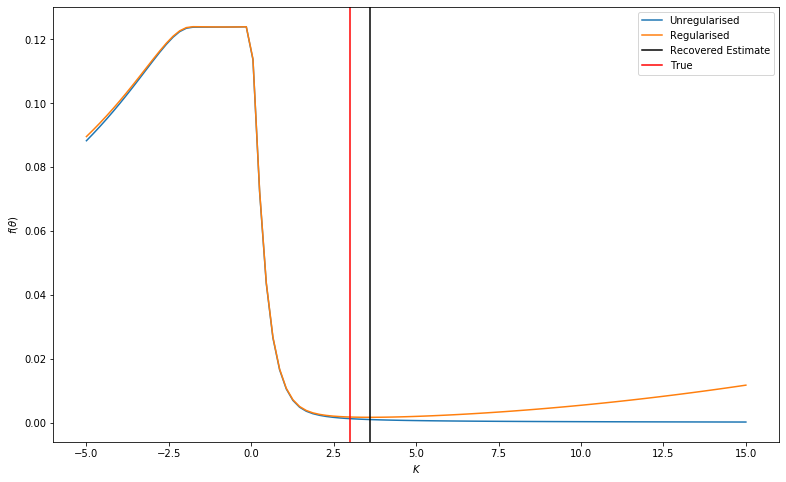

In [52]:
fs_other = [float(pf['f']) for pf in profile_other]
fs_rother = [float(pf['f']) for pf in profile_rother]

plt.plot(pvals_other.flatten(), fs_other, label='Unregularised')
plt.plot(pvals_other.flatten(), fs_rother, label="Regularised")
plt.axvline(float(pref[1]), color="k", label="Recovered Estimate")
plt.axvline(p_true[1], color='r', label="True")
plt.xlabel("$K$")
plt.ylabel(r"$f(\theta)$")
plt.legend()
plt.yscale('linear')

In [49]:
obj_hess = ca.Function('obj_hess', [solver_setup['x'], objective.rho, objective.alpha], 
                       [ca.hessian(objective.objective, ca.vcat(model.ps))[0]])

curv = obj_hess(solutions[idx]['x'], rho, (np.log10(rho)+6)*1e-5)
np.linalg.inv(np.array(curv))

array([[  5.32300313, -20.66980626],
       [-20.66980626, 105.69251798]])